In [1]:
#must be very first statement

import tensorflow as tf
tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [2]:
#data prep
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.datasets import mnist
import PIL


from keras.datasets import cifar10
cifar10.load_data()

my_labels = [6]
all_label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_names = []
for label_index in my_labels:
    label_names.append(all_label_names[label_index])  

print("Defining new Labeling:")
print(dict(zip(range(len(my_labels)),label_names)))

#if my_labels = [5,6,8] then 5 returns 0, 6 returns 1, 8 returns 2, ...
def convert_label(label):
    return dict(zip(my_labels,range(len(my_labels))))[label]

def label_name(num):
    return label_names[num]

# The data, split between train and test sets:
(x_train_all, y_train_all), (x_test_all, y_test_all) = cifar10.load_data()
    
#temp lists
x_train = []
y_train_numerical = []

#filter training data for my_labels
for i in range(len(x_train_all)):
    if y_train_all[i] in my_labels:
        x_train.append(x_train_all[i])
        y_train_numerical.append(convert_label(y_train_all[i][0]))
    else:
        pass

x_train = np.array(x_train)
y_train_numerical = np.array(y_train_numerical)

print("Training Data:\n")
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'samples,', y_train_numerical.shape[0], 'labels')
print("\nClass  |  Counts:")
(unique, counts) = np.unique(y_train_numerical, return_counts=True)
for i, label in enumerate(unique):
    print(label_name(label),"\t", counts[i])


x_test = []
y_test_numerical = []

#filter test data
for i in range(len(x_test_all)):
    if y_test_all[i] in my_labels:
        x_test.append(x_test_all[i])
        y_test_numerical.append(convert_label(y_test_all[i][0]))
    else:
        pass

x_test = np.array(x_test)
y_test_numerical = np.array(y_test_numerical)

print("\n\nTesting Data:\n")
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'samples,', y_test_numerical.shape[0], 'labels')
print("\nClass  |  Counts:")
(unique, counts) = np.unique(y_test_numerical, return_counts=True)
for i, label in enumerate(unique):
    print(label_name(label),"\t", counts[i])
    
x_train=x_train.reshape(x_train.shape[0],32,32,3)
x_test=x_test.reshape(x_test.shape[0],32,32,3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = (x_train-127.5)/127.5
x_test = (x_test-127.5)/127.5


Using TensorFlow backend.


Defining new Labeling:
{0: 'frog'}
Training Data:

x_train shape: (5000, 32, 32, 3)
5000 samples, 5000 labels

Class  |  Counts:
frog 	 5000


Testing Data:

x_test shape: (1000, 32, 32, 3)
1000 samples, 1000 labels

Class  |  Counts:
frog 	 1000


### GAN.py

In [3]:
# https://github.com/davidADSP/GDL_code/blob/master/models/GAN.py

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, \
    BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle as pkl
import matplotlib.pyplot as plt


class GAN():
    def __init__(self
                 , input_dim
                 , discriminator_conv_filters
                 , discriminator_conv_kernel_size
                 , discriminator_conv_strides
                 , discriminator_batch_norm_momentum
                 , discriminator_activation
                 , discriminator_dropout_rate
                 , discriminator_learning_rate
                 , generator_initial_dense_layer_size
                 , generator_upsample
                 , generator_conv_filters
                 , generator_conv_kernel_size
                 , generator_conv_strides
                 , generator_batch_norm_momentum
                 , generator_activation
                 , generator_dropout_rate
                 , generator_learning_rate
                 , optimiser
                 , z_dim
                 ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.discriminator_conv_filters = discriminator_conv_filters
        self.discriminator_conv_kernel_size = discriminator_conv_kernel_size
        self.discriminator_conv_strides = discriminator_conv_strides
        self.discriminator_batch_norm_momentum = discriminator_batch_norm_momentum
        self.discriminator_activation = discriminator_activation
        self.discriminator_dropout_rate = discriminator_dropout_rate
        self.discriminator_learning_rate = discriminator_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate

        self.optimiser = optimiser
        self.z_dim = z_dim

        self.n_layers_discriminator = len(discriminator_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0

        self._build_discriminator()
        self._build_generator()

        self._build_adversarial()

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha=0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_discriminator(self):

        ### THE discriminator
        discriminator_input = Input(shape=self.input_dim, name='discriminator_input')

        x = discriminator_input

        for i in range(self.n_layers_discriminator):

            x = Conv2D(
                filters=self.discriminator_conv_filters[i]
                , kernel_size=self.discriminator_conv_kernel_size[i]
                , strides=self.discriminator_conv_strides[i]
                , padding='same'
                , name='discriminator_conv_' + str(i)
                , kernel_initializer=self.weight_init
            )(x)

            if self.discriminator_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum=self.discriminator_batch_norm_momentum)(x)

            x = self.get_activation(self.discriminator_activation)(x)

            #Removing dropout layers
            #if self.discriminator_dropout_rate:
            #    x = Dropout(rate=self.discriminator_dropout_rate)(x)

        x = Flatten()(x)

        x = Dropout(rate=self.discriminator_dropout_rate)(x)
        
        discriminator_output = Dense(1, activation='sigmoid', kernel_initializer=self.weight_init)(x)

        self.discriminator = Model(discriminator_input, discriminator_output)

    def _build_generator(self):

        ### THE generator

        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size), kernel_initializer=self.weight_init)(x)

        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum=self.generator_batch_norm_momentum)(x)

        x = self.get_activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate=self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                    filters=self.generator_conv_filters[i]
                    , kernel_size=self.generator_conv_kernel_size[i]
                    , padding='same'
                    , name='generator_conv_' + str(i)
                    , kernel_initializer=self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters=self.generator_conv_filters[i]
                    , kernel_size=self.generator_conv_kernel_size[i]
                    , padding='same'
                    , strides=self.generator_conv_strides[i]
                    , name='generator_conv_' + str(i)
                    , kernel_initializer=self.weight_init
                )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum=self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)


            else:

                x = Activation('tanh')(x)

        generator_output = x

        self.generator = Model(generator_input, generator_output)

    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)

        return opti

    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val

    def _build_adversarial(self):

        ### COMPILE DISCRIMINATOR

        self.discriminator.compile(
            optimizer=self.get_opti(self.discriminator_learning_rate)
            , loss='binary_crossentropy'
            , metrics=['accuracy']
        )

        ### COMPILE THE FULL GAN

        self.set_trainable(self.discriminator, False)

        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.discriminator(self.generator(model_input))
        self.model = Model(model_input, model_output)

        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate), loss='binary_crossentropy',
                           metrics=['accuracy'])

        self.set_trainable(self.discriminator, True)


    def train_discriminator(self, x_train, batch_size, using_generator):

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        if using_generator:
            true_imgs = next(x_train)[0]     
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]

        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        d_loss_real, d_acc_real = self.discriminator.train_on_batch(true_imgs, valid)
        d_loss_fake, d_acc_fake = self.discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]
    
    def train_generator(self, batch_size):
        valid = np.ones((batch_size, 1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)

    def train(self, x_train, batch_size, epochs, run_folder
              , print_every_n_batches=50
              , using_generator=False):

        for epoch in range(self.epoch, self.epoch + epochs):
            
            d = self.train_discriminator(x_train, batch_size, using_generator)
            g = self.train_generator(batch_size)

            print("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (
            epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

            self.d_losses.append(d)
            self.g_losses.append(g)

            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                #self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)

            self.epoch += 1

    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15, 15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(np.squeeze(gen_imgs[cnt, :, :, :]))
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder, 'viz/model.png'), show_shapes=True,
                   show_layer_names=True)
        plot_model(self.discriminator, to_file=os.path.join(run_folder, 'viz/discriminator.png'), show_shapes=True,
                   show_layer_names=True)
        plot_model(self.generator, to_file=os.path.join(run_folder, 'viz/generator.png'), show_shapes=True,
                   show_layer_names=True)

    def save(self, folder):

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pkl.dump([
                self.input_dim
                , self.discriminator_conv_filters
                , self.discriminator_conv_kernel_size
                , self.discriminator_conv_strides
                , self.discriminator_batch_norm_momentum
                , self.discriminator_activation
                , self.discriminator_dropout_rate
                , self.discriminator_learning_rate
                , self.generator_initial_dense_layer_size
                , self.generator_upsample
                , self.generator_conv_filters
                , self.generator_conv_kernel_size
                , self.generator_conv_strides
                , self.generator_batch_norm_momentum
                , self.generator_activation
                , self.generator_dropout_rate
                , self.generator_learning_rate
                , self.optimiser
                , self.z_dim
            ], f)

        self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.discriminator.save(os.path.join(run_folder, 'discriminator.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))
        pkl.dump(self, open(os.path.join(run_folder, "obj.pkl"), "wb"))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)


### applyGan.py

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job

C:\Users\Admin\Anaconda3\envs\ml20\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Executing op __inference_keras_scratch_graph_6282 in device /job:localhost/replica:0/task:0/device:GPU:0
0 [D loss: (0.694)(R 0.693, F 0.695)] [D acc: (0.266)(0.531, 0.000)] [G loss: 0.687] [G acc: 1.000]
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


C:\Users\Admin\Anaconda3\envs\ml20\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: (0.690)(R 0.684, F 0.695)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.676] [G acc: 1.000]
2 [D loss: (0.685)(R 0.673, F 0.696)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.648] [G acc: 1.000]
3 [D loss: (0.677)(R 0.651, F 0.702)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.594] [G acc: 1.000]
4 [D loss: (0.664)(R 0.611, F 0.717)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.506] [G acc: 1.000]
5 [D loss: (0.646)(R 0.543, F 0.749)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.359] [G acc: 1.000]
6 [D loss: (0.639)(R 0.453, F 0.826)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.223] [G acc: 1.000]
7 [D loss: (0.657)(R 0.359, F 0.954)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.173] [G acc: 1.000]
8 [D loss: (0.648)(R 0.354, F 0.942)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.227] [G acc: 1.000]
9 [D loss: (0.594)(R 0.338, F 0.851)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.316] [G acc: 1.000]
10 [D loss: (0.565)(R 0.333, F 0.796)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.407] [G acc: 1.000]

85 [D loss: (0.628)(R 0.607, F 0.648)] [D acc: (0.703)(0.766, 0.641)] [G loss: 0.859] [G acc: 0.031]
86 [D loss: (0.631)(R 0.605, F 0.656)] [D acc: (0.719)(0.797, 0.641)] [G loss: 0.866] [G acc: 0.016]
87 [D loss: (0.630)(R 0.592, F 0.668)] [D acc: (0.656)(0.781, 0.531)] [G loss: 0.872] [G acc: 0.016]
88 [D loss: (0.632)(R 0.576, F 0.689)] [D acc: (0.703)(0.859, 0.547)] [G loss: 0.874] [G acc: 0.047]
89 [D loss: (0.662)(R 0.602, F 0.721)] [D acc: (0.531)(0.719, 0.344)] [G loss: 0.826] [G acc: 0.062]
90 [D loss: (0.635)(R 0.520, F 0.749)] [D acc: (0.617)(0.906, 0.328)] [G loss: 0.805] [G acc: 0.141]
91 [D loss: (0.665)(R 0.537, F 0.792)] [D acc: (0.477)(0.812, 0.141)] [G loss: 0.771] [G acc: 0.266]
92 [D loss: (0.691)(R 0.540, F 0.841)] [D acc: (0.445)(0.812, 0.078)] [G loss: 0.720] [G acc: 0.453]
93 [D loss: (0.708)(R 0.568, F 0.848)] [D acc: (0.375)(0.703, 0.047)] [G loss: 0.688] [G acc: 0.547]
94 [D loss: (0.688)(R 0.528, F 0.847)] [D acc: (0.453)(0.875, 0.031)] [G loss: 0.692] [G ac

168 [D loss: (0.683)(R 0.644, F 0.722)] [D acc: (0.594)(0.828, 0.359)] [G loss: 0.721] [G acc: 0.375]
169 [D loss: (0.670)(R 0.660, F 0.680)] [D acc: (0.641)(0.750, 0.531)] [G loss: 0.755] [G acc: 0.281]
170 [D loss: (0.640)(R 0.658, F 0.623)] [D acc: (0.781)(0.719, 0.844)] [G loss: 0.801] [G acc: 0.125]
171 [D loss: (0.611)(R 0.628, F 0.593)] [D acc: (0.836)(0.766, 0.906)] [G loss: 0.847] [G acc: 0.078]
172 [D loss: (0.618)(R 0.682, F 0.554)] [D acc: (0.797)(0.641, 0.953)] [G loss: 0.867] [G acc: 0.109]
173 [D loss: (0.623)(R 0.667, F 0.578)] [D acc: (0.789)(0.688, 0.891)] [G loss: 0.808] [G acc: 0.125]
174 [D loss: (0.695)(R 0.743, F 0.648)] [D acc: (0.648)(0.547, 0.750)] [G loss: 0.747] [G acc: 0.234]
175 [D loss: (0.695)(R 0.688, F 0.703)] [D acc: (0.562)(0.656, 0.469)] [G loss: 0.711] [G acc: 0.438]
176 [D loss: (0.698)(R 0.666, F 0.730)] [D acc: (0.438)(0.594, 0.281)] [G loss: 0.744] [G acc: 0.219]
177 [D loss: (0.705)(R 0.693, F 0.718)] [D acc: (0.477)(0.562, 0.391)] [G loss: 0.

249 [D loss: (0.652)(R 0.774, F 0.530)] [D acc: (0.711)(0.422, 1.000)] [G loss: 0.865] [G acc: 0.000]
250 [D loss: (0.650)(R 0.766, F 0.533)] [D acc: (0.656)(0.312, 1.000)] [G loss: 0.841] [G acc: 0.016]
251 [D loss: (0.654)(R 0.769, F 0.539)] [D acc: (0.617)(0.250, 0.984)] [G loss: 0.801] [G acc: 0.156]
252 [D loss: (0.657)(R 0.757, F 0.558)] [D acc: (0.625)(0.312, 0.938)] [G loss: 0.779] [G acc: 0.375]
253 [D loss: (0.638)(R 0.730, F 0.546)] [D acc: (0.672)(0.406, 0.938)] [G loss: 0.754] [G acc: 0.438]
254 [D loss: (0.644)(R 0.717, F 0.572)] [D acc: (0.633)(0.438, 0.828)] [G loss: 0.772] [G acc: 0.453]
255 [D loss: (0.676)(R 0.795, F 0.556)] [D acc: (0.539)(0.219, 0.859)] [G loss: 0.754] [G acc: 0.484]
256 [D loss: (0.668)(R 0.745, F 0.591)] [D acc: (0.609)(0.438, 0.781)] [G loss: 0.759] [G acc: 0.422]
257 [D loss: (0.672)(R 0.765, F 0.580)] [D acc: (0.531)(0.281, 0.781)] [G loss: 0.797] [G acc: 0.391]
258 [D loss: (0.653)(R 0.735, F 0.570)] [D acc: (0.602)(0.422, 0.781)] [G loss: 0.

332 [D loss: (0.761)(R 0.719, F 0.803)] [D acc: (0.414)(0.672, 0.156)] [G loss: 0.590] [G acc: 0.938]
333 [D loss: (0.741)(R 0.710, F 0.773)] [D acc: (0.391)(0.594, 0.188)] [G loss: 0.697] [G acc: 0.547]
334 [D loss: (0.780)(R 0.773, F 0.786)] [D acc: (0.188)(0.344, 0.031)] [G loss: 0.571] [G acc: 0.969]
335 [D loss: (0.743)(R 0.675, F 0.811)] [D acc: (0.344)(0.688, 0.000)] [G loss: 0.563] [G acc: 1.000]
336 [D loss: (0.714)(R 0.619, F 0.808)] [D acc: (0.406)(0.812, 0.000)] [G loss: 0.599] [G acc: 0.969]
337 [D loss: (0.704)(R 0.635, F 0.773)] [D acc: (0.414)(0.781, 0.047)] [G loss: 0.627] [G acc: 0.906]
338 [D loss: (0.697)(R 0.646, F 0.747)] [D acc: (0.477)(0.750, 0.203)] [G loss: 0.665] [G acc: 0.734]
339 [D loss: (0.701)(R 0.666, F 0.735)] [D acc: (0.477)(0.719, 0.234)] [G loss: 0.673] [G acc: 0.656]
340 [D loss: (0.684)(R 0.636, F 0.732)] [D acc: (0.562)(0.828, 0.297)] [G loss: 0.678] [G acc: 0.719]
341 [D loss: (0.682)(R 0.640, F 0.723)] [D acc: (0.508)(0.750, 0.266)] [G loss: 0.

413 [D loss: (0.691)(R 0.697, F 0.685)] [D acc: (0.578)(0.703, 0.453)] [G loss: 0.772] [G acc: 0.391]
414 [D loss: (0.749)(R 0.770, F 0.729)] [D acc: (0.414)(0.500, 0.328)] [G loss: 0.665] [G acc: 0.781]
415 [D loss: (0.711)(R 0.653, F 0.769)] [D acc: (0.453)(0.844, 0.062)] [G loss: 0.637] [G acc: 0.875]
416 [D loss: (0.725)(R 0.667, F 0.783)] [D acc: (0.391)(0.781, 0.000)] [G loss: 0.619] [G acc: 0.953]
417 [D loss: (0.709)(R 0.628, F 0.791)] [D acc: (0.414)(0.828, 0.000)] [G loss: 0.609] [G acc: 1.000]
418 [D loss: (0.692)(R 0.596, F 0.788)] [D acc: (0.492)(0.984, 0.000)] [G loss: 0.605] [G acc: 1.000]
419 [D loss: (0.699)(R 0.609, F 0.790)] [D acc: (0.477)(0.953, 0.000)] [G loss: 0.603] [G acc: 1.000]
420 [D loss: (0.687)(R 0.587, F 0.787)] [D acc: (0.492)(0.984, 0.000)] [G loss: 0.605] [G acc: 1.000]
421 [D loss: (0.696)(R 0.599, F 0.792)] [D acc: (0.453)(0.906, 0.000)] [G loss: 0.603] [G acc: 1.000]
422 [D loss: (0.684)(R 0.577, F 0.791)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.

494 [D loss: (0.654)(R 0.675, F 0.632)] [D acc: (0.688)(0.688, 0.688)] [G loss: 0.801] [G acc: 0.188]
495 [D loss: (0.615)(R 0.614, F 0.615)] [D acc: (0.805)(0.797, 0.812)] [G loss: 0.818] [G acc: 0.094]
496 [D loss: (0.664)(R 0.660, F 0.669)] [D acc: (0.664)(0.672, 0.656)] [G loss: 0.763] [G acc: 0.156]
497 [D loss: (0.646)(R 0.636, F 0.656)] [D acc: (0.750)(0.766, 0.734)] [G loss: 0.743] [G acc: 0.266]
498 [D loss: (0.675)(R 0.634, F 0.717)] [D acc: (0.594)(0.672, 0.516)] [G loss: 0.724] [G acc: 0.281]
499 [D loss: (0.656)(R 0.606, F 0.706)] [D acc: (0.641)(0.750, 0.531)] [G loss: 0.722] [G acc: 0.328]
500 [D loss: (0.653)(R 0.607, F 0.699)] [D acc: (0.625)(0.734, 0.516)] [G loss: 0.733] [G acc: 0.344]
501 [D loss: (0.658)(R 0.591, F 0.724)] [D acc: (0.656)(0.766, 0.547)] [G loss: 0.781] [G acc: 0.281]
502 [D loss: (0.673)(R 0.656, F 0.690)] [D acc: (0.594)(0.578, 0.609)] [G loss: 0.792] [G acc: 0.375]
503 [D loss: (0.616)(R 0.618, F 0.614)] [D acc: (0.711)(0.703, 0.719)] [G loss: 0.

577 [D loss: (0.396)(R 0.602, F 0.190)] [D acc: (0.859)(0.734, 0.984)] [G loss: 1.690] [G acc: 0.016]
578 [D loss: (0.565)(R 0.499, F 0.631)] [D acc: (0.766)(0.859, 0.672)] [G loss: 1.419] [G acc: 0.000]
579 [D loss: (0.421)(R 0.538, F 0.304)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.709] [G acc: 0.000]
580 [D loss: (0.784)(R 1.025, F 0.542)] [D acc: (0.602)(0.406, 0.797)] [G loss: 1.907] [G acc: 0.031]
581 [D loss: (0.576)(R 0.753, F 0.399)] [D acc: (0.797)(0.672, 0.922)] [G loss: 2.040] [G acc: 0.000]
582 [D loss: (0.573)(R 0.866, F 0.280)] [D acc: (0.812)(0.656, 0.969)] [G loss: 1.741] [G acc: 0.031]
583 [D loss: (0.729)(R 0.896, F 0.562)] [D acc: (0.688)(0.641, 0.734)] [G loss: 1.669] [G acc: 0.000]
584 [D loss: (0.458)(R 0.706, F 0.211)] [D acc: (0.844)(0.703, 0.984)] [G loss: 1.736] [G acc: 0.047]
585 [D loss: (0.498)(R 0.725, F 0.270)] [D acc: (0.867)(0.734, 1.000)] [G loss: 1.512] [G acc: 0.062]
586 [D loss: (0.619)(R 0.809, F 0.429)] [D acc: (0.812)(0.703, 0.922)] [G loss: 1.

659 [D loss: (0.644)(R 0.687, F 0.601)] [D acc: (0.805)(0.641, 0.969)] [G loss: 0.831] [G acc: 0.078]
660 [D loss: (0.595)(R 0.597, F 0.592)] [D acc: (0.914)(0.906, 0.922)] [G loss: 0.897] [G acc: 0.047]
661 [D loss: (0.623)(R 0.658, F 0.587)] [D acc: (0.844)(0.766, 0.922)] [G loss: 0.875] [G acc: 0.078]
662 [D loss: (0.659)(R 0.668, F 0.650)] [D acc: (0.719)(0.734, 0.703)] [G loss: 0.770] [G acc: 0.156]
663 [D loss: (0.587)(R 0.530, F 0.644)] [D acc: (0.844)(0.984, 0.703)] [G loss: 0.800] [G acc: 0.125]
664 [D loss: (0.584)(R 0.503, F 0.666)] [D acc: (0.781)(0.953, 0.609)] [G loss: 0.799] [G acc: 0.188]
665 [D loss: (0.592)(R 0.504, F 0.679)] [D acc: (0.695)(0.906, 0.484)] [G loss: 0.757] [G acc: 0.281]
666 [D loss: (0.533)(R 0.430, F 0.635)] [D acc: (0.852)(0.938, 0.766)] [G loss: 0.795] [G acc: 0.250]
667 [D loss: (0.495)(R 0.357, F 0.634)] [D acc: (0.836)(1.000, 0.672)] [G loss: 0.835] [G acc: 0.203]
668 [D loss: (0.466)(R 0.311, F 0.620)] [D acc: (0.867)(1.000, 0.734)] [G loss: 0.

740 [D loss: (0.659)(R 0.642, F 0.675)] [D acc: (0.711)(0.703, 0.719)] [G loss: 0.680] [G acc: 0.594]
741 [D loss: (0.654)(R 0.616, F 0.693)] [D acc: (0.641)(0.766, 0.516)] [G loss: 0.664] [G acc: 0.734]
742 [D loss: (0.642)(R 0.609, F 0.675)] [D acc: (0.727)(0.812, 0.641)] [G loss: 0.665] [G acc: 0.719]
743 [D loss: (0.663)(R 0.648, F 0.677)] [D acc: (0.648)(0.672, 0.625)] [G loss: 0.673] [G acc: 0.656]
744 [D loss: (0.615)(R 0.601, F 0.629)] [D acc: (0.852)(0.812, 0.891)] [G loss: 0.707] [G acc: 0.516]
745 [D loss: (0.573)(R 0.622, F 0.525)] [D acc: (0.836)(0.703, 0.969)] [G loss: 0.847] [G acc: 0.094]
746 [D loss: (0.457)(R 0.648, F 0.265)] [D acc: (0.859)(0.719, 1.000)] [G loss: 1.379] [G acc: 0.016]
747 [D loss: (0.376)(R 0.576, F 0.177)] [D acc: (0.945)(0.891, 1.000)] [G loss: 2.062] [G acc: 0.000]
748 [D loss: (0.713)(R 0.533, F 0.893)] [D acc: (0.461)(0.906, 0.016)] [G loss: 0.829] [G acc: 0.062]
749 [D loss: (0.570)(R 0.520, F 0.621)] [D acc: (0.898)(0.922, 0.875)] [G loss: 1.

821 [D loss: (0.521)(R 0.597, F 0.446)] [D acc: (0.797)(0.766, 0.828)] [G loss: 0.841] [G acc: 0.453]
822 [D loss: (0.548)(R 0.643, F 0.453)] [D acc: (0.812)(0.812, 0.812)] [G loss: 0.861] [G acc: 0.469]
823 [D loss: (0.643)(R 0.652, F 0.634)] [D acc: (0.695)(0.766, 0.625)] [G loss: 0.811] [G acc: 0.500]
824 [D loss: (0.512)(R 0.446, F 0.577)] [D acc: (0.773)(0.891, 0.656)] [G loss: 0.951] [G acc: 0.266]
825 [D loss: (0.483)(R 0.416, F 0.551)] [D acc: (0.789)(0.891, 0.688)] [G loss: 1.155] [G acc: 0.125]
826 [D loss: (0.393)(R 0.419, F 0.366)] [D acc: (0.961)(0.953, 0.969)] [G loss: 1.549] [G acc: 0.016]
827 [D loss: (0.340)(R 0.473, F 0.206)] [D acc: (0.883)(0.781, 0.984)] [G loss: 1.649] [G acc: 0.031]
828 [D loss: (0.568)(R 0.385, F 0.751)] [D acc: (0.648)(0.938, 0.359)] [G loss: 1.669] [G acc: 0.000]
829 [D loss: (0.400)(R 0.636, F 0.164)] [D acc: (0.867)(0.734, 1.000)] [G loss: 1.607] [G acc: 0.016]
830 [D loss: (0.617)(R 0.701, F 0.532)] [D acc: (0.664)(0.625, 0.703)] [G loss: 1.

902 [D loss: (0.607)(R 0.499, F 0.714)] [D acc: (0.648)(0.812, 0.484)] [G loss: 0.521] [G acc: 0.969]
903 [D loss: (0.602)(R 0.528, F 0.675)] [D acc: (0.727)(0.844, 0.609)] [G loss: 0.597] [G acc: 0.844]
904 [D loss: (0.631)(R 0.595, F 0.667)] [D acc: (0.672)(0.672, 0.672)] [G loss: 0.659] [G acc: 0.594]
905 [D loss: (0.593)(R 0.528, F 0.659)] [D acc: (0.766)(0.828, 0.703)] [G loss: 0.675] [G acc: 0.500]
906 [D loss: (0.600)(R 0.549, F 0.651)] [D acc: (0.688)(0.734, 0.641)] [G loss: 0.684] [G acc: 0.531]
907 [D loss: (0.621)(R 0.611, F 0.631)] [D acc: (0.711)(0.656, 0.766)] [G loss: 0.693] [G acc: 0.578]
908 [D loss: (0.623)(R 0.607, F 0.640)] [D acc: (0.680)(0.672, 0.688)] [G loss: 0.741] [G acc: 0.391]
909 [D loss: (0.611)(R 0.584, F 0.638)] [D acc: (0.719)(0.703, 0.734)] [G loss: 0.698] [G acc: 0.453]
910 [D loss: (0.640)(R 0.646, F 0.633)] [D acc: (0.656)(0.578, 0.734)] [G loss: 0.722] [G acc: 0.453]
911 [D loss: (0.651)(R 0.653, F 0.648)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.

985 [D loss: (0.342)(R 0.346, F 0.339)] [D acc: (0.953)(0.922, 0.984)] [G loss: 1.934] [G acc: 0.000]
986 [D loss: (0.480)(R 0.566, F 0.393)] [D acc: (0.805)(0.641, 0.969)] [G loss: 1.677] [G acc: 0.000]
987 [D loss: (0.546)(R 0.485, F 0.607)] [D acc: (0.742)(0.750, 0.734)] [G loss: 1.594] [G acc: 0.000]
988 [D loss: (0.572)(R 0.523, F 0.621)] [D acc: (0.680)(0.734, 0.625)] [G loss: 1.439] [G acc: 0.031]
989 [D loss: (0.706)(R 0.720, F 0.691)] [D acc: (0.609)(0.703, 0.516)] [G loss: 1.137] [G acc: 0.078]
990 [D loss: (0.462)(R 0.416, F 0.508)] [D acc: (0.789)(0.781, 0.797)] [G loss: 1.239] [G acc: 0.016]
991 [D loss: (0.506)(R 0.482, F 0.530)] [D acc: (0.805)(0.781, 0.828)] [G loss: 1.207] [G acc: 0.031]
992 [D loss: (0.335)(R 0.334, F 0.336)] [D acc: (0.922)(0.875, 0.969)] [G loss: 1.399] [G acc: 0.016]
993 [D loss: (0.344)(R 0.324, F 0.364)] [D acc: (0.961)(0.922, 1.000)] [G loss: 1.460] [G acc: 0.000]
994 [D loss: (0.360)(R 0.311, F 0.409)] [D acc: (0.906)(0.891, 0.922)] [G loss: 1.

1065 [D loss: (0.777)(R 0.753, F 0.801)] [D acc: (0.523)(0.594, 0.453)] [G loss: 0.776] [G acc: 0.484]
1066 [D loss: (0.773)(R 0.850, F 0.697)] [D acc: (0.500)(0.438, 0.562)] [G loss: 0.761] [G acc: 0.547]
1067 [D loss: (0.779)(R 0.777, F 0.781)] [D acc: (0.461)(0.406, 0.516)] [G loss: 0.775] [G acc: 0.453]
1068 [D loss: (0.702)(R 0.761, F 0.644)] [D acc: (0.539)(0.422, 0.656)] [G loss: 0.765] [G acc: 0.578]
1069 [D loss: (0.752)(R 0.765, F 0.739)] [D acc: (0.492)(0.469, 0.516)] [G loss: 0.843] [G acc: 0.391]
1070 [D loss: (0.709)(R 0.758, F 0.659)] [D acc: (0.555)(0.516, 0.594)] [G loss: 0.737] [G acc: 0.500]
1071 [D loss: (0.726)(R 0.781, F 0.670)] [D acc: (0.531)(0.469, 0.594)] [G loss: 0.794] [G acc: 0.391]
1072 [D loss: (0.753)(R 0.799, F 0.708)] [D acc: (0.500)(0.406, 0.594)] [G loss: 0.770] [G acc: 0.469]
1073 [D loss: (0.718)(R 0.765, F 0.671)] [D acc: (0.492)(0.406, 0.578)] [G loss: 0.781] [G acc: 0.484]
1074 [D loss: (0.716)(R 0.694, F 0.738)] [D acc: (0.570)(0.547, 0.594)] [

1145 [D loss: (0.681)(R 0.696, F 0.665)] [D acc: (0.562)(0.469, 0.656)] [G loss: 0.759] [G acc: 0.141]
1146 [D loss: (0.671)(R 0.679, F 0.664)] [D acc: (0.680)(0.641, 0.719)] [G loss: 0.770] [G acc: 0.078]
1147 [D loss: (0.670)(R 0.690, F 0.651)] [D acc: (0.609)(0.516, 0.703)] [G loss: 0.775] [G acc: 0.062]
1148 [D loss: (0.678)(R 0.713, F 0.644)] [D acc: (0.625)(0.438, 0.812)] [G loss: 0.815] [G acc: 0.062]
1149 [D loss: (0.661)(R 0.715, F 0.608)] [D acc: (0.672)(0.422, 0.922)] [G loss: 0.824] [G acc: 0.062]
1150 [D loss: (0.651)(R 0.711, F 0.591)] [D acc: (0.672)(0.422, 0.922)] [G loss: 0.869] [G acc: 0.016]
1151 [D loss: (0.661)(R 0.735, F 0.588)] [D acc: (0.672)(0.406, 0.938)] [G loss: 0.868] [G acc: 0.078]
1152 [D loss: (0.660)(R 0.724, F 0.597)] [D acc: (0.672)(0.469, 0.875)] [G loss: 0.856] [G acc: 0.156]
1153 [D loss: (0.683)(R 0.737, F 0.628)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.848] [G acc: 0.188]
1154 [D loss: (0.652)(R 0.728, F 0.576)] [D acc: (0.703)(0.531, 0.875)] [

1226 [D loss: (0.681)(R 0.676, F 0.686)] [D acc: (0.586)(0.781, 0.391)] [G loss: 0.783] [G acc: 0.281]
1227 [D loss: (0.653)(R 0.660, F 0.646)] [D acc: (0.641)(0.688, 0.594)] [G loss: 0.824] [G acc: 0.109]
1228 [D loss: (0.647)(R 0.671, F 0.622)] [D acc: (0.742)(0.750, 0.734)] [G loss: 0.863] [G acc: 0.109]
1229 [D loss: (0.650)(R 0.682, F 0.618)] [D acc: (0.734)(0.734, 0.734)] [G loss: 0.838] [G acc: 0.156]
1230 [D loss: (0.642)(R 0.640, F 0.644)] [D acc: (0.727)(0.766, 0.688)] [G loss: 0.817] [G acc: 0.250]
1231 [D loss: (0.663)(R 0.648, F 0.678)] [D acc: (0.617)(0.797, 0.438)] [G loss: 0.739] [G acc: 0.531]
1232 [D loss: (0.662)(R 0.625, F 0.699)] [D acc: (0.602)(0.844, 0.359)] [G loss: 0.735] [G acc: 0.656]
1233 [D loss: (0.683)(R 0.665, F 0.700)] [D acc: (0.547)(0.750, 0.344)] [G loss: 0.756] [G acc: 0.469]
1234 [D loss: (0.645)(R 0.656, F 0.634)] [D acc: (0.648)(0.766, 0.531)] [G loss: 0.778] [G acc: 0.438]
1235 [D loss: (0.616)(R 0.673, F 0.559)] [D acc: (0.773)(0.719, 0.828)] [

1308 [D loss: (0.622)(R 0.723, F 0.520)] [D acc: (0.727)(0.625, 0.828)] [G loss: 0.752] [G acc: 0.516]
1309 [D loss: (0.442)(R 0.464, F 0.420)] [D acc: (0.883)(0.844, 0.922)] [G loss: 0.760] [G acc: 0.531]
1310 [D loss: (0.523)(R 0.476, F 0.570)] [D acc: (0.836)(0.938, 0.734)] [G loss: 0.810] [G acc: 0.562]
1311 [D loss: (0.684)(R 0.601, F 0.767)] [D acc: (0.469)(0.672, 0.266)] [G loss: 0.909] [G acc: 0.438]
1312 [D loss: (0.690)(R 0.705, F 0.675)] [D acc: (0.539)(0.688, 0.391)] [G loss: 0.742] [G acc: 0.625]
1313 [D loss: (0.676)(R 0.581, F 0.770)] [D acc: (0.523)(0.781, 0.266)] [G loss: 0.714] [G acc: 0.688]
1314 [D loss: (0.636)(R 0.563, F 0.708)] [D acc: (0.578)(0.797, 0.359)] [G loss: 0.758] [G acc: 0.625]
1315 [D loss: (0.644)(R 0.589, F 0.698)] [D acc: (0.594)(0.812, 0.375)] [G loss: 0.737] [G acc: 0.594]
1316 [D loss: (0.603)(R 0.556, F 0.650)] [D acc: (0.672)(0.828, 0.516)] [G loss: 0.797] [G acc: 0.484]
1317 [D loss: (0.534)(R 0.503, F 0.565)] [D acc: (0.773)(0.922, 0.625)] [

1389 [D loss: (0.665)(R 0.444, F 0.886)] [D acc: (0.562)(0.906, 0.219)] [G loss: 0.669] [G acc: 0.781]
1390 [D loss: (0.669)(R 0.532, F 0.805)] [D acc: (0.539)(0.828, 0.250)] [G loss: 0.670] [G acc: 0.781]
1391 [D loss: (0.596)(R 0.454, F 0.739)] [D acc: (0.633)(0.922, 0.344)] [G loss: 0.703] [G acc: 0.703]
1392 [D loss: (0.644)(R 0.475, F 0.813)] [D acc: (0.578)(0.938, 0.219)] [G loss: 0.730] [G acc: 0.734]
1393 [D loss: (0.586)(R 0.435, F 0.736)] [D acc: (0.625)(0.969, 0.281)] [G loss: 0.791] [G acc: 0.672]
1394 [D loss: (0.598)(R 0.454, F 0.743)] [D acc: (0.617)(0.938, 0.297)] [G loss: 0.867] [G acc: 0.625]
1395 [D loss: (0.597)(R 0.528, F 0.666)] [D acc: (0.602)(0.844, 0.359)] [G loss: 0.840] [G acc: 0.562]
1396 [D loss: (0.618)(R 0.452, F 0.783)] [D acc: (0.539)(0.828, 0.250)] [G loss: 0.926] [G acc: 0.594]
1397 [D loss: (0.649)(R 0.496, F 0.802)] [D acc: (0.555)(0.812, 0.297)] [G loss: 0.825] [G acc: 0.562]
1398 [D loss: (0.684)(R 0.541, F 0.827)] [D acc: (0.562)(0.734, 0.391)] [

1470 [D loss: (0.632)(R 0.549, F 0.714)] [D acc: (0.609)(0.875, 0.344)] [G loss: 1.007] [G acc: 0.250]
1471 [D loss: (0.642)(R 0.617, F 0.666)] [D acc: (0.648)(0.828, 0.469)] [G loss: 1.018] [G acc: 0.000]
1472 [D loss: (0.567)(R 0.555, F 0.580)] [D acc: (0.852)(0.844, 0.859)] [G loss: 1.122] [G acc: 0.000]
1473 [D loss: (0.507)(R 0.501, F 0.513)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.191] [G acc: 0.000]
1474 [D loss: (0.543)(R 0.518, F 0.569)] [D acc: (0.797)(0.781, 0.812)] [G loss: 1.175] [G acc: 0.000]
1475 [D loss: (0.528)(R 0.523, F 0.533)] [D acc: (0.812)(0.750, 0.875)] [G loss: 1.213] [G acc: 0.000]
1476 [D loss: (0.507)(R 0.465, F 0.549)] [D acc: (0.836)(0.859, 0.812)] [G loss: 1.399] [G acc: 0.000]
1477 [D loss: (0.462)(R 0.474, F 0.451)] [D acc: (0.898)(0.859, 0.938)] [G loss: 1.518] [G acc: 0.000]
1478 [D loss: (0.495)(R 0.501, F 0.490)] [D acc: (0.859)(0.797, 0.922)] [G loss: 1.399] [G acc: 0.016]
1479 [D loss: (0.490)(R 0.474, F 0.506)] [D acc: (0.844)(0.828, 0.859)] [

1551 [D loss: (0.592)(R 0.626, F 0.557)] [D acc: (0.812)(0.703, 0.922)] [G loss: 0.927] [G acc: 0.125]
1552 [D loss: (0.594)(R 0.626, F 0.561)] [D acc: (0.750)(0.688, 0.812)] [G loss: 0.938] [G acc: 0.109]
1553 [D loss: (0.581)(R 0.571, F 0.590)] [D acc: (0.820)(0.828, 0.812)] [G loss: 0.986] [G acc: 0.125]
1554 [D loss: (0.569)(R 0.593, F 0.546)] [D acc: (0.836)(0.828, 0.844)] [G loss: 1.019] [G acc: 0.141]
1555 [D loss: (0.594)(R 0.626, F 0.561)] [D acc: (0.781)(0.750, 0.812)] [G loss: 0.914] [G acc: 0.156]
1556 [D loss: (0.610)(R 0.598, F 0.622)] [D acc: (0.719)(0.750, 0.688)] [G loss: 0.899] [G acc: 0.188]
1557 [D loss: (0.583)(R 0.554, F 0.612)] [D acc: (0.758)(0.797, 0.719)] [G loss: 1.028] [G acc: 0.062]
1558 [D loss: (0.562)(R 0.581, F 0.542)] [D acc: (0.781)(0.750, 0.812)] [G loss: 1.111] [G acc: 0.062]
1559 [D loss: (0.545)(R 0.587, F 0.503)] [D acc: (0.789)(0.719, 0.859)] [G loss: 1.157] [G acc: 0.062]
1560 [D loss: (0.563)(R 0.571, F 0.556)] [D acc: (0.766)(0.750, 0.781)] [

1631 [D loss: (0.678)(R 0.619, F 0.737)] [D acc: (0.562)(0.750, 0.375)] [G loss: 0.754] [G acc: 0.703]
1632 [D loss: (0.578)(R 0.531, F 0.626)] [D acc: (0.719)(0.891, 0.547)] [G loss: 0.857] [G acc: 0.656]
1633 [D loss: (0.673)(R 0.577, F 0.770)] [D acc: (0.555)(0.812, 0.297)] [G loss: 0.867] [G acc: 0.547]
1634 [D loss: (0.636)(R 0.545, F 0.726)] [D acc: (0.594)(0.812, 0.375)] [G loss: 0.990] [G acc: 0.344]
1635 [D loss: (0.695)(R 0.670, F 0.720)] [D acc: (0.531)(0.734, 0.328)] [G loss: 0.938] [G acc: 0.234]
1636 [D loss: (0.703)(R 0.697, F 0.709)] [D acc: (0.484)(0.562, 0.406)] [G loss: 0.939] [G acc: 0.172]
1637 [D loss: (0.645)(R 0.691, F 0.599)] [D acc: (0.656)(0.625, 0.688)] [G loss: 1.102] [G acc: 0.016]
1638 [D loss: (0.592)(R 0.644, F 0.541)] [D acc: (0.695)(0.531, 0.859)] [G loss: 1.381] [G acc: 0.000]
1639 [D loss: (0.554)(R 0.562, F 0.547)] [D acc: (0.781)(0.812, 0.750)] [G loss: 1.269] [G acc: 0.000]
1640 [D loss: (0.624)(R 0.651, F 0.597)] [D acc: (0.656)(0.625, 0.688)] [

1712 [D loss: (0.536)(R 0.662, F 0.411)] [D acc: (0.797)(0.641, 0.953)] [G loss: 0.982] [G acc: 0.250]
1713 [D loss: (0.489)(R 0.562, F 0.417)] [D acc: (0.867)(0.781, 0.953)] [G loss: 0.932] [G acc: 0.297]
1714 [D loss: (0.591)(R 0.668, F 0.514)] [D acc: (0.766)(0.656, 0.875)] [G loss: 0.748] [G acc: 0.547]
1715 [D loss: (0.595)(R 0.538, F 0.653)] [D acc: (0.734)(0.844, 0.625)] [G loss: 0.849] [G acc: 0.516]
1716 [D loss: (0.706)(R 0.700, F 0.711)] [D acc: (0.492)(0.625, 0.359)] [G loss: 0.942] [G acc: 0.422]
1717 [D loss: (0.788)(R 0.785, F 0.790)] [D acc: (0.422)(0.578, 0.266)] [G loss: 0.822] [G acc: 0.578]
1718 [D loss: (0.705)(R 0.642, F 0.768)] [D acc: (0.461)(0.672, 0.250)] [G loss: 0.896] [G acc: 0.359]
1719 [D loss: (0.634)(R 0.638, F 0.630)] [D acc: (0.594)(0.688, 0.500)] [G loss: 1.024] [G acc: 0.219]
1720 [D loss: (0.611)(R 0.577, F 0.645)] [D acc: (0.664)(0.781, 0.547)] [G loss: 1.044] [G acc: 0.109]
1721 [D loss: (0.503)(R 0.490, F 0.516)] [D acc: (0.836)(0.891, 0.781)] [

1793 [D loss: (0.666)(R 0.770, F 0.562)] [D acc: (0.633)(0.469, 0.797)] [G loss: 0.800] [G acc: 0.562]
1794 [D loss: (0.570)(R 0.626, F 0.514)] [D acc: (0.648)(0.547, 0.750)] [G loss: 0.850] [G acc: 0.516]
1795 [D loss: (0.602)(R 0.757, F 0.447)] [D acc: (0.680)(0.500, 0.859)] [G loss: 0.830] [G acc: 0.531]
1796 [D loss: (0.538)(R 0.660, F 0.416)] [D acc: (0.742)(0.625, 0.859)] [G loss: 0.877] [G acc: 0.469]
1797 [D loss: (0.486)(R 0.558, F 0.414)] [D acc: (0.789)(0.719, 0.859)] [G loss: 0.982] [G acc: 0.438]
1798 [D loss: (0.670)(R 0.656, F 0.684)] [D acc: (0.570)(0.547, 0.594)] [G loss: 1.091] [G acc: 0.297]
1799 [D loss: (0.884)(R 0.704, F 1.064)] [D acc: (0.328)(0.578, 0.078)] [G loss: 1.035] [G acc: 0.234]
1800 [D loss: (0.801)(R 0.649, F 0.953)] [D acc: (0.422)(0.703, 0.141)] [G loss: 1.144] [G acc: 0.047]
1801 [D loss: (0.564)(R 0.676, F 0.453)] [D acc: (0.719)(0.531, 0.906)] [G loss: 1.729] [G acc: 0.000]
1802 [D loss: (0.408)(R 0.641, F 0.174)] [D acc: (0.797)(0.594, 1.000)] [

1874 [D loss: (0.584)(R 0.617, F 0.550)] [D acc: (0.734)(0.609, 0.859)] [G loss: 0.739] [G acc: 0.594]
1875 [D loss: (0.576)(R 0.622, F 0.529)] [D acc: (0.734)(0.672, 0.797)] [G loss: 0.830] [G acc: 0.359]
1876 [D loss: (0.523)(R 0.567, F 0.480)] [D acc: (0.812)(0.766, 0.859)] [G loss: 1.129] [G acc: 0.234]
1877 [D loss: (0.436)(R 0.582, F 0.289)] [D acc: (0.844)(0.719, 0.969)] [G loss: 1.316] [G acc: 0.250]
1878 [D loss: (0.445)(R 0.364, F 0.527)] [D acc: (0.805)(0.906, 0.703)] [G loss: 1.359] [G acc: 0.266]
1879 [D loss: (0.442)(R 0.453, F 0.432)] [D acc: (0.844)(0.859, 0.828)] [G loss: 1.626] [G acc: 0.250]
1880 [D loss: (0.687)(R 0.690, F 0.684)] [D acc: (0.672)(0.719, 0.625)] [G loss: 1.335] [G acc: 0.375]
1881 [D loss: (0.528)(R 0.523, F 0.532)] [D acc: (0.758)(0.828, 0.688)] [G loss: 1.283] [G acc: 0.391]
1882 [D loss: (0.735)(R 0.663, F 0.807)] [D acc: (0.609)(0.766, 0.453)] [G loss: 1.421] [G acc: 0.203]
1883 [D loss: (0.627)(R 0.887, F 0.367)] [D acc: (0.703)(0.516, 0.891)] [

1954 [D loss: (0.569)(R 0.544, F 0.595)] [D acc: (0.695)(0.781, 0.609)] [G loss: 1.158] [G acc: 0.125]
1955 [D loss: (0.674)(R 0.632, F 0.716)] [D acc: (0.523)(0.688, 0.359)] [G loss: 1.105] [G acc: 0.188]
1956 [D loss: (0.615)(R 0.579, F 0.651)] [D acc: (0.648)(0.812, 0.484)] [G loss: 1.137] [G acc: 0.125]
1957 [D loss: (0.636)(R 0.639, F 0.632)] [D acc: (0.617)(0.719, 0.516)] [G loss: 1.267] [G acc: 0.172]
1958 [D loss: (0.646)(R 0.676, F 0.615)] [D acc: (0.609)(0.609, 0.609)] [G loss: 1.325] [G acc: 0.094]
1959 [D loss: (0.522)(R 0.570, F 0.474)] [D acc: (0.859)(0.828, 0.891)] [G loss: 1.344] [G acc: 0.016]
1960 [D loss: (0.509)(R 0.571, F 0.448)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.084] [G acc: 0.109]
1961 [D loss: (0.631)(R 0.538, F 0.725)] [D acc: (0.602)(0.875, 0.328)] [G loss: 1.044] [G acc: 0.250]
1962 [D loss: (0.546)(R 0.579, F 0.513)] [D acc: (0.852)(0.844, 0.859)] [G loss: 1.197] [G acc: 0.000]
1963 [D loss: (0.527)(R 0.598, F 0.456)] [D acc: (0.789)(0.672, 0.906)] [

2036 [D loss: (0.532)(R 0.524, F 0.540)] [D acc: (0.773)(0.828, 0.719)] [G loss: 1.045] [G acc: 0.359]
2037 [D loss: (0.515)(R 0.560, F 0.470)] [D acc: (0.766)(0.734, 0.797)] [G loss: 1.060] [G acc: 0.359]
2038 [D loss: (0.494)(R 0.505, F 0.484)] [D acc: (0.805)(0.797, 0.812)] [G loss: 1.148] [G acc: 0.328]
2039 [D loss: (0.535)(R 0.576, F 0.494)] [D acc: (0.773)(0.734, 0.812)] [G loss: 0.935] [G acc: 0.438]
2040 [D loss: (0.559)(R 0.554, F 0.563)] [D acc: (0.672)(0.688, 0.656)] [G loss: 0.748] [G acc: 0.562]
2041 [D loss: (0.470)(R 0.472, F 0.467)] [D acc: (0.828)(0.797, 0.859)] [G loss: 0.764] [G acc: 0.500]
2042 [D loss: (0.410)(R 0.522, F 0.299)] [D acc: (0.805)(0.672, 0.938)] [G loss: 0.953] [G acc: 0.438]
2043 [D loss: (0.517)(R 0.542, F 0.493)] [D acc: (0.758)(0.688, 0.828)] [G loss: 0.893] [G acc: 0.547]
2044 [D loss: (0.589)(R 0.389, F 0.790)] [D acc: (0.633)(0.844, 0.422)] [G loss: 0.858] [G acc: 0.594]
2045 [D loss: (0.548)(R 0.418, F 0.678)] [D acc: (0.734)(0.844, 0.625)] [

2116 [D loss: (0.605)(R 0.648, F 0.562)] [D acc: (0.664)(0.609, 0.719)] [G loss: 0.883] [G acc: 0.344]
2117 [D loss: (0.563)(R 0.566, F 0.560)] [D acc: (0.773)(0.812, 0.734)] [G loss: 1.069] [G acc: 0.062]
2118 [D loss: (0.544)(R 0.592, F 0.496)] [D acc: (0.812)(0.781, 0.844)] [G loss: 1.724] [G acc: 0.000]
2119 [D loss: (0.504)(R 0.588, F 0.419)] [D acc: (0.828)(0.719, 0.938)] [G loss: 1.631] [G acc: 0.000]
2120 [D loss: (0.535)(R 0.481, F 0.589)] [D acc: (0.852)(0.875, 0.828)] [G loss: 1.635] [G acc: 0.000]
2121 [D loss: (0.464)(R 0.516, F 0.411)] [D acc: (0.891)(0.781, 1.000)] [G loss: 1.938] [G acc: 0.000]
2122 [D loss: (0.543)(R 0.624, F 0.461)] [D acc: (0.797)(0.688, 0.906)] [G loss: 1.464] [G acc: 0.016]
2123 [D loss: (0.524)(R 0.482, F 0.566)] [D acc: (0.773)(0.844, 0.703)] [G loss: 1.617] [G acc: 0.000]
2124 [D loss: (0.448)(R 0.470, F 0.426)] [D acc: (0.844)(0.828, 0.859)] [G loss: 1.705] [G acc: 0.000]
2125 [D loss: (0.583)(R 0.658, F 0.507)] [D acc: (0.734)(0.719, 0.750)] [

2197 [D loss: (0.427)(R 0.407, F 0.448)] [D acc: (0.773)(0.750, 0.797)] [G loss: 0.731] [G acc: 0.531]
2198 [D loss: (0.430)(R 0.419, F 0.441)] [D acc: (0.844)(0.844, 0.844)] [G loss: 0.512] [G acc: 0.719]
2199 [D loss: (0.664)(R 0.664, F 0.665)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.417] [G acc: 0.828]
2200 [D loss: (0.575)(R 0.479, F 0.672)] [D acc: (0.727)(0.766, 0.688)] [G loss: 0.416] [G acc: 0.828]
2201 [D loss: (0.491)(R 0.531, F 0.451)] [D acc: (0.734)(0.656, 0.812)] [G loss: 0.387] [G acc: 0.875]
2202 [D loss: (0.683)(R 0.719, F 0.647)] [D acc: (0.625)(0.594, 0.656)] [G loss: 0.464] [G acc: 0.797]
2203 [D loss: (0.567)(R 0.570, F 0.564)] [D acc: (0.688)(0.703, 0.672)] [G loss: 0.481] [G acc: 0.812]
2204 [D loss: (0.580)(R 0.580, F 0.579)] [D acc: (0.734)(0.672, 0.797)] [G loss: 0.473] [G acc: 0.844]
2205 [D loss: (0.625)(R 0.716, F 0.534)] [D acc: (0.672)(0.578, 0.766)] [G loss: 0.640] [G acc: 0.656]
2206 [D loss: (0.530)(R 0.522, F 0.538)] [D acc: (0.719)(0.688, 0.750)] [

2277 [D loss: (0.585)(R 0.580, F 0.590)] [D acc: (0.727)(0.828, 0.625)] [G loss: 0.888] [G acc: 0.547]
2278 [D loss: (0.568)(R 0.509, F 0.626)] [D acc: (0.672)(0.828, 0.516)] [G loss: 0.978] [G acc: 0.453]
2279 [D loss: (0.611)(R 0.596, F 0.625)] [D acc: (0.625)(0.703, 0.547)] [G loss: 0.976] [G acc: 0.594]
2280 [D loss: (0.589)(R 0.576, F 0.603)] [D acc: (0.625)(0.781, 0.469)] [G loss: 0.968] [G acc: 0.578]
2281 [D loss: (0.588)(R 0.520, F 0.657)] [D acc: (0.602)(0.797, 0.406)] [G loss: 1.024] [G acc: 0.609]
2282 [D loss: (0.614)(R 0.582, F 0.645)] [D acc: (0.586)(0.719, 0.453)] [G loss: 0.920] [G acc: 0.578]
2283 [D loss: (0.631)(R 0.608, F 0.655)] [D acc: (0.547)(0.703, 0.391)] [G loss: 1.039] [G acc: 0.562]
2284 [D loss: (0.618)(R 0.621, F 0.615)] [D acc: (0.609)(0.750, 0.469)] [G loss: 0.844] [G acc: 0.562]
2285 [D loss: (0.628)(R 0.651, F 0.605)] [D acc: (0.617)(0.625, 0.609)] [G loss: 0.896] [G acc: 0.422]
2286 [D loss: (0.574)(R 0.541, F 0.608)] [D acc: (0.641)(0.656, 0.625)] [

2356 [D loss: (0.484)(R 0.396, F 0.572)] [D acc: (0.766)(0.844, 0.688)] [G loss: 0.838] [G acc: 0.578]
2357 [D loss: (0.556)(R 0.591, F 0.522)] [D acc: (0.711)(0.672, 0.750)] [G loss: 0.958] [G acc: 0.453]
2358 [D loss: (0.631)(R 0.701, F 0.561)] [D acc: (0.641)(0.594, 0.688)] [G loss: 0.931] [G acc: 0.406]
2359 [D loss: (0.611)(R 0.588, F 0.635)] [D acc: (0.633)(0.656, 0.609)] [G loss: 1.074] [G acc: 0.266]
2360 [D loss: (0.607)(R 0.607, F 0.608)] [D acc: (0.656)(0.609, 0.703)] [G loss: 1.372] [G acc: 0.141]
2361 [D loss: (0.662)(R 0.791, F 0.532)] [D acc: (0.680)(0.516, 0.844)] [G loss: 1.679] [G acc: 0.000]
2362 [D loss: (0.585)(R 0.778, F 0.393)] [D acc: (0.695)(0.531, 0.859)] [G loss: 2.720] [G acc: 0.016]
2363 [D loss: (0.928)(R 0.724, F 1.133)] [D acc: (0.383)(0.531, 0.234)] [G loss: 2.813] [G acc: 0.000]
2364 [D loss: (0.496)(R 0.887, F 0.105)] [D acc: (0.688)(0.375, 1.000)] [G loss: 2.539] [G acc: 0.000]
2365 [D loss: (0.633)(R 0.958, F 0.309)] [D acc: (0.688)(0.406, 0.969)] [

2437 [D loss: (0.554)(R 0.505, F 0.603)] [D acc: (0.727)(0.719, 0.734)] [G loss: 1.222] [G acc: 0.031]
2438 [D loss: (0.680)(R 0.743, F 0.618)] [D acc: (0.656)(0.562, 0.750)] [G loss: 1.182] [G acc: 0.047]
2439 [D loss: (0.567)(R 0.600, F 0.534)] [D acc: (0.750)(0.656, 0.844)] [G loss: 1.340] [G acc: 0.047]
2440 [D loss: (0.615)(R 0.558, F 0.673)] [D acc: (0.633)(0.641, 0.625)] [G loss: 1.433] [G acc: 0.016]
2441 [D loss: (0.597)(R 0.622, F 0.572)] [D acc: (0.719)(0.719, 0.719)] [G loss: 1.610] [G acc: 0.000]
2442 [D loss: (0.653)(R 0.703, F 0.604)] [D acc: (0.648)(0.578, 0.719)] [G loss: 1.465] [G acc: 0.016]
2443 [D loss: (0.577)(R 0.611, F 0.544)] [D acc: (0.688)(0.625, 0.750)] [G loss: 1.569] [G acc: 0.016]
2444 [D loss: (0.555)(R 0.587, F 0.522)] [D acc: (0.758)(0.672, 0.844)] [G loss: 1.733] [G acc: 0.000]
2445 [D loss: (0.396)(R 0.448, F 0.344)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.048] [G acc: 0.016]
2446 [D loss: (0.538)(R 0.659, F 0.417)] [D acc: (0.750)(0.625, 0.875)] [

2518 [D loss: (0.581)(R 0.525, F 0.637)] [D acc: (0.695)(0.750, 0.641)] [G loss: 1.341] [G acc: 0.031]
2519 [D loss: (0.557)(R 0.666, F 0.449)] [D acc: (0.742)(0.594, 0.891)] [G loss: 1.383] [G acc: 0.031]
2520 [D loss: (0.566)(R 0.611, F 0.521)] [D acc: (0.750)(0.734, 0.766)] [G loss: 1.440] [G acc: 0.031]
2521 [D loss: (0.523)(R 0.576, F 0.470)] [D acc: (0.773)(0.719, 0.828)] [G loss: 1.481] [G acc: 0.062]
2522 [D loss: (0.477)(R 0.522, F 0.432)] [D acc: (0.875)(0.844, 0.906)] [G loss: 1.557] [G acc: 0.047]
2523 [D loss: (0.513)(R 0.585, F 0.442)] [D acc: (0.758)(0.672, 0.844)] [G loss: 1.042] [G acc: 0.156]
2524 [D loss: (0.577)(R 0.450, F 0.703)] [D acc: (0.648)(0.797, 0.500)] [G loss: 1.134] [G acc: 0.109]
2525 [D loss: (0.534)(R 0.683, F 0.385)] [D acc: (0.719)(0.609, 0.828)] [G loss: 1.539] [G acc: 0.234]
2526 [D loss: (0.585)(R 0.652, F 0.519)] [D acc: (0.688)(0.656, 0.719)] [G loss: 1.267] [G acc: 0.297]
2527 [D loss: (0.512)(R 0.451, F 0.574)] [D acc: (0.758)(0.828, 0.688)] [

2600 [D loss: (0.953)(R 1.138, F 0.769)] [D acc: (0.477)(0.469, 0.484)] [G loss: 1.563] [G acc: 0.062]
2601 [D loss: (0.766)(R 0.809, F 0.722)] [D acc: (0.516)(0.562, 0.469)] [G loss: 1.359] [G acc: 0.297]
2602 [D loss: (0.658)(R 0.723, F 0.594)] [D acc: (0.570)(0.547, 0.594)] [G loss: 1.438] [G acc: 0.297]
2603 [D loss: (0.714)(R 0.823, F 0.606)] [D acc: (0.539)(0.484, 0.594)] [G loss: 1.284] [G acc: 0.312]
2604 [D loss: (0.666)(R 0.655, F 0.677)] [D acc: (0.617)(0.703, 0.531)] [G loss: 1.285] [G acc: 0.438]
2605 [D loss: (0.628)(R 0.671, F 0.586)] [D acc: (0.719)(0.750, 0.688)] [G loss: 1.234] [G acc: 0.406]
2606 [D loss: (0.604)(R 0.663, F 0.544)] [D acc: (0.688)(0.734, 0.641)] [G loss: 1.374] [G acc: 0.078]
2607 [D loss: (0.502)(R 0.509, F 0.495)] [D acc: (0.773)(0.766, 0.781)] [G loss: 1.131] [G acc: 0.172]
2608 [D loss: (0.468)(R 0.531, F 0.404)] [D acc: (0.891)(0.828, 0.953)] [G loss: 1.176] [G acc: 0.172]
2609 [D loss: (0.525)(R 0.507, F 0.543)] [D acc: (0.734)(0.734, 0.734)] [

2681 [D loss: (0.427)(R 0.462, F 0.392)] [D acc: (0.820)(0.703, 0.938)] [G loss: 1.007] [G acc: 0.344]
2682 [D loss: (0.371)(R 0.574, F 0.167)] [D acc: (0.820)(0.641, 1.000)] [G loss: 1.795] [G acc: 0.031]
2683 [D loss: (0.224)(R 0.376, F 0.072)] [D acc: (0.922)(0.844, 1.000)] [G loss: 3.533] [G acc: 0.000]
2684 [D loss: (0.386)(R 0.296, F 0.475)] [D acc: (0.883)(0.938, 0.828)] [G loss: 0.671] [G acc: 0.672]
2685 [D loss: (0.282)(R 0.341, F 0.223)] [D acc: (0.938)(0.891, 0.984)] [G loss: 1.359] [G acc: 0.266]
2686 [D loss: (0.412)(R 0.319, F 0.505)] [D acc: (0.852)(0.906, 0.797)] [G loss: 1.203] [G acc: 0.203]
2687 [D loss: (0.332)(R 0.450, F 0.214)] [D acc: (0.883)(0.781, 0.984)] [G loss: 1.732] [G acc: 0.062]
2688 [D loss: (0.395)(R 0.526, F 0.263)] [D acc: (0.867)(0.812, 0.922)] [G loss: 1.997] [G acc: 0.016]
2689 [D loss: (0.330)(R 0.318, F 0.342)] [D acc: (0.883)(0.906, 0.859)] [G loss: 2.474] [G acc: 0.016]
2690 [D loss: (0.305)(R 0.377, F 0.234)] [D acc: (0.906)(0.875, 0.938)] [

2761 [D loss: (0.641)(R 0.623, F 0.658)] [D acc: (0.633)(0.703, 0.562)] [G loss: 0.621] [G acc: 0.734]
2762 [D loss: (0.649)(R 0.752, F 0.546)] [D acc: (0.695)(0.672, 0.719)] [G loss: 0.644] [G acc: 0.703]
2763 [D loss: (0.582)(R 0.645, F 0.518)] [D acc: (0.688)(0.625, 0.750)] [G loss: 0.700] [G acc: 0.672]
2764 [D loss: (0.557)(R 0.612, F 0.502)] [D acc: (0.727)(0.672, 0.781)] [G loss: 0.721] [G acc: 0.625]
2765 [D loss: (0.558)(R 0.615, F 0.501)] [D acc: (0.703)(0.594, 0.812)] [G loss: 0.826] [G acc: 0.438]
2766 [D loss: (0.539)(R 0.528, F 0.550)] [D acc: (0.672)(0.641, 0.703)] [G loss: 0.842] [G acc: 0.500]
2767 [D loss: (0.597)(R 0.641, F 0.552)] [D acc: (0.648)(0.609, 0.688)] [G loss: 0.871] [G acc: 0.406]
2768 [D loss: (0.613)(R 0.615, F 0.610)] [D acc: (0.586)(0.562, 0.609)] [G loss: 0.904] [G acc: 0.266]
2769 [D loss: (0.599)(R 0.591, F 0.606)] [D acc: (0.648)(0.641, 0.656)] [G loss: 1.026] [G acc: 0.250]
2770 [D loss: (0.565)(R 0.539, F 0.590)] [D acc: (0.688)(0.703, 0.672)] [

2842 [D loss: (0.528)(R 0.559, F 0.497)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.258] [G acc: 0.094]
2843 [D loss: (0.499)(R 0.499, F 0.498)] [D acc: (0.766)(0.797, 0.734)] [G loss: 1.290] [G acc: 0.156]
2844 [D loss: (0.496)(R 0.478, F 0.515)] [D acc: (0.828)(0.812, 0.844)] [G loss: 1.231] [G acc: 0.109]
2845 [D loss: (0.464)(R 0.429, F 0.499)] [D acc: (0.844)(0.891, 0.797)] [G loss: 1.343] [G acc: 0.109]
2846 [D loss: (0.552)(R 0.540, F 0.563)] [D acc: (0.789)(0.844, 0.734)] [G loss: 1.329] [G acc: 0.125]
2847 [D loss: (0.427)(R 0.439, F 0.416)] [D acc: (0.859)(0.828, 0.891)] [G loss: 1.467] [G acc: 0.031]
2848 [D loss: (0.463)(R 0.429, F 0.497)] [D acc: (0.852)(0.844, 0.859)] [G loss: 1.398] [G acc: 0.094]
2849 [D loss: (0.492)(R 0.429, F 0.556)] [D acc: (0.836)(0.875, 0.797)] [G loss: 1.438] [G acc: 0.109]
2850 [D loss: (0.559)(R 0.637, F 0.480)] [D acc: (0.773)(0.750, 0.797)] [G loss: 1.218] [G acc: 0.250]
2851 [D loss: (0.630)(R 0.621, F 0.639)] [D acc: (0.680)(0.766, 0.594)] [

2921 [D loss: (0.674)(R 0.582, F 0.766)] [D acc: (0.500)(0.656, 0.344)] [G loss: 1.261] [G acc: 0.047]
2922 [D loss: (0.722)(R 0.818, F 0.625)] [D acc: (0.547)(0.438, 0.656)] [G loss: 1.106] [G acc: 0.047]
2923 [D loss: (0.673)(R 0.793, F 0.552)] [D acc: (0.648)(0.484, 0.812)] [G loss: 0.949] [G acc: 0.250]
2924 [D loss: (0.749)(R 0.857, F 0.642)] [D acc: (0.562)(0.484, 0.641)] [G loss: 0.756] [G acc: 0.453]
2925 [D loss: (0.658)(R 0.771, F 0.545)] [D acc: (0.641)(0.484, 0.797)] [G loss: 0.764] [G acc: 0.453]
2926 [D loss: (0.558)(R 0.639, F 0.477)] [D acc: (0.773)(0.672, 0.875)] [G loss: 0.759] [G acc: 0.594]
2927 [D loss: (0.554)(R 0.607, F 0.502)] [D acc: (0.711)(0.625, 0.797)] [G loss: 0.970] [G acc: 0.359]
2928 [D loss: (0.575)(R 0.651, F 0.500)] [D acc: (0.688)(0.594, 0.781)] [G loss: 1.114] [G acc: 0.250]
2929 [D loss: (0.411)(R 0.420, F 0.401)] [D acc: (0.836)(0.781, 0.891)] [G loss: 1.334] [G acc: 0.312]
2930 [D loss: (0.549)(R 0.519, F 0.578)] [D acc: (0.734)(0.766, 0.703)] [

3001 [D loss: (0.288)(R 0.264, F 0.313)] [D acc: (0.961)(0.938, 0.984)] [G loss: 2.044] [G acc: 0.016]
3002 [D loss: (0.374)(R 0.306, F 0.442)] [D acc: (0.867)(0.875, 0.859)] [G loss: 1.862] [G acc: 0.000]
3003 [D loss: (0.403)(R 0.344, F 0.462)] [D acc: (0.805)(0.812, 0.797)] [G loss: 1.787] [G acc: 0.062]
3004 [D loss: (0.409)(R 0.387, F 0.431)] [D acc: (0.820)(0.828, 0.812)] [G loss: 1.721] [G acc: 0.094]
3005 [D loss: (0.494)(R 0.533, F 0.454)] [D acc: (0.750)(0.719, 0.781)] [G loss: 1.312] [G acc: 0.219]
3006 [D loss: (0.460)(R 0.376, F 0.545)] [D acc: (0.750)(0.797, 0.703)] [G loss: 1.523] [G acc: 0.172]
3007 [D loss: (0.459)(R 0.446, F 0.471)] [D acc: (0.805)(0.812, 0.797)] [G loss: 1.314] [G acc: 0.266]
3008 [D loss: (0.545)(R 0.551, F 0.538)] [D acc: (0.742)(0.719, 0.766)] [G loss: 0.916] [G acc: 0.406]
3009 [D loss: (0.491)(R 0.472, F 0.510)] [D acc: (0.766)(0.750, 0.781)] [G loss: 0.771] [G acc: 0.500]
3010 [D loss: (0.478)(R 0.604, F 0.352)] [D acc: (0.773)(0.656, 0.891)] [

3083 [D loss: (0.596)(R 0.468, F 0.724)] [D acc: (0.742)(0.859, 0.625)] [G loss: 0.472] [G acc: 0.812]
3084 [D loss: (0.325)(R 0.535, F 0.116)] [D acc: (0.898)(0.812, 0.984)] [G loss: 0.414] [G acc: 0.797]
3085 [D loss: (0.359)(R 0.491, F 0.226)] [D acc: (0.883)(0.781, 0.984)] [G loss: 0.165] [G acc: 0.953]
3086 [D loss: (0.487)(R 0.576, F 0.398)] [D acc: (0.812)(0.797, 0.828)] [G loss: 0.193] [G acc: 0.922]
3087 [D loss: (0.506)(R 0.630, F 0.383)] [D acc: (0.836)(0.812, 0.859)] [G loss: 0.194] [G acc: 0.938]
3088 [D loss: (0.361)(R 0.433, F 0.289)] [D acc: (0.891)(0.812, 0.969)] [G loss: 0.497] [G acc: 0.781]
3089 [D loss: (0.459)(R 0.572, F 0.347)] [D acc: (0.844)(0.734, 0.953)] [G loss: 0.634] [G acc: 0.703]
3090 [D loss: (0.466)(R 0.557, F 0.375)] [D acc: (0.891)(0.828, 0.953)] [G loss: 0.724] [G acc: 0.625]
3091 [D loss: (0.332)(R 0.353, F 0.311)] [D acc: (0.930)(0.891, 0.969)] [G loss: 0.972] [G acc: 0.453]
3092 [D loss: (0.569)(R 0.670, F 0.467)] [D acc: (0.773)(0.688, 0.859)] [

3163 [D loss: (0.442)(R 0.160, F 0.725)] [D acc: (0.758)(0.922, 0.594)] [G loss: 1.517] [G acc: 0.203]
3164 [D loss: (0.223)(R 0.224, F 0.222)] [D acc: (0.961)(0.922, 1.000)] [G loss: 2.131] [G acc: 0.000]
3165 [D loss: (0.282)(R 0.351, F 0.214)] [D acc: (0.898)(0.812, 0.984)] [G loss: 1.567] [G acc: 0.094]
3166 [D loss: (0.184)(R 0.180, F 0.188)] [D acc: (0.977)(0.953, 1.000)] [G loss: 1.725] [G acc: 0.109]
3167 [D loss: (0.242)(R 0.227, F 0.257)] [D acc: (0.906)(0.891, 0.922)] [G loss: 1.750] [G acc: 0.062]
3168 [D loss: (0.166)(R 0.213, F 0.119)] [D acc: (0.961)(0.938, 0.984)] [G loss: 1.799] [G acc: 0.141]
3169 [D loss: (0.202)(R 0.110, F 0.293)] [D acc: (0.938)(0.984, 0.891)] [G loss: 1.233] [G acc: 0.344]
3170 [D loss: (0.230)(R 0.298, F 0.163)] [D acc: (0.938)(0.875, 1.000)] [G loss: 0.931] [G acc: 0.422]
3171 [D loss: (0.221)(R 0.219, F 0.223)] [D acc: (0.938)(0.891, 0.984)] [G loss: 0.858] [G acc: 0.484]
3172 [D loss: (0.276)(R 0.251, F 0.301)] [D acc: (0.922)(0.922, 0.922)] [

3243 [D loss: (0.424)(R 0.486, F 0.362)] [D acc: (0.852)(0.766, 0.938)] [G loss: 1.476] [G acc: 0.047]
3244 [D loss: (0.567)(R 0.521, F 0.613)] [D acc: (0.656)(0.656, 0.656)] [G loss: 1.060] [G acc: 0.203]
3245 [D loss: (0.616)(R 0.673, F 0.560)] [D acc: (0.672)(0.547, 0.797)] [G loss: 1.010] [G acc: 0.125]
3246 [D loss: (0.563)(R 0.644, F 0.481)] [D acc: (0.734)(0.609, 0.859)] [G loss: 1.112] [G acc: 0.156]
3247 [D loss: (0.553)(R 0.648, F 0.457)] [D acc: (0.766)(0.625, 0.906)] [G loss: 1.156] [G acc: 0.125]
3248 [D loss: (0.606)(R 0.725, F 0.488)] [D acc: (0.688)(0.531, 0.844)] [G loss: 1.112] [G acc: 0.141]
3249 [D loss: (0.660)(R 0.708, F 0.612)] [D acc: (0.625)(0.547, 0.703)] [G loss: 1.026] [G acc: 0.203]
3250 [D loss: (0.576)(R 0.608, F 0.544)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.107] [G acc: 0.172]
3251 [D loss: (0.726)(R 0.863, F 0.588)] [D acc: (0.570)(0.391, 0.750)] [G loss: 0.941] [G acc: 0.328]
3252 [D loss: (0.700)(R 0.745, F 0.656)] [D acc: (0.523)(0.422, 0.625)] [

3323 [D loss: (0.558)(R 0.691, F 0.426)] [D acc: (0.766)(0.672, 0.859)] [G loss: 1.310] [G acc: 0.109]
3324 [D loss: (0.396)(R 0.575, F 0.217)] [D acc: (0.898)(0.797, 1.000)] [G loss: 1.023] [G acc: 0.406]
3325 [D loss: (0.589)(R 0.481, F 0.697)] [D acc: (0.664)(0.766, 0.562)] [G loss: 0.755] [G acc: 0.656]
3326 [D loss: (0.501)(R 0.548, F 0.454)] [D acc: (0.781)(0.766, 0.797)] [G loss: 1.348] [G acc: 0.266]
3327 [D loss: (0.509)(R 0.658, F 0.359)] [D acc: (0.805)(0.672, 0.938)] [G loss: 0.744] [G acc: 0.609]
3328 [D loss: (0.486)(R 0.432, F 0.539)] [D acc: (0.805)(0.828, 0.781)] [G loss: 0.730] [G acc: 0.688]
3329 [D loss: (0.617)(R 0.550, F 0.683)] [D acc: (0.609)(0.719, 0.500)] [G loss: 0.844] [G acc: 0.625]
3330 [D loss: (0.567)(R 0.678, F 0.456)] [D acc: (0.789)(0.750, 0.828)] [G loss: 0.788] [G acc: 0.656]
3331 [D loss: (0.564)(R 0.669, F 0.459)] [D acc: (0.719)(0.578, 0.859)] [G loss: 0.671] [G acc: 0.797]
3332 [D loss: (0.569)(R 0.568, F 0.570)] [D acc: (0.703)(0.766, 0.641)] [

3403 [D loss: (0.286)(R 0.412, F 0.161)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.064] [G acc: 0.062]
3404 [D loss: (0.199)(R 0.238, F 0.159)] [D acc: (0.945)(0.922, 0.969)] [G loss: 2.089] [G acc: 0.078]
3405 [D loss: (0.195)(R 0.204, F 0.187)] [D acc: (0.938)(0.938, 0.938)] [G loss: 2.123] [G acc: 0.109]
3406 [D loss: (0.277)(R 0.216, F 0.338)] [D acc: (0.883)(0.938, 0.828)] [G loss: 2.115] [G acc: 0.266]
3407 [D loss: (0.399)(R 0.345, F 0.454)] [D acc: (0.789)(0.812, 0.766)] [G loss: 1.632] [G acc: 0.266]
3408 [D loss: (0.491)(R 0.294, F 0.689)] [D acc: (0.727)(0.906, 0.547)] [G loss: 1.523] [G acc: 0.250]
3409 [D loss: (0.659)(R 0.749, F 0.569)] [D acc: (0.695)(0.688, 0.703)] [G loss: 1.242] [G acc: 0.375]
3410 [D loss: (0.477)(R 0.469, F 0.486)] [D acc: (0.789)(0.734, 0.844)] [G loss: 1.376] [G acc: 0.250]
3411 [D loss: (0.437)(R 0.448, F 0.426)] [D acc: (0.828)(0.828, 0.828)] [G loss: 0.954] [G acc: 0.422]
3412 [D loss: (0.566)(R 0.587, F 0.544)] [D acc: (0.727)(0.719, 0.734)] [

3483 [D loss: (0.387)(R 0.443, F 0.330)] [D acc: (0.859)(0.781, 0.938)] [G loss: 1.240] [G acc: 0.156]
3484 [D loss: (0.400)(R 0.334, F 0.466)] [D acc: (0.812)(0.828, 0.797)] [G loss: 1.180] [G acc: 0.266]
3485 [D loss: (0.464)(R 0.412, F 0.516)] [D acc: (0.789)(0.859, 0.719)] [G loss: 1.430] [G acc: 0.047]
3486 [D loss: (0.366)(R 0.370, F 0.361)] [D acc: (0.836)(0.812, 0.859)] [G loss: 1.506] [G acc: 0.203]
3487 [D loss: (0.480)(R 0.404, F 0.555)] [D acc: (0.734)(0.797, 0.672)] [G loss: 1.233] [G acc: 0.172]
3488 [D loss: (0.543)(R 0.473, F 0.613)] [D acc: (0.680)(0.719, 0.641)] [G loss: 1.346] [G acc: 0.062]
3489 [D loss: (0.717)(R 0.782, F 0.653)] [D acc: (0.586)(0.578, 0.594)] [G loss: 1.352] [G acc: 0.047]
3490 [D loss: (0.685)(R 0.797, F 0.573)] [D acc: (0.578)(0.453, 0.703)] [G loss: 1.489] [G acc: 0.047]
3491 [D loss: (0.618)(R 0.725, F 0.511)] [D acc: (0.648)(0.547, 0.750)] [G loss: 1.605] [G acc: 0.031]
3492 [D loss: (0.649)(R 0.822, F 0.475)] [D acc: (0.656)(0.484, 0.828)] [

3565 [D loss: (0.447)(R 0.241, F 0.654)] [D acc: (0.789)(0.953, 0.625)] [G loss: 1.559] [G acc: 0.219]
3566 [D loss: (0.408)(R 0.302, F 0.513)] [D acc: (0.852)(0.922, 0.781)] [G loss: 1.989] [G acc: 0.000]
3567 [D loss: (0.348)(R 0.542, F 0.155)] [D acc: (0.812)(0.641, 0.984)] [G loss: 2.309] [G acc: 0.000]
3568 [D loss: (0.532)(R 0.416, F 0.648)] [D acc: (0.703)(0.828, 0.578)] [G loss: 1.852] [G acc: 0.016]
3569 [D loss: (0.561)(R 0.501, F 0.620)] [D acc: (0.742)(0.812, 0.672)] [G loss: 2.244] [G acc: 0.000]
3570 [D loss: (0.408)(R 0.578, F 0.239)] [D acc: (0.852)(0.719, 0.984)] [G loss: 2.527] [G acc: 0.016]
3571 [D loss: (0.411)(R 0.387, F 0.436)] [D acc: (0.836)(0.875, 0.797)] [G loss: 2.097] [G acc: 0.031]
3572 [D loss: (0.548)(R 0.599, F 0.497)] [D acc: (0.688)(0.672, 0.703)] [G loss: 1.986] [G acc: 0.094]
3573 [D loss: (0.325)(R 0.322, F 0.328)] [D acc: (0.883)(0.906, 0.859)] [G loss: 2.081] [G acc: 0.156]
3574 [D loss: (0.518)(R 0.547, F 0.489)] [D acc: (0.781)(0.812, 0.750)] [

3647 [D loss: (0.201)(R 0.184, F 0.218)] [D acc: (0.906)(0.922, 0.891)] [G loss: 0.754] [G acc: 0.719]
3648 [D loss: (0.673)(R 0.637, F 0.708)] [D acc: (0.641)(0.734, 0.547)] [G loss: 0.697] [G acc: 0.688]
3649 [D loss: (0.484)(R 0.538, F 0.429)] [D acc: (0.812)(0.797, 0.828)] [G loss: 1.133] [G acc: 0.375]
3650 [D loss: (0.447)(R 0.498, F 0.396)] [D acc: (0.766)(0.703, 0.828)] [G loss: 1.086] [G acc: 0.453]
3651 [D loss: (0.421)(R 0.406, F 0.437)] [D acc: (0.820)(0.844, 0.797)] [G loss: 0.878] [G acc: 0.672]
3652 [D loss: (0.422)(R 0.348, F 0.495)] [D acc: (0.805)(0.875, 0.734)] [G loss: 1.295] [G acc: 0.281]
3653 [D loss: (0.518)(R 0.570, F 0.466)] [D acc: (0.781)(0.766, 0.797)] [G loss: 1.671] [G acc: 0.047]
3654 [D loss: (0.424)(R 0.437, F 0.412)] [D acc: (0.836)(0.781, 0.891)] [G loss: 1.561] [G acc: 0.031]
3655 [D loss: (0.361)(R 0.416, F 0.305)] [D acc: (0.859)(0.781, 0.938)] [G loss: 1.483] [G acc: 0.062]
3656 [D loss: (0.430)(R 0.395, F 0.464)] [D acc: (0.789)(0.875, 0.703)] [

3728 [D loss: (0.268)(R 0.209, F 0.328)] [D acc: (0.906)(0.922, 0.891)] [G loss: 1.698] [G acc: 0.141]
3729 [D loss: (0.118)(R 0.167, F 0.070)] [D acc: (0.969)(0.938, 1.000)] [G loss: 1.708] [G acc: 0.016]
3730 [D loss: (0.396)(R 0.192, F 0.599)] [D acc: (0.789)(0.938, 0.641)] [G loss: 2.059] [G acc: 0.000]
3731 [D loss: (0.371)(R 0.526, F 0.215)] [D acc: (0.859)(0.750, 0.969)] [G loss: 2.494] [G acc: 0.016]
3732 [D loss: (0.259)(R 0.359, F 0.158)] [D acc: (0.914)(0.828, 1.000)] [G loss: 2.370] [G acc: 0.000]
3733 [D loss: (0.234)(R 0.261, F 0.206)] [D acc: (0.938)(0.922, 0.953)] [G loss: 2.312] [G acc: 0.000]
3734 [D loss: (0.232)(R 0.180, F 0.284)] [D acc: (0.938)(0.938, 0.938)] [G loss: 2.230] [G acc: 0.031]
3735 [D loss: (0.280)(R 0.352, F 0.209)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.381] [G acc: 0.031]
3736 [D loss: (0.240)(R 0.420, F 0.060)] [D acc: (0.898)(0.797, 1.000)] [G loss: 2.011] [G acc: 0.000]
3737 [D loss: (0.427)(R 0.147, F 0.707)] [D acc: (0.789)(0.938, 0.641)] [

3808 [D loss: (0.477)(R 0.504, F 0.450)] [D acc: (0.773)(0.703, 0.844)] [G loss: 0.628] [G acc: 0.672]
3809 [D loss: (0.390)(R 0.413, F 0.367)] [D acc: (0.797)(0.766, 0.828)] [G loss: 0.620] [G acc: 0.703]
3810 [D loss: (0.466)(R 0.541, F 0.390)] [D acc: (0.734)(0.734, 0.734)] [G loss: 0.312] [G acc: 0.797]
3811 [D loss: (0.398)(R 0.430, F 0.366)] [D acc: (0.852)(0.812, 0.891)] [G loss: 0.259] [G acc: 0.906]
3812 [D loss: (0.406)(R 0.450, F 0.362)] [D acc: (0.836)(0.797, 0.875)] [G loss: 0.359] [G acc: 0.828]
3813 [D loss: (0.507)(R 0.650, F 0.364)] [D acc: (0.734)(0.641, 0.828)] [G loss: 0.245] [G acc: 0.891]
3814 [D loss: (0.366)(R 0.367, F 0.364)] [D acc: (0.836)(0.812, 0.859)] [G loss: 0.403] [G acc: 0.828]
3815 [D loss: (0.410)(R 0.482, F 0.338)] [D acc: (0.828)(0.750, 0.906)] [G loss: 0.598] [G acc: 0.750]
3816 [D loss: (0.373)(R 0.409, F 0.337)] [D acc: (0.836)(0.797, 0.875)] [G loss: 0.463] [G acc: 0.766]
3817 [D loss: (0.395)(R 0.445, F 0.345)] [D acc: (0.812)(0.750, 0.875)] [

3887 [D loss: (0.624)(R 0.386, F 0.862)] [D acc: (0.617)(0.859, 0.375)] [G loss: 2.360] [G acc: 0.016]
3888 [D loss: (0.470)(R 0.739, F 0.202)] [D acc: (0.766)(0.531, 1.000)] [G loss: 2.147] [G acc: 0.016]
3889 [D loss: (0.487)(R 0.611, F 0.362)] [D acc: (0.820)(0.688, 0.953)] [G loss: 1.779] [G acc: 0.000]
3890 [D loss: (0.479)(R 0.450, F 0.507)] [D acc: (0.805)(0.844, 0.766)] [G loss: 2.160] [G acc: 0.016]
3891 [D loss: (0.387)(R 0.517, F 0.257)] [D acc: (0.867)(0.766, 0.969)] [G loss: 2.173] [G acc: 0.062]
3892 [D loss: (0.331)(R 0.387, F 0.275)] [D acc: (0.852)(0.750, 0.953)] [G loss: 1.777] [G acc: 0.094]
3893 [D loss: (0.522)(R 0.503, F 0.540)] [D acc: (0.734)(0.781, 0.688)] [G loss: 1.464] [G acc: 0.328]
3894 [D loss: (0.504)(R 0.610, F 0.398)] [D acc: (0.805)(0.781, 0.828)] [G loss: 1.132] [G acc: 0.422]
3895 [D loss: (0.577)(R 0.543, F 0.611)] [D acc: (0.703)(0.734, 0.672)] [G loss: 1.205] [G acc: 0.359]
3896 [D loss: (0.718)(R 0.832, F 0.604)] [D acc: (0.703)(0.719, 0.688)] [

3969 [D loss: (0.386)(R 0.432, F 0.339)] [D acc: (0.891)(0.828, 0.953)] [G loss: 0.422] [G acc: 0.875]
3970 [D loss: (0.345)(R 0.320, F 0.370)] [D acc: (0.875)(0.812, 0.938)] [G loss: 0.862] [G acc: 0.531]
3971 [D loss: (0.336)(R 0.438, F 0.235)] [D acc: (0.867)(0.750, 0.984)] [G loss: 0.502] [G acc: 0.797]
3972 [D loss: (0.373)(R 0.317, F 0.429)] [D acc: (0.836)(0.844, 0.828)] [G loss: 1.003] [G acc: 0.438]
3973 [D loss: (0.396)(R 0.566, F 0.227)] [D acc: (0.852)(0.719, 0.984)] [G loss: 0.573] [G acc: 0.734]
3974 [D loss: (0.371)(R 0.285, F 0.458)] [D acc: (0.836)(0.859, 0.812)] [G loss: 0.836] [G acc: 0.531]
3975 [D loss: (0.551)(R 0.680, F 0.422)] [D acc: (0.734)(0.625, 0.844)] [G loss: 0.706] [G acc: 0.672]
3976 [D loss: (0.472)(R 0.425, F 0.519)] [D acc: (0.797)(0.781, 0.812)] [G loss: 0.671] [G acc: 0.547]
3977 [D loss: (0.477)(R 0.617, F 0.337)] [D acc: (0.781)(0.641, 0.922)] [G loss: 0.858] [G acc: 0.438]
3978 [D loss: (0.486)(R 0.556, F 0.416)] [D acc: (0.766)(0.672, 0.859)] [

4049 [D loss: (0.500)(R 0.673, F 0.327)] [D acc: (0.773)(0.594, 0.953)] [G loss: 2.329] [G acc: 0.000]
4050 [D loss: (0.485)(R 0.396, F 0.573)] [D acc: (0.805)(0.859, 0.750)] [G loss: 1.734] [G acc: 0.031]
4051 [D loss: (0.424)(R 0.376, F 0.472)] [D acc: (0.844)(0.844, 0.844)] [G loss: 1.855] [G acc: 0.047]
4052 [D loss: (0.427)(R 0.482, F 0.371)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.141] [G acc: 0.016]
4053 [D loss: (0.466)(R 0.541, F 0.390)] [D acc: (0.812)(0.719, 0.906)] [G loss: 2.372] [G acc: 0.000]
4054 [D loss: (0.326)(R 0.420, F 0.231)] [D acc: (0.891)(0.797, 0.984)] [G loss: 2.355] [G acc: 0.000]
4055 [D loss: (0.508)(R 0.288, F 0.727)] [D acc: (0.695)(0.891, 0.500)] [G loss: 2.200] [G acc: 0.000]
4056 [D loss: (0.383)(R 0.494, F 0.272)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.382] [G acc: 0.016]
4057 [D loss: (0.438)(R 0.535, F 0.341)] [D acc: (0.812)(0.766, 0.859)] [G loss: 1.821] [G acc: 0.031]
4058 [D loss: (0.480)(R 0.456, F 0.504)] [D acc: (0.758)(0.766, 0.750)] [

4130 [D loss: (0.513)(R 0.512, F 0.514)] [D acc: (0.766)(0.781, 0.750)] [G loss: 1.479] [G acc: 0.141]
4131 [D loss: (0.555)(R 0.579, F 0.531)] [D acc: (0.664)(0.641, 0.688)] [G loss: 1.794] [G acc: 0.078]
4132 [D loss: (0.596)(R 0.565, F 0.626)] [D acc: (0.688)(0.750, 0.625)] [G loss: 1.513] [G acc: 0.062]
4133 [D loss: (0.578)(R 0.673, F 0.483)] [D acc: (0.680)(0.578, 0.781)] [G loss: 1.483] [G acc: 0.125]
4134 [D loss: (0.450)(R 0.525, F 0.375)] [D acc: (0.805)(0.766, 0.844)] [G loss: 1.393] [G acc: 0.109]
4135 [D loss: (0.582)(R 0.594, F 0.569)] [D acc: (0.711)(0.703, 0.719)] [G loss: 1.524] [G acc: 0.141]
4136 [D loss: (0.572)(R 0.539, F 0.605)] [D acc: (0.656)(0.719, 0.594)] [G loss: 1.447] [G acc: 0.094]
4137 [D loss: (0.569)(R 0.627, F 0.511)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.466] [G acc: 0.109]
4138 [D loss: (0.487)(R 0.501, F 0.473)] [D acc: (0.773)(0.734, 0.812)] [G loss: 1.578] [G acc: 0.047]
4139 [D loss: (0.578)(R 0.637, F 0.518)] [D acc: (0.695)(0.594, 0.797)] [

4212 [D loss: (0.313)(R 0.303, F 0.323)] [D acc: (0.922)(0.891, 0.953)] [G loss: 1.464] [G acc: 0.000]
4213 [D loss: (0.282)(R 0.314, F 0.250)] [D acc: (0.914)(0.859, 0.969)] [G loss: 1.752] [G acc: 0.047]
4214 [D loss: (0.356)(R 0.311, F 0.400)] [D acc: (0.844)(0.828, 0.859)] [G loss: 1.649] [G acc: 0.062]
4215 [D loss: (0.466)(R 0.364, F 0.569)] [D acc: (0.758)(0.828, 0.688)] [G loss: 1.631] [G acc: 0.031]
4216 [D loss: (0.411)(R 0.476, F 0.346)] [D acc: (0.867)(0.766, 0.969)] [G loss: 1.737] [G acc: 0.016]
4217 [D loss: (0.464)(R 0.416, F 0.512)] [D acc: (0.797)(0.844, 0.750)] [G loss: 1.710] [G acc: 0.031]
4218 [D loss: (0.386)(R 0.406, F 0.365)] [D acc: (0.867)(0.781, 0.953)] [G loss: 1.793] [G acc: 0.031]
4219 [D loss: (0.451)(R 0.475, F 0.427)] [D acc: (0.789)(0.750, 0.828)] [G loss: 2.015] [G acc: 0.016]
4220 [D loss: (0.401)(R 0.570, F 0.232)] [D acc: (0.836)(0.703, 0.969)] [G loss: 1.578] [G acc: 0.062]
4221 [D loss: (0.336)(R 0.424, F 0.248)] [D acc: (0.875)(0.812, 0.938)] [

4294 [D loss: (0.489)(R 0.553, F 0.425)] [D acc: (0.789)(0.641, 0.938)] [G loss: 1.300] [G acc: 0.047]
4295 [D loss: (0.489)(R 0.512, F 0.466)] [D acc: (0.789)(0.719, 0.859)] [G loss: 1.364] [G acc: 0.000]
4296 [D loss: (0.463)(R 0.507, F 0.418)] [D acc: (0.820)(0.750, 0.891)] [G loss: 1.363] [G acc: 0.062]
4297 [D loss: (0.551)(R 0.514, F 0.587)] [D acc: (0.719)(0.766, 0.672)] [G loss: 1.339] [G acc: 0.031]
4298 [D loss: (0.469)(R 0.510, F 0.428)] [D acc: (0.789)(0.719, 0.859)] [G loss: 1.313] [G acc: 0.141]
4299 [D loss: (0.475)(R 0.512, F 0.439)] [D acc: (0.773)(0.672, 0.875)] [G loss: 1.382] [G acc: 0.094]
4300 [D loss: (0.517)(R 0.504, F 0.530)] [D acc: (0.750)(0.750, 0.750)] [G loss: 1.439] [G acc: 0.062]
4301 [D loss: (0.522)(R 0.564, F 0.481)] [D acc: (0.711)(0.656, 0.766)] [G loss: 1.243] [G acc: 0.156]
4302 [D loss: (0.505)(R 0.477, F 0.532)] [D acc: (0.734)(0.719, 0.750)] [G loss: 1.196] [G acc: 0.109]
4303 [D loss: (0.541)(R 0.599, F 0.483)] [D acc: (0.773)(0.672, 0.875)] [

4376 [D loss: (0.387)(R 0.394, F 0.380)] [D acc: (0.828)(0.812, 0.844)] [G loss: 1.535] [G acc: 0.094]
4377 [D loss: (0.415)(R 0.428, F 0.402)] [D acc: (0.812)(0.781, 0.844)] [G loss: 1.420] [G acc: 0.156]
4378 [D loss: (0.534)(R 0.513, F 0.555)] [D acc: (0.703)(0.719, 0.688)] [G loss: 1.240] [G acc: 0.203]
4379 [D loss: (0.534)(R 0.556, F 0.511)] [D acc: (0.734)(0.672, 0.797)] [G loss: 1.524] [G acc: 0.078]
4380 [D loss: (0.560)(R 0.628, F 0.491)] [D acc: (0.742)(0.672, 0.812)] [G loss: 1.263] [G acc: 0.156]
4381 [D loss: (0.522)(R 0.701, F 0.344)] [D acc: (0.781)(0.609, 0.953)] [G loss: 1.078] [G acc: 0.281]
4382 [D loss: (0.510)(R 0.519, F 0.501)] [D acc: (0.750)(0.750, 0.750)] [G loss: 1.301] [G acc: 0.297]
4383 [D loss: (0.516)(R 0.599, F 0.434)] [D acc: (0.773)(0.734, 0.812)] [G loss: 1.202] [G acc: 0.266]
4384 [D loss: (0.447)(R 0.456, F 0.438)] [D acc: (0.812)(0.844, 0.781)] [G loss: 1.051] [G acc: 0.594]
4385 [D loss: (0.472)(R 0.452, F 0.492)] [D acc: (0.805)(0.859, 0.750)] [

4456 [D loss: (0.316)(R 0.313, F 0.318)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.302] [G acc: 0.016]
4457 [D loss: (0.328)(R 0.365, F 0.292)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.306] [G acc: 0.000]
4458 [D loss: (0.346)(R 0.306, F 0.387)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.355] [G acc: 0.062]
4459 [D loss: (0.330)(R 0.349, F 0.312)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.191] [G acc: 0.031]
4460 [D loss: (0.345)(R 0.326, F 0.363)] [D acc: (0.867)(0.875, 0.859)] [G loss: 1.947] [G acc: 0.141]
4461 [D loss: (0.357)(R 0.383, F 0.330)] [D acc: (0.859)(0.844, 0.875)] [G loss: 1.771] [G acc: 0.188]
4462 [D loss: (0.318)(R 0.290, F 0.346)] [D acc: (0.875)(0.844, 0.906)] [G loss: 1.095] [G acc: 0.453]
4463 [D loss: (0.505)(R 0.514, F 0.495)] [D acc: (0.805)(0.812, 0.797)] [G loss: 0.929] [G acc: 0.391]
4464 [D loss: (0.376)(R 0.289, F 0.464)] [D acc: (0.797)(0.859, 0.734)] [G loss: 0.781] [G acc: 0.547]
4465 [D loss: (0.382)(R 0.451, F 0.314)] [D acc: (0.852)(0.812, 0.891)] [

4536 [D loss: (0.577)(R 0.651, F 0.503)] [D acc: (0.742)(0.641, 0.844)] [G loss: 1.813] [G acc: 0.062]
4537 [D loss: (0.628)(R 0.661, F 0.595)] [D acc: (0.656)(0.656, 0.656)] [G loss: 1.795] [G acc: 0.141]
4538 [D loss: (0.523)(R 0.550, F 0.497)] [D acc: (0.742)(0.719, 0.766)] [G loss: 1.518] [G acc: 0.188]
4539 [D loss: (0.580)(R 0.683, F 0.476)] [D acc: (0.656)(0.562, 0.750)] [G loss: 1.356] [G acc: 0.328]
4540 [D loss: (0.652)(R 0.659, F 0.646)] [D acc: (0.633)(0.594, 0.672)] [G loss: 1.203] [G acc: 0.469]
4541 [D loss: (0.644)(R 0.766, F 0.523)] [D acc: (0.656)(0.531, 0.781)] [G loss: 1.146] [G acc: 0.469]
4542 [D loss: (0.501)(R 0.547, F 0.455)] [D acc: (0.742)(0.703, 0.781)] [G loss: 0.844] [G acc: 0.469]
4543 [D loss: (0.635)(R 0.691, F 0.579)] [D acc: (0.672)(0.641, 0.703)] [G loss: 0.818] [G acc: 0.609]
4544 [D loss: (0.590)(R 0.701, F 0.479)] [D acc: (0.680)(0.594, 0.766)] [G loss: 0.798] [G acc: 0.562]
4545 [D loss: (0.356)(R 0.417, F 0.296)] [D acc: (0.891)(0.812, 0.969)] [

4618 [D loss: (0.557)(R 0.633, F 0.481)] [D acc: (0.758)(0.672, 0.844)] [G loss: 1.338] [G acc: 0.125]
4619 [D loss: (0.520)(R 0.592, F 0.448)] [D acc: (0.789)(0.719, 0.859)] [G loss: 1.391] [G acc: 0.016]
4620 [D loss: (0.565)(R 0.576, F 0.554)] [D acc: (0.703)(0.703, 0.703)] [G loss: 1.640] [G acc: 0.016]
4621 [D loss: (0.401)(R 0.491, F 0.312)] [D acc: (0.859)(0.734, 0.984)] [G loss: 1.774] [G acc: 0.000]
4622 [D loss: (0.465)(R 0.651, F 0.279)] [D acc: (0.766)(0.531, 1.000)] [G loss: 1.781] [G acc: 0.000]
4623 [D loss: (0.408)(R 0.473, F 0.344)] [D acc: (0.852)(0.750, 0.953)] [G loss: 1.892] [G acc: 0.000]
4624 [D loss: (0.555)(R 0.391, F 0.719)] [D acc: (0.734)(0.828, 0.641)] [G loss: 1.527] [G acc: 0.062]
4625 [D loss: (0.390)(R 0.425, F 0.355)] [D acc: (0.789)(0.719, 0.859)] [G loss: 1.684] [G acc: 0.078]
4626 [D loss: (0.365)(R 0.417, F 0.313)] [D acc: (0.875)(0.797, 0.953)] [G loss: 1.606] [G acc: 0.031]
4627 [D loss: (0.420)(R 0.514, F 0.327)] [D acc: (0.844)(0.734, 0.953)] [

4699 [D loss: (0.356)(R 0.356, F 0.357)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.227] [G acc: 0.312]
4700 [D loss: (0.524)(R 0.546, F 0.502)] [D acc: (0.750)(0.719, 0.781)] [G loss: 1.235] [G acc: 0.141]
4701 [D loss: (0.410)(R 0.472, F 0.348)] [D acc: (0.859)(0.828, 0.891)] [G loss: 1.264] [G acc: 0.172]
4702 [D loss: (0.455)(R 0.511, F 0.399)] [D acc: (0.844)(0.781, 0.906)] [G loss: 0.860] [G acc: 0.531]
4703 [D loss: (0.470)(R 0.492, F 0.448)] [D acc: (0.828)(0.750, 0.906)] [G loss: 1.054] [G acc: 0.391]
4704 [D loss: (0.532)(R 0.551, F 0.514)] [D acc: (0.766)(0.688, 0.844)] [G loss: 1.517] [G acc: 0.141]
4705 [D loss: (0.304)(R 0.376, F 0.232)] [D acc: (0.898)(0.844, 0.953)] [G loss: 1.302] [G acc: 0.266]
4706 [D loss: (0.400)(R 0.421, F 0.378)] [D acc: (0.859)(0.828, 0.891)] [G loss: 1.185] [G acc: 0.266]
4707 [D loss: (0.425)(R 0.475, F 0.376)] [D acc: (0.820)(0.812, 0.828)] [G loss: 1.011] [G acc: 0.438]
4708 [D loss: (0.423)(R 0.417, F 0.428)] [D acc: (0.852)(0.828, 0.875)] [

4779 [D loss: (0.425)(R 0.459, F 0.391)] [D acc: (0.797)(0.750, 0.844)] [G loss: 1.364] [G acc: 0.250]
4780 [D loss: (0.523)(R 0.557, F 0.488)] [D acc: (0.766)(0.719, 0.812)] [G loss: 1.336] [G acc: 0.281]
4781 [D loss: (0.387)(R 0.421, F 0.353)] [D acc: (0.828)(0.781, 0.875)] [G loss: 1.434] [G acc: 0.203]
4782 [D loss: (0.347)(R 0.424, F 0.269)] [D acc: (0.883)(0.797, 0.969)] [G loss: 1.246] [G acc: 0.281]
4783 [D loss: (0.445)(R 0.497, F 0.393)] [D acc: (0.773)(0.734, 0.812)] [G loss: 1.093] [G acc: 0.266]
4784 [D loss: (0.321)(R 0.351, F 0.291)] [D acc: (0.906)(0.844, 0.969)] [G loss: 1.234] [G acc: 0.281]
4785 [D loss: (0.360)(R 0.377, F 0.343)] [D acc: (0.859)(0.812, 0.906)] [G loss: 1.353] [G acc: 0.141]
4786 [D loss: (0.314)(R 0.388, F 0.241)] [D acc: (0.906)(0.828, 0.984)] [G loss: 1.348] [G acc: 0.156]
4787 [D loss: (0.298)(R 0.210, F 0.386)] [D acc: (0.891)(0.938, 0.844)] [G loss: 1.756] [G acc: 0.062]
4788 [D loss: (0.249)(R 0.255, F 0.243)] [D acc: (0.930)(0.891, 0.969)] [

4860 [D loss: (0.483)(R 0.579, F 0.387)] [D acc: (0.766)(0.688, 0.844)] [G loss: 1.458] [G acc: 0.312]
4861 [D loss: (0.488)(R 0.552, F 0.424)] [D acc: (0.766)(0.734, 0.797)] [G loss: 1.225] [G acc: 0.453]
4862 [D loss: (0.400)(R 0.514, F 0.287)] [D acc: (0.859)(0.766, 0.953)] [G loss: 1.158] [G acc: 0.531]
4863 [D loss: (0.517)(R 0.483, F 0.551)] [D acc: (0.734)(0.781, 0.688)] [G loss: 1.592] [G acc: 0.281]
4864 [D loss: (0.537)(R 0.624, F 0.449)] [D acc: (0.750)(0.688, 0.812)] [G loss: 1.534] [G acc: 0.156]
4865 [D loss: (0.424)(R 0.377, F 0.471)] [D acc: (0.805)(0.812, 0.797)] [G loss: 1.748] [G acc: 0.156]
4866 [D loss: (0.509)(R 0.517, F 0.502)] [D acc: (0.742)(0.719, 0.766)] [G loss: 2.003] [G acc: 0.000]
4867 [D loss: (0.436)(R 0.526, F 0.347)] [D acc: (0.828)(0.719, 0.938)] [G loss: 1.657] [G acc: 0.078]
4868 [D loss: (0.521)(R 0.573, F 0.468)] [D acc: (0.727)(0.672, 0.781)] [G loss: 1.581] [G acc: 0.062]
4869 [D loss: (0.485)(R 0.516, F 0.454)] [D acc: (0.750)(0.719, 0.781)] [

4941 [D loss: (0.593)(R 0.426, F 0.761)] [D acc: (0.711)(0.797, 0.625)] [G loss: 1.608] [G acc: 0.203]
4942 [D loss: (0.588)(R 0.740, F 0.436)] [D acc: (0.672)(0.562, 0.781)] [G loss: 1.608] [G acc: 0.094]
4943 [D loss: (0.472)(R 0.554, F 0.389)] [D acc: (0.766)(0.672, 0.859)] [G loss: 1.351] [G acc: 0.172]
4944 [D loss: (0.478)(R 0.491, F 0.465)] [D acc: (0.766)(0.719, 0.812)] [G loss: 1.334] [G acc: 0.234]
4945 [D loss: (0.477)(R 0.468, F 0.485)] [D acc: (0.750)(0.703, 0.797)] [G loss: 1.385] [G acc: 0.188]
4946 [D loss: (0.463)(R 0.455, F 0.472)] [D acc: (0.805)(0.812, 0.797)] [G loss: 1.400] [G acc: 0.188]
4947 [D loss: (0.384)(R 0.409, F 0.359)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.363] [G acc: 0.141]
4948 [D loss: (0.437)(R 0.479, F 0.395)] [D acc: (0.812)(0.750, 0.875)] [G loss: 1.310] [G acc: 0.219]
4949 [D loss: (0.493)(R 0.431, F 0.554)] [D acc: (0.773)(0.797, 0.750)] [G loss: 1.461] [G acc: 0.078]
4950 [D loss: (0.353)(R 0.403, F 0.304)] [D acc: (0.891)(0.828, 0.953)] [

5021 [D loss: (0.355)(R 0.425, F 0.286)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.559] [G acc: 0.000]
5022 [D loss: (0.289)(R 0.315, F 0.262)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.243] [G acc: 0.062]
5023 [D loss: (0.360)(R 0.418, F 0.302)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.341] [G acc: 0.062]
5024 [D loss: (0.300)(R 0.294, F 0.305)] [D acc: (0.867)(0.875, 0.859)] [G loss: 1.751] [G acc: 0.172]
5025 [D loss: (0.414)(R 0.453, F 0.375)] [D acc: (0.797)(0.750, 0.844)] [G loss: 1.694] [G acc: 0.141]
5026 [D loss: (0.500)(R 0.415, F 0.585)] [D acc: (0.750)(0.797, 0.703)] [G loss: 1.457] [G acc: 0.312]
5027 [D loss: (0.385)(R 0.413, F 0.357)] [D acc: (0.812)(0.781, 0.844)] [G loss: 1.839] [G acc: 0.203]
5028 [D loss: (0.556)(R 0.770, F 0.343)] [D acc: (0.750)(0.641, 0.859)] [G loss: 0.919] [G acc: 0.438]
5029 [D loss: (0.382)(R 0.266, F 0.497)] [D acc: (0.820)(0.906, 0.734)] [G loss: 1.070] [G acc: 0.438]
5030 [D loss: (0.278)(R 0.392, F 0.165)] [D acc: (0.891)(0.781, 1.000)] [

5100 [D loss: (0.478)(R 0.443, F 0.512)] [D acc: (0.766)(0.812, 0.719)] [G loss: 1.704] [G acc: 0.141]
5101 [D loss: (0.376)(R 0.368, F 0.385)] [D acc: (0.836)(0.828, 0.844)] [G loss: 1.931] [G acc: 0.078]
5102 [D loss: (0.336)(R 0.429, F 0.243)] [D acc: (0.883)(0.781, 0.984)] [G loss: 2.015] [G acc: 0.047]
5103 [D loss: (0.337)(R 0.352, F 0.323)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.614] [G acc: 0.047]
5104 [D loss: (0.459)(R 0.488, F 0.431)] [D acc: (0.758)(0.688, 0.828)] [G loss: 2.282] [G acc: 0.000]
5105 [D loss: (0.274)(R 0.298, F 0.250)] [D acc: (0.922)(0.891, 0.953)] [G loss: 1.832] [G acc: 0.047]
5106 [D loss: (0.326)(R 0.372, F 0.280)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.557] [G acc: 0.203]
5107 [D loss: (0.393)(R 0.409, F 0.376)] [D acc: (0.805)(0.781, 0.828)] [G loss: 1.510] [G acc: 0.234]
5108 [D loss: (0.384)(R 0.505, F 0.263)] [D acc: (0.836)(0.734, 0.938)] [G loss: 1.243] [G acc: 0.219]
5109 [D loss: (0.349)(R 0.305, F 0.392)] [D acc: (0.828)(0.859, 0.797)] [

5181 [D loss: (0.507)(R 0.576, F 0.437)] [D acc: (0.781)(0.672, 0.891)] [G loss: 1.565] [G acc: 0.094]
5182 [D loss: (0.502)(R 0.574, F 0.431)] [D acc: (0.789)(0.688, 0.891)] [G loss: 1.716] [G acc: 0.000]
5183 [D loss: (0.528)(R 0.598, F 0.457)] [D acc: (0.719)(0.625, 0.812)] [G loss: 1.408] [G acc: 0.109]
5184 [D loss: (0.466)(R 0.462, F 0.469)] [D acc: (0.789)(0.766, 0.812)] [G loss: 1.567] [G acc: 0.031]
5185 [D loss: (0.535)(R 0.677, F 0.394)] [D acc: (0.734)(0.562, 0.906)] [G loss: 1.658] [G acc: 0.016]
5186 [D loss: (0.523)(R 0.599, F 0.447)] [D acc: (0.742)(0.641, 0.844)] [G loss: 1.395] [G acc: 0.109]
5187 [D loss: (0.571)(R 0.601, F 0.542)] [D acc: (0.695)(0.656, 0.734)] [G loss: 1.357] [G acc: 0.109]
5188 [D loss: (0.504)(R 0.484, F 0.524)] [D acc: (0.789)(0.781, 0.797)] [G loss: 1.283] [G acc: 0.141]
5189 [D loss: (0.463)(R 0.492, F 0.434)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.406] [G acc: 0.172]
5190 [D loss: (0.550)(R 0.598, F 0.501)] [D acc: (0.711)(0.641, 0.781)] [

5262 [D loss: (0.615)(R 0.778, F 0.451)] [D acc: (0.727)(0.703, 0.750)] [G loss: 1.213] [G acc: 0.391]
5263 [D loss: (0.538)(R 0.605, F 0.471)] [D acc: (0.711)(0.672, 0.750)] [G loss: 1.424] [G acc: 0.406]
5264 [D loss: (0.650)(R 0.775, F 0.525)] [D acc: (0.688)(0.625, 0.750)] [G loss: 0.782] [G acc: 0.625]
5265 [D loss: (0.776)(R 0.806, F 0.745)] [D acc: (0.539)(0.578, 0.500)] [G loss: 1.229] [G acc: 0.547]
5266 [D loss: (0.553)(R 0.860, F 0.245)] [D acc: (0.703)(0.500, 0.906)] [G loss: 1.332] [G acc: 0.328]
5267 [D loss: (0.512)(R 0.633, F 0.391)] [D acc: (0.750)(0.656, 0.844)] [G loss: 1.415] [G acc: 0.359]
5268 [D loss: (0.468)(R 0.773, F 0.163)] [D acc: (0.711)(0.500, 0.922)] [G loss: 1.306] [G acc: 0.453]
5269 [D loss: (0.624)(R 0.464, F 0.784)] [D acc: (0.672)(0.750, 0.594)] [G loss: 1.901] [G acc: 0.094]
5270 [D loss: (0.469)(R 0.793, F 0.145)] [D acc: (0.750)(0.562, 0.938)] [G loss: 2.203] [G acc: 0.047]
5271 [D loss: (0.512)(R 0.432, F 0.592)] [D acc: (0.727)(0.812, 0.641)] [

5343 [D loss: (0.479)(R 0.500, F 0.457)] [D acc: (0.812)(0.734, 0.891)] [G loss: 1.336] [G acc: 0.125]
5344 [D loss: (0.580)(R 0.592, F 0.568)] [D acc: (0.742)(0.750, 0.734)] [G loss: 1.332] [G acc: 0.078]
5345 [D loss: (0.476)(R 0.499, F 0.453)] [D acc: (0.859)(0.781, 0.938)] [G loss: 1.334] [G acc: 0.078]
5346 [D loss: (0.530)(R 0.584, F 0.476)] [D acc: (0.727)(0.688, 0.766)] [G loss: 1.394] [G acc: 0.078]
5347 [D loss: (0.534)(R 0.605, F 0.462)] [D acc: (0.773)(0.641, 0.906)] [G loss: 1.314] [G acc: 0.094]
5348 [D loss: (0.502)(R 0.548, F 0.456)] [D acc: (0.797)(0.703, 0.891)] [G loss: 1.506] [G acc: 0.016]
5349 [D loss: (0.475)(R 0.524, F 0.426)] [D acc: (0.828)(0.781, 0.875)] [G loss: 1.466] [G acc: 0.031]
5350 [D loss: (0.536)(R 0.588, F 0.484)] [D acc: (0.758)(0.625, 0.891)] [G loss: 1.371] [G acc: 0.031]
5351 [D loss: (0.521)(R 0.527, F 0.516)] [D acc: (0.758)(0.688, 0.828)] [G loss: 1.426] [G acc: 0.094]
5352 [D loss: (0.529)(R 0.557, F 0.500)] [D acc: (0.750)(0.641, 0.859)] [

5424 [D loss: (0.380)(R 0.409, F 0.351)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.643] [G acc: 0.016]
5425 [D loss: (0.489)(R 0.600, F 0.377)] [D acc: (0.734)(0.609, 0.859)] [G loss: 1.176] [G acc: 0.250]
5426 [D loss: (0.495)(R 0.533, F 0.456)] [D acc: (0.758)(0.703, 0.812)] [G loss: 1.064] [G acc: 0.312]
5427 [D loss: (0.397)(R 0.363, F 0.431)] [D acc: (0.805)(0.797, 0.812)] [G loss: 1.427] [G acc: 0.156]
5428 [D loss: (0.398)(R 0.536, F 0.259)] [D acc: (0.836)(0.703, 0.969)] [G loss: 1.061] [G acc: 0.359]
5429 [D loss: (0.356)(R 0.388, F 0.325)] [D acc: (0.852)(0.828, 0.875)] [G loss: 1.198] [G acc: 0.359]
5430 [D loss: (0.488)(R 0.595, F 0.381)] [D acc: (0.758)(0.672, 0.844)] [G loss: 1.067] [G acc: 0.391]
5431 [D loss: (0.410)(R 0.411, F 0.409)] [D acc: (0.820)(0.797, 0.844)] [G loss: 1.151] [G acc: 0.391]
5432 [D loss: (0.710)(R 0.600, F 0.820)] [D acc: (0.617)(0.641, 0.594)] [G loss: 1.694] [G acc: 0.156]
5433 [D loss: (0.480)(R 0.671, F 0.290)] [D acc: (0.781)(0.656, 0.906)] [

5504 [D loss: (0.461)(R 0.466, F 0.455)] [D acc: (0.789)(0.766, 0.812)] [G loss: 1.623] [G acc: 0.141]
5505 [D loss: (0.494)(R 0.537, F 0.451)] [D acc: (0.758)(0.703, 0.812)] [G loss: 1.745] [G acc: 0.094]
5506 [D loss: (0.376)(R 0.421, F 0.331)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.858] [G acc: 0.062]
5507 [D loss: (0.453)(R 0.513, F 0.393)] [D acc: (0.789)(0.688, 0.891)] [G loss: 1.715] [G acc: 0.094]
5508 [D loss: (0.464)(R 0.452, F 0.477)] [D acc: (0.781)(0.812, 0.750)] [G loss: 1.745] [G acc: 0.078]
5509 [D loss: (0.458)(R 0.523, F 0.393)] [D acc: (0.797)(0.719, 0.875)] [G loss: 1.657] [G acc: 0.109]
5510 [D loss: (0.399)(R 0.455, F 0.343)] [D acc: (0.852)(0.797, 0.906)] [G loss: 1.356] [G acc: 0.172]
5511 [D loss: (0.486)(R 0.319, F 0.653)] [D acc: (0.766)(0.891, 0.641)] [G loss: 1.787] [G acc: 0.109]
5512 [D loss: (0.496)(R 0.682, F 0.310)] [D acc: (0.773)(0.641, 0.906)] [G loss: 1.535] [G acc: 0.125]
5513 [D loss: (0.394)(R 0.301, F 0.487)] [D acc: (0.852)(0.875, 0.828)] [

5585 [D loss: (0.420)(R 0.409, F 0.431)] [D acc: (0.781)(0.781, 0.781)] [G loss: 0.766] [G acc: 0.734]
5586 [D loss: (0.440)(R 0.467, F 0.412)] [D acc: (0.789)(0.734, 0.844)] [G loss: 0.764] [G acc: 0.719]
5587 [D loss: (0.417)(R 0.465, F 0.368)] [D acc: (0.836)(0.766, 0.906)] [G loss: 0.966] [G acc: 0.578]
5588 [D loss: (0.382)(R 0.429, F 0.335)] [D acc: (0.836)(0.797, 0.875)] [G loss: 0.753] [G acc: 0.625]
5589 [D loss: (0.435)(R 0.400, F 0.470)] [D acc: (0.812)(0.797, 0.828)] [G loss: 1.155] [G acc: 0.469]
5590 [D loss: (0.427)(R 0.516, F 0.338)] [D acc: (0.820)(0.688, 0.953)] [G loss: 1.362] [G acc: 0.281]
5591 [D loss: (0.543)(R 0.471, F 0.615)] [D acc: (0.766)(0.781, 0.750)] [G loss: 1.000] [G acc: 0.344]
5592 [D loss: (0.454)(R 0.426, F 0.482)] [D acc: (0.781)(0.766, 0.797)] [G loss: 1.286] [G acc: 0.297]
5593 [D loss: (0.793)(R 0.874, F 0.713)] [D acc: (0.578)(0.547, 0.609)] [G loss: 1.008] [G acc: 0.375]
5594 [D loss: (0.774)(R 0.731, F 0.817)] [D acc: (0.609)(0.609, 0.609)] [

5666 [D loss: (0.450)(R 0.529, F 0.371)] [D acc: (0.703)(0.625, 0.781)] [G loss: 1.376] [G acc: 0.266]
5667 [D loss: (0.458)(R 0.485, F 0.431)] [D acc: (0.773)(0.750, 0.797)] [G loss: 1.310] [G acc: 0.141]
5668 [D loss: (0.516)(R 0.641, F 0.392)] [D acc: (0.758)(0.656, 0.859)] [G loss: 1.423] [G acc: 0.219]
5669 [D loss: (0.397)(R 0.425, F 0.369)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.573] [G acc: 0.172]
5670 [D loss: (0.443)(R 0.503, F 0.383)] [D acc: (0.805)(0.750, 0.859)] [G loss: 1.474] [G acc: 0.234]
5671 [D loss: (0.561)(R 0.511, F 0.610)] [D acc: (0.695)(0.719, 0.672)] [G loss: 1.334] [G acc: 0.344]
5672 [D loss: (0.530)(R 0.504, F 0.556)] [D acc: (0.734)(0.750, 0.719)] [G loss: 1.524] [G acc: 0.281]
5673 [D loss: (0.560)(R 0.528, F 0.593)] [D acc: (0.727)(0.703, 0.750)] [G loss: 1.210] [G acc: 0.344]
5674 [D loss: (0.685)(R 0.660, F 0.710)] [D acc: (0.594)(0.594, 0.594)] [G loss: 0.996] [G acc: 0.328]
5675 [D loss: (0.504)(R 0.505, F 0.503)] [D acc: (0.766)(0.750, 0.781)] [

5748 [D loss: (0.443)(R 0.421, F 0.465)] [D acc: (0.805)(0.766, 0.844)] [G loss: 1.726] [G acc: 0.125]
5749 [D loss: (0.363)(R 0.419, F 0.307)] [D acc: (0.859)(0.812, 0.906)] [G loss: 1.708] [G acc: 0.109]
5750 [D loss: (0.419)(R 0.490, F 0.349)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.841] [G acc: 0.094]
5751 [D loss: (0.445)(R 0.360, F 0.530)] [D acc: (0.766)(0.797, 0.734)] [G loss: 1.885] [G acc: 0.031]
5752 [D loss: (0.393)(R 0.456, F 0.330)] [D acc: (0.836)(0.750, 0.922)] [G loss: 1.970] [G acc: 0.062]
5753 [D loss: (0.380)(R 0.433, F 0.326)] [D acc: (0.844)(0.734, 0.953)] [G loss: 1.644] [G acc: 0.094]
5754 [D loss: (0.592)(R 0.596, F 0.589)] [D acc: (0.664)(0.641, 0.688)] [G loss: 1.855] [G acc: 0.031]
5755 [D loss: (0.469)(R 0.517, F 0.421)] [D acc: (0.820)(0.734, 0.906)] [G loss: 1.720] [G acc: 0.031]
5756 [D loss: (0.511)(R 0.489, F 0.534)] [D acc: (0.766)(0.719, 0.812)] [G loss: 1.596] [G acc: 0.094]
5757 [D loss: (0.544)(R 0.548, F 0.540)] [D acc: (0.758)(0.750, 0.766)] [

5828 [D loss: (0.545)(R 0.718, F 0.373)] [D acc: (0.711)(0.578, 0.844)] [G loss: 1.157] [G acc: 0.406]
5829 [D loss: (0.448)(R 0.451, F 0.446)] [D acc: (0.773)(0.766, 0.781)] [G loss: 0.901] [G acc: 0.484]
5830 [D loss: (0.458)(R 0.444, F 0.471)] [D acc: (0.773)(0.750, 0.797)] [G loss: 1.062] [G acc: 0.312]
5831 [D loss: (0.461)(R 0.480, F 0.441)] [D acc: (0.773)(0.719, 0.828)] [G loss: 1.051] [G acc: 0.297]
5832 [D loss: (0.528)(R 0.672, F 0.384)] [D acc: (0.734)(0.625, 0.844)] [G loss: 0.918] [G acc: 0.453]
5833 [D loss: (0.547)(R 0.489, F 0.605)] [D acc: (0.672)(0.703, 0.641)] [G loss: 1.177] [G acc: 0.234]
5834 [D loss: (0.497)(R 0.609, F 0.386)] [D acc: (0.766)(0.672, 0.859)] [G loss: 1.230] [G acc: 0.172]
5835 [D loss: (0.454)(R 0.500, F 0.408)] [D acc: (0.828)(0.797, 0.859)] [G loss: 1.099] [G acc: 0.297]
5836 [D loss: (0.559)(R 0.585, F 0.532)] [D acc: (0.672)(0.625, 0.719)] [G loss: 1.208] [G acc: 0.172]
5837 [D loss: (0.570)(R 0.544, F 0.596)] [D acc: (0.703)(0.688, 0.719)] [

5908 [D loss: (0.562)(R 0.575, F 0.549)] [D acc: (0.703)(0.672, 0.734)] [G loss: 1.505] [G acc: 0.203]
5909 [D loss: (0.595)(R 0.680, F 0.510)] [D acc: (0.688)(0.609, 0.766)] [G loss: 1.234] [G acc: 0.156]
5910 [D loss: (0.473)(R 0.474, F 0.472)] [D acc: (0.820)(0.781, 0.859)] [G loss: 1.879] [G acc: 0.047]
5911 [D loss: (0.572)(R 0.713, F 0.431)] [D acc: (0.750)(0.625, 0.875)] [G loss: 1.448] [G acc: 0.094]
5912 [D loss: (0.546)(R 0.600, F 0.492)] [D acc: (0.727)(0.688, 0.766)] [G loss: 1.379] [G acc: 0.047]
5913 [D loss: (0.534)(R 0.622, F 0.445)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.205] [G acc: 0.266]
5914 [D loss: (0.600)(R 0.594, F 0.606)] [D acc: (0.672)(0.656, 0.688)] [G loss: 1.161] [G acc: 0.219]
5915 [D loss: (0.505)(R 0.516, F 0.494)] [D acc: (0.758)(0.703, 0.812)] [G loss: 0.876] [G acc: 0.438]
5916 [D loss: (0.569)(R 0.596, F 0.542)] [D acc: (0.688)(0.641, 0.734)] [G loss: 0.822] [G acc: 0.516]
5917 [D loss: (0.589)(R 0.617, F 0.561)] [D acc: (0.711)(0.703, 0.719)] [

5990 [D loss: (0.550)(R 0.557, F 0.542)] [D acc: (0.750)(0.750, 0.750)] [G loss: 1.226] [G acc: 0.172]
5991 [D loss: (0.523)(R 0.568, F 0.477)] [D acc: (0.766)(0.688, 0.844)] [G loss: 1.238] [G acc: 0.281]
5992 [D loss: (0.503)(R 0.562, F 0.445)] [D acc: (0.750)(0.656, 0.844)] [G loss: 1.149] [G acc: 0.297]
5993 [D loss: (0.601)(R 0.728, F 0.475)] [D acc: (0.727)(0.625, 0.828)] [G loss: 1.119] [G acc: 0.328]
5994 [D loss: (0.404)(R 0.481, F 0.326)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.528] [G acc: 0.234]
5995 [D loss: (0.511)(R 0.651, F 0.370)] [D acc: (0.781)(0.688, 0.875)] [G loss: 1.230] [G acc: 0.266]
5996 [D loss: (0.403)(R 0.466, F 0.341)] [D acc: (0.836)(0.750, 0.922)] [G loss: 1.919] [G acc: 0.047]
5997 [D loss: (0.365)(R 0.452, F 0.278)] [D acc: (0.852)(0.797, 0.906)] [G loss: 1.952] [G acc: 0.062]
5998 [D loss: (0.421)(R 0.384, F 0.458)] [D acc: (0.797)(0.828, 0.766)] [G loss: 3.294] [G acc: 0.000]
5999 [D loss: (0.275)(R 0.375, F 0.174)] [D acc: (0.891)(0.828, 0.953)] [

6071 [D loss: (0.495)(R 0.559, F 0.431)] [D acc: (0.719)(0.609, 0.828)] [G loss: 1.356] [G acc: 0.125]
6072 [D loss: (0.475)(R 0.558, F 0.391)] [D acc: (0.828)(0.719, 0.938)] [G loss: 1.327] [G acc: 0.156]
6073 [D loss: (0.419)(R 0.441, F 0.397)] [D acc: (0.828)(0.797, 0.859)] [G loss: 1.520] [G acc: 0.000]
6074 [D loss: (0.422)(R 0.457, F 0.388)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.816] [G acc: 0.000]
6075 [D loss: (0.274)(R 0.353, F 0.195)] [D acc: (0.930)(0.859, 1.000)] [G loss: 1.630] [G acc: 0.031]
6076 [D loss: (0.423)(R 0.508, F 0.338)] [D acc: (0.852)(0.750, 0.953)] [G loss: 1.411] [G acc: 0.078]
6077 [D loss: (0.377)(R 0.350, F 0.404)] [D acc: (0.859)(0.828, 0.891)] [G loss: 1.400] [G acc: 0.078]
6078 [D loss: (0.245)(R 0.257, F 0.234)] [D acc: (0.945)(0.906, 0.984)] [G loss: 1.652] [G acc: 0.125]
6079 [D loss: (0.398)(R 0.426, F 0.369)] [D acc: (0.812)(0.766, 0.859)] [G loss: 1.296] [G acc: 0.234]
6080 [D loss: (0.405)(R 0.362, F 0.449)] [D acc: (0.828)(0.875, 0.781)] [

6153 [D loss: (0.239)(R 0.414, F 0.063)] [D acc: (0.883)(0.766, 1.000)] [G loss: 3.246] [G acc: 0.016]
6154 [D loss: (0.304)(R 0.469, F 0.138)] [D acc: (0.875)(0.766, 0.984)] [G loss: 2.208] [G acc: 0.047]
6155 [D loss: (0.256)(R 0.327, F 0.186)] [D acc: (0.914)(0.828, 1.000)] [G loss: 1.146] [G acc: 0.266]
6156 [D loss: (0.281)(R 0.210, F 0.353)] [D acc: (0.914)(0.922, 0.906)] [G loss: 0.589] [G acc: 0.719]
6157 [D loss: (0.233)(R 0.154, F 0.312)] [D acc: (0.930)(0.953, 0.906)] [G loss: 0.741] [G acc: 0.609]
6158 [D loss: (0.194)(R 0.185, F 0.203)] [D acc: (0.969)(0.969, 0.969)] [G loss: 0.726] [G acc: 0.719]
6159 [D loss: (0.297)(R 0.250, F 0.343)] [D acc: (0.891)(0.891, 0.891)] [G loss: 0.927] [G acc: 0.484]
6160 [D loss: (0.300)(R 0.301, F 0.299)] [D acc: (0.883)(0.859, 0.906)] [G loss: 0.618] [G acc: 0.688]
6161 [D loss: (0.233)(R 0.218, F 0.248)] [D acc: (0.930)(0.891, 0.969)] [G loss: 0.623] [G acc: 0.766]
6162 [D loss: (0.270)(R 0.267, F 0.274)] [D acc: (0.914)(0.891, 0.938)] [

6234 [D loss: (0.324)(R 0.349, F 0.299)] [D acc: (0.891)(0.812, 0.969)] [G loss: 1.385] [G acc: 0.125]
6235 [D loss: (0.364)(R 0.334, F 0.395)] [D acc: (0.852)(0.828, 0.875)] [G loss: 1.458] [G acc: 0.078]
6236 [D loss: (0.381)(R 0.455, F 0.307)] [D acc: (0.859)(0.812, 0.906)] [G loss: 1.146] [G acc: 0.297]
6237 [D loss: (0.333)(R 0.415, F 0.250)] [D acc: (0.898)(0.797, 1.000)] [G loss: 0.630] [G acc: 0.719]
6238 [D loss: (0.385)(R 0.438, F 0.331)] [D acc: (0.836)(0.781, 0.891)] [G loss: 0.495] [G acc: 0.781]
6239 [D loss: (0.288)(R 0.379, F 0.198)] [D acc: (0.914)(0.844, 0.984)] [G loss: 0.535] [G acc: 0.766]
6240 [D loss: (0.371)(R 0.508, F 0.234)] [D acc: (0.836)(0.719, 0.953)] [G loss: 0.739] [G acc: 0.594]
6241 [D loss: (0.262)(R 0.346, F 0.178)] [D acc: (0.922)(0.859, 0.984)] [G loss: 1.037] [G acc: 0.406]
6242 [D loss: (0.179)(R 0.216, F 0.143)] [D acc: (0.945)(0.906, 0.984)] [G loss: 0.966] [G acc: 0.469]
6243 [D loss: (0.194)(R 0.247, F 0.142)] [D acc: (0.930)(0.875, 0.984)] [

6315 [D loss: (0.435)(R 0.457, F 0.413)] [D acc: (0.766)(0.688, 0.844)] [G loss: 1.990] [G acc: 0.016]
6316 [D loss: (0.261)(R 0.273, F 0.248)] [D acc: (0.891)(0.859, 0.922)] [G loss: 1.972] [G acc: 0.047]
6317 [D loss: (0.444)(R 0.511, F 0.377)] [D acc: (0.812)(0.766, 0.859)] [G loss: 1.702] [G acc: 0.172]
6318 [D loss: (0.460)(R 0.436, F 0.483)] [D acc: (0.750)(0.719, 0.781)] [G loss: 1.613] [G acc: 0.094]
6319 [D loss: (0.571)(R 0.565, F 0.576)] [D acc: (0.703)(0.703, 0.703)] [G loss: 1.910] [G acc: 0.031]
6320 [D loss: (0.599)(R 0.692, F 0.506)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.609] [G acc: 0.047]
6321 [D loss: (0.658)(R 0.586, F 0.730)] [D acc: (0.609)(0.672, 0.547)] [G loss: 2.014] [G acc: 0.000]
6322 [D loss: (0.529)(R 0.712, F 0.345)] [D acc: (0.781)(0.641, 0.922)] [G loss: 1.731] [G acc: 0.031]
6323 [D loss: (0.515)(R 0.618, F 0.412)] [D acc: (0.727)(0.609, 0.844)] [G loss: 1.407] [G acc: 0.094]
6324 [D loss: (0.374)(R 0.367, F 0.382)] [D acc: (0.844)(0.797, 0.891)] [

6396 [D loss: (0.405)(R 0.441, F 0.370)] [D acc: (0.805)(0.797, 0.812)] [G loss: 1.861] [G acc: 0.031]
6397 [D loss: (0.533)(R 0.593, F 0.473)] [D acc: (0.805)(0.781, 0.828)] [G loss: 1.847] [G acc: 0.062]
6398 [D loss: (0.422)(R 0.406, F 0.438)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.011] [G acc: 0.016]
6399 [D loss: (0.446)(R 0.572, F 0.320)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.819] [G acc: 0.031]
6400 [D loss: (0.307)(R 0.432, F 0.181)] [D acc: (0.867)(0.766, 0.969)] [G loss: 1.948] [G acc: 0.094]
6401 [D loss: (0.254)(R 0.244, F 0.264)] [D acc: (0.875)(0.906, 0.844)] [G loss: 2.047] [G acc: 0.047]
6402 [D loss: (0.455)(R 0.201, F 0.709)] [D acc: (0.781)(0.938, 0.625)] [G loss: 1.756] [G acc: 0.062]
6403 [D loss: (0.382)(R 0.526, F 0.238)] [D acc: (0.828)(0.688, 0.969)] [G loss: 1.774] [G acc: 0.062]
6404 [D loss: (0.536)(R 0.569, F 0.503)] [D acc: (0.766)(0.719, 0.812)] [G loss: 1.697] [G acc: 0.031]
6405 [D loss: (0.388)(R 0.370, F 0.406)] [D acc: (0.859)(0.828, 0.891)] [

6476 [D loss: (0.504)(R 0.458, F 0.550)] [D acc: (0.773)(0.781, 0.766)] [G loss: 1.712] [G acc: 0.219]
6477 [D loss: (0.364)(R 0.449, F 0.279)] [D acc: (0.852)(0.750, 0.953)] [G loss: 2.073] [G acc: 0.125]
6478 [D loss: (0.416)(R 0.454, F 0.378)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.146] [G acc: 0.078]
6479 [D loss: (0.490)(R 0.575, F 0.406)] [D acc: (0.758)(0.672, 0.844)] [G loss: 2.187] [G acc: 0.172]
6480 [D loss: (0.360)(R 0.393, F 0.328)] [D acc: (0.812)(0.766, 0.859)] [G loss: 2.613] [G acc: 0.078]
6481 [D loss: (0.502)(R 0.607, F 0.397)] [D acc: (0.758)(0.688, 0.828)] [G loss: 2.257] [G acc: 0.062]
6482 [D loss: (0.386)(R 0.474, F 0.298)] [D acc: (0.867)(0.781, 0.953)] [G loss: 1.834] [G acc: 0.125]
6483 [D loss: (0.476)(R 0.621, F 0.331)] [D acc: (0.758)(0.656, 0.859)] [G loss: 1.867] [G acc: 0.125]
6484 [D loss: (0.527)(R 0.389, F 0.666)] [D acc: (0.773)(0.797, 0.750)] [G loss: 1.806] [G acc: 0.141]
6485 [D loss: (0.368)(R 0.517, F 0.219)] [D acc: (0.859)(0.750, 0.969)] [

6556 [D loss: (0.468)(R 0.528, F 0.408)] [D acc: (0.797)(0.781, 0.812)] [G loss: 1.987] [G acc: 0.141]
6557 [D loss: (0.434)(R 0.499, F 0.369)] [D acc: (0.805)(0.766, 0.844)] [G loss: 1.171] [G acc: 0.344]
6558 [D loss: (0.442)(R 0.322, F 0.563)] [D acc: (0.805)(0.891, 0.719)] [G loss: 1.265] [G acc: 0.297]
6559 [D loss: (0.462)(R 0.571, F 0.354)] [D acc: (0.820)(0.781, 0.859)] [G loss: 1.128] [G acc: 0.266]
6560 [D loss: (0.680)(R 0.715, F 0.645)] [D acc: (0.656)(0.656, 0.656)] [G loss: 1.257] [G acc: 0.141]
6561 [D loss: (0.571)(R 0.646, F 0.495)] [D acc: (0.711)(0.672, 0.750)] [G loss: 1.855] [G acc: 0.047]
6562 [D loss: (0.615)(R 0.696, F 0.534)] [D acc: (0.695)(0.688, 0.703)] [G loss: 1.469] [G acc: 0.125]
6563 [D loss: (0.511)(R 0.610, F 0.412)] [D acc: (0.703)(0.578, 0.828)] [G loss: 1.311] [G acc: 0.203]
6564 [D loss: (0.757)(R 0.833, F 0.680)] [D acc: (0.586)(0.516, 0.656)] [G loss: 1.147] [G acc: 0.234]
6565 [D loss: (0.752)(R 0.863, F 0.641)] [D acc: (0.641)(0.562, 0.719)] [

6637 [D loss: (0.480)(R 0.520, F 0.440)] [D acc: (0.781)(0.719, 0.844)] [G loss: 1.125] [G acc: 0.312]
6638 [D loss: (0.596)(R 0.678, F 0.515)] [D acc: (0.680)(0.609, 0.750)] [G loss: 1.344] [G acc: 0.234]
6639 [D loss: (0.505)(R 0.469, F 0.542)] [D acc: (0.734)(0.719, 0.750)] [G loss: 1.337] [G acc: 0.156]
6640 [D loss: (0.532)(R 0.556, F 0.508)] [D acc: (0.719)(0.703, 0.734)] [G loss: 1.423] [G acc: 0.141]
6641 [D loss: (0.542)(R 0.665, F 0.420)] [D acc: (0.727)(0.594, 0.859)] [G loss: 0.982] [G acc: 0.359]
6642 [D loss: (0.567)(R 0.688, F 0.447)] [D acc: (0.695)(0.547, 0.844)] [G loss: 1.331] [G acc: 0.172]
6643 [D loss: (0.600)(R 0.545, F 0.655)] [D acc: (0.672)(0.703, 0.641)] [G loss: 1.262] [G acc: 0.156]
6644 [D loss: (0.460)(R 0.532, F 0.387)] [D acc: (0.805)(0.688, 0.922)] [G loss: 1.371] [G acc: 0.062]
6645 [D loss: (0.339)(R 0.329, F 0.349)] [D acc: (0.914)(0.859, 0.969)] [G loss: 1.375] [G acc: 0.109]
6646 [D loss: (0.428)(R 0.399, F 0.456)] [D acc: (0.836)(0.797, 0.875)] [

6718 [D loss: (0.523)(R 0.460, F 0.587)] [D acc: (0.719)(0.781, 0.656)] [G loss: 1.420] [G acc: 0.203]
6719 [D loss: (0.604)(R 0.750, F 0.458)] [D acc: (0.703)(0.594, 0.812)] [G loss: 1.265] [G acc: 0.203]
6720 [D loss: (0.604)(R 0.505, F 0.703)] [D acc: (0.641)(0.719, 0.562)] [G loss: 1.146] [G acc: 0.234]
6721 [D loss: (0.443)(R 0.404, F 0.481)] [D acc: (0.781)(0.812, 0.750)] [G loss: 1.289] [G acc: 0.266]
6722 [D loss: (0.616)(R 0.621, F 0.611)] [D acc: (0.641)(0.625, 0.656)] [G loss: 1.187] [G acc: 0.266]
6723 [D loss: (0.625)(R 0.558, F 0.692)] [D acc: (0.617)(0.672, 0.562)] [G loss: 1.278] [G acc: 0.234]
6724 [D loss: (0.428)(R 0.358, F 0.498)] [D acc: (0.789)(0.859, 0.719)] [G loss: 1.882] [G acc: 0.000]
6725 [D loss: (0.424)(R 0.516, F 0.331)] [D acc: (0.828)(0.719, 0.938)] [G loss: 1.778] [G acc: 0.000]
6726 [D loss: (0.461)(R 0.493, F 0.430)] [D acc: (0.781)(0.719, 0.844)] [G loss: 2.456] [G acc: 0.031]
6727 [D loss: (0.296)(R 0.408, F 0.184)] [D acc: (0.906)(0.828, 0.984)] [

6798 [D loss: (0.410)(R 0.439, F 0.381)] [D acc: (0.805)(0.734, 0.875)] [G loss: 0.960] [G acc: 0.328]
6799 [D loss: (0.502)(R 0.582, F 0.421)] [D acc: (0.742)(0.719, 0.766)] [G loss: 1.276] [G acc: 0.188]
6800 [D loss: (0.428)(R 0.557, F 0.299)] [D acc: (0.789)(0.656, 0.922)] [G loss: 1.423] [G acc: 0.125]
6801 [D loss: (0.519)(R 0.520, F 0.517)] [D acc: (0.766)(0.750, 0.781)] [G loss: 1.522] [G acc: 0.125]
6802 [D loss: (0.304)(R 0.312, F 0.296)] [D acc: (0.914)(0.859, 0.969)] [G loss: 1.781] [G acc: 0.062]
6803 [D loss: (0.388)(R 0.469, F 0.307)] [D acc: (0.867)(0.781, 0.953)] [G loss: 1.480] [G acc: 0.109]
6804 [D loss: (0.438)(R 0.389, F 0.486)] [D acc: (0.828)(0.828, 0.828)] [G loss: 1.790] [G acc: 0.062]
6805 [D loss: (0.467)(R 0.430, F 0.505)] [D acc: (0.773)(0.781, 0.766)] [G loss: 1.694] [G acc: 0.047]
6806 [D loss: (0.482)(R 0.539, F 0.424)] [D acc: (0.758)(0.672, 0.844)] [G loss: 1.469] [G acc: 0.062]
6807 [D loss: (0.378)(R 0.367, F 0.390)] [D acc: (0.844)(0.828, 0.859)] [

6879 [D loss: (0.467)(R 0.566, F 0.368)] [D acc: (0.781)(0.656, 0.906)] [G loss: 1.284] [G acc: 0.234]
6880 [D loss: (0.366)(R 0.362, F 0.371)] [D acc: (0.875)(0.875, 0.875)] [G loss: 1.182] [G acc: 0.141]
6881 [D loss: (0.404)(R 0.370, F 0.439)] [D acc: (0.867)(0.875, 0.859)] [G loss: 1.257] [G acc: 0.172]
6882 [D loss: (0.331)(R 0.259, F 0.404)] [D acc: (0.883)(0.922, 0.844)] [G loss: 1.288] [G acc: 0.188]
6883 [D loss: (0.401)(R 0.446, F 0.355)] [D acc: (0.812)(0.766, 0.859)] [G loss: 1.275] [G acc: 0.234]
6884 [D loss: (0.407)(R 0.426, F 0.388)] [D acc: (0.867)(0.859, 0.875)] [G loss: 1.342] [G acc: 0.141]
6885 [D loss: (0.439)(R 0.496, F 0.382)] [D acc: (0.820)(0.781, 0.859)] [G loss: 1.212] [G acc: 0.297]
6886 [D loss: (0.424)(R 0.329, F 0.518)] [D acc: (0.828)(0.891, 0.766)] [G loss: 1.224] [G acc: 0.250]
6887 [D loss: (0.306)(R 0.325, F 0.287)] [D acc: (0.898)(0.844, 0.953)] [G loss: 1.488] [G acc: 0.047]
6888 [D loss: (0.363)(R 0.415, F 0.312)] [D acc: (0.852)(0.797, 0.906)] [

6960 [D loss: (0.399)(R 0.424, F 0.373)] [D acc: (0.797)(0.688, 0.906)] [G loss: 1.626] [G acc: 0.141]
6961 [D loss: (0.444)(R 0.500, F 0.388)] [D acc: (0.789)(0.688, 0.891)] [G loss: 1.718] [G acc: 0.031]
6962 [D loss: (0.449)(R 0.449, F 0.449)] [D acc: (0.789)(0.766, 0.812)] [G loss: 1.539] [G acc: 0.078]
6963 [D loss: (0.420)(R 0.448, F 0.391)] [D acc: (0.836)(0.812, 0.859)] [G loss: 1.525] [G acc: 0.125]
6964 [D loss: (0.633)(R 0.612, F 0.653)] [D acc: (0.711)(0.719, 0.703)] [G loss: 1.512] [G acc: 0.141]
6965 [D loss: (0.441)(R 0.519, F 0.364)] [D acc: (0.812)(0.750, 0.875)] [G loss: 1.618] [G acc: 0.219]
6966 [D loss: (0.588)(R 0.760, F 0.415)] [D acc: (0.664)(0.516, 0.812)] [G loss: 1.267] [G acc: 0.297]
6967 [D loss: (0.572)(R 0.522, F 0.623)] [D acc: (0.680)(0.750, 0.609)] [G loss: 1.150] [G acc: 0.312]
6968 [D loss: (0.460)(R 0.417, F 0.503)] [D acc: (0.781)(0.812, 0.750)] [G loss: 1.694] [G acc: 0.062]
6969 [D loss: (0.480)(R 0.612, F 0.348)] [D acc: (0.789)(0.641, 0.938)] [

7041 [D loss: (0.373)(R 0.401, F 0.344)] [D acc: (0.828)(0.750, 0.906)] [G loss: 0.951] [G acc: 0.422]
7042 [D loss: (0.380)(R 0.416, F 0.344)] [D acc: (0.820)(0.766, 0.875)] [G loss: 1.115] [G acc: 0.406]
7043 [D loss: (0.380)(R 0.449, F 0.311)] [D acc: (0.820)(0.750, 0.891)] [G loss: 0.799] [G acc: 0.609]
7044 [D loss: (0.260)(R 0.262, F 0.258)] [D acc: (0.906)(0.859, 0.953)] [G loss: 0.955] [G acc: 0.469]
7045 [D loss: (0.413)(R 0.499, F 0.326)] [D acc: (0.797)(0.750, 0.844)] [G loss: 0.565] [G acc: 0.656]
7046 [D loss: (0.360)(R 0.303, F 0.418)] [D acc: (0.812)(0.812, 0.812)] [G loss: 0.577] [G acc: 0.656]
7047 [D loss: (0.346)(R 0.329, F 0.362)] [D acc: (0.859)(0.844, 0.875)] [G loss: 1.277] [G acc: 0.359]
7048 [D loss: (0.444)(R 0.580, F 0.308)] [D acc: (0.820)(0.750, 0.891)] [G loss: 1.343] [G acc: 0.281]
7049 [D loss: (0.406)(R 0.420, F 0.392)] [D acc: (0.820)(0.781, 0.859)] [G loss: 1.171] [G acc: 0.453]
7050 [D loss: (0.541)(R 0.554, F 0.528)] [D acc: (0.766)(0.750, 0.781)] [

7122 [D loss: (0.325)(R 0.357, F 0.292)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.284] [G acc: 0.234]
7123 [D loss: (0.374)(R 0.255, F 0.493)] [D acc: (0.805)(0.859, 0.750)] [G loss: 1.715] [G acc: 0.125]
7124 [D loss: (0.412)(R 0.475, F 0.349)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.481] [G acc: 0.172]
7125 [D loss: (0.470)(R 0.552, F 0.387)] [D acc: (0.742)(0.641, 0.844)] [G loss: 1.588] [G acc: 0.172]
7126 [D loss: (0.562)(R 0.649, F 0.476)] [D acc: (0.711)(0.656, 0.766)] [G loss: 1.276] [G acc: 0.219]
7127 [D loss: (0.450)(R 0.376, F 0.524)] [D acc: (0.781)(0.812, 0.750)] [G loss: 1.591] [G acc: 0.109]
7128 [D loss: (0.386)(R 0.511, F 0.261)] [D acc: (0.852)(0.719, 0.984)] [G loss: 1.696] [G acc: 0.141]
7129 [D loss: (0.482)(R 0.477, F 0.487)] [D acc: (0.766)(0.766, 0.766)] [G loss: 1.213] [G acc: 0.297]
7130 [D loss: (0.491)(R 0.447, F 0.536)] [D acc: (0.797)(0.781, 0.812)] [G loss: 1.355] [G acc: 0.141]
7131 [D loss: (0.539)(R 0.572, F 0.506)] [D acc: (0.719)(0.641, 0.797)] [

7203 [D loss: (0.515)(R 0.594, F 0.436)] [D acc: (0.781)(0.641, 0.922)] [G loss: 1.367] [G acc: 0.156]
7204 [D loss: (0.538)(R 0.488, F 0.588)] [D acc: (0.734)(0.734, 0.734)] [G loss: 1.278] [G acc: 0.219]
7205 [D loss: (0.508)(R 0.529, F 0.486)] [D acc: (0.773)(0.703, 0.844)] [G loss: 1.634] [G acc: 0.031]
7206 [D loss: (0.517)(R 0.599, F 0.435)] [D acc: (0.750)(0.656, 0.844)] [G loss: 1.304] [G acc: 0.141]
7207 [D loss: (0.417)(R 0.360, F 0.474)] [D acc: (0.859)(0.859, 0.859)] [G loss: 1.481] [G acc: 0.172]
7208 [D loss: (0.444)(R 0.413, F 0.475)] [D acc: (0.805)(0.828, 0.781)] [G loss: 1.532] [G acc: 0.156]
7209 [D loss: (0.480)(R 0.535, F 0.425)] [D acc: (0.789)(0.719, 0.859)] [G loss: 1.525] [G acc: 0.094]
7210 [D loss: (0.556)(R 0.600, F 0.512)] [D acc: (0.727)(0.688, 0.766)] [G loss: 1.606] [G acc: 0.109]
7211 [D loss: (0.470)(R 0.437, F 0.504)] [D acc: (0.812)(0.797, 0.828)] [G loss: 1.503] [G acc: 0.156]
7212 [D loss: (0.440)(R 0.492, F 0.388)] [D acc: (0.852)(0.797, 0.906)] [

7284 [D loss: (0.527)(R 0.528, F 0.526)] [D acc: (0.750)(0.734, 0.766)] [G loss: 1.552] [G acc: 0.062]
7285 [D loss: (0.540)(R 0.664, F 0.417)] [D acc: (0.750)(0.609, 0.891)] [G loss: 1.517] [G acc: 0.047]
7286 [D loss: (0.447)(R 0.464, F 0.431)] [D acc: (0.789)(0.734, 0.844)] [G loss: 1.484] [G acc: 0.156]
7287 [D loss: (0.544)(R 0.567, F 0.520)] [D acc: (0.719)(0.719, 0.719)] [G loss: 1.542] [G acc: 0.109]
7288 [D loss: (0.513)(R 0.566, F 0.460)] [D acc: (0.719)(0.641, 0.797)] [G loss: 1.313] [G acc: 0.109]
7289 [D loss: (0.546)(R 0.536, F 0.556)] [D acc: (0.703)(0.703, 0.703)] [G loss: 1.366] [G acc: 0.094]
7290 [D loss: (0.512)(R 0.562, F 0.463)] [D acc: (0.742)(0.703, 0.781)] [G loss: 1.493] [G acc: 0.141]
7291 [D loss: (0.561)(R 0.681, F 0.442)] [D acc: (0.703)(0.594, 0.812)] [G loss: 1.164] [G acc: 0.234]
7292 [D loss: (0.619)(R 0.743, F 0.495)] [D acc: (0.656)(0.531, 0.781)] [G loss: 0.915] [G acc: 0.344]
7293 [D loss: (0.546)(R 0.442, F 0.650)] [D acc: (0.711)(0.828, 0.594)] [

7364 [D loss: (0.584)(R 0.609, F 0.560)] [D acc: (0.695)(0.672, 0.719)] [G loss: 0.913] [G acc: 0.562]
7365 [D loss: (0.366)(R 0.409, F 0.323)] [D acc: (0.844)(0.812, 0.875)] [G loss: 0.874] [G acc: 0.594]
7366 [D loss: (0.385)(R 0.401, F 0.369)] [D acc: (0.797)(0.797, 0.797)] [G loss: 0.708] [G acc: 0.656]
7367 [D loss: (0.394)(R 0.443, F 0.344)] [D acc: (0.875)(0.828, 0.922)] [G loss: 0.735] [G acc: 0.609]
7368 [D loss: (0.426)(R 0.407, F 0.444)] [D acc: (0.750)(0.734, 0.766)] [G loss: 1.322] [G acc: 0.281]
7369 [D loss: (0.229)(R 0.348, F 0.110)] [D acc: (0.906)(0.812, 1.000)] [G loss: 3.766] [G acc: 0.000]
7370 [D loss: (0.113)(R 0.223, F 0.003)] [D acc: (0.969)(0.938, 1.000)] [G loss: 10.337] [G acc: 0.000]
7371 [D loss: (0.177)(R 0.112, F 0.243)] [D acc: (0.922)(0.969, 0.875)] [G loss: 5.590] [G acc: 0.000]
7372 [D loss: (0.040)(R 0.067, F 0.013)] [D acc: (0.984)(0.984, 0.984)] [G loss: 4.687] [G acc: 0.000]
7373 [D loss: (0.041)(R 0.074, F 0.009)] [D acc: (0.992)(0.984, 1.000)] 

7445 [D loss: (0.422)(R 0.493, F 0.351)] [D acc: (0.828)(0.797, 0.859)] [G loss: 0.756] [G acc: 0.641]
7446 [D loss: (0.438)(R 0.473, F 0.404)] [D acc: (0.789)(0.734, 0.844)] [G loss: 0.766] [G acc: 0.578]
7447 [D loss: (0.420)(R 0.496, F 0.344)] [D acc: (0.805)(0.719, 0.891)] [G loss: 0.922] [G acc: 0.453]
7448 [D loss: (0.305)(R 0.309, F 0.301)] [D acc: (0.922)(0.875, 0.969)] [G loss: 1.312] [G acc: 0.266]
7449 [D loss: (0.307)(R 0.418, F 0.196)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.362] [G acc: 0.297]
7450 [D loss: (0.278)(R 0.279, F 0.276)] [D acc: (0.914)(0.875, 0.953)] [G loss: 1.070] [G acc: 0.469]
7451 [D loss: (0.461)(R 0.440, F 0.482)] [D acc: (0.766)(0.719, 0.812)] [G loss: 0.968] [G acc: 0.484]
7452 [D loss: (0.293)(R 0.331, F 0.255)] [D acc: (0.875)(0.844, 0.906)] [G loss: 1.277] [G acc: 0.344]
7453 [D loss: (0.393)(R 0.404, F 0.382)] [D acc: (0.828)(0.797, 0.859)] [G loss: 0.980] [G acc: 0.484]
7454 [D loss: (0.360)(R 0.350, F 0.371)] [D acc: (0.828)(0.812, 0.844)] [

7527 [D loss: (0.347)(R 0.361, F 0.332)] [D acc: (0.867)(0.812, 0.922)] [G loss: 0.984] [G acc: 0.344]
7528 [D loss: (0.339)(R 0.355, F 0.323)] [D acc: (0.891)(0.844, 0.938)] [G loss: 0.957] [G acc: 0.375]
7529 [D loss: (0.303)(R 0.326, F 0.280)] [D acc: (0.906)(0.812, 1.000)] [G loss: 0.838] [G acc: 0.547]
7530 [D loss: (0.344)(R 0.444, F 0.244)] [D acc: (0.883)(0.781, 0.984)] [G loss: 0.873] [G acc: 0.516]
7531 [D loss: (0.289)(R 0.305, F 0.274)] [D acc: (0.883)(0.812, 0.953)] [G loss: 0.929] [G acc: 0.453]
7532 [D loss: (0.290)(R 0.267, F 0.312)] [D acc: (0.883)(0.859, 0.906)] [G loss: 1.415] [G acc: 0.391]
7533 [D loss: (0.307)(R 0.350, F 0.264)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.181] [G acc: 0.188]
7534 [D loss: (0.228)(R 0.316, F 0.140)] [D acc: (0.922)(0.875, 0.969)] [G loss: 4.186] [G acc: 0.016]
7535 [D loss: (0.526)(R 0.158, F 0.895)] [D acc: (0.719)(0.969, 0.469)] [G loss: 3.308] [G acc: 0.016]
7536 [D loss: (0.501)(R 0.671, F 0.330)] [D acc: (0.750)(0.641, 0.859)] [

7608 [D loss: (0.432)(R 0.376, F 0.489)] [D acc: (0.758)(0.781, 0.734)] [G loss: 1.739] [G acc: 0.031]
7609 [D loss: (0.440)(R 0.520, F 0.359)] [D acc: (0.812)(0.719, 0.906)] [G loss: 1.889] [G acc: 0.031]
7610 [D loss: (0.417)(R 0.440, F 0.394)] [D acc: (0.836)(0.828, 0.844)] [G loss: 1.815] [G acc: 0.078]
7611 [D loss: (0.414)(R 0.379, F 0.450)] [D acc: (0.789)(0.781, 0.797)] [G loss: 1.681] [G acc: 0.031]
7612 [D loss: (0.341)(R 0.404, F 0.278)] [D acc: (0.867)(0.781, 0.953)] [G loss: 1.801] [G acc: 0.031]
7613 [D loss: (0.432)(R 0.493, F 0.370)] [D acc: (0.828)(0.734, 0.922)] [G loss: 1.758] [G acc: 0.031]
7614 [D loss: (0.417)(R 0.461, F 0.373)] [D acc: (0.812)(0.766, 0.859)] [G loss: 1.849] [G acc: 0.031]
7615 [D loss: (0.586)(R 0.634, F 0.537)] [D acc: (0.742)(0.688, 0.797)] [G loss: 1.818] [G acc: 0.031]
7616 [D loss: (0.485)(R 0.500, F 0.471)] [D acc: (0.766)(0.719, 0.812)] [G loss: 1.742] [G acc: 0.016]
7617 [D loss: (0.434)(R 0.547, F 0.321)] [D acc: (0.805)(0.703, 0.906)] [

7690 [D loss: (0.478)(R 0.486, F 0.469)] [D acc: (0.797)(0.781, 0.812)] [G loss: 1.501] [G acc: 0.047]
7691 [D loss: (0.372)(R 0.426, F 0.318)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.465] [G acc: 0.109]
7692 [D loss: (0.493)(R 0.495, F 0.491)] [D acc: (0.742)(0.719, 0.766)] [G loss: 1.546] [G acc: 0.109]
7693 [D loss: (0.390)(R 0.411, F 0.370)] [D acc: (0.898)(0.859, 0.938)] [G loss: 1.302] [G acc: 0.281]
7694 [D loss: (0.465)(R 0.470, F 0.461)] [D acc: (0.758)(0.703, 0.812)] [G loss: 1.789] [G acc: 0.031]
7695 [D loss: (0.491)(R 0.584, F 0.397)] [D acc: (0.797)(0.688, 0.906)] [G loss: 1.660] [G acc: 0.078]
7696 [D loss: (0.422)(R 0.447, F 0.396)] [D acc: (0.820)(0.781, 0.859)] [G loss: 1.534] [G acc: 0.109]
7697 [D loss: (0.402)(R 0.424, F 0.380)] [D acc: (0.812)(0.781, 0.844)] [G loss: 1.631] [G acc: 0.094]
7698 [D loss: (0.479)(R 0.518, F 0.441)] [D acc: (0.742)(0.688, 0.797)] [G loss: 1.869] [G acc: 0.047]
7699 [D loss: (0.454)(R 0.537, F 0.370)] [D acc: (0.797)(0.719, 0.875)] [

7771 [D loss: (0.418)(R 0.458, F 0.379)] [D acc: (0.828)(0.781, 0.875)] [G loss: 1.314] [G acc: 0.266]
7772 [D loss: (0.413)(R 0.422, F 0.404)] [D acc: (0.828)(0.781, 0.875)] [G loss: 1.649] [G acc: 0.078]
7773 [D loss: (0.592)(R 0.463, F 0.721)] [D acc: (0.719)(0.797, 0.641)] [G loss: 2.249] [G acc: 0.031]
7774 [D loss: (0.502)(R 0.775, F 0.228)] [D acc: (0.742)(0.516, 0.969)] [G loss: 1.413] [G acc: 0.172]
7775 [D loss: (0.509)(R 0.494, F 0.524)] [D acc: (0.766)(0.750, 0.781)] [G loss: 1.872] [G acc: 0.047]
7776 [D loss: (0.404)(R 0.384, F 0.425)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.147] [G acc: 0.031]
7777 [D loss: (0.394)(R 0.492, F 0.295)] [D acc: (0.836)(0.688, 0.984)] [G loss: 2.113] [G acc: 0.047]
7778 [D loss: (0.576)(R 0.664, F 0.488)] [D acc: (0.711)(0.641, 0.781)] [G loss: 1.813] [G acc: 0.141]
7779 [D loss: (0.503)(R 0.363, F 0.643)] [D acc: (0.758)(0.781, 0.734)] [G loss: 1.830] [G acc: 0.109]
7780 [D loss: (0.507)(R 0.697, F 0.316)] [D acc: (0.781)(0.625, 0.938)] [

7852 [D loss: (0.541)(R 0.805, F 0.277)] [D acc: (0.789)(0.656, 0.922)] [G loss: 1.469] [G acc: 0.094]
7853 [D loss: (0.487)(R 0.521, F 0.452)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.353] [G acc: 0.109]
7854 [D loss: (0.459)(R 0.395, F 0.524)] [D acc: (0.773)(0.781, 0.766)] [G loss: 1.591] [G acc: 0.031]
7855 [D loss: (0.488)(R 0.533, F 0.444)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.594] [G acc: 0.000]
7856 [D loss: (0.524)(R 0.544, F 0.503)] [D acc: (0.734)(0.750, 0.719)] [G loss: 1.628] [G acc: 0.047]
7857 [D loss: (0.403)(R 0.422, F 0.383)] [D acc: (0.828)(0.766, 0.891)] [G loss: 1.405] [G acc: 0.094]
7858 [D loss: (0.489)(R 0.474, F 0.505)] [D acc: (0.750)(0.703, 0.797)] [G loss: 1.672] [G acc: 0.000]
7859 [D loss: (0.455)(R 0.481, F 0.430)] [D acc: (0.766)(0.703, 0.828)] [G loss: 1.585] [G acc: 0.047]
7860 [D loss: (0.446)(R 0.457, F 0.434)] [D acc: (0.805)(0.797, 0.812)] [G loss: 1.772] [G acc: 0.016]
7861 [D loss: (0.494)(R 0.531, F 0.456)] [D acc: (0.750)(0.688, 0.812)] [

7933 [D loss: (0.559)(R 0.511, F 0.607)] [D acc: (0.742)(0.734, 0.750)] [G loss: 1.919] [G acc: 0.062]
7934 [D loss: (0.470)(R 0.549, F 0.390)] [D acc: (0.797)(0.703, 0.891)] [G loss: 2.036] [G acc: 0.000]
7935 [D loss: (0.352)(R 0.313, F 0.391)] [D acc: (0.891)(0.922, 0.859)] [G loss: 2.765] [G acc: 0.000]
7936 [D loss: (0.373)(R 0.461, F 0.285)] [D acc: (0.820)(0.750, 0.891)] [G loss: 2.841] [G acc: 0.016]
7937 [D loss: (0.278)(R 0.298, F 0.258)] [D acc: (0.898)(0.906, 0.891)] [G loss: 1.974] [G acc: 0.156]
7938 [D loss: (0.243)(R 0.145, F 0.341)] [D acc: (0.922)(0.984, 0.859)] [G loss: 1.920] [G acc: 0.094]
7939 [D loss: (0.392)(R 0.376, F 0.407)] [D acc: (0.859)(0.859, 0.859)] [G loss: 1.982] [G acc: 0.109]
7940 [D loss: (0.416)(R 0.438, F 0.394)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.352] [G acc: 0.016]
7941 [D loss: (0.403)(R 0.380, F 0.425)] [D acc: (0.820)(0.812, 0.828)] [G loss: 2.070] [G acc: 0.109]
7942 [D loss: (0.338)(R 0.371, F 0.304)] [D acc: (0.852)(0.859, 0.844)] [

8013 [D loss: (0.392)(R 0.417, F 0.366)] [D acc: (0.812)(0.797, 0.828)] [G loss: 1.553] [G acc: 0.172]
8014 [D loss: (0.336)(R 0.342, F 0.329)] [D acc: (0.891)(0.875, 0.906)] [G loss: 1.569] [G acc: 0.094]
8015 [D loss: (0.436)(R 0.451, F 0.421)] [D acc: (0.820)(0.781, 0.859)] [G loss: 1.529] [G acc: 0.109]
8016 [D loss: (0.489)(R 0.385, F 0.594)] [D acc: (0.766)(0.828, 0.703)] [G loss: 1.926] [G acc: 0.062]
8017 [D loss: (0.370)(R 0.463, F 0.277)] [D acc: (0.875)(0.766, 0.984)] [G loss: 1.857] [G acc: 0.109]
8018 [D loss: (0.573)(R 0.526, F 0.620)] [D acc: (0.711)(0.734, 0.688)] [G loss: 1.783] [G acc: 0.047]
8019 [D loss: (0.466)(R 0.541, F 0.392)] [D acc: (0.812)(0.812, 0.812)] [G loss: 1.857] [G acc: 0.047]
8020 [D loss: (0.422)(R 0.497, F 0.348)] [D acc: (0.812)(0.719, 0.906)] [G loss: 1.299] [G acc: 0.219]
8021 [D loss: (0.506)(R 0.454, F 0.559)] [D acc: (0.766)(0.766, 0.766)] [G loss: 1.498] [G acc: 0.156]
8022 [D loss: (0.475)(R 0.549, F 0.400)] [D acc: (0.766)(0.672, 0.859)] [

8093 [D loss: (0.563)(R 0.603, F 0.524)] [D acc: (0.695)(0.625, 0.766)] [G loss: 2.128] [G acc: 0.000]
8094 [D loss: (0.463)(R 0.599, F 0.328)] [D acc: (0.805)(0.656, 0.953)] [G loss: 1.775] [G acc: 0.016]
8095 [D loss: (0.429)(R 0.539, F 0.318)] [D acc: (0.836)(0.688, 0.984)] [G loss: 1.604] [G acc: 0.031]
8096 [D loss: (0.425)(R 0.425, F 0.425)] [D acc: (0.836)(0.812, 0.859)] [G loss: 1.535] [G acc: 0.047]
8097 [D loss: (0.398)(R 0.353, F 0.443)] [D acc: (0.836)(0.844, 0.828)] [G loss: 1.460] [G acc: 0.109]
8098 [D loss: (0.359)(R 0.362, F 0.355)] [D acc: (0.914)(0.891, 0.938)] [G loss: 1.345] [G acc: 0.094]
8099 [D loss: (0.398)(R 0.343, F 0.453)] [D acc: (0.836)(0.844, 0.828)] [G loss: 1.534] [G acc: 0.031]
8100 [D loss: (0.398)(R 0.432, F 0.365)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.495] [G acc: 0.047]
8101 [D loss: (0.398)(R 0.421, F 0.375)] [D acc: (0.875)(0.812, 0.938)] [G loss: 1.328] [G acc: 0.094]
8102 [D loss: (0.461)(R 0.415, F 0.507)] [D acc: (0.820)(0.844, 0.797)] [

8174 [D loss: (0.509)(R 0.608, F 0.410)] [D acc: (0.758)(0.656, 0.859)] [G loss: 1.132] [G acc: 0.281]
8175 [D loss: (0.503)(R 0.578, F 0.428)] [D acc: (0.773)(0.672, 0.875)] [G loss: 0.852] [G acc: 0.406]
8176 [D loss: (0.410)(R 0.358, F 0.463)] [D acc: (0.812)(0.812, 0.812)] [G loss: 0.966] [G acc: 0.438]
8177 [D loss: (0.397)(R 0.407, F 0.388)] [D acc: (0.836)(0.781, 0.891)] [G loss: 0.989] [G acc: 0.391]
8178 [D loss: (0.456)(R 0.426, F 0.486)] [D acc: (0.820)(0.828, 0.812)] [G loss: 0.949] [G acc: 0.344]
8179 [D loss: (0.496)(R 0.509, F 0.484)] [D acc: (0.781)(0.766, 0.797)] [G loss: 1.184] [G acc: 0.266]
8180 [D loss: (0.423)(R 0.620, F 0.225)] [D acc: (0.820)(0.656, 0.984)] [G loss: 1.689] [G acc: 0.094]
8181 [D loss: (0.351)(R 0.408, F 0.294)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.183] [G acc: 0.094]
8182 [D loss: (0.279)(R 0.189, F 0.370)] [D acc: (0.906)(0.953, 0.859)] [G loss: 2.781] [G acc: 0.078]
8183 [D loss: (0.344)(R 0.397, F 0.290)] [D acc: (0.867)(0.797, 0.938)] [

8255 [D loss: (0.378)(R 0.404, F 0.353)] [D acc: (0.828)(0.734, 0.922)] [G loss: 1.903] [G acc: 0.031]
8256 [D loss: (0.533)(R 0.590, F 0.476)] [D acc: (0.719)(0.656, 0.781)] [G loss: 1.404] [G acc: 0.109]
8257 [D loss: (0.429)(R 0.385, F 0.473)] [D acc: (0.828)(0.812, 0.844)] [G loss: 1.617] [G acc: 0.031]
8258 [D loss: (0.418)(R 0.373, F 0.462)] [D acc: (0.844)(0.875, 0.812)] [G loss: 1.786] [G acc: 0.078]
8259 [D loss: (0.516)(R 0.542, F 0.490)] [D acc: (0.734)(0.719, 0.750)] [G loss: 1.582] [G acc: 0.031]
8260 [D loss: (0.496)(R 0.511, F 0.481)] [D acc: (0.750)(0.703, 0.797)] [G loss: 1.736] [G acc: 0.031]
8261 [D loss: (0.515)(R 0.568, F 0.463)] [D acc: (0.766)(0.688, 0.844)] [G loss: 1.671] [G acc: 0.031]
8262 [D loss: (0.427)(R 0.379, F 0.476)] [D acc: (0.820)(0.812, 0.828)] [G loss: 1.672] [G acc: 0.031]
8263 [D loss: (0.413)(R 0.411, F 0.416)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.912] [G acc: 0.000]
8264 [D loss: (0.515)(R 0.655, F 0.375)] [D acc: (0.812)(0.672, 0.953)] [

8336 [D loss: (0.418)(R 0.459, F 0.377)] [D acc: (0.828)(0.766, 0.891)] [G loss: 1.412] [G acc: 0.297]
8337 [D loss: (0.606)(R 0.532, F 0.679)] [D acc: (0.664)(0.688, 0.641)] [G loss: 1.804] [G acc: 0.094]
8338 [D loss: (0.525)(R 0.645, F 0.405)] [D acc: (0.727)(0.609, 0.844)] [G loss: 1.938] [G acc: 0.109]
8339 [D loss: (0.717)(R 0.715, F 0.719)] [D acc: (0.570)(0.516, 0.625)] [G loss: 1.761] [G acc: 0.047]
8340 [D loss: (0.522)(R 0.673, F 0.372)] [D acc: (0.742)(0.625, 0.859)] [G loss: 1.625] [G acc: 0.109]
8341 [D loss: (0.752)(R 0.877, F 0.626)] [D acc: (0.547)(0.453, 0.641)] [G loss: 1.593] [G acc: 0.188]
8342 [D loss: (0.584)(R 0.652, F 0.516)] [D acc: (0.625)(0.594, 0.656)] [G loss: 1.854] [G acc: 0.094]
8343 [D loss: (0.654)(R 0.813, F 0.496)] [D acc: (0.641)(0.484, 0.797)] [G loss: 1.378] [G acc: 0.156]
8344 [D loss: (0.598)(R 0.674, F 0.523)] [D acc: (0.641)(0.547, 0.734)] [G loss: 1.603] [G acc: 0.062]
8345 [D loss: (0.512)(R 0.591, F 0.433)] [D acc: (0.734)(0.578, 0.891)] [

8417 [D loss: (0.540)(R 0.591, F 0.489)] [D acc: (0.688)(0.609, 0.766)] [G loss: 1.494] [G acc: 0.109]
8418 [D loss: (0.482)(R 0.483, F 0.482)] [D acc: (0.750)(0.719, 0.781)] [G loss: 1.575] [G acc: 0.094]
8419 [D loss: (0.499)(R 0.643, F 0.356)] [D acc: (0.742)(0.609, 0.875)] [G loss: 1.563] [G acc: 0.109]
8420 [D loss: (0.510)(R 0.538, F 0.482)] [D acc: (0.734)(0.719, 0.750)] [G loss: 1.371] [G acc: 0.047]
8421 [D loss: (0.440)(R 0.488, F 0.392)] [D acc: (0.812)(0.734, 0.891)] [G loss: 1.482] [G acc: 0.062]
8422 [D loss: (0.387)(R 0.404, F 0.371)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.482] [G acc: 0.047]
8423 [D loss: (0.436)(R 0.466, F 0.406)] [D acc: (0.812)(0.750, 0.875)] [G loss: 1.644] [G acc: 0.094]
8424 [D loss: (0.390)(R 0.462, F 0.319)] [D acc: (0.836)(0.734, 0.938)] [G loss: 1.380] [G acc: 0.094]
8425 [D loss: (0.477)(R 0.508, F 0.446)] [D acc: (0.781)(0.703, 0.859)] [G loss: 1.408] [G acc: 0.125]
8426 [D loss: (0.378)(R 0.351, F 0.405)] [D acc: (0.867)(0.875, 0.859)] [

8497 [D loss: (0.541)(R 0.553, F 0.529)] [D acc: (0.719)(0.672, 0.766)] [G loss: 1.732] [G acc: 0.047]
8498 [D loss: (0.485)(R 0.555, F 0.415)] [D acc: (0.773)(0.672, 0.875)] [G loss: 1.149] [G acc: 0.109]
8499 [D loss: (0.520)(R 0.562, F 0.477)] [D acc: (0.703)(0.578, 0.828)] [G loss: 1.307] [G acc: 0.125]
8500 [D loss: (0.401)(R 0.429, F 0.374)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.229] [G acc: 0.109]
8501 [D loss: (0.558)(R 0.589, F 0.528)] [D acc: (0.742)(0.719, 0.766)] [G loss: 1.266] [G acc: 0.078]
8502 [D loss: (0.388)(R 0.402, F 0.374)] [D acc: (0.867)(0.859, 0.875)] [G loss: 1.700] [G acc: 0.078]
8503 [D loss: (0.516)(R 0.493, F 0.539)] [D acc: (0.758)(0.734, 0.781)] [G loss: 1.445] [G acc: 0.062]
8504 [D loss: (0.474)(R 0.502, F 0.446)] [D acc: (0.805)(0.750, 0.859)] [G loss: 1.572] [G acc: 0.016]
8505 [D loss: (0.414)(R 0.463, F 0.366)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.588] [G acc: 0.016]
8506 [D loss: (0.440)(R 0.448, F 0.431)] [D acc: (0.797)(0.781, 0.812)] [

8578 [D loss: (0.408)(R 0.426, F 0.391)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.562] [G acc: 0.125]
8579 [D loss: (0.469)(R 0.497, F 0.441)] [D acc: (0.758)(0.672, 0.844)] [G loss: 1.496] [G acc: 0.062]
8580 [D loss: (0.461)(R 0.553, F 0.369)] [D acc: (0.781)(0.719, 0.844)] [G loss: 1.510] [G acc: 0.125]
8581 [D loss: (0.489)(R 0.512, F 0.465)] [D acc: (0.773)(0.734, 0.812)] [G loss: 1.433] [G acc: 0.094]
8582 [D loss: (0.511)(R 0.565, F 0.457)] [D acc: (0.734)(0.625, 0.844)] [G loss: 1.406] [G acc: 0.156]
8583 [D loss: (0.454)(R 0.479, F 0.429)] [D acc: (0.797)(0.734, 0.859)] [G loss: 1.720] [G acc: 0.094]
8584 [D loss: (0.503)(R 0.587, F 0.419)] [D acc: (0.750)(0.641, 0.859)] [G loss: 1.539] [G acc: 0.047]
8585 [D loss: (0.468)(R 0.501, F 0.435)] [D acc: (0.758)(0.656, 0.859)] [G loss: 1.556] [G acc: 0.094]
8586 [D loss: (0.488)(R 0.476, F 0.501)] [D acc: (0.773)(0.734, 0.812)] [G loss: 1.453] [G acc: 0.062]
8587 [D loss: (0.401)(R 0.430, F 0.371)] [D acc: (0.820)(0.734, 0.906)] [

8659 [D loss: (0.542)(R 0.683, F 0.401)] [D acc: (0.703)(0.578, 0.828)] [G loss: 1.356] [G acc: 0.141]
8660 [D loss: (0.463)(R 0.478, F 0.447)] [D acc: (0.812)(0.750, 0.875)] [G loss: 1.132] [G acc: 0.281]
8661 [D loss: (0.567)(R 0.535, F 0.598)] [D acc: (0.719)(0.703, 0.734)] [G loss: 1.203] [G acc: 0.250]
8662 [D loss: (0.477)(R 0.512, F 0.442)] [D acc: (0.750)(0.703, 0.797)] [G loss: 1.360] [G acc: 0.203]
8663 [D loss: (0.458)(R 0.506, F 0.409)] [D acc: (0.781)(0.672, 0.891)] [G loss: 1.473] [G acc: 0.156]
8664 [D loss: (0.551)(R 0.523, F 0.579)] [D acc: (0.750)(0.750, 0.750)] [G loss: 1.220] [G acc: 0.281]
8665 [D loss: (0.521)(R 0.666, F 0.376)] [D acc: (0.711)(0.562, 0.859)] [G loss: 1.624] [G acc: 0.094]
8666 [D loss: (0.353)(R 0.400, F 0.306)] [D acc: (0.914)(0.859, 0.969)] [G loss: 1.541] [G acc: 0.047]
8667 [D loss: (0.552)(R 0.454, F 0.651)] [D acc: (0.750)(0.828, 0.672)] [G loss: 1.519] [G acc: 0.078]
8668 [D loss: (0.401)(R 0.526, F 0.276)] [D acc: (0.836)(0.719, 0.953)] [

8739 [D loss: (0.468)(R 0.481, F 0.455)] [D acc: (0.750)(0.719, 0.781)] [G loss: 1.786] [G acc: 0.125]
8740 [D loss: (0.390)(R 0.456, F 0.325)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.045] [G acc: 0.094]
8741 [D loss: (0.474)(R 0.576, F 0.372)] [D acc: (0.781)(0.656, 0.906)] [G loss: 1.751] [G acc: 0.078]
8742 [D loss: (0.379)(R 0.271, F 0.488)] [D acc: (0.820)(0.875, 0.766)] [G loss: 1.596] [G acc: 0.141]
8743 [D loss: (0.505)(R 0.574, F 0.436)] [D acc: (0.742)(0.625, 0.859)] [G loss: 1.664] [G acc: 0.062]
8744 [D loss: (0.438)(R 0.486, F 0.390)] [D acc: (0.812)(0.719, 0.906)] [G loss: 1.683] [G acc: 0.062]
8745 [D loss: (0.420)(R 0.407, F 0.432)] [D acc: (0.789)(0.750, 0.828)] [G loss: 1.897] [G acc: 0.016]
8746 [D loss: (0.435)(R 0.459, F 0.411)] [D acc: (0.836)(0.797, 0.875)] [G loss: 1.679] [G acc: 0.047]
8747 [D loss: (0.458)(R 0.539, F 0.377)] [D acc: (0.797)(0.688, 0.906)] [G loss: 1.387] [G acc: 0.125]
8748 [D loss: (0.427)(R 0.333, F 0.521)] [D acc: (0.812)(0.844, 0.781)] [

8820 [D loss: (0.412)(R 0.372, F 0.452)] [D acc: (0.828)(0.812, 0.844)] [G loss: 1.839] [G acc: 0.016]
8821 [D loss: (0.501)(R 0.589, F 0.413)] [D acc: (0.781)(0.656, 0.906)] [G loss: 1.538] [G acc: 0.016]
8822 [D loss: (0.513)(R 0.530, F 0.496)] [D acc: (0.742)(0.719, 0.766)] [G loss: 1.577] [G acc: 0.016]
8823 [D loss: (0.414)(R 0.443, F 0.386)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.703] [G acc: 0.047]
8824 [D loss: (0.461)(R 0.477, F 0.445)] [D acc: (0.797)(0.734, 0.859)] [G loss: 1.705] [G acc: 0.031]
8825 [D loss: (0.558)(R 0.573, F 0.544)] [D acc: (0.664)(0.609, 0.719)] [G loss: 1.549] [G acc: 0.016]
8826 [D loss: (0.529)(R 0.574, F 0.484)] [D acc: (0.734)(0.609, 0.859)] [G loss: 1.568] [G acc: 0.031]
8827 [D loss: (0.527)(R 0.582, F 0.472)] [D acc: (0.758)(0.703, 0.812)] [G loss: 1.491] [G acc: 0.047]
8828 [D loss: (0.457)(R 0.445, F 0.470)] [D acc: (0.820)(0.766, 0.875)] [G loss: 1.503] [G acc: 0.031]
8829 [D loss: (0.522)(R 0.516, F 0.528)] [D acc: (0.695)(0.656, 0.734)] [

8900 [D loss: (0.356)(R 0.427, F 0.284)] [D acc: (0.852)(0.812, 0.891)] [G loss: 1.847] [G acc: 0.234]
8901 [D loss: (0.347)(R 0.366, F 0.328)] [D acc: (0.867)(0.844, 0.891)] [G loss: 1.707] [G acc: 0.172]
8902 [D loss: (0.434)(R 0.368, F 0.500)] [D acc: (0.812)(0.844, 0.781)] [G loss: 2.070] [G acc: 0.109]
8903 [D loss: (0.320)(R 0.392, F 0.249)] [D acc: (0.859)(0.797, 0.922)] [G loss: 1.755] [G acc: 0.156]
8904 [D loss: (0.547)(R 0.489, F 0.604)] [D acc: (0.727)(0.734, 0.719)] [G loss: 1.899] [G acc: 0.094]
8905 [D loss: (0.499)(R 0.546, F 0.452)] [D acc: (0.766)(0.734, 0.797)] [G loss: 1.529] [G acc: 0.141]
8906 [D loss: (0.581)(R 0.654, F 0.508)] [D acc: (0.695)(0.625, 0.766)] [G loss: 1.842] [G acc: 0.094]
8907 [D loss: (0.718)(R 0.856, F 0.581)] [D acc: (0.602)(0.453, 0.750)] [G loss: 1.488] [G acc: 0.219]
8908 [D loss: (0.521)(R 0.497, F 0.545)] [D acc: (0.766)(0.781, 0.750)] [G loss: 1.612] [G acc: 0.062]
8909 [D loss: (0.462)(R 0.470, F 0.455)] [D acc: (0.781)(0.719, 0.844)] [

8982 [D loss: (0.588)(R 0.681, F 0.494)] [D acc: (0.695)(0.594, 0.797)] [G loss: 1.736] [G acc: 0.016]
8983 [D loss: (0.525)(R 0.610, F 0.439)] [D acc: (0.703)(0.578, 0.828)] [G loss: 1.785] [G acc: 0.031]
8984 [D loss: (0.522)(R 0.638, F 0.406)] [D acc: (0.734)(0.641, 0.828)] [G loss: 1.990] [G acc: 0.078]
8985 [D loss: (0.539)(R 0.569, F 0.510)] [D acc: (0.703)(0.672, 0.734)] [G loss: 1.543] [G acc: 0.141]
8986 [D loss: (0.509)(R 0.614, F 0.404)] [D acc: (0.789)(0.672, 0.906)] [G loss: 1.853] [G acc: 0.094]
8987 [D loss: (0.529)(R 0.596, F 0.462)] [D acc: (0.734)(0.641, 0.828)] [G loss: 1.665] [G acc: 0.078]
8988 [D loss: (0.614)(R 0.639, F 0.590)] [D acc: (0.633)(0.594, 0.672)] [G loss: 1.317] [G acc: 0.250]
8989 [D loss: (0.539)(R 0.555, F 0.523)] [D acc: (0.734)(0.703, 0.766)] [G loss: 1.603] [G acc: 0.109]
8990 [D loss: (0.577)(R 0.586, F 0.568)] [D acc: (0.656)(0.625, 0.688)] [G loss: 1.542] [G acc: 0.078]
8991 [D loss: (0.563)(R 0.657, F 0.470)] [D acc: (0.727)(0.609, 0.844)] [

9063 [D loss: (0.241)(R 0.229, F 0.253)] [D acc: (0.938)(0.922, 0.953)] [G loss: 1.687] [G acc: 0.141]
9064 [D loss: (0.469)(R 0.563, F 0.376)] [D acc: (0.781)(0.734, 0.828)] [G loss: 1.400] [G acc: 0.109]
9065 [D loss: (0.517)(R 0.500, F 0.535)] [D acc: (0.711)(0.734, 0.688)] [G loss: 1.554] [G acc: 0.078]
9066 [D loss: (0.518)(R 0.591, F 0.445)] [D acc: (0.797)(0.734, 0.859)] [G loss: 1.619] [G acc: 0.109]
9067 [D loss: (0.493)(R 0.507, F 0.479)] [D acc: (0.742)(0.688, 0.797)] [G loss: 1.301] [G acc: 0.078]
9068 [D loss: (0.505)(R 0.523, F 0.487)] [D acc: (0.734)(0.656, 0.812)] [G loss: 1.534] [G acc: 0.016]
9069 [D loss: (0.497)(R 0.527, F 0.467)] [D acc: (0.750)(0.688, 0.812)] [G loss: 1.385] [G acc: 0.094]
9070 [D loss: (0.451)(R 0.428, F 0.474)] [D acc: (0.781)(0.766, 0.797)] [G loss: 1.336] [G acc: 0.062]
9071 [D loss: (0.473)(R 0.422, F 0.524)] [D acc: (0.750)(0.750, 0.750)] [G loss: 1.504] [G acc: 0.109]
9072 [D loss: (0.508)(R 0.640, F 0.376)] [D acc: (0.766)(0.641, 0.891)] [

9144 [D loss: (0.449)(R 0.478, F 0.421)] [D acc: (0.805)(0.766, 0.844)] [G loss: 1.650] [G acc: 0.047]
9145 [D loss: (0.534)(R 0.626, F 0.442)] [D acc: (0.766)(0.688, 0.844)] [G loss: 1.625] [G acc: 0.078]
9146 [D loss: (0.470)(R 0.498, F 0.442)] [D acc: (0.812)(0.750, 0.875)] [G loss: 1.460] [G acc: 0.156]
9147 [D loss: (0.504)(R 0.620, F 0.387)] [D acc: (0.820)(0.703, 0.938)] [G loss: 1.384] [G acc: 0.062]
9148 [D loss: (0.467)(R 0.449, F 0.485)] [D acc: (0.734)(0.672, 0.797)] [G loss: 1.337] [G acc: 0.094]
9149 [D loss: (0.542)(R 0.527, F 0.556)] [D acc: (0.742)(0.688, 0.797)] [G loss: 1.413] [G acc: 0.062]
9150 [D loss: (0.454)(R 0.427, F 0.482)] [D acc: (0.805)(0.750, 0.859)] [G loss: 1.595] [G acc: 0.109]
9151 [D loss: (0.473)(R 0.556, F 0.390)] [D acc: (0.766)(0.656, 0.875)] [G loss: 1.584] [G acc: 0.109]
9152 [D loss: (0.427)(R 0.345, F 0.509)] [D acc: (0.812)(0.812, 0.812)] [G loss: 1.718] [G acc: 0.078]
9153 [D loss: (0.427)(R 0.479, F 0.376)] [D acc: (0.805)(0.734, 0.875)] [

9225 [D loss: (0.441)(R 0.451, F 0.430)] [D acc: (0.750)(0.766, 0.734)] [G loss: 2.150] [G acc: 0.016]
9226 [D loss: (0.309)(R 0.395, F 0.223)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.067] [G acc: 0.000]
9227 [D loss: (0.367)(R 0.349, F 0.384)] [D acc: (0.852)(0.828, 0.875)] [G loss: 1.636] [G acc: 0.109]
9228 [D loss: (0.336)(R 0.296, F 0.377)] [D acc: (0.859)(0.844, 0.875)] [G loss: 1.917] [G acc: 0.031]
9229 [D loss: (0.358)(R 0.341, F 0.374)] [D acc: (0.867)(0.875, 0.859)] [G loss: 1.436] [G acc: 0.094]
9230 [D loss: (0.414)(R 0.379, F 0.450)] [D acc: (0.805)(0.812, 0.797)] [G loss: 1.405] [G acc: 0.219]
9231 [D loss: (0.292)(R 0.290, F 0.294)] [D acc: (0.898)(0.859, 0.938)] [G loss: 1.408] [G acc: 0.156]
9232 [D loss: (0.312)(R 0.342, F 0.282)] [D acc: (0.867)(0.812, 0.922)] [G loss: 1.250] [G acc: 0.188]
9233 [D loss: (0.386)(R 0.427, F 0.345)] [D acc: (0.867)(0.828, 0.906)] [G loss: 1.142] [G acc: 0.344]
9234 [D loss: (0.269)(R 0.281, F 0.258)] [D acc: (0.914)(0.875, 0.953)] [

9305 [D loss: (0.396)(R 0.323, F 0.469)] [D acc: (0.852)(0.875, 0.828)] [G loss: 1.498] [G acc: 0.078]
9306 [D loss: (0.427)(R 0.430, F 0.425)] [D acc: (0.867)(0.891, 0.844)] [G loss: 1.691] [G acc: 0.141]
9307 [D loss: (0.470)(R 0.529, F 0.411)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.684] [G acc: 0.047]
9308 [D loss: (0.395)(R 0.419, F 0.370)] [D acc: (0.836)(0.812, 0.859)] [G loss: 1.768] [G acc: 0.078]
9309 [D loss: (0.436)(R 0.524, F 0.348)] [D acc: (0.836)(0.797, 0.875)] [G loss: 1.660] [G acc: 0.031]
9310 [D loss: (0.337)(R 0.289, F 0.385)] [D acc: (0.867)(0.875, 0.859)] [G loss: 1.779] [G acc: 0.141]
9311 [D loss: (0.338)(R 0.327, F 0.350)] [D acc: (0.898)(0.875, 0.922)] [G loss: 1.765] [G acc: 0.109]
9312 [D loss: (0.453)(R 0.412, F 0.494)] [D acc: (0.773)(0.781, 0.766)] [G loss: 1.889] [G acc: 0.109]
9313 [D loss: (0.459)(R 0.469, F 0.449)] [D acc: (0.797)(0.781, 0.812)] [G loss: 1.975] [G acc: 0.094]
9314 [D loss: (0.408)(R 0.454, F 0.363)] [D acc: (0.797)(0.750, 0.844)] [

9386 [D loss: (0.348)(R 0.368, F 0.329)] [D acc: (0.852)(0.844, 0.859)] [G loss: 1.840] [G acc: 0.078]
9387 [D loss: (0.401)(R 0.476, F 0.326)] [D acc: (0.836)(0.750, 0.922)] [G loss: 1.731] [G acc: 0.078]
9388 [D loss: (0.433)(R 0.460, F 0.407)] [D acc: (0.812)(0.766, 0.859)] [G loss: 2.018] [G acc: 0.016]
9389 [D loss: (0.402)(R 0.538, F 0.266)] [D acc: (0.805)(0.656, 0.953)] [G loss: 1.812] [G acc: 0.078]
9390 [D loss: (0.414)(R 0.439, F 0.389)] [D acc: (0.781)(0.781, 0.781)] [G loss: 1.972] [G acc: 0.047]
9391 [D loss: (0.477)(R 0.382, F 0.571)] [D acc: (0.805)(0.859, 0.750)] [G loss: 2.138] [G acc: 0.016]
9392 [D loss: (0.311)(R 0.390, F 0.231)] [D acc: (0.875)(0.766, 0.984)] [G loss: 1.959] [G acc: 0.078]
9393 [D loss: (0.434)(R 0.457, F 0.411)] [D acc: (0.789)(0.734, 0.844)] [G loss: 1.920] [G acc: 0.047]
9394 [D loss: (0.445)(R 0.450, F 0.439)] [D acc: (0.781)(0.734, 0.828)] [G loss: 1.956] [G acc: 0.062]
9395 [D loss: (0.444)(R 0.490, F 0.398)] [D acc: (0.797)(0.750, 0.844)] [

9467 [D loss: (0.423)(R 0.451, F 0.394)] [D acc: (0.820)(0.750, 0.891)] [G loss: 1.660] [G acc: 0.094]
9468 [D loss: (0.321)(R 0.284, F 0.358)] [D acc: (0.914)(0.922, 0.906)] [G loss: 2.071] [G acc: 0.031]
9469 [D loss: (0.452)(R 0.508, F 0.396)] [D acc: (0.781)(0.688, 0.875)] [G loss: 1.978] [G acc: 0.016]
9470 [D loss: (0.558)(R 0.601, F 0.516)] [D acc: (0.773)(0.719, 0.828)] [G loss: 1.806] [G acc: 0.016]
9471 [D loss: (0.523)(R 0.604, F 0.442)] [D acc: (0.781)(0.688, 0.875)] [G loss: 1.750] [G acc: 0.031]
9472 [D loss: (0.528)(R 0.598, F 0.458)] [D acc: (0.766)(0.688, 0.844)] [G loss: 1.595] [G acc: 0.062]
9473 [D loss: (0.451)(R 0.493, F 0.408)] [D acc: (0.812)(0.812, 0.812)] [G loss: 1.804] [G acc: 0.031]
9474 [D loss: (0.389)(R 0.483, F 0.296)] [D acc: (0.820)(0.688, 0.953)] [G loss: 1.784] [G acc: 0.047]
9475 [D loss: (0.399)(R 0.444, F 0.353)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.713] [G acc: 0.062]
9476 [D loss: (0.431)(R 0.416, F 0.446)] [D acc: (0.812)(0.766, 0.859)] [

9548 [D loss: (0.382)(R 0.420, F 0.343)] [D acc: (0.836)(0.812, 0.859)] [G loss: 1.599] [G acc: 0.094]
9549 [D loss: (0.334)(R 0.356, F 0.312)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.631] [G acc: 0.062]
9550 [D loss: (0.325)(R 0.305, F 0.344)] [D acc: (0.914)(0.891, 0.938)] [G loss: 1.853] [G acc: 0.016]
9551 [D loss: (0.324)(R 0.374, F 0.275)] [D acc: (0.875)(0.812, 0.938)] [G loss: 1.829] [G acc: 0.047]
9552 [D loss: (0.370)(R 0.419, F 0.322)] [D acc: (0.883)(0.844, 0.922)] [G loss: 1.764] [G acc: 0.062]
9553 [D loss: (0.405)(R 0.373, F 0.436)] [D acc: (0.828)(0.812, 0.844)] [G loss: 1.620] [G acc: 0.156]
9554 [D loss: (0.358)(R 0.399, F 0.317)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.044] [G acc: 0.062]
9555 [D loss: (0.474)(R 0.566, F 0.383)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.915] [G acc: 0.078]
9556 [D loss: (0.358)(R 0.326, F 0.389)] [D acc: (0.852)(0.812, 0.891)] [G loss: 1.453] [G acc: 0.078]
9557 [D loss: (0.277)(R 0.279, F 0.275)] [D acc: (0.922)(0.906, 0.938)] [

9628 [D loss: (0.515)(R 0.592, F 0.438)] [D acc: (0.781)(0.766, 0.797)] [G loss: 1.584] [G acc: 0.188]
9629 [D loss: (0.490)(R 0.436, F 0.543)] [D acc: (0.758)(0.750, 0.766)] [G loss: 1.788] [G acc: 0.172]
9630 [D loss: (0.450)(R 0.537, F 0.362)] [D acc: (0.781)(0.656, 0.906)] [G loss: 1.628] [G acc: 0.125]
9631 [D loss: (0.431)(R 0.474, F 0.389)] [D acc: (0.797)(0.734, 0.859)] [G loss: 1.457] [G acc: 0.125]
9632 [D loss: (0.492)(R 0.545, F 0.439)] [D acc: (0.773)(0.703, 0.844)] [G loss: 1.805] [G acc: 0.078]
9633 [D loss: (0.430)(R 0.462, F 0.398)] [D acc: (0.828)(0.797, 0.859)] [G loss: 1.667] [G acc: 0.109]
9634 [D loss: (0.527)(R 0.551, F 0.503)] [D acc: (0.766)(0.734, 0.797)] [G loss: 1.850] [G acc: 0.047]
9635 [D loss: (0.428)(R 0.466, F 0.390)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.105] [G acc: 0.047]
9636 [D loss: (0.565)(R 0.707, F 0.423)] [D acc: (0.742)(0.609, 0.875)] [G loss: 2.149] [G acc: 0.047]
9637 [D loss: (0.400)(R 0.488, F 0.311)] [D acc: (0.820)(0.719, 0.922)] [

9709 [D loss: (0.423)(R 0.334, F 0.511)] [D acc: (0.812)(0.844, 0.781)] [G loss: 1.688] [G acc: 0.047]
9710 [D loss: (0.403)(R 0.416, F 0.390)] [D acc: (0.852)(0.797, 0.906)] [G loss: 1.975] [G acc: 0.000]
9711 [D loss: (0.415)(R 0.440, F 0.390)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.631] [G acc: 0.016]
9712 [D loss: (0.470)(R 0.484, F 0.457)] [D acc: (0.812)(0.812, 0.812)] [G loss: 2.004] [G acc: 0.031]
9713 [D loss: (0.465)(R 0.447, F 0.483)] [D acc: (0.758)(0.750, 0.766)] [G loss: 2.653] [G acc: 0.000]
9714 [D loss: (0.447)(R 0.621, F 0.272)] [D acc: (0.797)(0.688, 0.906)] [G loss: 2.140] [G acc: 0.016]
9715 [D loss: (0.335)(R 0.301, F 0.369)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.077] [G acc: 0.047]
9716 [D loss: (0.376)(R 0.427, F 0.325)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.227] [G acc: 0.000]
9717 [D loss: (0.497)(R 0.471, F 0.523)] [D acc: (0.734)(0.734, 0.734)] [G loss: 2.097] [G acc: 0.016]
9718 [D loss: (0.343)(R 0.390, F 0.297)] [D acc: (0.867)(0.812, 0.922)] [

9789 [D loss: (0.331)(R 0.380, F 0.282)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.910] [G acc: 0.062]
9790 [D loss: (0.422)(R 0.387, F 0.458)] [D acc: (0.789)(0.812, 0.766)] [G loss: 1.810] [G acc: 0.141]
9791 [D loss: (0.428)(R 0.454, F 0.402)] [D acc: (0.789)(0.797, 0.781)] [G loss: 1.948] [G acc: 0.062]
9792 [D loss: (0.326)(R 0.390, F 0.262)] [D acc: (0.875)(0.812, 0.938)] [G loss: 1.611] [G acc: 0.188]
9793 [D loss: (0.379)(R 0.367, F 0.392)] [D acc: (0.836)(0.812, 0.859)] [G loss: 1.610] [G acc: 0.188]
9794 [D loss: (0.490)(R 0.524, F 0.456)] [D acc: (0.766)(0.719, 0.812)] [G loss: 1.531] [G acc: 0.203]
9795 [D loss: (0.483)(R 0.487, F 0.479)] [D acc: (0.758)(0.750, 0.766)] [G loss: 1.869] [G acc: 0.031]
9796 [D loss: (0.457)(R 0.558, F 0.355)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.836] [G acc: 0.109]
9797 [D loss: (0.514)(R 0.570, F 0.458)] [D acc: (0.781)(0.719, 0.844)] [G loss: 1.696] [G acc: 0.109]
9798 [D loss: (0.359)(R 0.382, F 0.336)] [D acc: (0.883)(0.859, 0.906)] [

9870 [D loss: (0.412)(R 0.298, F 0.525)] [D acc: (0.820)(0.875, 0.766)] [G loss: 1.774] [G acc: 0.016]
9871 [D loss: (0.420)(R 0.507, F 0.333)] [D acc: (0.789)(0.672, 0.906)] [G loss: 1.905] [G acc: 0.000]
9872 [D loss: (0.431)(R 0.467, F 0.394)] [D acc: (0.820)(0.750, 0.891)] [G loss: 1.808] [G acc: 0.000]
9873 [D loss: (0.452)(R 0.446, F 0.457)] [D acc: (0.805)(0.750, 0.859)] [G loss: 1.625] [G acc: 0.016]
9874 [D loss: (0.452)(R 0.478, F 0.425)] [D acc: (0.797)(0.750, 0.844)] [G loss: 1.560] [G acc: 0.062]
9875 [D loss: (0.493)(R 0.566, F 0.420)] [D acc: (0.750)(0.688, 0.812)] [G loss: 1.597] [G acc: 0.016]
9876 [D loss: (0.360)(R 0.347, F 0.372)] [D acc: (0.828)(0.797, 0.859)] [G loss: 1.657] [G acc: 0.047]
9877 [D loss: (0.456)(R 0.471, F 0.441)] [D acc: (0.781)(0.719, 0.844)] [G loss: 1.405] [G acc: 0.109]
9878 [D loss: (0.412)(R 0.468, F 0.355)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.670] [G acc: 0.031]
9879 [D loss: (0.414)(R 0.516, F 0.312)] [D acc: (0.805)(0.688, 0.922)] [

9950 [D loss: (0.427)(R 0.479, F 0.375)] [D acc: (0.820)(0.719, 0.922)] [G loss: 1.345] [G acc: 0.125]
9951 [D loss: (0.459)(R 0.507, F 0.412)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.785] [G acc: 0.047]
9952 [D loss: (0.359)(R 0.412, F 0.307)] [D acc: (0.820)(0.719, 0.922)] [G loss: 1.484] [G acc: 0.062]
9953 [D loss: (0.384)(R 0.330, F 0.438)] [D acc: (0.844)(0.859, 0.828)] [G loss: 1.806] [G acc: 0.000]
9954 [D loss: (0.356)(R 0.356, F 0.355)] [D acc: (0.836)(0.797, 0.875)] [G loss: 1.670] [G acc: 0.078]
9955 [D loss: (0.492)(R 0.607, F 0.377)] [D acc: (0.750)(0.672, 0.828)] [G loss: 1.798] [G acc: 0.031]
9956 [D loss: (0.358)(R 0.408, F 0.308)] [D acc: (0.875)(0.812, 0.938)] [G loss: 1.608] [G acc: 0.047]
9957 [D loss: (0.415)(R 0.406, F 0.424)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.750] [G acc: 0.047]
9958 [D loss: (0.284)(R 0.201, F 0.368)] [D acc: (0.906)(0.938, 0.875)] [G loss: 2.076] [G acc: 0.016]
9959 [D loss: (0.351)(R 0.521, F 0.181)] [D acc: (0.867)(0.734, 1.000)] [

10030 [D loss: (0.399)(R 0.401, F 0.396)] [D acc: (0.805)(0.781, 0.828)] [G loss: 1.779] [G acc: 0.109]
10031 [D loss: (0.382)(R 0.405, F 0.359)] [D acc: (0.797)(0.766, 0.828)] [G loss: 1.709] [G acc: 0.109]
10032 [D loss: (0.494)(R 0.585, F 0.403)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.368] [G acc: 0.141]
10033 [D loss: (0.378)(R 0.408, F 0.348)] [D acc: (0.828)(0.781, 0.875)] [G loss: 1.475] [G acc: 0.250]
10034 [D loss: (0.393)(R 0.368, F 0.417)] [D acc: (0.812)(0.766, 0.859)] [G loss: 1.737] [G acc: 0.094]
10035 [D loss: (0.336)(R 0.368, F 0.303)] [D acc: (0.883)(0.812, 0.953)] [G loss: 1.611] [G acc: 0.156]
10036 [D loss: (0.333)(R 0.362, F 0.304)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.468] [G acc: 0.156]
10037 [D loss: (0.350)(R 0.340, F 0.360)] [D acc: (0.867)(0.859, 0.875)] [G loss: 1.573] [G acc: 0.047]
10038 [D loss: (0.409)(R 0.437, F 0.380)] [D acc: (0.789)(0.766, 0.812)] [G loss: 1.664] [G acc: 0.094]
10039 [D loss: (0.360)(R 0.328, F 0.393)] [D acc: (0.867)(0.844,

10110 [D loss: (0.370)(R 0.363, F 0.377)] [D acc: (0.836)(0.797, 0.875)] [G loss: 1.835] [G acc: 0.031]
10111 [D loss: (0.424)(R 0.464, F 0.384)] [D acc: (0.805)(0.766, 0.844)] [G loss: 1.752] [G acc: 0.031]
10112 [D loss: (0.425)(R 0.470, F 0.380)] [D acc: (0.805)(0.719, 0.891)] [G loss: 1.808] [G acc: 0.016]
10113 [D loss: (0.525)(R 0.715, F 0.335)] [D acc: (0.758)(0.578, 0.938)] [G loss: 1.466] [G acc: 0.156]
10114 [D loss: (0.417)(R 0.405, F 0.429)] [D acc: (0.867)(0.859, 0.875)] [G loss: 1.841] [G acc: 0.016]
10115 [D loss: (0.516)(R 0.500, F 0.532)] [D acc: (0.727)(0.734, 0.719)] [G loss: 1.876] [G acc: 0.031]
10116 [D loss: (0.418)(R 0.525, F 0.310)] [D acc: (0.844)(0.703, 0.984)] [G loss: 1.827] [G acc: 0.031]
10117 [D loss: (0.520)(R 0.611, F 0.430)] [D acc: (0.781)(0.688, 0.875)] [G loss: 1.654] [G acc: 0.109]
10118 [D loss: (0.418)(R 0.439, F 0.398)] [D acc: (0.805)(0.750, 0.859)] [G loss: 1.706] [G acc: 0.062]
10119 [D loss: (0.411)(R 0.468, F 0.354)] [D acc: (0.797)(0.719,

10189 [D loss: (0.342)(R 0.331, F 0.353)] [D acc: (0.852)(0.812, 0.891)] [G loss: 1.718] [G acc: 0.062]
10190 [D loss: (0.457)(R 0.503, F 0.410)] [D acc: (0.781)(0.734, 0.828)] [G loss: 1.408] [G acc: 0.141]
10191 [D loss: (0.394)(R 0.393, F 0.395)] [D acc: (0.820)(0.781, 0.859)] [G loss: 1.855] [G acc: 0.031]
10192 [D loss: (0.448)(R 0.561, F 0.335)] [D acc: (0.812)(0.703, 0.922)] [G loss: 1.714] [G acc: 0.016]
10193 [D loss: (0.343)(R 0.326, F 0.360)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.932] [G acc: 0.016]
10194 [D loss: (0.458)(R 0.557, F 0.359)] [D acc: (0.789)(0.656, 0.922)] [G loss: 1.754] [G acc: 0.047]
10195 [D loss: (0.570)(R 0.640, F 0.501)] [D acc: (0.695)(0.641, 0.750)] [G loss: 1.597] [G acc: 0.156]
10196 [D loss: (0.365)(R 0.398, F 0.332)] [D acc: (0.852)(0.797, 0.906)] [G loss: 1.993] [G acc: 0.000]
10197 [D loss: (0.637)(R 0.567, F 0.708)] [D acc: (0.672)(0.688, 0.656)] [G loss: 1.941] [G acc: 0.031]
10198 [D loss: (0.443)(R 0.589, F 0.297)] [D acc: (0.789)(0.688,

10269 [D loss: (0.386)(R 0.372, F 0.400)] [D acc: (0.852)(0.812, 0.891)] [G loss: 1.720] [G acc: 0.016]
10270 [D loss: (0.427)(R 0.459, F 0.395)] [D acc: (0.781)(0.734, 0.828)] [G loss: 1.643] [G acc: 0.062]
10271 [D loss: (0.366)(R 0.401, F 0.330)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.526] [G acc: 0.094]
10272 [D loss: (0.435)(R 0.382, F 0.488)] [D acc: (0.797)(0.812, 0.781)] [G loss: 1.790] [G acc: 0.016]
10273 [D loss: (0.417)(R 0.538, F 0.296)] [D acc: (0.789)(0.672, 0.906)] [G loss: 1.572] [G acc: 0.062]
10274 [D loss: (0.410)(R 0.430, F 0.391)] [D acc: (0.805)(0.766, 0.844)] [G loss: 1.678] [G acc: 0.062]
10275 [D loss: (0.479)(R 0.516, F 0.441)] [D acc: (0.781)(0.734, 0.828)] [G loss: 1.637] [G acc: 0.141]
10276 [D loss: (0.323)(R 0.326, F 0.321)] [D acc: (0.930)(0.891, 0.969)] [G loss: 1.723] [G acc: 0.062]
10277 [D loss: (0.464)(R 0.525, F 0.403)] [D acc: (0.797)(0.719, 0.875)] [G loss: 1.761] [G acc: 0.188]
10278 [D loss: (0.370)(R 0.374, F 0.367)] [D acc: (0.836)(0.781,

10348 [D loss: (0.381)(R 0.388, F 0.373)] [D acc: (0.859)(0.828, 0.891)] [G loss: 1.774] [G acc: 0.047]
10349 [D loss: (0.584)(R 0.739, F 0.428)] [D acc: (0.695)(0.547, 0.844)] [G loss: 1.651] [G acc: 0.078]
10350 [D loss: (0.424)(R 0.375, F 0.473)] [D acc: (0.789)(0.797, 0.781)] [G loss: 1.759] [G acc: 0.062]
10351 [D loss: (0.511)(R 0.492, F 0.531)] [D acc: (0.719)(0.672, 0.766)] [G loss: 2.243] [G acc: 0.016]
10352 [D loss: (0.465)(R 0.640, F 0.290)] [D acc: (0.758)(0.562, 0.953)] [G loss: 1.982] [G acc: 0.031]
10353 [D loss: (0.580)(R 0.699, F 0.460)] [D acc: (0.695)(0.578, 0.812)] [G loss: 1.883] [G acc: 0.031]
10354 [D loss: (0.381)(R 0.340, F 0.422)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.343] [G acc: 0.016]
10355 [D loss: (0.361)(R 0.433, F 0.290)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.311] [G acc: 0.000]
10356 [D loss: (0.352)(R 0.404, F 0.301)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.366] [G acc: 0.000]
10357 [D loss: (0.388)(R 0.421, F 0.355)] [D acc: (0.805)(0.703,

10427 [D loss: (0.401)(R 0.370, F 0.432)] [D acc: (0.773)(0.750, 0.797)] [G loss: 1.990] [G acc: 0.000]
10428 [D loss: (0.497)(R 0.648, F 0.346)] [D acc: (0.805)(0.688, 0.922)] [G loss: 1.981] [G acc: 0.031]
10429 [D loss: (0.510)(R 0.544, F 0.476)] [D acc: (0.719)(0.672, 0.766)] [G loss: 1.562] [G acc: 0.078]
10430 [D loss: (0.416)(R 0.378, F 0.455)] [D acc: (0.820)(0.812, 0.828)] [G loss: 1.722] [G acc: 0.047]
10431 [D loss: (0.518)(R 0.536, F 0.500)] [D acc: (0.727)(0.672, 0.781)] [G loss: 2.129] [G acc: 0.031]
10432 [D loss: (0.473)(R 0.532, F 0.414)] [D acc: (0.820)(0.750, 0.891)] [G loss: 1.799] [G acc: 0.078]
10433 [D loss: (0.483)(R 0.531, F 0.436)] [D acc: (0.781)(0.703, 0.859)] [G loss: 1.982] [G acc: 0.016]
10434 [D loss: (0.518)(R 0.512, F 0.523)] [D acc: (0.703)(0.672, 0.734)] [G loss: 2.060] [G acc: 0.047]
10435 [D loss: (0.592)(R 0.606, F 0.577)] [D acc: (0.688)(0.656, 0.719)] [G loss: 2.028] [G acc: 0.031]
10436 [D loss: (0.512)(R 0.617, F 0.406)] [D acc: (0.766)(0.672,

10508 [D loss: (0.379)(R 0.441, F 0.318)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.330] [G acc: 0.016]
10509 [D loss: (0.402)(R 0.472, F 0.332)] [D acc: (0.797)(0.719, 0.875)] [G loss: 1.767] [G acc: 0.047]
10510 [D loss: (0.316)(R 0.268, F 0.363)] [D acc: (0.883)(0.891, 0.875)] [G loss: 1.805] [G acc: 0.062]
10511 [D loss: (0.389)(R 0.383, F 0.394)] [D acc: (0.820)(0.766, 0.875)] [G loss: 1.697] [G acc: 0.047]
10512 [D loss: (0.453)(R 0.486, F 0.420)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.747] [G acc: 0.031]
10513 [D loss: (0.458)(R 0.411, F 0.505)] [D acc: (0.781)(0.812, 0.750)] [G loss: 1.968] [G acc: 0.000]
10514 [D loss: (0.458)(R 0.601, F 0.315)] [D acc: (0.805)(0.641, 0.969)] [G loss: 1.829] [G acc: 0.016]
10515 [D loss: (0.461)(R 0.510, F 0.412)] [D acc: (0.766)(0.688, 0.844)] [G loss: 1.510] [G acc: 0.062]
10516 [D loss: (0.427)(R 0.402, F 0.452)] [D acc: (0.773)(0.750, 0.797)] [G loss: 1.717] [G acc: 0.031]
10517 [D loss: (0.374)(R 0.420, F 0.328)] [D acc: (0.836)(0.750,

10588 [D loss: (0.363)(R 0.352, F 0.373)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.778] [G acc: 0.047]
10589 [D loss: (0.482)(R 0.482, F 0.483)] [D acc: (0.781)(0.797, 0.766)] [G loss: 1.969] [G acc: 0.172]
10590 [D loss: (0.487)(R 0.586, F 0.388)] [D acc: (0.812)(0.719, 0.906)] [G loss: 1.452] [G acc: 0.109]
10591 [D loss: (0.462)(R 0.309, F 0.614)] [D acc: (0.750)(0.828, 0.672)] [G loss: 1.875] [G acc: 0.031]
10592 [D loss: (0.408)(R 0.451, F 0.366)] [D acc: (0.820)(0.750, 0.891)] [G loss: 2.113] [G acc: 0.016]
10593 [D loss: (0.392)(R 0.455, F 0.329)] [D acc: (0.820)(0.719, 0.922)] [G loss: 1.934] [G acc: 0.062]
10594 [D loss: (0.558)(R 0.511, F 0.606)] [D acc: (0.766)(0.750, 0.781)] [G loss: 2.315] [G acc: 0.016]
10595 [D loss: (0.432)(R 0.481, F 0.383)] [D acc: (0.812)(0.719, 0.906)] [G loss: 2.066] [G acc: 0.000]
10596 [D loss: (0.533)(R 0.707, F 0.358)] [D acc: (0.734)(0.562, 0.906)] [G loss: 1.807] [G acc: 0.047]
10597 [D loss: (0.524)(R 0.470, F 0.579)] [D acc: (0.727)(0.719,

10669 [D loss: (0.495)(R 0.583, F 0.406)] [D acc: (0.734)(0.625, 0.844)] [G loss: 1.565] [G acc: 0.109]
10670 [D loss: (0.409)(R 0.427, F 0.391)] [D acc: (0.828)(0.766, 0.891)] [G loss: 1.592] [G acc: 0.078]
10671 [D loss: (0.404)(R 0.300, F 0.507)] [D acc: (0.836)(0.891, 0.781)] [G loss: 1.933] [G acc: 0.031]
10672 [D loss: (0.416)(R 0.502, F 0.331)] [D acc: (0.812)(0.734, 0.891)] [G loss: 1.746] [G acc: 0.078]
10673 [D loss: (0.583)(R 0.740, F 0.426)] [D acc: (0.695)(0.531, 0.859)] [G loss: 1.634] [G acc: 0.062]
10674 [D loss: (0.384)(R 0.329, F 0.439)] [D acc: (0.844)(0.844, 0.844)] [G loss: 1.495] [G acc: 0.156]
10675 [D loss: (0.423)(R 0.376, F 0.471)] [D acc: (0.805)(0.812, 0.797)] [G loss: 1.887] [G acc: 0.031]
10676 [D loss: (0.449)(R 0.481, F 0.418)] [D acc: (0.789)(0.734, 0.844)] [G loss: 1.587] [G acc: 0.156]
10677 [D loss: (0.521)(R 0.543, F 0.499)] [D acc: (0.766)(0.672, 0.859)] [G loss: 2.046] [G acc: 0.031]
10678 [D loss: (0.466)(R 0.610, F 0.323)] [D acc: (0.781)(0.641,

10749 [D loss: (0.536)(R 0.389, F 0.684)] [D acc: (0.758)(0.797, 0.719)] [G loss: 2.164] [G acc: 0.000]
10750 [D loss: (0.520)(R 0.708, F 0.332)] [D acc: (0.789)(0.625, 0.953)] [G loss: 1.839] [G acc: 0.000]
10751 [D loss: (0.491)(R 0.547, F 0.434)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.774] [G acc: 0.031]
10752 [D loss: (0.365)(R 0.435, F 0.296)] [D acc: (0.836)(0.734, 0.938)] [G loss: 1.810] [G acc: 0.094]
10753 [D loss: (0.432)(R 0.442, F 0.422)] [D acc: (0.820)(0.766, 0.875)] [G loss: 1.591] [G acc: 0.031]
10754 [D loss: (0.498)(R 0.415, F 0.581)] [D acc: (0.742)(0.766, 0.719)] [G loss: 1.720] [G acc: 0.031]
10755 [D loss: (0.393)(R 0.450, F 0.336)] [D acc: (0.875)(0.797, 0.953)] [G loss: 1.578] [G acc: 0.078]
10756 [D loss: (0.452)(R 0.497, F 0.407)] [D acc: (0.773)(0.734, 0.812)] [G loss: 1.501] [G acc: 0.125]
10757 [D loss: (0.330)(R 0.335, F 0.326)] [D acc: (0.875)(0.844, 0.906)] [G loss: 1.739] [G acc: 0.078]
10758 [D loss: (0.398)(R 0.377, F 0.419)] [D acc: (0.797)(0.766,

10829 [D loss: (0.449)(R 0.502, F 0.396)] [D acc: (0.812)(0.766, 0.859)] [G loss: 1.999] [G acc: 0.062]
10830 [D loss: (0.426)(R 0.438, F 0.415)] [D acc: (0.836)(0.812, 0.859)] [G loss: 2.087] [G acc: 0.016]
10831 [D loss: (0.288)(R 0.347, F 0.229)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.527] [G acc: 0.047]
10832 [D loss: (0.551)(R 0.677, F 0.425)] [D acc: (0.695)(0.594, 0.797)] [G loss: 1.816] [G acc: 0.078]
10833 [D loss: (0.264)(R 0.356, F 0.171)] [D acc: (0.898)(0.812, 0.984)] [G loss: 3.655] [G acc: 0.016]
10834 [D loss: (0.394)(R 0.265, F 0.523)] [D acc: (0.844)(0.906, 0.781)] [G loss: 2.095] [G acc: 0.078]
10835 [D loss: (0.238)(R 0.441, F 0.034)] [D acc: (0.891)(0.781, 1.000)] [G loss: 3.995] [G acc: 0.000]
10836 [D loss: (0.203)(R 0.399, F 0.006)] [D acc: (0.922)(0.844, 1.000)] [G loss: 10.874] [G acc: 0.000]
10837 [D loss: (0.258)(R 0.144, F 0.371)] [D acc: (0.891)(0.969, 0.812)] [G loss: 1.884] [G acc: 0.125]
10838 [D loss: (0.124)(R 0.248, F 0.000)] [D acc: (0.953)(0.906

10910 [D loss: (0.339)(R 0.314, F 0.365)] [D acc: (0.859)(0.859, 0.859)] [G loss: 1.361] [G acc: 0.266]
10911 [D loss: (0.421)(R 0.440, F 0.401)] [D acc: (0.805)(0.719, 0.891)] [G loss: 1.984] [G acc: 0.047]
10912 [D loss: (0.461)(R 0.545, F 0.376)] [D acc: (0.805)(0.719, 0.891)] [G loss: 1.627] [G acc: 0.062]
10913 [D loss: (0.553)(R 0.467, F 0.639)] [D acc: (0.711)(0.766, 0.656)] [G loss: 1.725] [G acc: 0.156]
10914 [D loss: (0.470)(R 0.629, F 0.311)] [D acc: (0.789)(0.656, 0.922)] [G loss: 1.682] [G acc: 0.125]
10915 [D loss: (0.485)(R 0.453, F 0.518)] [D acc: (0.789)(0.844, 0.734)] [G loss: 1.443] [G acc: 0.141]
10916 [D loss: (0.484)(R 0.638, F 0.331)] [D acc: (0.789)(0.656, 0.922)] [G loss: 1.873] [G acc: 0.094]
10917 [D loss: (0.476)(R 0.497, F 0.455)] [D acc: (0.781)(0.781, 0.781)] [G loss: 1.748] [G acc: 0.047]
10918 [D loss: (0.444)(R 0.552, F 0.336)] [D acc: (0.750)(0.641, 0.859)] [G loss: 2.106] [G acc: 0.094]
10919 [D loss: (0.501)(R 0.427, F 0.576)] [D acc: (0.797)(0.766,

10990 [D loss: (0.406)(R 0.438, F 0.373)] [D acc: (0.828)(0.766, 0.891)] [G loss: 1.764] [G acc: 0.062]
10991 [D loss: (0.355)(R 0.349, F 0.360)] [D acc: (0.852)(0.797, 0.906)] [G loss: 1.770] [G acc: 0.000]
10992 [D loss: (0.411)(R 0.345, F 0.478)] [D acc: (0.805)(0.812, 0.797)] [G loss: 2.130] [G acc: 0.016]
10993 [D loss: (0.337)(R 0.448, F 0.227)] [D acc: (0.875)(0.766, 0.984)] [G loss: 1.969] [G acc: 0.000]
10994 [D loss: (0.409)(R 0.459, F 0.358)] [D acc: (0.805)(0.719, 0.891)] [G loss: 1.830] [G acc: 0.047]
10995 [D loss: (0.401)(R 0.453, F 0.348)] [D acc: (0.852)(0.781, 0.922)] [G loss: 1.616] [G acc: 0.016]
10996 [D loss: (0.364)(R 0.352, F 0.376)] [D acc: (0.891)(0.828, 0.953)] [G loss: 1.928] [G acc: 0.078]
10997 [D loss: (0.357)(R 0.348, F 0.365)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.087] [G acc: 0.000]
10998 [D loss: (0.332)(R 0.352, F 0.312)] [D acc: (0.859)(0.781, 0.938)] [G loss: 1.888] [G acc: 0.016]
10999 [D loss: (0.369)(R 0.441, F 0.296)] [D acc: (0.867)(0.797,

11070 [D loss: (0.505)(R 0.534, F 0.476)] [D acc: (0.758)(0.703, 0.812)] [G loss: 1.755] [G acc: 0.141]
11071 [D loss: (0.371)(R 0.371, F 0.371)] [D acc: (0.859)(0.844, 0.875)] [G loss: 1.949] [G acc: 0.062]
11072 [D loss: (0.366)(R 0.432, F 0.299)] [D acc: (0.820)(0.719, 0.922)] [G loss: 1.658] [G acc: 0.141]
11073 [D loss: (0.423)(R 0.394, F 0.452)] [D acc: (0.797)(0.797, 0.797)] [G loss: 1.615] [G acc: 0.172]
11074 [D loss: (0.330)(R 0.344, F 0.315)] [D acc: (0.859)(0.812, 0.906)] [G loss: 1.728] [G acc: 0.047]
11075 [D loss: (0.340)(R 0.316, F 0.365)] [D acc: (0.875)(0.859, 0.891)] [G loss: 1.589] [G acc: 0.188]
11076 [D loss: (0.483)(R 0.490, F 0.476)] [D acc: (0.750)(0.703, 0.797)] [G loss: 1.985] [G acc: 0.047]
11077 [D loss: (0.426)(R 0.500, F 0.352)] [D acc: (0.812)(0.719, 0.906)] [G loss: 1.886] [G acc: 0.078]
11078 [D loss: (0.432)(R 0.447, F 0.417)] [D acc: (0.766)(0.734, 0.797)] [G loss: 1.816] [G acc: 0.016]
11079 [D loss: (0.530)(R 0.613, F 0.448)] [D acc: (0.742)(0.672,

11151 [D loss: (0.480)(R 0.598, F 0.362)] [D acc: (0.766)(0.656, 0.875)] [G loss: 1.902] [G acc: 0.016]
11152 [D loss: (0.466)(R 0.550, F 0.382)] [D acc: (0.797)(0.703, 0.891)] [G loss: 1.604] [G acc: 0.125]
11153 [D loss: (0.406)(R 0.457, F 0.356)] [D acc: (0.852)(0.797, 0.906)] [G loss: 1.741] [G acc: 0.031]
11154 [D loss: (0.452)(R 0.499, F 0.406)] [D acc: (0.797)(0.734, 0.859)] [G loss: 1.994] [G acc: 0.000]
11155 [D loss: (0.382)(R 0.435, F 0.330)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.043] [G acc: 0.000]
11156 [D loss: (0.406)(R 0.466, F 0.346)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.746] [G acc: 0.078]
11157 [D loss: (0.433)(R 0.422, F 0.443)] [D acc: (0.828)(0.797, 0.859)] [G loss: 1.986] [G acc: 0.016]
11158 [D loss: (0.369)(R 0.389, F 0.349)] [D acc: (0.852)(0.812, 0.891)] [G loss: 1.934] [G acc: 0.031]
11159 [D loss: (0.424)(R 0.441, F 0.406)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.976] [G acc: 0.031]
11160 [D loss: (0.403)(R 0.442, F 0.364)] [D acc: (0.836)(0.719,

11229 [D loss: (0.367)(R 0.433, F 0.301)] [D acc: (0.859)(0.766, 0.953)] [G loss: 1.848] [G acc: 0.047]
11230 [D loss: (0.323)(R 0.353, F 0.294)] [D acc: (0.867)(0.859, 0.875)] [G loss: 1.872] [G acc: 0.062]
11231 [D loss: (0.330)(R 0.331, F 0.330)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.036] [G acc: 0.078]
11232 [D loss: (0.409)(R 0.411, F 0.407)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.128] [G acc: 0.031]
11233 [D loss: (0.492)(R 0.487, F 0.496)] [D acc: (0.727)(0.672, 0.781)] [G loss: 1.853] [G acc: 0.031]
11234 [D loss: (0.394)(R 0.403, F 0.386)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.388] [G acc: 0.047]
11235 [D loss: (0.430)(R 0.579, F 0.281)] [D acc: (0.812)(0.656, 0.969)] [G loss: 1.987] [G acc: 0.062]
11236 [D loss: (0.360)(R 0.362, F 0.359)] [D acc: (0.828)(0.766, 0.891)] [G loss: 1.933] [G acc: 0.062]
11237 [D loss: (0.322)(R 0.361, F 0.284)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.938] [G acc: 0.109]
11238 [D loss: (0.379)(R 0.331, F 0.428)] [D acc: (0.828)(0.828,

11310 [D loss: (0.579)(R 0.523, F 0.635)] [D acc: (0.742)(0.750, 0.734)] [G loss: 2.304] [G acc: 0.062]
11311 [D loss: (0.551)(R 0.527, F 0.576)] [D acc: (0.781)(0.766, 0.797)] [G loss: 2.053] [G acc: 0.047]
11312 [D loss: (0.404)(R 0.409, F 0.400)] [D acc: (0.797)(0.781, 0.812)] [G loss: 2.096] [G acc: 0.047]
11313 [D loss: (0.399)(R 0.554, F 0.244)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.300] [G acc: 0.109]
11314 [D loss: (0.369)(R 0.397, F 0.342)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.239] [G acc: 0.031]
11315 [D loss: (0.336)(R 0.449, F 0.224)] [D acc: (0.859)(0.750, 0.969)] [G loss: 1.862] [G acc: 0.141]
11316 [D loss: (0.318)(R 0.321, F 0.315)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.536] [G acc: 0.125]
11317 [D loss: (0.535)(R 0.479, F 0.590)] [D acc: (0.773)(0.828, 0.719)] [G loss: 2.083] [G acc: 0.031]
11318 [D loss: (0.307)(R 0.383, F 0.231)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.456] [G acc: 0.062]
11319 [D loss: (0.318)(R 0.414, F 0.223)] [D acc: (0.875)(0.781,

11391 [D loss: (0.296)(R 0.312, F 0.279)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.524] [G acc: 0.016]
11392 [D loss: (0.427)(R 0.565, F 0.289)] [D acc: (0.797)(0.656, 0.938)] [G loss: 2.093] [G acc: 0.047]
11393 [D loss: (0.381)(R 0.282, F 0.480)] [D acc: (0.812)(0.859, 0.766)] [G loss: 2.782] [G acc: 0.016]
11394 [D loss: (0.313)(R 0.422, F 0.203)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.466] [G acc: 0.047]
11395 [D loss: (0.421)(R 0.513, F 0.330)] [D acc: (0.797)(0.719, 0.875)] [G loss: 2.000] [G acc: 0.062]
11396 [D loss: (0.366)(R 0.317, F 0.415)] [D acc: (0.828)(0.859, 0.797)] [G loss: 2.235] [G acc: 0.047]
11397 [D loss: (0.348)(R 0.419, F 0.277)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.186] [G acc: 0.047]
11398 [D loss: (0.341)(R 0.319, F 0.363)] [D acc: (0.891)(0.906, 0.875)] [G loss: 2.259] [G acc: 0.031]
11399 [D loss: (0.267)(R 0.329, F 0.205)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.018] [G acc: 0.062]
11400 [D loss: (0.437)(R 0.268, F 0.606)] [D acc: (0.773)(0.875,

11471 [D loss: (0.402)(R 0.445, F 0.359)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.880] [G acc: 0.016]
11472 [D loss: (0.334)(R 0.381, F 0.286)] [D acc: (0.891)(0.797, 0.984)] [G loss: 1.936] [G acc: 0.031]
11473 [D loss: (0.321)(R 0.293, F 0.348)] [D acc: (0.891)(0.891, 0.891)] [G loss: 2.059] [G acc: 0.000]
11474 [D loss: (0.414)(R 0.475, F 0.352)] [D acc: (0.797)(0.750, 0.844)] [G loss: 2.141] [G acc: 0.016]
11475 [D loss: (0.412)(R 0.522, F 0.301)] [D acc: (0.828)(0.703, 0.953)] [G loss: 1.952] [G acc: 0.016]
11476 [D loss: (0.417)(R 0.404, F 0.431)] [D acc: (0.812)(0.766, 0.859)] [G loss: 1.884] [G acc: 0.000]
11477 [D loss: (0.366)(R 0.357, F 0.375)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.106] [G acc: 0.000]
11478 [D loss: (0.398)(R 0.441, F 0.355)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.058] [G acc: 0.000]
11479 [D loss: (0.407)(R 0.436, F 0.377)] [D acc: (0.805)(0.766, 0.844)] [G loss: 2.044] [G acc: 0.031]
11480 [D loss: (0.374)(R 0.403, F 0.345)] [D acc: (0.867)(0.812,

11551 [D loss: (0.469)(R 0.606, F 0.332)] [D acc: (0.820)(0.672, 0.969)] [G loss: 1.961] [G acc: 0.062]
11552 [D loss: (0.337)(R 0.340, F 0.334)] [D acc: (0.852)(0.797, 0.906)] [G loss: 1.891] [G acc: 0.062]
11553 [D loss: (0.365)(R 0.388, F 0.342)] [D acc: (0.867)(0.828, 0.906)] [G loss: 1.880] [G acc: 0.062]
11554 [D loss: (0.435)(R 0.479, F 0.391)] [D acc: (0.797)(0.719, 0.875)] [G loss: 2.018] [G acc: 0.031]
11555 [D loss: (0.402)(R 0.372, F 0.432)] [D acc: (0.812)(0.797, 0.828)] [G loss: 2.022] [G acc: 0.000]
11556 [D loss: (0.351)(R 0.372, F 0.329)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.476] [G acc: 0.031]
11557 [D loss: (0.377)(R 0.458, F 0.296)] [D acc: (0.820)(0.719, 0.922)] [G loss: 2.232] [G acc: 0.031]
11558 [D loss: (0.417)(R 0.480, F 0.354)] [D acc: (0.820)(0.766, 0.875)] [G loss: 1.860] [G acc: 0.094]
11559 [D loss: (0.594)(R 0.468, F 0.719)] [D acc: (0.758)(0.750, 0.766)] [G loss: 1.889] [G acc: 0.016]
11560 [D loss: (0.384)(R 0.497, F 0.272)] [D acc: (0.828)(0.703,

11630 [D loss: (0.449)(R 0.496, F 0.401)] [D acc: (0.797)(0.734, 0.859)] [G loss: 1.503] [G acc: 0.125]
11631 [D loss: (0.431)(R 0.546, F 0.316)] [D acc: (0.812)(0.703, 0.922)] [G loss: 1.555] [G acc: 0.047]
11632 [D loss: (0.415)(R 0.441, F 0.389)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.750] [G acc: 0.062]
11633 [D loss: (0.272)(R 0.256, F 0.287)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.066] [G acc: 0.031]
11634 [D loss: (0.419)(R 0.552, F 0.285)] [D acc: (0.820)(0.703, 0.938)] [G loss: 1.853] [G acc: 0.031]
11635 [D loss: (0.379)(R 0.334, F 0.424)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.066] [G acc: 0.031]
11636 [D loss: (0.340)(R 0.396, F 0.285)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.164] [G acc: 0.047]
11637 [D loss: (0.311)(R 0.394, F 0.227)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.196] [G acc: 0.047]
11638 [D loss: (0.280)(R 0.255, F 0.306)] [D acc: (0.891)(0.859, 0.922)] [G loss: 1.934] [G acc: 0.078]
11639 [D loss: (0.362)(R 0.354, F 0.371)] [D acc: (0.867)(0.844,

11708 [D loss: (0.387)(R 0.363, F 0.411)] [D acc: (0.812)(0.781, 0.844)] [G loss: 2.274] [G acc: 0.047]
11709 [D loss: (0.326)(R 0.410, F 0.242)] [D acc: (0.852)(0.750, 0.953)] [G loss: 2.144] [G acc: 0.047]
11710 [D loss: (0.392)(R 0.337, F 0.447)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.541] [G acc: 0.031]
11711 [D loss: (0.348)(R 0.416, F 0.280)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.322] [G acc: 0.078]
11712 [D loss: (0.361)(R 0.356, F 0.366)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.198] [G acc: 0.062]
11713 [D loss: (0.317)(R 0.314, F 0.320)] [D acc: (0.891)(0.906, 0.875)] [G loss: 2.129] [G acc: 0.031]
11714 [D loss: (0.383)(R 0.400, F 0.365)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.397] [G acc: 0.094]
11715 [D loss: (0.339)(R 0.376, F 0.302)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.245] [G acc: 0.047]
11716 [D loss: (0.234)(R 0.281, F 0.186)] [D acc: (0.914)(0.844, 0.984)] [G loss: 2.135] [G acc: 0.078]
11717 [D loss: (0.270)(R 0.257, F 0.284)] [D acc: (0.906)(0.906,

11789 [D loss: (0.335)(R 0.336, F 0.333)] [D acc: (0.836)(0.812, 0.859)] [G loss: 2.663] [G acc: 0.062]
11790 [D loss: (0.285)(R 0.326, F 0.244)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.454] [G acc: 0.016]
11791 [D loss: (0.380)(R 0.395, F 0.364)] [D acc: (0.797)(0.766, 0.828)] [G loss: 1.949] [G acc: 0.031]
11792 [D loss: (0.307)(R 0.237, F 0.378)] [D acc: (0.875)(0.891, 0.859)] [G loss: 2.928] [G acc: 0.016]
11793 [D loss: (0.341)(R 0.445, F 0.238)] [D acc: (0.867)(0.766, 0.969)] [G loss: 2.630] [G acc: 0.016]
11794 [D loss: (0.370)(R 0.383, F 0.356)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.311] [G acc: 0.047]
11795 [D loss: (0.364)(R 0.404, F 0.323)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.490] [G acc: 0.000]
11796 [D loss: (0.337)(R 0.348, F 0.326)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.433] [G acc: 0.016]
11797 [D loss: (0.385)(R 0.451, F 0.319)] [D acc: (0.805)(0.719, 0.891)] [G loss: 2.636] [G acc: 0.000]
11798 [D loss: (0.371)(R 0.403, F 0.339)] [D acc: (0.852)(0.797,

11868 [D loss: (0.374)(R 0.513, F 0.235)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.990] [G acc: 0.000]
11869 [D loss: (0.304)(R 0.242, F 0.367)] [D acc: (0.898)(0.938, 0.859)] [G loss: 2.201] [G acc: 0.016]
11870 [D loss: (0.336)(R 0.347, F 0.325)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.219] [G acc: 0.031]
11871 [D loss: (0.296)(R 0.354, F 0.237)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.319] [G acc: 0.016]
11872 [D loss: (0.313)(R 0.325, F 0.300)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.227] [G acc: 0.016]
11873 [D loss: (0.412)(R 0.467, F 0.357)] [D acc: (0.852)(0.781, 0.922)] [G loss: 1.917] [G acc: 0.031]
11874 [D loss: (0.329)(R 0.303, F 0.355)] [D acc: (0.852)(0.875, 0.828)] [G loss: 2.367] [G acc: 0.000]
11875 [D loss: (0.334)(R 0.427, F 0.241)] [D acc: (0.820)(0.703, 0.938)] [G loss: 2.100] [G acc: 0.000]
11876 [D loss: (0.273)(R 0.276, F 0.271)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.144] [G acc: 0.000]
11877 [D loss: (0.355)(R 0.280, F 0.430)] [D acc: (0.828)(0.859,

11949 [D loss: (0.282)(R 0.315, F 0.250)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.401] [G acc: 0.031]
11950 [D loss: (0.425)(R 0.477, F 0.373)] [D acc: (0.766)(0.719, 0.812)] [G loss: 2.203] [G acc: 0.062]
11951 [D loss: (0.293)(R 0.312, F 0.273)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.340] [G acc: 0.062]
11952 [D loss: (0.293)(R 0.273, F 0.313)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.578] [G acc: 0.016]
11953 [D loss: (0.403)(R 0.515, F 0.291)] [D acc: (0.789)(0.672, 0.906)] [G loss: 2.129] [G acc: 0.047]
11954 [D loss: (0.354)(R 0.371, F 0.337)] [D acc: (0.859)(0.812, 0.906)] [G loss: 1.839] [G acc: 0.062]
11955 [D loss: (0.412)(R 0.374, F 0.450)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.187] [G acc: 0.031]
11956 [D loss: (0.430)(R 0.544, F 0.315)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.804] [G acc: 0.125]
11957 [D loss: (0.447)(R 0.418, F 0.477)] [D acc: (0.812)(0.797, 0.828)] [G loss: 2.294] [G acc: 0.094]
11958 [D loss: (0.405)(R 0.512, F 0.299)] [D acc: (0.820)(0.766,

12030 [D loss: (0.306)(R 0.467, F 0.144)] [D acc: (0.875)(0.781, 0.969)] [G loss: 2.272] [G acc: 0.047]
12031 [D loss: (0.318)(R 0.368, F 0.269)] [D acc: (0.852)(0.781, 0.922)] [G loss: 1.695] [G acc: 0.141]
12032 [D loss: (0.515)(R 0.344, F 0.687)] [D acc: (0.758)(0.844, 0.672)] [G loss: 2.380] [G acc: 0.047]
12033 [D loss: (0.430)(R 0.560, F 0.300)] [D acc: (0.820)(0.703, 0.938)] [G loss: 2.438] [G acc: 0.016]
12034 [D loss: (0.359)(R 0.428, F 0.290)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.055] [G acc: 0.016]
12035 [D loss: (0.364)(R 0.364, F 0.364)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.313] [G acc: 0.031]
12036 [D loss: (0.396)(R 0.388, F 0.403)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.347] [G acc: 0.062]
12037 [D loss: (0.456)(R 0.432, F 0.480)] [D acc: (0.773)(0.781, 0.766)] [G loss: 2.374] [G acc: 0.031]
12038 [D loss: (0.359)(R 0.427, F 0.291)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.148] [G acc: 0.016]
12039 [D loss: (0.292)(R 0.318, F 0.266)] [D acc: (0.883)(0.812,

12111 [D loss: (0.435)(R 0.421, F 0.449)] [D acc: (0.805)(0.797, 0.812)] [G loss: 2.363] [G acc: 0.000]
12112 [D loss: (0.306)(R 0.339, F 0.272)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.564] [G acc: 0.000]
12113 [D loss: (0.303)(R 0.363, F 0.243)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.315] [G acc: 0.000]
12114 [D loss: (0.271)(R 0.272, F 0.269)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.502] [G acc: 0.031]
12115 [D loss: (0.334)(R 0.370, F 0.299)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.724] [G acc: 0.016]
12116 [D loss: (0.323)(R 0.355, F 0.292)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.576] [G acc: 0.016]
12117 [D loss: (0.375)(R 0.393, F 0.357)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.829] [G acc: 0.016]
12118 [D loss: (0.236)(R 0.305, F 0.167)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.519] [G acc: 0.031]
12119 [D loss: (0.339)(R 0.323, F 0.354)] [D acc: (0.852)(0.875, 0.828)] [G loss: 2.412] [G acc: 0.031]
12120 [D loss: (0.413)(R 0.402, F 0.423)] [D acc: (0.828)(0.797,

12192 [D loss: (0.382)(R 0.419, F 0.346)] [D acc: (0.797)(0.734, 0.859)] [G loss: 2.126] [G acc: 0.016]
12193 [D loss: (0.441)(R 0.489, F 0.393)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.160] [G acc: 0.031]
12194 [D loss: (0.333)(R 0.322, F 0.345)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.403] [G acc: 0.047]
12195 [D loss: (0.463)(R 0.636, F 0.291)] [D acc: (0.812)(0.672, 0.953)] [G loss: 1.693] [G acc: 0.094]
12196 [D loss: (0.331)(R 0.244, F 0.418)] [D acc: (0.875)(0.906, 0.844)] [G loss: 1.914] [G acc: 0.031]
12197 [D loss: (0.401)(R 0.450, F 0.351)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.969] [G acc: 0.062]
12198 [D loss: (0.340)(R 0.391, F 0.288)] [D acc: (0.891)(0.859, 0.922)] [G loss: 1.843] [G acc: 0.031]
12199 [D loss: (0.425)(R 0.319, F 0.530)] [D acc: (0.836)(0.875, 0.797)] [G loss: 2.354] [G acc: 0.000]
12200 [D loss: (0.303)(R 0.375, F 0.231)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.352] [G acc: 0.000]
12201 [D loss: (0.368)(R 0.477, F 0.260)] [D acc: (0.820)(0.703,

12271 [D loss: (0.454)(R 0.524, F 0.385)] [D acc: (0.742)(0.656, 0.828)] [G loss: 2.442] [G acc: 0.062]
12272 [D loss: (0.356)(R 0.364, F 0.347)] [D acc: (0.844)(0.844, 0.844)] [G loss: 2.536] [G acc: 0.016]
12273 [D loss: (0.422)(R 0.444, F 0.400)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.265] [G acc: 0.125]
12274 [D loss: (0.402)(R 0.476, F 0.327)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.253] [G acc: 0.062]
12275 [D loss: (0.427)(R 0.484, F 0.370)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.290] [G acc: 0.141]
12276 [D loss: (0.388)(R 0.458, F 0.318)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.042] [G acc: 0.062]
12277 [D loss: (0.393)(R 0.395, F 0.392)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.355] [G acc: 0.031]
12278 [D loss: (0.433)(R 0.472, F 0.393)] [D acc: (0.797)(0.734, 0.859)] [G loss: 2.127] [G acc: 0.031]
12279 [D loss: (0.368)(R 0.381, F 0.356)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.239] [G acc: 0.047]
12280 [D loss: (0.319)(R 0.343, F 0.296)] [D acc: (0.867)(0.812,

12352 [D loss: (0.325)(R 0.387, F 0.264)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.438] [G acc: 0.047]
12353 [D loss: (0.454)(R 0.550, F 0.359)] [D acc: (0.789)(0.672, 0.906)] [G loss: 2.097] [G acc: 0.062]
12354 [D loss: (0.309)(R 0.358, F 0.260)] [D acc: (0.906)(0.828, 0.984)] [G loss: 1.955] [G acc: 0.016]
12355 [D loss: (0.358)(R 0.351, F 0.366)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.137] [G acc: 0.094]
12356 [D loss: (0.288)(R 0.314, F 0.262)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.136] [G acc: 0.047]
12357 [D loss: (0.249)(R 0.266, F 0.232)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.268] [G acc: 0.016]
12358 [D loss: (0.387)(R 0.396, F 0.378)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.034] [G acc: 0.016]
12359 [D loss: (0.378)(R 0.418, F 0.337)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.104] [G acc: 0.031]
12360 [D loss: (0.270)(R 0.291, F 0.249)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.122] [G acc: 0.047]
12361 [D loss: (0.281)(R 0.294, F 0.267)] [D acc: (0.898)(0.844,

12432 [D loss: (0.410)(R 0.409, F 0.412)] [D acc: (0.797)(0.750, 0.844)] [G loss: 2.068] [G acc: 0.000]
12433 [D loss: (0.434)(R 0.480, F 0.389)] [D acc: (0.773)(0.734, 0.812)] [G loss: 2.308] [G acc: 0.047]
12434 [D loss: (0.304)(R 0.367, F 0.241)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.257] [G acc: 0.078]
12435 [D loss: (0.430)(R 0.531, F 0.330)] [D acc: (0.789)(0.703, 0.875)] [G loss: 2.087] [G acc: 0.031]
12436 [D loss: (0.472)(R 0.417, F 0.527)] [D acc: (0.828)(0.844, 0.812)] [G loss: 2.250] [G acc: 0.031]
12437 [D loss: (0.454)(R 0.538, F 0.370)] [D acc: (0.766)(0.688, 0.844)] [G loss: 1.926] [G acc: 0.109]
12438 [D loss: (0.428)(R 0.468, F 0.388)] [D acc: (0.797)(0.750, 0.844)] [G loss: 2.021] [G acc: 0.000]
12439 [D loss: (0.450)(R 0.409, F 0.490)] [D acc: (0.773)(0.750, 0.797)] [G loss: 2.316] [G acc: 0.062]
12440 [D loss: (0.396)(R 0.496, F 0.296)] [D acc: (0.812)(0.703, 0.922)] [G loss: 2.275] [G acc: 0.000]
12441 [D loss: (0.618)(R 0.723, F 0.513)] [D acc: (0.680)(0.578,

12511 [D loss: (0.459)(R 0.608, F 0.311)] [D acc: (0.773)(0.656, 0.891)] [G loss: 2.124] [G acc: 0.047]
12512 [D loss: (0.381)(R 0.417, F 0.345)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.193] [G acc: 0.031]
12513 [D loss: (0.343)(R 0.348, F 0.338)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.311] [G acc: 0.031]
12514 [D loss: (0.397)(R 0.532, F 0.263)] [D acc: (0.812)(0.672, 0.953)] [G loss: 2.119] [G acc: 0.078]
12515 [D loss: (0.322)(R 0.283, F 0.362)] [D acc: (0.875)(0.875, 0.875)] [G loss: 2.175] [G acc: 0.000]
12516 [D loss: (0.392)(R 0.392, F 0.392)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.218] [G acc: 0.016]
12517 [D loss: (0.322)(R 0.363, F 0.280)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.228] [G acc: 0.000]
12518 [D loss: (0.390)(R 0.435, F 0.345)] [D acc: (0.828)(0.734, 0.922)] [G loss: 2.240] [G acc: 0.000]
12519 [D loss: (0.364)(R 0.398, F 0.329)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.333] [G acc: 0.016]
12520 [D loss: (0.457)(R 0.558, F 0.356)] [D acc: (0.789)(0.703,

12591 [D loss: (0.295)(R 0.317, F 0.272)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.474] [G acc: 0.031]
12592 [D loss: (0.281)(R 0.368, F 0.194)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.251] [G acc: 0.078]
12593 [D loss: (0.378)(R 0.427, F 0.329)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.131] [G acc: 0.062]
12594 [D loss: (0.287)(R 0.313, F 0.262)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.754] [G acc: 0.047]
12595 [D loss: (0.273)(R 0.351, F 0.194)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.776] [G acc: 0.062]
12596 [D loss: (0.306)(R 0.336, F 0.277)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.418] [G acc: 0.000]
12597 [D loss: (0.399)(R 0.406, F 0.393)] [D acc: (0.812)(0.797, 0.828)] [G loss: 2.580] [G acc: 0.016]
12598 [D loss: (0.311)(R 0.347, F 0.276)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.603] [G acc: 0.016]
12599 [D loss: (0.507)(R 0.490, F 0.525)] [D acc: (0.734)(0.781, 0.688)] [G loss: 2.699] [G acc: 0.000]
12600 [D loss: (0.271)(R 0.330, F 0.212)] [D acc: (0.898)(0.828,

12670 [D loss: (0.271)(R 0.251, F 0.292)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.581] [G acc: 0.016]
12671 [D loss: (0.232)(R 0.230, F 0.234)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.492] [G acc: 0.031]
12672 [D loss: (0.246)(R 0.280, F 0.212)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.632] [G acc: 0.031]
12673 [D loss: (0.390)(R 0.363, F 0.417)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.516] [G acc: 0.031]
12674 [D loss: (0.435)(R 0.522, F 0.349)] [D acc: (0.781)(0.688, 0.875)] [G loss: 2.704] [G acc: 0.047]
12675 [D loss: (0.454)(R 0.446, F 0.462)] [D acc: (0.766)(0.750, 0.781)] [G loss: 2.707] [G acc: 0.016]
12676 [D loss: (0.376)(R 0.414, F 0.339)] [D acc: (0.805)(0.812, 0.797)] [G loss: 2.822] [G acc: 0.078]
12677 [D loss: (0.298)(R 0.356, F 0.240)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.797] [G acc: 0.016]
12678 [D loss: (0.356)(R 0.397, F 0.314)] [D acc: (0.875)(0.828, 0.922)] [G loss: 3.455] [G acc: 0.016]
12679 [D loss: (0.302)(R 0.337, F 0.268)] [D acc: (0.883)(0.844,

12749 [D loss: (0.235)(R 0.235, F 0.235)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.611] [G acc: 0.000]
12750 [D loss: (0.315)(R 0.346, F 0.284)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.637] [G acc: 0.047]
12751 [D loss: (0.352)(R 0.376, F 0.328)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.480] [G acc: 0.031]
12752 [D loss: (0.313)(R 0.299, F 0.328)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.252] [G acc: 0.047]
12753 [D loss: (0.333)(R 0.404, F 0.263)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.168] [G acc: 0.031]
12754 [D loss: (0.414)(R 0.373, F 0.455)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.475] [G acc: 0.000]
12755 [D loss: (0.292)(R 0.340, F 0.243)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.748] [G acc: 0.031]
12756 [D loss: (0.491)(R 0.577, F 0.405)] [D acc: (0.773)(0.703, 0.844)] [G loss: 2.475] [G acc: 0.031]
12757 [D loss: (0.419)(R 0.461, F 0.377)] [D acc: (0.797)(0.719, 0.875)] [G loss: 2.131] [G acc: 0.000]
12758 [D loss: (0.341)(R 0.382, F 0.300)] [D acc: (0.875)(0.828,

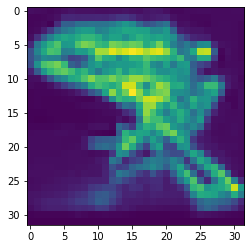

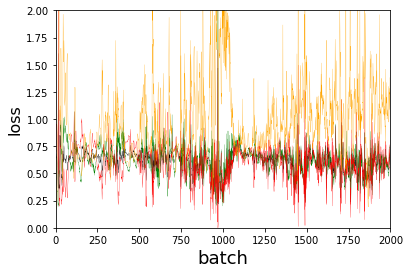

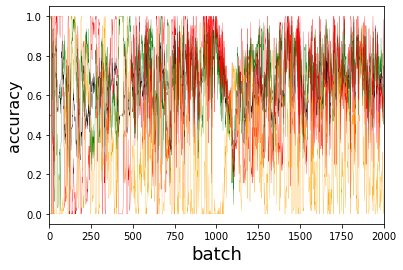

In [4]:
import os
import matplotlib.pyplot as plt


# run params
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'cifar10_frogs'
RUN_FOLDER = 'run_{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #
#mode = 'load'

#(x_train, y_train) = load_safari(DATA_NAME)

x_train.shape

plt.imshow(x_train[200,:,:,0])

gan = GAN(input_dim = (32,32,3)
          #Flatten>DO>Dense(1 sigmoid) nach convs
          #padding=same
          #leaky relu alpha 0.2
          #opt = Adam(lr=0.0002, beta_1=0.5)
          #loss='binary_crossentropy'
        , discriminator_conv_filters = [64,128,128,256]
        , discriminator_conv_kernel_size = [3,3,3,3]
        , discriminator_conv_strides = [1,2,2,2]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'leaky_relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.0002 #0.0008
          
          
        , generator_initial_dense_layer_size = (4,4,256)
        , generator_upsample = [2,2,1,1]
        , generator_conv_filters = [128,128,128,3]
        , generator_conv_kernel_size = [4,4,4,4]
        , generator_conv_strides = [2,2,2,1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0002 #0.0004
        , optimiser = 'adam'
        , z_dim = 100
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

gan.discriminator.summary()

gan.generator.summary()

BATCH_SIZE = 64
EPOCHS = 200 * BATCH_SIZE
PRINT_EVERY_N_BATCHES = BATCH_SIZE * 5

gan.train(
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , using_generator = False
)

fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()

fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "model_4"
_________________________________________________________________
Layer (type)               

C:\Users\Admin\Anaconda3\envs\ml20\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Executing op __inference_keras_scratch_graph_426126 in device /job:localhost/replica:0/task:0/device:GPU:0
0 [D loss: (0.352)(R 0.237, F 0.467)] [D acc: (0.836)(0.875, 0.797)] [G loss: 1.394] [G acc: 0.172]


C:\Users\Admin\Anaconda3\envs\ml20\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: (0.265)(R 0.218, F 0.312)] [D acc: (0.914)(0.922, 0.906)] [G loss: 1.864] [G acc: 0.094]
2 [D loss: (0.369)(R 0.336, F 0.401)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.719] [G acc: 0.094]
3 [D loss: (0.294)(R 0.235, F 0.354)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.017] [G acc: 0.062]
4 [D loss: (0.339)(R 0.436, F 0.242)] [D acc: (0.852)(0.766, 0.938)] [G loss: 1.911] [G acc: 0.047]
5 [D loss: (0.336)(R 0.383, F 0.289)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.003] [G acc: 0.016]
6 [D loss: (0.344)(R 0.336, F 0.353)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.757] [G acc: 0.031]
7 [D loss: (0.253)(R 0.238, F 0.268)] [D acc: (0.930)(0.922, 0.938)] [G loss: 1.733] [G acc: 0.047]
8 [D loss: (0.220)(R 0.215, F 0.224)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.081] [G acc: 0.062]
9 [D loss: (0.287)(R 0.349, F 0.226)] [D acc: (0.875)(0.781, 0.969)] [G loss: 2.042] [G acc: 0.078]
10 [D loss: (0.294)(R 0.180, F 0.407)] [D acc: (0.891)(0.906, 0.875)] [G loss: 2.044] [G acc: 0.016]

83 [D loss: (0.371)(R 0.329, F 0.413)] [D acc: (0.844)(0.875, 0.812)] [G loss: 2.144] [G acc: 0.000]
84 [D loss: (0.391)(R 0.517, F 0.265)] [D acc: (0.859)(0.750, 0.969)] [G loss: 1.943] [G acc: 0.031]
85 [D loss: (0.446)(R 0.521, F 0.370)] [D acc: (0.789)(0.703, 0.875)] [G loss: 1.760] [G acc: 0.125]
86 [D loss: (0.350)(R 0.345, F 0.354)] [D acc: (0.852)(0.844, 0.859)] [G loss: 1.879] [G acc: 0.062]
87 [D loss: (0.390)(R 0.374, F 0.406)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.097] [G acc: 0.047]
88 [D loss: (0.313)(R 0.292, F 0.334)] [D acc: (0.898)(0.906, 0.891)] [G loss: 2.097] [G acc: 0.000]
89 [D loss: (0.326)(R 0.371, F 0.281)] [D acc: (0.875)(0.797, 0.953)] [G loss: 1.890] [G acc: 0.031]
90 [D loss: (0.371)(R 0.444, F 0.298)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.859] [G acc: 0.031]
91 [D loss: (0.384)(R 0.434, F 0.334)] [D acc: (0.828)(0.781, 0.875)] [G loss: 1.782] [G acc: 0.109]
92 [D loss: (0.450)(R 0.511, F 0.390)] [D acc: (0.781)(0.734, 0.828)] [G loss: 1.601] [G ac

164 [D loss: (0.281)(R 0.288, F 0.273)] [D acc: (0.914)(0.906, 0.922)] [G loss: 2.120] [G acc: 0.016]
165 [D loss: (0.326)(R 0.360, F 0.291)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.317] [G acc: 0.016]
166 [D loss: (0.359)(R 0.458, F 0.260)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.035] [G acc: 0.062]
167 [D loss: (0.275)(R 0.265, F 0.285)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.073] [G acc: 0.031]
168 [D loss: (0.291)(R 0.297, F 0.284)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.017] [G acc: 0.047]
169 [D loss: (0.378)(R 0.405, F 0.351)] [D acc: (0.805)(0.750, 0.859)] [G loss: 2.029] [G acc: 0.047]
170 [D loss: (0.307)(R 0.332, F 0.282)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.159] [G acc: 0.031]
171 [D loss: (0.346)(R 0.363, F 0.328)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.498] [G acc: 0.000]
172 [D loss: (0.319)(R 0.361, F 0.276)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.203] [G acc: 0.031]
173 [D loss: (0.292)(R 0.313, F 0.271)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.

245 [D loss: (0.417)(R 0.435, F 0.398)] [D acc: (0.812)(0.734, 0.891)] [G loss: 2.446] [G acc: 0.000]
246 [D loss: (0.314)(R 0.423, F 0.206)] [D acc: (0.867)(0.750, 0.984)] [G loss: 2.132] [G acc: 0.016]
247 [D loss: (0.371)(R 0.433, F 0.310)] [D acc: (0.844)(0.734, 0.953)] [G loss: 1.806] [G acc: 0.078]
248 [D loss: (0.316)(R 0.284, F 0.347)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.156] [G acc: 0.000]
249 [D loss: (0.336)(R 0.336, F 0.335)] [D acc: (0.836)(0.797, 0.875)] [G loss: 1.985] [G acc: 0.094]
250 [D loss: (0.328)(R 0.378, F 0.277)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.037] [G acc: 0.016]
251 [D loss: (0.321)(R 0.346, F 0.297)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.833] [G acc: 0.078]
252 [D loss: (0.312)(R 0.316, F 0.308)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.121] [G acc: 0.016]
253 [D loss: (0.345)(R 0.370, F 0.320)] [D acc: (0.828)(0.797, 0.859)] [G loss: 1.985] [G acc: 0.016]
254 [D loss: (0.376)(R 0.384, F 0.367)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.

327 [D loss: (0.314)(R 0.326, F 0.301)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.761] [G acc: 0.141]
328 [D loss: (0.325)(R 0.303, F 0.348)] [D acc: (0.852)(0.844, 0.859)] [G loss: 1.870] [G acc: 0.031]
329 [D loss: (0.317)(R 0.360, F 0.275)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.064] [G acc: 0.031]
330 [D loss: (0.294)(R 0.271, F 0.317)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.077] [G acc: 0.000]
331 [D loss: (0.364)(R 0.438, F 0.290)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.169] [G acc: 0.016]
332 [D loss: (0.357)(R 0.400, F 0.313)] [D acc: (0.859)(0.797, 0.922)] [G loss: 1.965] [G acc: 0.031]
333 [D loss: (0.362)(R 0.374, F 0.350)] [D acc: (0.805)(0.766, 0.844)] [G loss: 1.984] [G acc: 0.031]
334 [D loss: (0.321)(R 0.348, F 0.294)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.947] [G acc: 0.094]
335 [D loss: (0.310)(R 0.394, F 0.225)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.013] [G acc: 0.031]
336 [D loss: (0.331)(R 0.360, F 0.302)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.

410 [D loss: (0.298)(R 0.338, F 0.257)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.192] [G acc: 0.031]
411 [D loss: (0.416)(R 0.498, F 0.334)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.926] [G acc: 0.094]
412 [D loss: (0.375)(R 0.428, F 0.323)] [D acc: (0.852)(0.812, 0.891)] [G loss: 1.682] [G acc: 0.188]
413 [D loss: (0.320)(R 0.323, F 0.317)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.692] [G acc: 0.250]
414 [D loss: (0.413)(R 0.478, F 0.349)] [D acc: (0.797)(0.750, 0.844)] [G loss: 1.990] [G acc: 0.094]
415 [D loss: (0.356)(R 0.373, F 0.338)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.083] [G acc: 0.047]
416 [D loss: (0.435)(R 0.402, F 0.467)] [D acc: (0.797)(0.766, 0.828)] [G loss: 1.892] [G acc: 0.062]
417 [D loss: (0.407)(R 0.536, F 0.277)] [D acc: (0.797)(0.688, 0.906)] [G loss: 1.905] [G acc: 0.031]
418 [D loss: (0.362)(R 0.469, F 0.255)] [D acc: (0.859)(0.781, 0.938)] [G loss: 1.687] [G acc: 0.109]
419 [D loss: (0.371)(R 0.285, F 0.457)] [D acc: (0.820)(0.844, 0.797)] [G loss: 1.

493 [D loss: (0.377)(R 0.469, F 0.286)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.004] [G acc: 0.094]
494 [D loss: (0.283)(R 0.241, F 0.325)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.186] [G acc: 0.016]
495 [D loss: (0.277)(R 0.293, F 0.261)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.373] [G acc: 0.016]
496 [D loss: (0.363)(R 0.423, F 0.304)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.924] [G acc: 0.078]
497 [D loss: (0.417)(R 0.422, F 0.412)] [D acc: (0.820)(0.781, 0.859)] [G loss: 1.908] [G acc: 0.062]
498 [D loss: (0.385)(R 0.443, F 0.326)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.085] [G acc: 0.047]
499 [D loss: (0.350)(R 0.425, F 0.275)] [D acc: (0.820)(0.719, 0.922)] [G loss: 1.960] [G acc: 0.016]
500 [D loss: (0.310)(R 0.319, F 0.301)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.290] [G acc: 0.078]
501 [D loss: (0.376)(R 0.419, F 0.332)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.924] [G acc: 0.031]
502 [D loss: (0.374)(R 0.379, F 0.369)] [D acc: (0.812)(0.766, 0.859)] [G loss: 2.

575 [D loss: (0.417)(R 0.544, F 0.290)] [D acc: (0.820)(0.703, 0.938)] [G loss: 1.610] [G acc: 0.141]
576 [D loss: (0.351)(R 0.254, F 0.449)] [D acc: (0.820)(0.875, 0.766)] [G loss: 1.999] [G acc: 0.016]
577 [D loss: (0.332)(R 0.398, F 0.266)] [D acc: (0.836)(0.750, 0.922)] [G loss: 1.873] [G acc: 0.047]
578 [D loss: (0.313)(R 0.246, F 0.381)] [D acc: (0.875)(0.875, 0.875)] [G loss: 2.172] [G acc: 0.031]
579 [D loss: (0.325)(R 0.355, F 0.296)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.296] [G acc: 0.000]
580 [D loss: (0.342)(R 0.477, F 0.206)] [D acc: (0.859)(0.750, 0.969)] [G loss: 2.001] [G acc: 0.047]
581 [D loss: (0.464)(R 0.502, F 0.427)] [D acc: (0.773)(0.734, 0.812)] [G loss: 1.869] [G acc: 0.016]
582 [D loss: (0.339)(R 0.399, F 0.279)] [D acc: (0.875)(0.797, 0.953)] [G loss: 1.872] [G acc: 0.047]
583 [D loss: (0.321)(R 0.342, F 0.301)] [D acc: (0.875)(0.797, 0.953)] [G loss: 1.738] [G acc: 0.031]
584 [D loss: (0.360)(R 0.426, F 0.293)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.

656 [D loss: (0.338)(R 0.433, F 0.242)] [D acc: (0.859)(0.781, 0.938)] [G loss: 1.842] [G acc: 0.031]
657 [D loss: (0.448)(R 0.464, F 0.433)] [D acc: (0.797)(0.797, 0.797)] [G loss: 2.010] [G acc: 0.016]
658 [D loss: (0.341)(R 0.381, F 0.301)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.025] [G acc: 0.156]
659 [D loss: (0.288)(R 0.334, F 0.243)] [D acc: (0.914)(0.844, 0.984)] [G loss: 2.119] [G acc: 0.047]
660 [D loss: (0.325)(R 0.360, F 0.290)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.001] [G acc: 0.016]
661 [D loss: (0.354)(R 0.359, F 0.349)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.077] [G acc: 0.047]
662 [D loss: (0.292)(R 0.318, F 0.266)] [D acc: (0.914)(0.859, 0.969)] [G loss: 1.968] [G acc: 0.047]
663 [D loss: (0.444)(R 0.493, F 0.394)] [D acc: (0.773)(0.719, 0.828)] [G loss: 2.123] [G acc: 0.031]
664 [D loss: (0.336)(R 0.376, F 0.295)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.184] [G acc: 0.016]
665 [D loss: (0.245)(R 0.287, F 0.203)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.

736 [D loss: (0.347)(R 0.399, F 0.296)] [D acc: (0.867)(0.766, 0.969)] [G loss: 1.848] [G acc: 0.047]
737 [D loss: (0.258)(R 0.184, F 0.333)] [D acc: (0.922)(0.922, 0.922)] [G loss: 2.131] [G acc: 0.031]
738 [D loss: (0.341)(R 0.357, F 0.326)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.077] [G acc: 0.016]
739 [D loss: (0.315)(R 0.302, F 0.327)] [D acc: (0.867)(0.828, 0.906)] [G loss: 1.885] [G acc: 0.031]
740 [D loss: (0.258)(R 0.270, F 0.247)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.072] [G acc: 0.031]
741 [D loss: (0.249)(R 0.265, F 0.232)] [D acc: (0.898)(0.828, 0.969)] [G loss: 1.944] [G acc: 0.094]
742 [D loss: (0.319)(R 0.373, F 0.265)] [D acc: (0.844)(0.750, 0.938)] [G loss: 1.866] [G acc: 0.078]
743 [D loss: (0.353)(R 0.351, F 0.355)] [D acc: (0.836)(0.812, 0.859)] [G loss: 1.956] [G acc: 0.078]
744 [D loss: (0.223)(R 0.221, F 0.225)] [D acc: (0.953)(0.938, 0.969)] [G loss: 2.178] [G acc: 0.047]
745 [D loss: (0.265)(R 0.299, F 0.231)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.

817 [D loss: (0.352)(R 0.393, F 0.311)] [D acc: (0.867)(0.766, 0.969)] [G loss: 1.838] [G acc: 0.078]
818 [D loss: (0.398)(R 0.426, F 0.369)] [D acc: (0.812)(0.750, 0.875)] [G loss: 1.882] [G acc: 0.078]
819 [D loss: (0.398)(R 0.378, F 0.417)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.059] [G acc: 0.047]
820 [D loss: (0.340)(R 0.405, F 0.276)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.232] [G acc: 0.031]
821 [D loss: (0.334)(R 0.310, F 0.358)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.162] [G acc: 0.031]
822 [D loss: (0.325)(R 0.395, F 0.256)] [D acc: (0.875)(0.781, 0.969)] [G loss: 2.213] [G acc: 0.016]
823 [D loss: (0.317)(R 0.368, F 0.266)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.029] [G acc: 0.031]
824 [D loss: (0.343)(R 0.333, F 0.353)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.030] [G acc: 0.047]
825 [D loss: (0.316)(R 0.314, F 0.317)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.329] [G acc: 0.078]
826 [D loss: (0.363)(R 0.499, F 0.226)] [D acc: (0.859)(0.750, 0.969)] [G loss: 1.

898 [D loss: (0.294)(R 0.305, F 0.283)] [D acc: (0.891)(0.844, 0.938)] [G loss: 1.957] [G acc: 0.047]
899 [D loss: (0.324)(R 0.334, F 0.315)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.046] [G acc: 0.062]
900 [D loss: (0.317)(R 0.282, F 0.352)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.217] [G acc: 0.062]
901 [D loss: (0.512)(R 0.579, F 0.446)] [D acc: (0.727)(0.656, 0.797)] [G loss: 2.200] [G acc: 0.062]
902 [D loss: (0.255)(R 0.299, F 0.212)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.278] [G acc: 0.000]
903 [D loss: (0.350)(R 0.425, F 0.275)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.100] [G acc: 0.047]
904 [D loss: (0.326)(R 0.368, F 0.284)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.225] [G acc: 0.047]
905 [D loss: (0.312)(R 0.353, F 0.271)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.025] [G acc: 0.031]
906 [D loss: (0.307)(R 0.371, F 0.242)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.024] [G acc: 0.016]
907 [D loss: (0.364)(R 0.414, F 0.315)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.

980 [D loss: (0.323)(R 0.296, F 0.350)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.634] [G acc: 0.000]
981 [D loss: (0.276)(R 0.352, F 0.201)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.556] [G acc: 0.000]
982 [D loss: (0.349)(R 0.368, F 0.330)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.917] [G acc: 0.078]
983 [D loss: (0.425)(R 0.529, F 0.321)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.199] [G acc: 0.047]
984 [D loss: (0.283)(R 0.334, F 0.232)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.152] [G acc: 0.031]
985 [D loss: (0.391)(R 0.379, F 0.403)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.356] [G acc: 0.047]
986 [D loss: (0.276)(R 0.264, F 0.287)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.151] [G acc: 0.078]
987 [D loss: (0.347)(R 0.410, F 0.283)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.286] [G acc: 0.047]
988 [D loss: (0.313)(R 0.389, F 0.237)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.134] [G acc: 0.016]
989 [D loss: (0.317)(R 0.302, F 0.332)] [D acc: (0.852)(0.797, 0.906)] [G loss: 1.

1060 [D loss: (0.294)(R 0.329, F 0.260)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.055] [G acc: 0.031]
1061 [D loss: (0.295)(R 0.315, F 0.276)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.377] [G acc: 0.016]
1062 [D loss: (0.449)(R 0.495, F 0.403)] [D acc: (0.766)(0.703, 0.828)] [G loss: 2.198] [G acc: 0.000]
1063 [D loss: (0.331)(R 0.357, F 0.305)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.347] [G acc: 0.047]
1064 [D loss: (0.415)(R 0.531, F 0.299)] [D acc: (0.797)(0.672, 0.922)] [G loss: 1.913] [G acc: 0.031]
1065 [D loss: (0.424)(R 0.457, F 0.391)] [D acc: (0.781)(0.719, 0.844)] [G loss: 2.408] [G acc: 0.062]
1066 [D loss: (0.288)(R 0.263, F 0.314)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.128] [G acc: 0.062]
1067 [D loss: (0.375)(R 0.398, F 0.353)] [D acc: (0.844)(0.859, 0.828)] [G loss: 2.120] [G acc: 0.031]
1068 [D loss: (0.287)(R 0.355, F 0.219)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.196] [G acc: 0.016]
1069 [D loss: (0.375)(R 0.444, F 0.306)] [D acc: (0.805)(0.719, 0.891)] [

1141 [D loss: (0.392)(R 0.486, F 0.299)] [D acc: (0.789)(0.688, 0.891)] [G loss: 1.965] [G acc: 0.031]
1142 [D loss: (0.335)(R 0.325, F 0.344)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.307] [G acc: 0.031]
1143 [D loss: (0.350)(R 0.431, F 0.270)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.161] [G acc: 0.047]
1144 [D loss: (0.297)(R 0.351, F 0.243)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.188] [G acc: 0.031]
1145 [D loss: (0.303)(R 0.349, F 0.256)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.149] [G acc: 0.031]
1146 [D loss: (0.380)(R 0.463, F 0.297)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.210] [G acc: 0.047]
1147 [D loss: (0.317)(R 0.346, F 0.287)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.092] [G acc: 0.031]
1148 [D loss: (0.219)(R 0.219, F 0.219)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.286] [G acc: 0.062]
1149 [D loss: (0.302)(R 0.319, F 0.285)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.448] [G acc: 0.016]
1150 [D loss: (0.316)(R 0.427, F 0.205)] [D acc: (0.914)(0.828, 1.000)] [

1222 [D loss: (0.331)(R 0.469, F 0.192)] [D acc: (0.867)(0.750, 0.984)] [G loss: 2.322] [G acc: 0.016]
1223 [D loss: (0.284)(R 0.250, F 0.317)] [D acc: (0.875)(0.875, 0.875)] [G loss: 2.321] [G acc: 0.000]
1224 [D loss: (0.288)(R 0.375, F 0.200)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.287] [G acc: 0.016]
1225 [D loss: (0.372)(R 0.458, F 0.287)] [D acc: (0.828)(0.734, 0.922)] [G loss: 2.130] [G acc: 0.016]
1226 [D loss: (0.306)(R 0.303, F 0.309)] [D acc: (0.875)(0.859, 0.891)] [G loss: 1.978] [G acc: 0.125]
1227 [D loss: (0.369)(R 0.384, F 0.354)] [D acc: (0.828)(0.797, 0.859)] [G loss: 1.853] [G acc: 0.109]
1228 [D loss: (0.442)(R 0.567, F 0.317)] [D acc: (0.812)(0.703, 0.922)] [G loss: 1.786] [G acc: 0.172]
1229 [D loss: (0.279)(R 0.307, F 0.250)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.155] [G acc: 0.047]
1230 [D loss: (0.399)(R 0.459, F 0.339)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.066] [G acc: 0.047]
1231 [D loss: (0.332)(R 0.391, F 0.274)] [D acc: (0.898)(0.828, 0.969)] [

1302 [D loss: (0.319)(R 0.332, F 0.305)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.034] [G acc: 0.031]
1303 [D loss: (0.438)(R 0.492, F 0.384)] [D acc: (0.812)(0.719, 0.906)] [G loss: 2.033] [G acc: 0.031]
1304 [D loss: (0.302)(R 0.377, F 0.227)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.924] [G acc: 0.031]
1305 [D loss: (0.418)(R 0.477, F 0.359)] [D acc: (0.805)(0.766, 0.844)] [G loss: 1.964] [G acc: 0.016]
1306 [D loss: (0.369)(R 0.427, F 0.311)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.901] [G acc: 0.047]
1307 [D loss: (0.253)(R 0.253, F 0.253)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.220] [G acc: 0.031]
1308 [D loss: (0.271)(R 0.339, F 0.203)] [D acc: (0.906)(0.828, 0.984)] [G loss: 1.846] [G acc: 0.047]
1309 [D loss: (0.237)(R 0.160, F 0.315)] [D acc: (0.938)(0.906, 0.969)] [G loss: 2.037] [G acc: 0.016]
1310 [D loss: (0.275)(R 0.325, F 0.225)] [D acc: (0.898)(0.859, 0.938)] [G loss: 1.894] [G acc: 0.000]
1311 [D loss: (0.286)(R 0.349, F 0.223)] [D acc: (0.867)(0.797, 0.938)] [

1383 [D loss: (0.352)(R 0.463, F 0.242)] [D acc: (0.836)(0.719, 0.953)] [G loss: 2.160] [G acc: 0.047]
1384 [D loss: (0.382)(R 0.376, F 0.387)] [D acc: (0.789)(0.766, 0.812)] [G loss: 2.228] [G acc: 0.016]
1385 [D loss: (0.244)(R 0.266, F 0.222)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.172] [G acc: 0.031]
1386 [D loss: (0.268)(R 0.263, F 0.274)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.078] [G acc: 0.016]
1387 [D loss: (0.401)(R 0.409, F 0.392)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.197] [G acc: 0.031]
1388 [D loss: (0.338)(R 0.414, F 0.262)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.481] [G acc: 0.047]
1389 [D loss: (0.233)(R 0.272, F 0.194)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.177] [G acc: 0.031]
1390 [D loss: (0.371)(R 0.389, F 0.352)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.157] [G acc: 0.047]
1391 [D loss: (0.376)(R 0.454, F 0.298)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.140] [G acc: 0.109]
1392 [D loss: (0.295)(R 0.318, F 0.273)] [D acc: (0.875)(0.797, 0.953)] [

1464 [D loss: (0.446)(R 0.572, F 0.319)] [D acc: (0.789)(0.688, 0.891)] [G loss: 2.325] [G acc: 0.094]
1465 [D loss: (0.404)(R 0.502, F 0.305)] [D acc: (0.828)(0.750, 0.906)] [G loss: 2.011] [G acc: 0.094]
1466 [D loss: (0.319)(R 0.287, F 0.352)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.356] [G acc: 0.125]
1467 [D loss: (0.360)(R 0.451, F 0.269)] [D acc: (0.828)(0.719, 0.938)] [G loss: 2.247] [G acc: 0.141]
1468 [D loss: (0.319)(R 0.310, F 0.328)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.349] [G acc: 0.109]
1469 [D loss: (0.329)(R 0.422, F 0.235)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.217] [G acc: 0.062]
1470 [D loss: (0.425)(R 0.419, F 0.431)] [D acc: (0.805)(0.812, 0.797)] [G loss: 2.445] [G acc: 0.047]
1471 [D loss: (0.436)(R 0.394, F 0.479)] [D acc: (0.766)(0.797, 0.734)] [G loss: 2.599] [G acc: 0.000]
1472 [D loss: (0.341)(R 0.414, F 0.268)] [D acc: (0.828)(0.750, 0.906)] [G loss: 2.326] [G acc: 0.031]
1473 [D loss: (0.375)(R 0.430, F 0.320)] [D acc: (0.820)(0.766, 0.875)] [

1545 [D loss: (0.412)(R 0.445, F 0.380)] [D acc: (0.781)(0.734, 0.828)] [G loss: 2.211] [G acc: 0.031]
1546 [D loss: (0.313)(R 0.417, F 0.209)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.240] [G acc: 0.016]
1547 [D loss: (0.371)(R 0.433, F 0.308)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.164] [G acc: 0.047]
1548 [D loss: (0.380)(R 0.436, F 0.323)] [D acc: (0.820)(0.750, 0.891)] [G loss: 2.197] [G acc: 0.016]
1549 [D loss: (0.288)(R 0.336, F 0.240)] [D acc: (0.898)(0.828, 0.969)] [G loss: 1.902] [G acc: 0.062]
1550 [D loss: (0.392)(R 0.420, F 0.363)] [D acc: (0.797)(0.750, 0.844)] [G loss: 1.930] [G acc: 0.094]
1551 [D loss: (0.298)(R 0.279, F 0.316)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.318] [G acc: 0.031]
1552 [D loss: (0.335)(R 0.391, F 0.280)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.215] [G acc: 0.031]
1553 [D loss: (0.400)(R 0.450, F 0.350)] [D acc: (0.797)(0.734, 0.859)] [G loss: 2.004] [G acc: 0.047]
1554 [D loss: (0.304)(R 0.338, F 0.270)] [D acc: (0.883)(0.844, 0.922)] [

1625 [D loss: (0.271)(R 0.333, F 0.208)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.223] [G acc: 0.031]
1626 [D loss: (0.342)(R 0.349, F 0.334)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.266] [G acc: 0.047]
1627 [D loss: (0.289)(R 0.346, F 0.232)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.305] [G acc: 0.062]
1628 [D loss: (0.309)(R 0.328, F 0.290)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.325] [G acc: 0.062]
1629 [D loss: (0.342)(R 0.435, F 0.250)] [D acc: (0.844)(0.734, 0.953)] [G loss: 2.087] [G acc: 0.141]
1630 [D loss: (0.383)(R 0.333, F 0.432)] [D acc: (0.820)(0.812, 0.828)] [G loss: 2.551] [G acc: 0.016]
1631 [D loss: (0.268)(R 0.329, F 0.207)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.531] [G acc: 0.000]
1632 [D loss: (0.366)(R 0.434, F 0.297)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.966] [G acc: 0.047]
1633 [D loss: (0.334)(R 0.332, F 0.337)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.376] [G acc: 0.047]
1634 [D loss: (0.183)(R 0.212, F 0.155)] [D acc: (0.930)(0.875, 0.984)] [

1705 [D loss: (0.347)(R 0.394, F 0.300)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.990] [G acc: 0.000]
1706 [D loss: (0.384)(R 0.412, F 0.356)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.066] [G acc: 0.031]
1707 [D loss: (0.422)(R 0.473, F 0.370)] [D acc: (0.828)(0.781, 0.875)] [G loss: 1.809] [G acc: 0.062]
1708 [D loss: (0.318)(R 0.351, F 0.284)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.015] [G acc: 0.016]
1709 [D loss: (0.380)(R 0.415, F 0.345)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.109] [G acc: 0.031]
1710 [D loss: (0.260)(R 0.294, F 0.226)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.076] [G acc: 0.031]
1711 [D loss: (0.362)(R 0.443, F 0.280)] [D acc: (0.859)(0.750, 0.969)] [G loss: 2.154] [G acc: 0.016]
1712 [D loss: (0.326)(R 0.331, F 0.321)] [D acc: (0.859)(0.844, 0.875)] [G loss: 1.904] [G acc: 0.016]
1713 [D loss: (0.328)(R 0.291, F 0.364)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.150] [G acc: 0.047]
1714 [D loss: (0.313)(R 0.407, F 0.219)] [D acc: (0.867)(0.781, 0.953)] [

1786 [D loss: (0.307)(R 0.338, F 0.275)] [D acc: (0.859)(0.781, 0.938)] [G loss: 1.793] [G acc: 0.031]
1787 [D loss: (0.351)(R 0.398, F 0.303)] [D acc: (0.875)(0.781, 0.969)] [G loss: 1.844] [G acc: 0.000]
1788 [D loss: (0.278)(R 0.249, F 0.307)] [D acc: (0.898)(0.891, 0.906)] [G loss: 2.035] [G acc: 0.031]
1789 [D loss: (0.232)(R 0.182, F 0.282)] [D acc: (0.938)(0.969, 0.906)] [G loss: 2.143] [G acc: 0.031]
1790 [D loss: (0.292)(R 0.362, F 0.223)] [D acc: (0.883)(0.812, 0.953)] [G loss: 1.879] [G acc: 0.141]
1791 [D loss: (0.339)(R 0.426, F 0.253)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.051] [G acc: 0.000]
1792 [D loss: (0.318)(R 0.301, F 0.335)] [D acc: (0.859)(0.812, 0.906)] [G loss: 1.728] [G acc: 0.047]
1793 [D loss: (0.367)(R 0.330, F 0.404)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.185] [G acc: 0.016]
1794 [D loss: (0.296)(R 0.364, F 0.228)] [D acc: (0.867)(0.766, 0.969)] [G loss: 2.243] [G acc: 0.016]
1795 [D loss: (0.355)(R 0.405, F 0.305)] [D acc: (0.867)(0.812, 0.922)] [

1867 [D loss: (0.350)(R 0.328, F 0.372)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.007] [G acc: 0.000]
1868 [D loss: (0.295)(R 0.369, F 0.221)] [D acc: (0.867)(0.766, 0.969)] [G loss: 2.098] [G acc: 0.016]
1869 [D loss: (0.428)(R 0.512, F 0.345)] [D acc: (0.812)(0.734, 0.891)] [G loss: 1.723] [G acc: 0.078]
1870 [D loss: (0.284)(R 0.291, F 0.278)] [D acc: (0.875)(0.797, 0.953)] [G loss: 1.971] [G acc: 0.078]
1871 [D loss: (0.322)(R 0.270, F 0.375)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.087] [G acc: 0.031]
1872 [D loss: (0.309)(R 0.329, F 0.289)] [D acc: (0.836)(0.812, 0.859)] [G loss: 2.354] [G acc: 0.062]
1873 [D loss: (0.358)(R 0.448, F 0.267)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.004] [G acc: 0.062]
1874 [D loss: (0.311)(R 0.371, F 0.251)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.014] [G acc: 0.094]
1875 [D loss: (0.337)(R 0.371, F 0.303)] [D acc: (0.867)(0.781, 0.953)] [G loss: 1.961] [G acc: 0.000]
1876 [D loss: (0.371)(R 0.524, F 0.218)] [D acc: (0.836)(0.688, 0.984)] [

1948 [D loss: (0.290)(R 0.373, F 0.207)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.269] [G acc: 0.016]
1949 [D loss: (0.299)(R 0.293, F 0.306)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.291] [G acc: 0.062]
1950 [D loss: (0.274)(R 0.260, F 0.288)] [D acc: (0.914)(0.906, 0.922)] [G loss: 2.634] [G acc: 0.031]
1951 [D loss: (0.296)(R 0.348, F 0.244)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.353] [G acc: 0.047]
1952 [D loss: (0.379)(R 0.396, F 0.362)] [D acc: (0.828)(0.844, 0.812)] [G loss: 2.169] [G acc: 0.016]
1953 [D loss: (0.362)(R 0.452, F 0.271)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.339] [G acc: 0.047]
1954 [D loss: (0.480)(R 0.585, F 0.376)] [D acc: (0.773)(0.688, 0.859)] [G loss: 1.901] [G acc: 0.047]
1955 [D loss: (0.359)(R 0.335, F 0.383)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.163] [G acc: 0.062]
1956 [D loss: (0.386)(R 0.440, F 0.332)] [D acc: (0.789)(0.703, 0.875)] [G loss: 2.037] [G acc: 0.031]
1957 [D loss: (0.354)(R 0.359, F 0.349)] [D acc: (0.852)(0.812, 0.891)] [

2030 [D loss: (0.332)(R 0.418, F 0.247)] [D acc: (0.859)(0.781, 0.938)] [G loss: 1.942] [G acc: 0.016]
2031 [D loss: (0.312)(R 0.350, F 0.274)] [D acc: (0.875)(0.844, 0.906)] [G loss: 1.906] [G acc: 0.031]
2032 [D loss: (0.317)(R 0.253, F 0.381)] [D acc: (0.859)(0.875, 0.844)] [G loss: 2.198] [G acc: 0.000]
2033 [D loss: (0.317)(R 0.407, F 0.227)] [D acc: (0.891)(0.781, 1.000)] [G loss: 2.272] [G acc: 0.031]
2034 [D loss: (0.276)(R 0.256, F 0.295)] [D acc: (0.891)(0.906, 0.875)] [G loss: 2.210] [G acc: 0.062]
2035 [D loss: (0.359)(R 0.511, F 0.208)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.211] [G acc: 0.031]
2036 [D loss: (0.351)(R 0.431, F 0.271)] [D acc: (0.828)(0.734, 0.922)] [G loss: 3.144] [G acc: 0.047]
2037 [D loss: (0.380)(R 0.387, F 0.373)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.329] [G acc: 0.016]
2038 [D loss: (0.331)(R 0.434, F 0.229)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.238] [G acc: 0.000]
2039 [D loss: (0.285)(R 0.282, F 0.288)] [D acc: (0.914)(0.875, 0.953)] [

2111 [D loss: (0.376)(R 0.434, F 0.319)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.081] [G acc: 0.078]
2112 [D loss: (0.350)(R 0.397, F 0.302)] [D acc: (0.828)(0.766, 0.891)] [G loss: 1.976] [G acc: 0.062]
2113 [D loss: (0.482)(R 0.423, F 0.541)] [D acc: (0.773)(0.750, 0.797)] [G loss: 2.134] [G acc: 0.031]
2114 [D loss: (0.285)(R 0.342, F 0.229)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.231] [G acc: 0.031]
2115 [D loss: (0.384)(R 0.439, F 0.330)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.307] [G acc: 0.016]
2116 [D loss: (0.372)(R 0.407, F 0.337)] [D acc: (0.820)(0.703, 0.938)] [G loss: 2.321] [G acc: 0.047]
2117 [D loss: (0.412)(R 0.484, F 0.340)] [D acc: (0.781)(0.734, 0.828)] [G loss: 2.099] [G acc: 0.047]
2118 [D loss: (0.301)(R 0.239, F 0.364)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.322] [G acc: 0.062]
2119 [D loss: (0.307)(R 0.403, F 0.211)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.224] [G acc: 0.031]
2120 [D loss: (0.343)(R 0.387, F 0.298)] [D acc: (0.859)(0.844, 0.875)] [

2191 [D loss: (0.323)(R 0.333, F 0.313)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.159] [G acc: 0.047]
2192 [D loss: (0.316)(R 0.354, F 0.279)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.840] [G acc: 0.062]
2193 [D loss: (0.286)(R 0.303, F 0.270)] [D acc: (0.891)(0.859, 0.922)] [G loss: 1.958] [G acc: 0.031]
2194 [D loss: (0.338)(R 0.409, F 0.266)] [D acc: (0.883)(0.797, 0.969)] [G loss: 1.857] [G acc: 0.078]
2195 [D loss: (0.389)(R 0.473, F 0.305)] [D acc: (0.859)(0.766, 0.953)] [G loss: 1.894] [G acc: 0.078]
2196 [D loss: (0.280)(R 0.230, F 0.330)] [D acc: (0.898)(0.891, 0.906)] [G loss: 2.054] [G acc: 0.031]
2197 [D loss: (0.306)(R 0.387, F 0.225)] [D acc: (0.883)(0.781, 0.984)] [G loss: 2.025] [G acc: 0.031]
2198 [D loss: (0.344)(R 0.403, F 0.285)] [D acc: (0.875)(0.781, 0.969)] [G loss: 1.938] [G acc: 0.062]
2199 [D loss: (0.369)(R 0.341, F 0.398)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.896] [G acc: 0.062]
2200 [D loss: (0.292)(R 0.245, F 0.340)] [D acc: (0.906)(0.906, 0.906)] [

2271 [D loss: (0.363)(R 0.458, F 0.268)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.694] [G acc: 0.078]
2272 [D loss: (0.335)(R 0.327, F 0.343)] [D acc: (0.883)(0.859, 0.906)] [G loss: 3.110] [G acc: 0.031]
2273 [D loss: (0.321)(R 0.296, F 0.346)] [D acc: (0.875)(0.859, 0.891)] [G loss: 3.089] [G acc: 0.016]
2274 [D loss: (0.241)(R 0.292, F 0.191)] [D acc: (0.930)(0.875, 0.984)] [G loss: 3.093] [G acc: 0.016]
2275 [D loss: (0.328)(R 0.429, F 0.227)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.743] [G acc: 0.062]
2276 [D loss: (0.289)(R 0.242, F 0.336)] [D acc: (0.891)(0.875, 0.906)] [G loss: 3.311] [G acc: 0.047]
2277 [D loss: (0.358)(R 0.397, F 0.318)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.973] [G acc: 0.000]
2278 [D loss: (0.311)(R 0.279, F 0.343)] [D acc: (0.836)(0.844, 0.828)] [G loss: 3.898] [G acc: 0.031]
2279 [D loss: (0.341)(R 0.412, F 0.270)] [D acc: (0.844)(0.812, 0.875)] [G loss: 3.261] [G acc: 0.078]
2280 [D loss: (0.327)(R 0.379, F 0.274)] [D acc: (0.852)(0.781, 0.922)] [

2352 [D loss: (0.441)(R 0.500, F 0.382)] [D acc: (0.797)(0.734, 0.859)] [G loss: 2.332] [G acc: 0.016]
2353 [D loss: (0.312)(R 0.350, F 0.273)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.128] [G acc: 0.047]
2354 [D loss: (0.306)(R 0.367, F 0.245)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.192] [G acc: 0.078]
2355 [D loss: (0.317)(R 0.381, F 0.252)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.162] [G acc: 0.094]
2356 [D loss: (0.288)(R 0.208, F 0.368)] [D acc: (0.891)(0.922, 0.859)] [G loss: 2.418] [G acc: 0.062]
2357 [D loss: (0.242)(R 0.290, F 0.195)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.596] [G acc: 0.031]
2358 [D loss: (0.378)(R 0.495, F 0.262)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.213] [G acc: 0.047]
2359 [D loss: (0.309)(R 0.301, F 0.318)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.137] [G acc: 0.109]
2360 [D loss: (0.302)(R 0.299, F 0.306)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.395] [G acc: 0.078]
2361 [D loss: (0.323)(R 0.385, F 0.261)] [D acc: (0.844)(0.797, 0.891)] [

2432 [D loss: (0.495)(R 0.484, F 0.505)] [D acc: (0.734)(0.672, 0.797)] [G loss: 1.777] [G acc: 0.062]
2433 [D loss: (0.408)(R 0.404, F 0.413)] [D acc: (0.820)(0.812, 0.828)] [G loss: 1.859] [G acc: 0.016]
2434 [D loss: (0.277)(R 0.293, F 0.261)] [D acc: (0.914)(0.844, 0.984)] [G loss: 1.880] [G acc: 0.062]
2435 [D loss: (0.340)(R 0.328, F 0.352)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.199] [G acc: 0.016]
2436 [D loss: (0.398)(R 0.460, F 0.337)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.108] [G acc: 0.031]
2437 [D loss: (0.358)(R 0.389, F 0.327)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.153] [G acc: 0.047]
2438 [D loss: (0.528)(R 0.663, F 0.393)] [D acc: (0.789)(0.719, 0.859)] [G loss: 1.960] [G acc: 0.078]
2439 [D loss: (0.222)(R 0.218, F 0.225)] [D acc: (0.938)(0.922, 0.953)] [G loss: 2.099] [G acc: 0.000]
2440 [D loss: (0.255)(R 0.264, F 0.247)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.075] [G acc: 0.016]
2441 [D loss: (0.298)(R 0.375, F 0.222)] [D acc: (0.867)(0.781, 0.953)] [

2513 [D loss: (0.304)(R 0.353, F 0.255)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.270] [G acc: 0.016]
2514 [D loss: (0.330)(R 0.362, F 0.299)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.242] [G acc: 0.031]
2515 [D loss: (0.348)(R 0.429, F 0.267)] [D acc: (0.828)(0.734, 0.922)] [G loss: 2.204] [G acc: 0.047]
2516 [D loss: (0.291)(R 0.305, F 0.277)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.347] [G acc: 0.047]
2517 [D loss: (0.393)(R 0.362, F 0.425)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.262] [G acc: 0.016]
2518 [D loss: (0.304)(R 0.395, F 0.214)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.337] [G acc: 0.000]
2519 [D loss: (0.415)(R 0.458, F 0.373)] [D acc: (0.805)(0.750, 0.859)] [G loss: 2.425] [G acc: 0.016]
2520 [D loss: (0.302)(R 0.318, F 0.286)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.304] [G acc: 0.031]
2521 [D loss: (0.391)(R 0.441, F 0.341)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.151] [G acc: 0.016]
2522 [D loss: (0.350)(R 0.441, F 0.258)] [D acc: (0.852)(0.766, 0.938)] [

2595 [D loss: (0.370)(R 0.389, F 0.351)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.056] [G acc: 0.000]
2596 [D loss: (0.299)(R 0.284, F 0.314)] [D acc: (0.859)(0.859, 0.859)] [G loss: 2.191] [G acc: 0.000]
2597 [D loss: (0.363)(R 0.436, F 0.291)] [D acc: (0.828)(0.750, 0.906)] [G loss: 1.986] [G acc: 0.031]
2598 [D loss: (0.360)(R 0.390, F 0.331)] [D acc: (0.852)(0.812, 0.891)] [G loss: 1.958] [G acc: 0.016]
2599 [D loss: (0.355)(R 0.390, F 0.320)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.030] [G acc: 0.094]
2600 [D loss: (0.295)(R 0.337, F 0.254)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.040] [G acc: 0.094]
2601 [D loss: (0.367)(R 0.399, F 0.334)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.995] [G acc: 0.047]
2602 [D loss: (0.445)(R 0.517, F 0.373)] [D acc: (0.805)(0.750, 0.859)] [G loss: 2.025] [G acc: 0.078]
2603 [D loss: (0.409)(R 0.469, F 0.348)] [D acc: (0.805)(0.766, 0.844)] [G loss: 2.138] [G acc: 0.062]
2604 [D loss: (0.407)(R 0.556, F 0.258)] [D acc: (0.844)(0.734, 0.953)] [

2676 [D loss: (0.361)(R 0.405, F 0.316)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.220] [G acc: 0.016]
2677 [D loss: (0.415)(R 0.474, F 0.356)] [D acc: (0.766)(0.672, 0.859)] [G loss: 2.170] [G acc: 0.016]
2678 [D loss: (0.298)(R 0.314, F 0.281)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.326] [G acc: 0.031]
2679 [D loss: (0.419)(R 0.491, F 0.347)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.065] [G acc: 0.016]
2680 [D loss: (0.311)(R 0.384, F 0.238)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.108] [G acc: 0.016]
2681 [D loss: (0.299)(R 0.323, F 0.275)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.283] [G acc: 0.031]
2682 [D loss: (0.284)(R 0.326, F 0.241)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.153] [G acc: 0.031]
2683 [D loss: (0.272)(R 0.307, F 0.238)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.322] [G acc: 0.016]
2684 [D loss: (0.255)(R 0.302, F 0.209)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.328] [G acc: 0.047]
2685 [D loss: (0.245)(R 0.262, F 0.228)] [D acc: (0.891)(0.859, 0.922)] [

2757 [D loss: (0.340)(R 0.346, F 0.334)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.524] [G acc: 0.047]
2758 [D loss: (0.196)(R 0.212, F 0.181)] [D acc: (0.938)(0.906, 0.969)] [G loss: 2.895] [G acc: 0.016]
2759 [D loss: (0.339)(R 0.490, F 0.188)] [D acc: (0.875)(0.781, 0.969)] [G loss: 2.450] [G acc: 0.047]
2760 [D loss: (0.384)(R 0.422, F 0.345)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.985] [G acc: 0.016]
2761 [D loss: (0.238)(R 0.230, F 0.247)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.316] [G acc: 0.000]
2762 [D loss: (0.356)(R 0.405, F 0.307)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.295] [G acc: 0.062]
2763 [D loss: (0.325)(R 0.366, F 0.283)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.178] [G acc: 0.047]
2764 [D loss: (0.292)(R 0.351, F 0.233)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.033] [G acc: 0.047]
2765 [D loss: (0.355)(R 0.295, F 0.414)] [D acc: (0.820)(0.859, 0.781)] [G loss: 3.048] [G acc: 0.016]
2766 [D loss: (0.281)(R 0.381, F 0.181)] [D acc: (0.906)(0.812, 1.000)] [

2838 [D loss: (0.444)(R 0.546, F 0.342)] [D acc: (0.797)(0.750, 0.844)] [G loss: 2.534] [G acc: 0.047]
2839 [D loss: (0.304)(R 0.339, F 0.269)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.432] [G acc: 0.047]
2840 [D loss: (0.375)(R 0.486, F 0.264)] [D acc: (0.828)(0.719, 0.938)] [G loss: 2.211] [G acc: 0.031]
2841 [D loss: (0.338)(R 0.347, F 0.329)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.043] [G acc: 0.062]
2842 [D loss: (0.340)(R 0.342, F 0.338)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.396] [G acc: 0.000]
2843 [D loss: (0.413)(R 0.471, F 0.354)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.604] [G acc: 0.000]
2844 [D loss: (0.328)(R 0.423, F 0.234)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.944] [G acc: 0.000]
2845 [D loss: (0.283)(R 0.339, F 0.227)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.616] [G acc: 0.031]
2846 [D loss: (0.328)(R 0.382, F 0.274)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.304] [G acc: 0.047]
2847 [D loss: (0.295)(R 0.352, F 0.237)] [D acc: (0.875)(0.828, 0.922)] [

2920 [D loss: (0.380)(R 0.507, F 0.253)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.494] [G acc: 0.078]
2921 [D loss: (0.348)(R 0.298, F 0.398)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.440] [G acc: 0.078]
2922 [D loss: (0.436)(R 0.548, F 0.324)] [D acc: (0.820)(0.719, 0.922)] [G loss: 2.297] [G acc: 0.016]
2923 [D loss: (0.337)(R 0.430, F 0.244)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.056] [G acc: 0.078]
2924 [D loss: (0.313)(R 0.318, F 0.307)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.193] [G acc: 0.016]
2925 [D loss: (0.326)(R 0.407, F 0.245)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.303] [G acc: 0.016]
2926 [D loss: (0.309)(R 0.340, F 0.278)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.216] [G acc: 0.031]
2927 [D loss: (0.300)(R 0.366, F 0.234)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.360] [G acc: 0.031]
2928 [D loss: (0.234)(R 0.176, F 0.292)] [D acc: (0.930)(0.953, 0.906)] [G loss: 2.427] [G acc: 0.016]
2929 [D loss: (0.375)(R 0.519, F 0.231)] [D acc: (0.867)(0.797, 0.938)] [

3000 [D loss: (0.340)(R 0.326, F 0.353)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.157] [G acc: 0.031]
3001 [D loss: (0.510)(R 0.631, F 0.388)] [D acc: (0.727)(0.625, 0.828)] [G loss: 2.053] [G acc: 0.031]
3002 [D loss: (0.337)(R 0.307, F 0.367)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.141] [G acc: 0.047]
3003 [D loss: (0.318)(R 0.353, F 0.284)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.263] [G acc: 0.031]
3004 [D loss: (0.358)(R 0.378, F 0.339)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.542] [G acc: 0.016]
3005 [D loss: (0.284)(R 0.291, F 0.277)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.314] [G acc: 0.047]
3006 [D loss: (0.295)(R 0.409, F 0.181)] [D acc: (0.891)(0.812, 0.969)] [G loss: 1.970] [G acc: 0.078]
3007 [D loss: (0.432)(R 0.502, F 0.363)] [D acc: (0.812)(0.734, 0.891)] [G loss: 2.087] [G acc: 0.016]
3008 [D loss: (0.382)(R 0.427, F 0.337)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.077] [G acc: 0.109]
3009 [D loss: (0.336)(R 0.386, F 0.286)] [D acc: (0.859)(0.781, 0.938)] [

3080 [D loss: (0.322)(R 0.387, F 0.258)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.130] [G acc: 0.031]
3081 [D loss: (0.429)(R 0.476, F 0.383)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.056] [G acc: 0.062]
3082 [D loss: (0.360)(R 0.423, F 0.297)] [D acc: (0.828)(0.734, 0.922)] [G loss: 2.386] [G acc: 0.000]
3083 [D loss: (0.341)(R 0.310, F 0.372)] [D acc: (0.844)(0.844, 0.844)] [G loss: 2.341] [G acc: 0.000]
3084 [D loss: (0.304)(R 0.346, F 0.262)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.476] [G acc: 0.031]
3085 [D loss: (0.266)(R 0.333, F 0.199)] [D acc: (0.898)(0.797, 1.000)] [G loss: 2.179] [G acc: 0.031]
3086 [D loss: (0.295)(R 0.293, F 0.296)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.107] [G acc: 0.000]
3087 [D loss: (0.305)(R 0.366, F 0.244)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.179] [G acc: 0.078]
3088 [D loss: (0.375)(R 0.423, F 0.327)] [D acc: (0.852)(0.750, 0.953)] [G loss: 2.100] [G acc: 0.047]
3089 [D loss: (0.379)(R 0.370, F 0.388)] [D acc: (0.852)(0.797, 0.906)] [

3162 [D loss: (0.239)(R 0.297, F 0.181)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.449] [G acc: 0.062]
3163 [D loss: (0.215)(R 0.241, F 0.190)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.504] [G acc: 0.000]
3164 [D loss: (0.309)(R 0.272, F 0.345)] [D acc: (0.844)(0.859, 0.828)] [G loss: 2.267] [G acc: 0.031]
3165 [D loss: (0.270)(R 0.281, F 0.260)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.685] [G acc: 0.031]
3166 [D loss: (0.360)(R 0.444, F 0.275)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.572] [G acc: 0.031]
3167 [D loss: (0.273)(R 0.325, F 0.220)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.621] [G acc: 0.031]
3168 [D loss: (0.278)(R 0.261, F 0.294)] [D acc: (0.891)(0.906, 0.875)] [G loss: 2.480] [G acc: 0.031]
3169 [D loss: (0.279)(R 0.340, F 0.218)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.587] [G acc: 0.031]
3170 [D loss: (0.310)(R 0.388, F 0.231)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.541] [G acc: 0.016]
3171 [D loss: (0.347)(R 0.378, F 0.316)] [D acc: (0.859)(0.797, 0.922)] [

3243 [D loss: (0.389)(R 0.512, F 0.267)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.427] [G acc: 0.047]
3244 [D loss: (0.336)(R 0.406, F 0.265)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.153] [G acc: 0.000]
3245 [D loss: (0.355)(R 0.316, F 0.395)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.071] [G acc: 0.016]
3246 [D loss: (0.386)(R 0.442, F 0.331)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.083] [G acc: 0.031]
3247 [D loss: (0.426)(R 0.447, F 0.405)] [D acc: (0.805)(0.750, 0.859)] [G loss: 2.288] [G acc: 0.016]
3248 [D loss: (0.336)(R 0.417, F 0.255)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.104] [G acc: 0.031]
3249 [D loss: (0.351)(R 0.401, F 0.302)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.191] [G acc: 0.031]
3250 [D loss: (0.280)(R 0.275, F 0.286)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.231] [G acc: 0.062]
3251 [D loss: (0.305)(R 0.365, F 0.245)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.303] [G acc: 0.062]
3252 [D loss: (0.289)(R 0.334, F 0.243)] [D acc: (0.898)(0.844, 0.953)] [

3323 [D loss: (0.254)(R 0.274, F 0.234)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.240] [G acc: 0.016]
3324 [D loss: (0.351)(R 0.407, F 0.296)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.352] [G acc: 0.016]
3325 [D loss: (0.282)(R 0.348, F 0.217)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.249] [G acc: 0.031]
3326 [D loss: (0.350)(R 0.383, F 0.318)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.367] [G acc: 0.047]
3327 [D loss: (0.453)(R 0.513, F 0.393)] [D acc: (0.789)(0.750, 0.828)] [G loss: 2.465] [G acc: 0.031]
3328 [D loss: (0.350)(R 0.425, F 0.276)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.307] [G acc: 0.000]
3329 [D loss: (0.429)(R 0.483, F 0.376)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.241] [G acc: 0.078]
3330 [D loss: (0.330)(R 0.422, F 0.237)] [D acc: (0.859)(0.750, 0.969)] [G loss: 2.062] [G acc: 0.031]
3331 [D loss: (0.344)(R 0.291, F 0.397)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.268] [G acc: 0.031]
3332 [D loss: (0.326)(R 0.347, F 0.306)] [D acc: (0.859)(0.875, 0.844)] [

3404 [D loss: (0.414)(R 0.465, F 0.362)] [D acc: (0.812)(0.750, 0.875)] [G loss: 1.921] [G acc: 0.062]
3405 [D loss: (0.341)(R 0.335, F 0.348)] [D acc: (0.836)(0.781, 0.891)] [G loss: 1.833] [G acc: 0.109]
3406 [D loss: (0.407)(R 0.421, F 0.394)] [D acc: (0.797)(0.734, 0.859)] [G loss: 2.188] [G acc: 0.016]
3407 [D loss: (0.331)(R 0.421, F 0.242)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.140] [G acc: 0.000]
3408 [D loss: (0.490)(R 0.587, F 0.394)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.916] [G acc: 0.109]
3409 [D loss: (0.312)(R 0.297, F 0.326)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.010] [G acc: 0.031]
3410 [D loss: (0.335)(R 0.410, F 0.259)] [D acc: (0.891)(0.797, 0.984)] [G loss: 2.131] [G acc: 0.031]
3411 [D loss: (0.485)(R 0.517, F 0.452)] [D acc: (0.797)(0.750, 0.844)] [G loss: 2.128] [G acc: 0.031]
3412 [D loss: (0.294)(R 0.292, F 0.297)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.236] [G acc: 0.016]
3413 [D loss: (0.336)(R 0.369, F 0.302)] [D acc: (0.844)(0.781, 0.906)] [

3484 [D loss: (0.302)(R 0.342, F 0.262)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.426] [G acc: 0.047]
3485 [D loss: (0.276)(R 0.284, F 0.268)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.717] [G acc: 0.031]
3486 [D loss: (0.314)(R 0.359, F 0.268)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.389] [G acc: 0.031]
3487 [D loss: (0.288)(R 0.307, F 0.270)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.615] [G acc: 0.000]
3488 [D loss: (0.289)(R 0.348, F 0.231)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.444] [G acc: 0.016]
3489 [D loss: (0.280)(R 0.336, F 0.225)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.278] [G acc: 0.016]
3490 [D loss: (0.305)(R 0.324, F 0.286)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.438] [G acc: 0.062]
3491 [D loss: (0.324)(R 0.280, F 0.368)] [D acc: (0.859)(0.875, 0.844)] [G loss: 2.712] [G acc: 0.000]
3492 [D loss: (0.350)(R 0.486, F 0.214)] [D acc: (0.836)(0.703, 0.969)] [G loss: 2.423] [G acc: 0.016]
3493 [D loss: (0.285)(R 0.285, F 0.284)] [D acc: (0.867)(0.828, 0.906)] [

3564 [D loss: (0.252)(R 0.286, F 0.218)] [D acc: (0.898)(0.859, 0.938)] [G loss: 1.989] [G acc: 0.031]
3565 [D loss: (0.293)(R 0.373, F 0.213)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.008] [G acc: 0.078]
3566 [D loss: (0.315)(R 0.249, F 0.381)] [D acc: (0.859)(0.891, 0.828)] [G loss: 2.419] [G acc: 0.000]
3567 [D loss: (0.256)(R 0.276, F 0.236)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.398] [G acc: 0.016]
3568 [D loss: (0.414)(R 0.507, F 0.321)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.506] [G acc: 0.016]
3569 [D loss: (0.239)(R 0.288, F 0.190)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.678] [G acc: 0.000]
3570 [D loss: (0.317)(R 0.372, F 0.262)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.077] [G acc: 0.047]
3571 [D loss: (0.239)(R 0.211, F 0.268)] [D acc: (0.938)(0.922, 0.953)] [G loss: 2.208] [G acc: 0.031]
3572 [D loss: (0.269)(R 0.287, F 0.250)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.148] [G acc: 0.000]
3573 [D loss: (0.335)(R 0.397, F 0.273)] [D acc: (0.875)(0.797, 0.953)] [

3645 [D loss: (0.355)(R 0.427, F 0.282)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.323] [G acc: 0.000]
3646 [D loss: (0.317)(R 0.313, F 0.321)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.067] [G acc: 0.031]
3647 [D loss: (0.344)(R 0.387, F 0.301)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.357] [G acc: 0.000]
3648 [D loss: (0.249)(R 0.251, F 0.247)] [D acc: (0.891)(0.828, 0.953)] [G loss: 1.985] [G acc: 0.000]
3649 [D loss: (0.339)(R 0.400, F 0.278)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.342] [G acc: 0.016]
3650 [D loss: (0.314)(R 0.413, F 0.215)] [D acc: (0.867)(0.781, 0.953)] [G loss: 1.822] [G acc: 0.031]
3651 [D loss: (0.322)(R 0.368, F 0.276)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.904] [G acc: 0.031]
3652 [D loss: (0.376)(R 0.344, F 0.407)] [D acc: (0.828)(0.812, 0.844)] [G loss: 1.948] [G acc: 0.047]
3653 [D loss: (0.364)(R 0.406, F 0.323)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.056] [G acc: 0.031]
3654 [D loss: (0.381)(R 0.475, F 0.288)] [D acc: (0.852)(0.781, 0.922)] [

3726 [D loss: (0.311)(R 0.370, F 0.253)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.634] [G acc: 0.016]
3727 [D loss: (0.249)(R 0.267, F 0.231)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.468] [G acc: 0.016]
3728 [D loss: (0.411)(R 0.514, F 0.308)] [D acc: (0.820)(0.703, 0.938)] [G loss: 2.208] [G acc: 0.062]
3729 [D loss: (0.300)(R 0.359, F 0.240)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.257] [G acc: 0.047]
3730 [D loss: (0.163)(R 0.143, F 0.182)] [D acc: (0.953)(0.938, 0.969)] [G loss: 2.404] [G acc: 0.031]
3731 [D loss: (0.303)(R 0.388, F 0.219)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.375] [G acc: 0.062]
3732 [D loss: (0.339)(R 0.429, F 0.249)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.420] [G acc: 0.047]
3733 [D loss: (0.285)(R 0.283, F 0.288)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.242] [G acc: 0.094]
3734 [D loss: (0.333)(R 0.324, F 0.342)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.335] [G acc: 0.031]
3735 [D loss: (0.287)(R 0.311, F 0.263)] [D acc: (0.898)(0.875, 0.922)] [

3806 [D loss: (0.297)(R 0.304, F 0.291)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.219] [G acc: 0.047]
3807 [D loss: (0.400)(R 0.492, F 0.309)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.038] [G acc: 0.047]
3808 [D loss: (0.340)(R 0.304, F 0.376)] [D acc: (0.828)(0.812, 0.844)] [G loss: 1.739] [G acc: 0.156]
3809 [D loss: (0.459)(R 0.565, F 0.354)] [D acc: (0.781)(0.672, 0.891)] [G loss: 1.942] [G acc: 0.109]
3810 [D loss: (0.378)(R 0.490, F 0.265)] [D acc: (0.844)(0.734, 0.953)] [G loss: 1.696] [G acc: 0.078]
3811 [D loss: (0.344)(R 0.333, F 0.354)] [D acc: (0.852)(0.828, 0.875)] [G loss: 1.778] [G acc: 0.109]
3812 [D loss: (0.339)(R 0.355, F 0.323)] [D acc: (0.820)(0.781, 0.859)] [G loss: 1.747] [G acc: 0.125]
3813 [D loss: (0.310)(R 0.294, F 0.326)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.544] [G acc: 0.016]
3814 [D loss: (0.341)(R 0.460, F 0.222)] [D acc: (0.867)(0.750, 0.984)] [G loss: 2.241] [G acc: 0.094]
3815 [D loss: (0.353)(R 0.413, F 0.293)] [D acc: (0.844)(0.766, 0.922)] [

3886 [D loss: (0.335)(R 0.384, F 0.285)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.532] [G acc: 0.016]
3887 [D loss: (0.276)(R 0.301, F 0.251)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.719] [G acc: 0.000]
3888 [D loss: (0.356)(R 0.459, F 0.253)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.419] [G acc: 0.000]
3889 [D loss: (0.291)(R 0.270, F 0.311)] [D acc: (0.883)(0.906, 0.859)] [G loss: 2.602] [G acc: 0.047]
3890 [D loss: (0.340)(R 0.422, F 0.259)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.339] [G acc: 0.047]
3891 [D loss: (0.383)(R 0.402, F 0.365)] [D acc: (0.805)(0.812, 0.797)] [G loss: 2.192] [G acc: 0.078]
3892 [D loss: (0.387)(R 0.549, F 0.225)] [D acc: (0.820)(0.672, 0.969)] [G loss: 2.016] [G acc: 0.094]
3893 [D loss: (0.379)(R 0.362, F 0.395)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.087] [G acc: 0.109]
3894 [D loss: (0.337)(R 0.365, F 0.309)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.200] [G acc: 0.078]
3895 [D loss: (0.317)(R 0.246, F 0.389)] [D acc: (0.859)(0.891, 0.828)] [

3968 [D loss: (0.345)(R 0.420, F 0.271)] [D acc: (0.883)(0.797, 0.969)] [G loss: 1.922] [G acc: 0.031]
3969 [D loss: (0.283)(R 0.244, F 0.322)] [D acc: (0.914)(0.875, 0.953)] [G loss: 1.835] [G acc: 0.047]
3970 [D loss: (0.301)(R 0.333, F 0.269)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.176] [G acc: 0.000]
3971 [D loss: (0.328)(R 0.377, F 0.280)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.291] [G acc: 0.078]
3972 [D loss: (0.288)(R 0.334, F 0.243)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.245] [G acc: 0.031]
3973 [D loss: (0.391)(R 0.475, F 0.308)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.023] [G acc: 0.016]
3974 [D loss: (0.376)(R 0.433, F 0.319)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.017] [G acc: 0.047]
3975 [D loss: (0.275)(R 0.257, F 0.293)] [D acc: (0.883)(0.891, 0.875)] [G loss: 2.224] [G acc: 0.016]
3976 [D loss: (0.394)(R 0.508, F 0.279)] [D acc: (0.828)(0.734, 0.922)] [G loss: 1.989] [G acc: 0.000]
3977 [D loss: (0.290)(R 0.284, F 0.296)] [D acc: (0.875)(0.844, 0.906)] [

4048 [D loss: (0.335)(R 0.378, F 0.292)] [D acc: (0.859)(0.812, 0.906)] [G loss: 1.841] [G acc: 0.031]
4049 [D loss: (0.362)(R 0.467, F 0.256)] [D acc: (0.859)(0.781, 0.938)] [G loss: 1.894] [G acc: 0.031]
4050 [D loss: (0.384)(R 0.425, F 0.344)] [D acc: (0.820)(0.750, 0.891)] [G loss: 1.938] [G acc: 0.047]
4051 [D loss: (0.336)(R 0.340, F 0.331)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.344] [G acc: 0.078]
4052 [D loss: (0.283)(R 0.372, F 0.194)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.153] [G acc: 0.031]
4053 [D loss: (0.359)(R 0.293, F 0.425)] [D acc: (0.805)(0.812, 0.797)] [G loss: 1.941] [G acc: 0.031]
4054 [D loss: (0.321)(R 0.389, F 0.253)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.042] [G acc: 0.078]
4055 [D loss: (0.453)(R 0.467, F 0.440)] [D acc: (0.750)(0.734, 0.766)] [G loss: 1.872] [G acc: 0.094]
4056 [D loss: (0.257)(R 0.250, F 0.265)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.087] [G acc: 0.000]
4057 [D loss: (0.390)(R 0.519, F 0.261)] [D acc: (0.836)(0.703, 0.969)] [

4129 [D loss: (0.378)(R 0.488, F 0.268)] [D acc: (0.867)(0.750, 0.984)] [G loss: 2.191] [G acc: 0.031]
4130 [D loss: (0.321)(R 0.374, F 0.269)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.168] [G acc: 0.047]
4131 [D loss: (0.294)(R 0.298, F 0.290)] [D acc: (0.875)(0.844, 0.906)] [G loss: 1.699] [G acc: 0.047]
4132 [D loss: (0.344)(R 0.357, F 0.332)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.998] [G acc: 0.031]
4133 [D loss: (0.322)(R 0.363, F 0.281)] [D acc: (0.875)(0.844, 0.906)] [G loss: 1.992] [G acc: 0.000]
4134 [D loss: (0.282)(R 0.278, F 0.286)] [D acc: (0.891)(0.859, 0.922)] [G loss: 1.889] [G acc: 0.047]
4135 [D loss: (0.408)(R 0.541, F 0.276)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.019] [G acc: 0.062]
4136 [D loss: (0.249)(R 0.202, F 0.296)] [D acc: (0.922)(0.906, 0.938)] [G loss: 1.960] [G acc: 0.016]
4137 [D loss: (0.421)(R 0.529, F 0.313)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.614] [G acc: 0.078]
4138 [D loss: (0.394)(R 0.382, F 0.406)] [D acc: (0.820)(0.797, 0.844)] [

4210 [D loss: (0.300)(R 0.308, F 0.291)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.486] [G acc: 0.016]
4211 [D loss: (0.298)(R 0.314, F 0.281)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.691] [G acc: 0.047]
4212 [D loss: (0.213)(R 0.238, F 0.188)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.434] [G acc: 0.016]
4213 [D loss: (0.366)(R 0.385, F 0.346)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.398] [G acc: 0.047]
4214 [D loss: (0.259)(R 0.258, F 0.260)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.238] [G acc: 0.016]
4215 [D loss: (0.161)(R 0.164, F 0.159)] [D acc: (0.961)(0.922, 1.000)] [G loss: 2.690] [G acc: 0.000]
4216 [D loss: (0.290)(R 0.328, F 0.253)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.362] [G acc: 0.047]
4217 [D loss: (0.241)(R 0.262, F 0.220)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.382] [G acc: 0.062]
4218 [D loss: (0.294)(R 0.295, F 0.293)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.361] [G acc: 0.000]
4219 [D loss: (0.324)(R 0.421, F 0.227)] [D acc: (0.875)(0.781, 0.969)] [

4292 [D loss: (0.243)(R 0.285, F 0.202)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.238] [G acc: 0.047]
4293 [D loss: (0.254)(R 0.307, F 0.201)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.012] [G acc: 0.078]
4294 [D loss: (0.227)(R 0.219, F 0.234)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.222] [G acc: 0.000]
4295 [D loss: (0.252)(R 0.296, F 0.208)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.378] [G acc: 0.047]
4296 [D loss: (0.268)(R 0.271, F 0.265)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.176] [G acc: 0.016]
4297 [D loss: (0.396)(R 0.447, F 0.345)] [D acc: (0.828)(0.750, 0.906)] [G loss: 2.206] [G acc: 0.016]
4298 [D loss: (0.304)(R 0.344, F 0.263)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.339] [G acc: 0.062]
4299 [D loss: (0.277)(R 0.290, F 0.264)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.302] [G acc: 0.000]
4300 [D loss: (0.328)(R 0.413, F 0.243)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.221] [G acc: 0.016]
4301 [D loss: (0.347)(R 0.385, F 0.309)] [D acc: (0.859)(0.781, 0.938)] [

4372 [D loss: (0.299)(R 0.278, F 0.320)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.428] [G acc: 0.016]
4373 [D loss: (0.195)(R 0.225, F 0.164)] [D acc: (0.953)(0.906, 1.000)] [G loss: 2.330] [G acc: 0.031]
4374 [D loss: (0.300)(R 0.307, F 0.293)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.285] [G acc: 0.016]
4375 [D loss: (0.276)(R 0.338, F 0.213)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.976] [G acc: 0.094]
4376 [D loss: (0.304)(R 0.333, F 0.276)] [D acc: (0.867)(0.812, 0.922)] [G loss: 1.904] [G acc: 0.172]
4377 [D loss: (0.280)(R 0.312, F 0.248)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.324] [G acc: 0.016]
4378 [D loss: (0.273)(R 0.288, F 0.259)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.270] [G acc: 0.047]
4379 [D loss: (0.284)(R 0.307, F 0.261)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.506] [G acc: 0.000]
4380 [D loss: (0.316)(R 0.400, F 0.232)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.023] [G acc: 0.078]
4381 [D loss: (0.264)(R 0.294, F 0.234)] [D acc: (0.922)(0.875, 0.969)] [

4452 [D loss: (0.327)(R 0.247, F 0.406)] [D acc: (0.867)(0.906, 0.828)] [G loss: 2.239] [G acc: 0.078]
4453 [D loss: (0.377)(R 0.410, F 0.344)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.358] [G acc: 0.094]
4454 [D loss: (0.427)(R 0.572, F 0.283)] [D acc: (0.797)(0.703, 0.891)] [G loss: 2.337] [G acc: 0.062]
4455 [D loss: (0.403)(R 0.353, F 0.454)] [D acc: (0.805)(0.812, 0.797)] [G loss: 2.518] [G acc: 0.031]
4456 [D loss: (0.282)(R 0.362, F 0.202)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.667] [G acc: 0.047]
4457 [D loss: (0.374)(R 0.443, F 0.305)] [D acc: (0.828)(0.750, 0.906)] [G loss: 2.570] [G acc: 0.047]
4458 [D loss: (0.303)(R 0.320, F 0.287)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.359] [G acc: 0.078]
4459 [D loss: (0.405)(R 0.545, F 0.264)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.552] [G acc: 0.031]
4460 [D loss: (0.448)(R 0.500, F 0.397)] [D acc: (0.797)(0.719, 0.875)] [G loss: 2.172] [G acc: 0.094]
4461 [D loss: (0.281)(R 0.231, F 0.332)] [D acc: (0.898)(0.906, 0.891)] [

4532 [D loss: (0.441)(R 0.617, F 0.264)] [D acc: (0.789)(0.703, 0.875)] [G loss: 1.981] [G acc: 0.016]
4533 [D loss: (0.313)(R 0.341, F 0.284)] [D acc: (0.867)(0.812, 0.922)] [G loss: 1.903] [G acc: 0.047]
4534 [D loss: (0.287)(R 0.290, F 0.285)] [D acc: (0.859)(0.812, 0.906)] [G loss: 1.984] [G acc: 0.047]
4535 [D loss: (0.336)(R 0.341, F 0.330)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.040] [G acc: 0.062]
4536 [D loss: (0.326)(R 0.424, F 0.228)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.315] [G acc: 0.000]
4537 [D loss: (0.403)(R 0.487, F 0.320)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.028] [G acc: 0.016]
4538 [D loss: (0.404)(R 0.478, F 0.331)] [D acc: (0.797)(0.719, 0.875)] [G loss: 2.157] [G acc: 0.047]
4539 [D loss: (0.338)(R 0.313, F 0.363)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.341] [G acc: 0.016]
4540 [D loss: (0.441)(R 0.602, F 0.281)] [D acc: (0.789)(0.656, 0.922)] [G loss: 2.251] [G acc: 0.016]
4541 [D loss: (0.298)(R 0.349, F 0.246)] [D acc: (0.914)(0.828, 1.000)] [

4613 [D loss: (0.325)(R 0.413, F 0.237)] [D acc: (0.852)(0.781, 0.922)] [G loss: 1.739] [G acc: 0.062]
4614 [D loss: (0.398)(R 0.363, F 0.433)] [D acc: (0.773)(0.734, 0.812)] [G loss: 2.051] [G acc: 0.062]
4615 [D loss: (0.381)(R 0.406, F 0.356)] [D acc: (0.805)(0.703, 0.906)] [G loss: 1.870] [G acc: 0.078]
4616 [D loss: (0.344)(R 0.325, F 0.363)] [D acc: (0.883)(0.844, 0.922)] [G loss: 1.939] [G acc: 0.078]
4617 [D loss: (0.295)(R 0.321, F 0.270)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.093] [G acc: 0.031]
4618 [D loss: (0.455)(R 0.481, F 0.430)] [D acc: (0.805)(0.766, 0.844)] [G loss: 2.096] [G acc: 0.047]
4619 [D loss: (0.318)(R 0.303, F 0.334)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.145] [G acc: 0.078]
4620 [D loss: (0.371)(R 0.489, F 0.254)] [D acc: (0.805)(0.719, 0.891)] [G loss: 2.429] [G acc: 0.000]
4621 [D loss: (0.299)(R 0.307, F 0.291)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.142] [G acc: 0.062]
4622 [D loss: (0.419)(R 0.439, F 0.399)] [D acc: (0.781)(0.750, 0.812)] [

4694 [D loss: (0.423)(R 0.554, F 0.293)] [D acc: (0.781)(0.672, 0.891)] [G loss: 1.809] [G acc: 0.078]
4695 [D loss: (0.256)(R 0.249, F 0.264)] [D acc: (0.922)(0.906, 0.938)] [G loss: 1.877] [G acc: 0.016]
4696 [D loss: (0.412)(R 0.406, F 0.418)] [D acc: (0.781)(0.719, 0.844)] [G loss: 2.194] [G acc: 0.047]
4697 [D loss: (0.452)(R 0.500, F 0.404)] [D acc: (0.773)(0.719, 0.828)] [G loss: 2.131] [G acc: 0.047]
4698 [D loss: (0.444)(R 0.517, F 0.370)] [D acc: (0.805)(0.719, 0.891)] [G loss: 2.017] [G acc: 0.000]
4699 [D loss: (0.332)(R 0.414, F 0.249)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.354] [G acc: 0.047]
4700 [D loss: (0.375)(R 0.438, F 0.312)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.215] [G acc: 0.016]
4701 [D loss: (0.342)(R 0.337, F 0.346)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.176] [G acc: 0.031]
4702 [D loss: (0.324)(R 0.404, F 0.245)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.400] [G acc: 0.016]
4703 [D loss: (0.456)(R 0.448, F 0.463)] [D acc: (0.742)(0.734, 0.750)] [

4774 [D loss: (0.292)(R 0.329, F 0.255)] [D acc: (0.859)(0.828, 0.891)] [G loss: 1.909] [G acc: 0.047]
4775 [D loss: (0.461)(R 0.530, F 0.391)] [D acc: (0.773)(0.703, 0.844)] [G loss: 2.077] [G acc: 0.078]
4776 [D loss: (0.353)(R 0.395, F 0.310)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.053] [G acc: 0.016]
4777 [D loss: (0.302)(R 0.312, F 0.292)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.215] [G acc: 0.031]
4778 [D loss: (0.333)(R 0.404, F 0.262)] [D acc: (0.867)(0.781, 0.953)] [G loss: 1.877] [G acc: 0.016]
4779 [D loss: (0.348)(R 0.354, F 0.343)] [D acc: (0.859)(0.781, 0.938)] [G loss: 1.974] [G acc: 0.078]
4780 [D loss: (0.422)(R 0.381, F 0.463)] [D acc: (0.789)(0.797, 0.781)] [G loss: 2.011] [G acc: 0.078]
4781 [D loss: (0.304)(R 0.401, F 0.206)] [D acc: (0.883)(0.781, 0.984)] [G loss: 2.435] [G acc: 0.016]
4782 [D loss: (0.351)(R 0.426, F 0.276)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.296] [G acc: 0.047]
4783 [D loss: (0.380)(R 0.446, F 0.315)] [D acc: (0.859)(0.766, 0.953)] [

4855 [D loss: (0.237)(R 0.278, F 0.197)] [D acc: (0.922)(0.859, 0.984)] [G loss: 2.534] [G acc: 0.047]
4856 [D loss: (0.327)(R 0.365, F 0.289)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.023] [G acc: 0.016]
4857 [D loss: (0.318)(R 0.349, F 0.286)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.074] [G acc: 0.047]
4858 [D loss: (0.334)(R 0.308, F 0.359)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.173] [G acc: 0.047]
4859 [D loss: (0.319)(R 0.381, F 0.258)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.133] [G acc: 0.062]
4860 [D loss: (0.367)(R 0.448, F 0.286)] [D acc: (0.812)(0.703, 0.922)] [G loss: 2.064] [G acc: 0.031]
4861 [D loss: (0.246)(R 0.228, F 0.263)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.299] [G acc: 0.047]
4862 [D loss: (0.277)(R 0.265, F 0.290)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.127] [G acc: 0.062]
4863 [D loss: (0.339)(R 0.409, F 0.270)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.911] [G acc: 0.016]
4864 [D loss: (0.379)(R 0.413, F 0.345)] [D acc: (0.805)(0.750, 0.859)] [

4936 [D loss: (0.283)(R 0.388, F 0.177)] [D acc: (0.883)(0.781, 0.984)] [G loss: 2.207] [G acc: 0.016]
4937 [D loss: (0.344)(R 0.359, F 0.330)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.125] [G acc: 0.078]
4938 [D loss: (0.288)(R 0.276, F 0.300)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.395] [G acc: 0.031]
4939 [D loss: (0.412)(R 0.442, F 0.382)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.258] [G acc: 0.031]
4940 [D loss: (0.309)(R 0.399, F 0.219)] [D acc: (0.875)(0.781, 0.969)] [G loss: 2.233] [G acc: 0.062]
4941 [D loss: (0.423)(R 0.480, F 0.366)] [D acc: (0.828)(0.750, 0.906)] [G loss: 2.100] [G acc: 0.016]
4942 [D loss: (0.382)(R 0.441, F 0.323)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.054] [G acc: 0.016]
4943 [D loss: (0.335)(R 0.380, F 0.290)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.193] [G acc: 0.031]
4944 [D loss: (0.365)(R 0.468, F 0.262)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.216] [G acc: 0.031]
4945 [D loss: (0.261)(R 0.296, F 0.225)] [D acc: (0.914)(0.844, 0.984)] [

5016 [D loss: (0.245)(R 0.168, F 0.321)] [D acc: (0.930)(0.938, 0.922)] [G loss: 2.153] [G acc: 0.031]
5017 [D loss: (0.409)(R 0.507, F 0.311)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.013] [G acc: 0.047]
5018 [D loss: (0.318)(R 0.437, F 0.198)] [D acc: (0.891)(0.797, 0.984)] [G loss: 1.962] [G acc: 0.062]
5019 [D loss: (0.284)(R 0.265, F 0.302)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.083] [G acc: 0.047]
5020 [D loss: (0.292)(R 0.278, F 0.305)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.174] [G acc: 0.016]
5021 [D loss: (0.313)(R 0.340, F 0.287)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.109] [G acc: 0.016]
5022 [D loss: (0.266)(R 0.348, F 0.183)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.119] [G acc: 0.031]
5023 [D loss: (0.285)(R 0.292, F 0.278)] [D acc: (0.891)(0.859, 0.922)] [G loss: 1.698] [G acc: 0.078]
5024 [D loss: (0.315)(R 0.316, F 0.314)] [D acc: (0.875)(0.828, 0.922)] [G loss: 1.949] [G acc: 0.031]
5025 [D loss: (0.428)(R 0.404, F 0.451)] [D acc: (0.797)(0.750, 0.844)] [

5097 [D loss: (0.327)(R 0.306, F 0.348)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.138] [G acc: 0.000]
5098 [D loss: (0.362)(R 0.380, F 0.345)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.049] [G acc: 0.031]
5099 [D loss: (0.333)(R 0.436, F 0.230)] [D acc: (0.852)(0.750, 0.953)] [G loss: 2.123] [G acc: 0.031]
5100 [D loss: (0.321)(R 0.275, F 0.367)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.242] [G acc: 0.031]
5101 [D loss: (0.374)(R 0.390, F 0.358)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.136] [G acc: 0.031]
5102 [D loss: (0.295)(R 0.306, F 0.283)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.335] [G acc: 0.047]
5103 [D loss: (0.336)(R 0.447, F 0.224)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.319] [G acc: 0.062]
5104 [D loss: (0.309)(R 0.298, F 0.321)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.072] [G acc: 0.047]
5105 [D loss: (0.321)(R 0.423, F 0.220)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.210] [G acc: 0.016]
5106 [D loss: (0.413)(R 0.463, F 0.363)] [D acc: (0.828)(0.812, 0.844)] [

5178 [D loss: (0.262)(R 0.217, F 0.306)] [D acc: (0.898)(0.922, 0.875)] [G loss: 2.340] [G acc: 0.031]
5179 [D loss: (0.249)(R 0.226, F 0.272)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.649] [G acc: 0.016]
5180 [D loss: (0.351)(R 0.477, F 0.225)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.613] [G acc: 0.000]
5181 [D loss: (0.216)(R 0.289, F 0.143)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.654] [G acc: 0.016]
5182 [D loss: (0.317)(R 0.352, F 0.281)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.087] [G acc: 0.016]
5183 [D loss: (0.317)(R 0.362, F 0.271)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.502] [G acc: 0.016]
5184 [D loss: (0.201)(R 0.215, F 0.187)] [D acc: (0.938)(0.891, 0.984)] [G loss: 2.465] [G acc: 0.016]
5185 [D loss: (0.338)(R 0.303, F 0.374)] [D acc: (0.844)(0.875, 0.812)] [G loss: 2.824] [G acc: 0.000]
5186 [D loss: (0.230)(R 0.309, F 0.151)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.683] [G acc: 0.016]
5187 [D loss: (0.329)(R 0.435, F 0.224)] [D acc: (0.859)(0.781, 0.938)] [

5259 [D loss: (0.344)(R 0.379, F 0.310)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.223] [G acc: 0.031]
5260 [D loss: (0.242)(R 0.249, F 0.234)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.332] [G acc: 0.047]
5261 [D loss: (0.392)(R 0.507, F 0.276)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.196] [G acc: 0.000]
5262 [D loss: (0.315)(R 0.330, F 0.299)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.357] [G acc: 0.031]
5263 [D loss: (0.232)(R 0.222, F 0.242)] [D acc: (0.961)(0.938, 0.984)] [G loss: 2.230] [G acc: 0.031]
5264 [D loss: (0.326)(R 0.361, F 0.292)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.707] [G acc: 0.000]
5265 [D loss: (0.360)(R 0.398, F 0.323)] [D acc: (0.789)(0.750, 0.828)] [G loss: 2.358] [G acc: 0.016]
5266 [D loss: (0.281)(R 0.350, F 0.213)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.389] [G acc: 0.016]
5267 [D loss: (0.315)(R 0.339, F 0.291)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.376] [G acc: 0.047]
5268 [D loss: (0.331)(R 0.369, F 0.293)] [D acc: (0.867)(0.844, 0.891)] [

5340 [D loss: (0.254)(R 0.260, F 0.247)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.291] [G acc: 0.000]
5341 [D loss: (0.200)(R 0.179, F 0.222)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.428] [G acc: 0.000]
5342 [D loss: (0.263)(R 0.327, F 0.199)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.382] [G acc: 0.031]
5343 [D loss: (0.218)(R 0.218, F 0.218)] [D acc: (0.906)(0.828, 0.984)] [G loss: 2.362] [G acc: 0.016]
5344 [D loss: (0.270)(R 0.315, F 0.224)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.230] [G acc: 0.016]
5345 [D loss: (0.242)(R 0.248, F 0.236)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.384] [G acc: 0.031]
5346 [D loss: (0.338)(R 0.443, F 0.234)] [D acc: (0.859)(0.766, 0.953)] [G loss: 1.939] [G acc: 0.031]
5347 [D loss: (0.375)(R 0.409, F 0.340)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.273] [G acc: 0.016]
5348 [D loss: (0.238)(R 0.192, F 0.285)] [D acc: (0.891)(0.891, 0.891)] [G loss: 2.322] [G acc: 0.031]
5349 [D loss: (0.306)(R 0.351, F 0.262)] [D acc: (0.898)(0.844, 0.953)] [

5421 [D loss: (0.331)(R 0.416, F 0.247)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.575] [G acc: 0.016]
5422 [D loss: (0.506)(R 0.724, F 0.288)] [D acc: (0.812)(0.719, 0.906)] [G loss: 2.196] [G acc: 0.078]
5423 [D loss: (0.372)(R 0.346, F 0.398)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.435] [G acc: 0.000]
5424 [D loss: (0.479)(R 0.673, F 0.284)] [D acc: (0.797)(0.672, 0.922)] [G loss: 2.351] [G acc: 0.000]
5425 [D loss: (0.276)(R 0.293, F 0.259)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.099] [G acc: 0.000]
5426 [D loss: (0.267)(R 0.242, F 0.292)] [D acc: (0.883)(0.891, 0.875)] [G loss: 2.151] [G acc: 0.031]
5427 [D loss: (0.353)(R 0.409, F 0.297)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.376] [G acc: 0.000]
5428 [D loss: (0.303)(R 0.362, F 0.244)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.430] [G acc: 0.031]
5429 [D loss: (0.440)(R 0.469, F 0.411)] [D acc: (0.797)(0.750, 0.844)] [G loss: 2.122] [G acc: 0.016]
5430 [D loss: (0.242)(R 0.250, F 0.234)] [D acc: (0.906)(0.891, 0.922)] [

5501 [D loss: (0.301)(R 0.329, F 0.273)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.215] [G acc: 0.016]
5502 [D loss: (0.269)(R 0.296, F 0.243)] [D acc: (0.906)(0.828, 0.984)] [G loss: 2.518] [G acc: 0.000]
5503 [D loss: (0.344)(R 0.419, F 0.269)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.195] [G acc: 0.016]
5504 [D loss: (0.282)(R 0.307, F 0.257)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.544] [G acc: 0.000]
5505 [D loss: (0.285)(R 0.321, F 0.249)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.306] [G acc: 0.000]
5506 [D loss: (0.297)(R 0.359, F 0.234)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.187] [G acc: 0.000]
5507 [D loss: (0.273)(R 0.290, F 0.256)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.216] [G acc: 0.016]
5508 [D loss: (0.198)(R 0.207, F 0.188)] [D acc: (0.977)(0.953, 1.000)] [G loss: 2.247] [G acc: 0.016]
5509 [D loss: (0.265)(R 0.312, F 0.218)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.199] [G acc: 0.047]
5510 [D loss: (0.342)(R 0.381, F 0.303)] [D acc: (0.875)(0.844, 0.906)] [

5582 [D loss: (0.406)(R 0.389, F 0.423)] [D acc: (0.789)(0.750, 0.828)] [G loss: 2.211] [G acc: 0.016]
5583 [D loss: (0.302)(R 0.385, F 0.219)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.373] [G acc: 0.062]
5584 [D loss: (0.350)(R 0.461, F 0.240)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.256] [G acc: 0.016]
5585 [D loss: (0.363)(R 0.392, F 0.334)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.160] [G acc: 0.016]
5586 [D loss: (0.335)(R 0.327, F 0.342)] [D acc: (0.820)(0.812, 0.828)] [G loss: 2.293] [G acc: 0.031]
5587 [D loss: (0.329)(R 0.400, F 0.258)] [D acc: (0.859)(0.781, 0.938)] [G loss: 1.912] [G acc: 0.156]
5588 [D loss: (0.307)(R 0.336, F 0.278)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.178] [G acc: 0.047]
5589 [D loss: (0.362)(R 0.415, F 0.310)] [D acc: (0.859)(0.828, 0.891)] [G loss: 1.843] [G acc: 0.047]
5590 [D loss: (0.345)(R 0.388, F 0.302)] [D acc: (0.883)(0.812, 0.953)] [G loss: 1.876] [G acc: 0.047]
5591 [D loss: (0.251)(R 0.223, F 0.280)] [D acc: (0.930)(0.922, 0.938)] [

5663 [D loss: (0.261)(R 0.308, F 0.215)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.435] [G acc: 0.031]
5664 [D loss: (0.317)(R 0.375, F 0.260)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.231] [G acc: 0.062]
5665 [D loss: (0.287)(R 0.305, F 0.269)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.708] [G acc: 0.000]
5666 [D loss: (0.330)(R 0.467, F 0.194)] [D acc: (0.859)(0.750, 0.969)] [G loss: 2.346] [G acc: 0.016]
5667 [D loss: (0.392)(R 0.439, F 0.345)] [D acc: (0.836)(0.812, 0.859)] [G loss: 2.217] [G acc: 0.047]
5668 [D loss: (0.293)(R 0.345, F 0.242)] [D acc: (0.906)(0.828, 0.984)] [G loss: 2.241] [G acc: 0.000]
5669 [D loss: (0.362)(R 0.405, F 0.320)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.104] [G acc: 0.047]
5670 [D loss: (0.311)(R 0.363, F 0.260)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.017] [G acc: 0.000]
5671 [D loss: (0.322)(R 0.425, F 0.218)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.165] [G acc: 0.047]
5672 [D loss: (0.404)(R 0.404, F 0.403)] [D acc: (0.820)(0.797, 0.844)] [

5744 [D loss: (0.355)(R 0.397, F 0.314)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.163] [G acc: 0.094]
5745 [D loss: (0.275)(R 0.282, F 0.267)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.169] [G acc: 0.047]
5746 [D loss: (0.387)(R 0.411, F 0.363)] [D acc: (0.805)(0.750, 0.859)] [G loss: 2.218] [G acc: 0.094]
5747 [D loss: (0.269)(R 0.312, F 0.225)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.317] [G acc: 0.062]
5748 [D loss: (0.262)(R 0.337, F 0.187)] [D acc: (0.906)(0.812, 1.000)] [G loss: 2.018] [G acc: 0.078]
5749 [D loss: (0.288)(R 0.323, F 0.254)] [D acc: (0.891)(0.844, 0.938)] [G loss: 1.999] [G acc: 0.062]
5750 [D loss: (0.415)(R 0.325, F 0.505)] [D acc: (0.766)(0.828, 0.703)] [G loss: 2.436] [G acc: 0.016]
5751 [D loss: (0.267)(R 0.369, F 0.165)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.704] [G acc: 0.031]
5752 [D loss: (0.288)(R 0.397, F 0.179)] [D acc: (0.883)(0.781, 0.984)] [G loss: 2.341] [G acc: 0.047]
5753 [D loss: (0.287)(R 0.273, F 0.301)] [D acc: (0.867)(0.859, 0.875)] [

5824 [D loss: (0.461)(R 0.429, F 0.492)] [D acc: (0.719)(0.734, 0.703)] [G loss: 1.962] [G acc: 0.016]
5825 [D loss: (0.357)(R 0.388, F 0.326)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.243] [G acc: 0.000]
5826 [D loss: (0.188)(R 0.156, F 0.221)] [D acc: (0.953)(0.938, 0.969)] [G loss: 2.547] [G acc: 0.047]
5827 [D loss: (0.324)(R 0.370, F 0.278)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.582] [G acc: 0.000]
5828 [D loss: (0.259)(R 0.261, F 0.258)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.472] [G acc: 0.062]
5829 [D loss: (0.409)(R 0.539, F 0.279)] [D acc: (0.812)(0.719, 0.906)] [G loss: 2.113] [G acc: 0.000]
5830 [D loss: (0.406)(R 0.468, F 0.344)] [D acc: (0.805)(0.719, 0.891)] [G loss: 2.374] [G acc: 0.062]
5831 [D loss: (0.320)(R 0.324, F 0.315)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.404] [G acc: 0.000]
5832 [D loss: (0.254)(R 0.291, F 0.216)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.357] [G acc: 0.062]
5833 [D loss: (0.313)(R 0.374, F 0.252)] [D acc: (0.883)(0.812, 0.953)] [

5906 [D loss: (0.303)(R 0.315, F 0.291)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.168] [G acc: 0.000]
5907 [D loss: (0.284)(R 0.286, F 0.283)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.368] [G acc: 0.000]
5908 [D loss: (0.281)(R 0.269, F 0.292)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.459] [G acc: 0.000]
5909 [D loss: (0.216)(R 0.290, F 0.142)] [D acc: (0.914)(0.828, 1.000)] [G loss: 2.701] [G acc: 0.016]
5910 [D loss: (0.289)(R 0.354, F 0.223)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.459] [G acc: 0.031]
5911 [D loss: (0.308)(R 0.377, F 0.239)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.352] [G acc: 0.016]
5912 [D loss: (0.195)(R 0.170, F 0.220)] [D acc: (0.930)(0.922, 0.938)] [G loss: 2.328] [G acc: 0.016]
5913 [D loss: (0.276)(R 0.312, F 0.241)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.310] [G acc: 0.000]
5914 [D loss: (0.230)(R 0.253, F 0.206)] [D acc: (0.922)(0.859, 0.984)] [G loss: 2.566] [G acc: 0.062]
5915 [D loss: (0.268)(R 0.277, F 0.259)] [D acc: (0.906)(0.844, 0.969)] [

5987 [D loss: (0.307)(R 0.333, F 0.282)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.165] [G acc: 0.031]
5988 [D loss: (0.334)(R 0.420, F 0.249)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.198] [G acc: 0.000]
5989 [D loss: (0.339)(R 0.363, F 0.315)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.301] [G acc: 0.031]
5990 [D loss: (0.292)(R 0.345, F 0.240)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.233] [G acc: 0.078]
5991 [D loss: (0.289)(R 0.322, F 0.256)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.251] [G acc: 0.016]
5992 [D loss: (0.244)(R 0.235, F 0.253)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.493] [G acc: 0.047]
5993 [D loss: (0.266)(R 0.307, F 0.225)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.304] [G acc: 0.016]
5994 [D loss: (0.308)(R 0.346, F 0.270)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.416] [G acc: 0.016]
5995 [D loss: (0.373)(R 0.420, F 0.325)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.051] [G acc: 0.047]
5996 [D loss: (0.289)(R 0.303, F 0.276)] [D acc: (0.891)(0.844, 0.938)] [

6066 [D loss: (0.394)(R 0.336, F 0.451)] [D acc: (0.812)(0.828, 0.797)] [G loss: 2.527] [G acc: 0.000]
6067 [D loss: (0.320)(R 0.402, F 0.237)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.347] [G acc: 0.000]
6068 [D loss: (0.226)(R 0.240, F 0.211)] [D acc: (0.938)(0.891, 0.984)] [G loss: 2.513] [G acc: 0.000]
6069 [D loss: (0.373)(R 0.481, F 0.264)] [D acc: (0.828)(0.719, 0.938)] [G loss: 2.064] [G acc: 0.031]
6070 [D loss: (0.256)(R 0.312, F 0.200)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.266] [G acc: 0.031]
6071 [D loss: (0.292)(R 0.285, F 0.299)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.127] [G acc: 0.016]
6072 [D loss: (0.227)(R 0.182, F 0.272)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.784] [G acc: 0.016]
6073 [D loss: (0.221)(R 0.304, F 0.138)] [D acc: (0.953)(0.906, 1.000)] [G loss: 2.531] [G acc: 0.000]
6074 [D loss: (0.258)(R 0.253, F 0.262)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.266] [G acc: 0.031]
6075 [D loss: (0.213)(R 0.241, F 0.185)] [D acc: (0.930)(0.922, 0.938)] [

6147 [D loss: (0.207)(R 0.257, F 0.156)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.650] [G acc: 0.062]
6148 [D loss: (0.326)(R 0.415, F 0.238)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.703] [G acc: 0.000]
6149 [D loss: (0.317)(R 0.364, F 0.271)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.085] [G acc: 0.109]
6150 [D loss: (0.308)(R 0.374, F 0.242)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.427] [G acc: 0.031]
6151 [D loss: (0.279)(R 0.304, F 0.254)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.349] [G acc: 0.062]
6152 [D loss: (0.197)(R 0.181, F 0.212)] [D acc: (0.938)(0.922, 0.953)] [G loss: 2.313] [G acc: 0.047]
6153 [D loss: (0.226)(R 0.202, F 0.251)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.281] [G acc: 0.047]
6154 [D loss: (0.277)(R 0.332, F 0.222)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.408] [G acc: 0.047]
6155 [D loss: (0.266)(R 0.297, F 0.235)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.463] [G acc: 0.016]
6156 [D loss: (0.177)(R 0.190, F 0.164)] [D acc: (0.938)(0.906, 0.969)] [

6228 [D loss: (0.301)(R 0.397, F 0.206)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.692] [G acc: 0.031]
6229 [D loss: (0.258)(R 0.299, F 0.217)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.388] [G acc: 0.047]
6230 [D loss: (0.236)(R 0.220, F 0.252)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.422] [G acc: 0.031]
6231 [D loss: (0.291)(R 0.350, F 0.232)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.215] [G acc: 0.047]
6232 [D loss: (0.367)(R 0.366, F 0.367)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.447] [G acc: 0.016]
6233 [D loss: (0.302)(R 0.343, F 0.260)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.609] [G acc: 0.016]
6234 [D loss: (0.209)(R 0.240, F 0.178)] [D acc: (0.938)(0.906, 0.969)] [G loss: 2.201] [G acc: 0.109]
6235 [D loss: (0.239)(R 0.282, F 0.196)] [D acc: (0.906)(0.844, 0.969)] [G loss: 3.048] [G acc: 0.031]
6236 [D loss: (0.295)(R 0.348, F 0.241)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.187] [G acc: 0.031]
6237 [D loss: (0.256)(R 0.267, F 0.244)] [D acc: (0.875)(0.844, 0.906)] [

6310 [D loss: (0.269)(R 0.217, F 0.321)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.136] [G acc: 0.078]
6311 [D loss: (0.278)(R 0.366, F 0.189)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.286] [G acc: 0.031]
6312 [D loss: (0.214)(R 0.189, F 0.239)] [D acc: (0.953)(0.938, 0.969)] [G loss: 2.488] [G acc: 0.031]
6313 [D loss: (0.281)(R 0.345, F 0.218)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.713] [G acc: 0.016]
6314 [D loss: (0.393)(R 0.475, F 0.311)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.131] [G acc: 0.047]
6315 [D loss: (0.260)(R 0.308, F 0.211)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.254] [G acc: 0.062]
6316 [D loss: (0.290)(R 0.328, F 0.253)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.127] [G acc: 0.078]
6317 [D loss: (0.407)(R 0.462, F 0.352)] [D acc: (0.773)(0.766, 0.781)] [G loss: 2.175] [G acc: 0.078]
6318 [D loss: (0.253)(R 0.286, F 0.219)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.618] [G acc: 0.000]
6319 [D loss: (0.281)(R 0.314, F 0.248)] [D acc: (0.859)(0.812, 0.906)] [

6391 [D loss: (0.275)(R 0.268, F 0.282)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.194] [G acc: 0.016]
6392 [D loss: (0.307)(R 0.428, F 0.186)] [D acc: (0.867)(0.750, 0.984)] [G loss: 2.199] [G acc: 0.062]
6393 [D loss: (0.366)(R 0.361, F 0.370)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.069] [G acc: 0.141]
6394 [D loss: (0.226)(R 0.202, F 0.251)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.384] [G acc: 0.031]
6395 [D loss: (0.287)(R 0.351, F 0.223)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.375] [G acc: 0.062]
6396 [D loss: (0.222)(R 0.233, F 0.210)] [D acc: (0.945)(0.938, 0.953)] [G loss: 2.380] [G acc: 0.047]
6397 [D loss: (0.264)(R 0.253, F 0.275)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.500] [G acc: 0.031]
6398 [D loss: (0.329)(R 0.379, F 0.279)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.395] [G acc: 0.031]
6399 [D loss: (0.207)(R 0.181, F 0.233)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.814] [G acc: 0.000]
6400 [D loss: (0.449)(R 0.588, F 0.309)] [D acc: (0.750)(0.641, 0.859)] [

6473 [D loss: (0.346)(R 0.381, F 0.310)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.291] [G acc: 0.031]
6474 [D loss: (0.338)(R 0.294, F 0.382)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.326] [G acc: 0.109]
6475 [D loss: (0.281)(R 0.341, F 0.221)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.563] [G acc: 0.016]
6476 [D loss: (0.331)(R 0.426, F 0.236)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.524] [G acc: 0.047]
6477 [D loss: (0.318)(R 0.384, F 0.252)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.334] [G acc: 0.000]
6478 [D loss: (0.279)(R 0.257, F 0.302)] [D acc: (0.906)(0.922, 0.891)] [G loss: 2.568] [G acc: 0.016]
6479 [D loss: (0.325)(R 0.334, F 0.316)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.675] [G acc: 0.000]
6480 [D loss: (0.350)(R 0.437, F 0.263)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.546] [G acc: 0.016]
6481 [D loss: (0.303)(R 0.423, F 0.182)] [D acc: (0.891)(0.797, 0.984)] [G loss: 2.465] [G acc: 0.031]
6482 [D loss: (0.309)(R 0.249, F 0.369)] [D acc: (0.867)(0.875, 0.859)] [

6554 [D loss: (0.228)(R 0.273, F 0.183)] [D acc: (0.922)(0.859, 0.984)] [G loss: 2.521] [G acc: 0.016]
6555 [D loss: (0.285)(R 0.367, F 0.202)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.416] [G acc: 0.016]
6556 [D loss: (0.325)(R 0.348, F 0.302)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.503] [G acc: 0.031]
6557 [D loss: (0.362)(R 0.374, F 0.350)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.731] [G acc: 0.031]
6558 [D loss: (0.247)(R 0.283, F 0.210)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.583] [G acc: 0.000]
6559 [D loss: (0.282)(R 0.285, F 0.279)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.579] [G acc: 0.031]
6560 [D loss: (0.281)(R 0.311, F 0.250)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.356] [G acc: 0.031]
6561 [D loss: (0.390)(R 0.438, F 0.342)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.336] [G acc: 0.000]
6562 [D loss: (0.345)(R 0.448, F 0.241)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.024] [G acc: 0.062]
6563 [D loss: (0.299)(R 0.325, F 0.272)] [D acc: (0.883)(0.828, 0.938)] [

6634 [D loss: (0.283)(R 0.344, F 0.221)] [D acc: (0.883)(0.781, 0.984)] [G loss: 2.449] [G acc: 0.000]
6635 [D loss: (0.288)(R 0.300, F 0.276)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.543] [G acc: 0.016]
6636 [D loss: (0.343)(R 0.383, F 0.304)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.481] [G acc: 0.031]
6637 [D loss: (0.250)(R 0.215, F 0.284)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.739] [G acc: 0.000]
6638 [D loss: (0.334)(R 0.518, F 0.150)] [D acc: (0.867)(0.734, 1.000)] [G loss: 2.397] [G acc: 0.000]
6639 [D loss: (0.354)(R 0.346, F 0.363)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.392] [G acc: 0.000]
6640 [D loss: (0.288)(R 0.329, F 0.246)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.199] [G acc: 0.031]
6641 [D loss: (0.286)(R 0.274, F 0.298)] [D acc: (0.859)(0.859, 0.859)] [G loss: 2.603] [G acc: 0.000]
6642 [D loss: (0.251)(R 0.263, F 0.238)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.708] [G acc: 0.000]
6643 [D loss: (0.323)(R 0.392, F 0.255)] [D acc: (0.867)(0.797, 0.938)] [

6714 [D loss: (0.373)(R 0.452, F 0.294)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.057] [G acc: 0.062]
6715 [D loss: (0.356)(R 0.405, F 0.307)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.716] [G acc: 0.062]
6716 [D loss: (0.289)(R 0.254, F 0.323)] [D acc: (0.875)(0.875, 0.875)] [G loss: 2.228] [G acc: 0.031]
6717 [D loss: (0.459)(R 0.642, F 0.275)] [D acc: (0.812)(0.688, 0.938)] [G loss: 2.361] [G acc: 0.047]
6718 [D loss: (0.378)(R 0.421, F 0.334)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.317] [G acc: 0.078]
6719 [D loss: (0.318)(R 0.388, F 0.248)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.115] [G acc: 0.031]
6720 [D loss: (0.246)(R 0.263, F 0.230)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.086] [G acc: 0.000]
6721 [D loss: (0.264)(R 0.221, F 0.307)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.069] [G acc: 0.000]
6722 [D loss: (0.369)(R 0.447, F 0.290)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.068] [G acc: 0.062]
6723 [D loss: (0.267)(R 0.284, F 0.250)] [D acc: (0.883)(0.844, 0.922)] [

6795 [D loss: (0.295)(R 0.307, F 0.283)] [D acc: (0.844)(0.844, 0.844)] [G loss: 2.269] [G acc: 0.016]
6796 [D loss: (0.340)(R 0.391, F 0.290)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.100] [G acc: 0.062]
6797 [D loss: (0.203)(R 0.172, F 0.234)] [D acc: (0.945)(0.938, 0.953)] [G loss: 2.672] [G acc: 0.000]
6798 [D loss: (0.304)(R 0.326, F 0.283)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.792] [G acc: 0.000]
6799 [D loss: (0.259)(R 0.323, F 0.194)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.502] [G acc: 0.031]
6800 [D loss: (0.244)(R 0.308, F 0.180)] [D acc: (0.922)(0.844, 1.000)] [G loss: 2.073] [G acc: 0.078]
6801 [D loss: (0.277)(R 0.310, F 0.245)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.109] [G acc: 0.062]
6802 [D loss: (0.335)(R 0.312, F 0.357)] [D acc: (0.883)(0.891, 0.875)] [G loss: 2.325] [G acc: 0.016]
6803 [D loss: (0.279)(R 0.322, F 0.236)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.137] [G acc: 0.031]
6804 [D loss: (0.317)(R 0.303, F 0.331)] [D acc: (0.844)(0.828, 0.859)] [

6876 [D loss: (0.263)(R 0.322, F 0.204)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.274] [G acc: 0.047]
6877 [D loss: (0.275)(R 0.346, F 0.205)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.360] [G acc: 0.031]
6878 [D loss: (0.211)(R 0.182, F 0.240)] [D acc: (0.922)(0.922, 0.922)] [G loss: 2.165] [G acc: 0.016]
6879 [D loss: (0.307)(R 0.385, F 0.230)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.236] [G acc: 0.000]
6880 [D loss: (0.305)(R 0.325, F 0.286)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.335] [G acc: 0.016]
6881 [D loss: (0.278)(R 0.290, F 0.266)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.469] [G acc: 0.000]
6882 [D loss: (0.268)(R 0.259, F 0.278)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.121] [G acc: 0.031]
6883 [D loss: (0.206)(R 0.197, F 0.215)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.588] [G acc: 0.016]
6884 [D loss: (0.408)(R 0.564, F 0.252)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.397] [G acc: 0.016]
6885 [D loss: (0.303)(R 0.322, F 0.285)] [D acc: (0.852)(0.844, 0.859)] [

6956 [D loss: (0.372)(R 0.529, F 0.215)] [D acc: (0.828)(0.703, 0.953)] [G loss: 2.407] [G acc: 0.016]
6957 [D loss: (0.278)(R 0.332, F 0.224)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.189] [G acc: 0.031]
6958 [D loss: (0.247)(R 0.205, F 0.289)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.558] [G acc: 0.016]
6959 [D loss: (0.217)(R 0.225, F 0.208)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.295] [G acc: 0.031]
6960 [D loss: (0.266)(R 0.297, F 0.235)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.029] [G acc: 0.141]
6961 [D loss: (0.271)(R 0.262, F 0.280)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.139] [G acc: 0.125]
6962 [D loss: (0.220)(R 0.173, F 0.268)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.942] [G acc: 0.000]
6963 [D loss: (0.305)(R 0.429, F 0.182)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.428] [G acc: 0.078]
6964 [D loss: (0.265)(R 0.291, F 0.238)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.521] [G acc: 0.047]
6965 [D loss: (0.396)(R 0.332, F 0.460)] [D acc: (0.820)(0.844, 0.797)] [

7038 [D loss: (0.350)(R 0.372, F 0.327)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.610] [G acc: 0.078]
7039 [D loss: (0.266)(R 0.371, F 0.161)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.934] [G acc: 0.047]
7040 [D loss: (0.194)(R 0.155, F 0.233)] [D acc: (0.938)(0.906, 0.969)] [G loss: 2.692] [G acc: 0.016]
7041 [D loss: (0.277)(R 0.318, F 0.236)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.584] [G acc: 0.016]
7042 [D loss: (0.286)(R 0.316, F 0.256)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.353] [G acc: 0.031]
7043 [D loss: (0.243)(R 0.231, F 0.256)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.770] [G acc: 0.000]
7044 [D loss: (0.270)(R 0.384, F 0.157)] [D acc: (0.906)(0.812, 1.000)] [G loss: 2.540] [G acc: 0.000]
7045 [D loss: (0.267)(R 0.298, F 0.235)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.505] [G acc: 0.000]
7046 [D loss: (0.129)(R 0.100, F 0.158)] [D acc: (0.953)(0.969, 0.938)] [G loss: 2.853] [G acc: 0.016]
7047 [D loss: (0.231)(R 0.266, F 0.196)] [D acc: (0.938)(0.891, 0.984)] [

7119 [D loss: (0.324)(R 0.429, F 0.219)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.411] [G acc: 0.016]
7120 [D loss: (0.259)(R 0.267, F 0.250)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.283] [G acc: 0.047]
7121 [D loss: (0.215)(R 0.173, F 0.258)] [D acc: (0.914)(0.922, 0.906)] [G loss: 2.662] [G acc: 0.000]
7122 [D loss: (0.299)(R 0.375, F 0.224)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.471] [G acc: 0.031]
7123 [D loss: (0.310)(R 0.350, F 0.269)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.487] [G acc: 0.031]
7124 [D loss: (0.235)(R 0.284, F 0.186)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.388] [G acc: 0.047]
7125 [D loss: (0.311)(R 0.363, F 0.258)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.495] [G acc: 0.016]
7126 [D loss: (0.239)(R 0.261, F 0.217)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.289] [G acc: 0.047]
7127 [D loss: (0.330)(R 0.418, F 0.242)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.684] [G acc: 0.078]
7128 [D loss: (0.337)(R 0.382, F 0.293)] [D acc: (0.852)(0.812, 0.891)] [

7200 [D loss: (0.303)(R 0.331, F 0.276)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.556] [G acc: 0.016]
7201 [D loss: (0.292)(R 0.370, F 0.214)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.843] [G acc: 0.000]
7202 [D loss: (0.329)(R 0.365, F 0.294)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.354] [G acc: 0.047]
7203 [D loss: (0.299)(R 0.320, F 0.277)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.357] [G acc: 0.016]
7204 [D loss: (0.199)(R 0.201, F 0.196)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.516] [G acc: 0.016]
7205 [D loss: (0.383)(R 0.466, F 0.301)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.431] [G acc: 0.000]
7206 [D loss: (0.402)(R 0.509, F 0.296)] [D acc: (0.805)(0.703, 0.906)] [G loss: 2.278] [G acc: 0.000]
7207 [D loss: (0.397)(R 0.418, F 0.377)] [D acc: (0.805)(0.766, 0.844)] [G loss: 2.326] [G acc: 0.016]
7208 [D loss: (0.257)(R 0.357, F 0.158)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.088] [G acc: 0.031]
7209 [D loss: (0.369)(R 0.480, F 0.258)] [D acc: (0.836)(0.750, 0.922)] [

7281 [D loss: (0.223)(R 0.257, F 0.188)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.484] [G acc: 0.031]
7282 [D loss: (0.300)(R 0.297, F 0.302)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.603] [G acc: 0.031]
7283 [D loss: (0.352)(R 0.454, F 0.251)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.437] [G acc: 0.031]
7284 [D loss: (0.289)(R 0.295, F 0.283)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.445] [G acc: 0.016]
7285 [D loss: (0.328)(R 0.347, F 0.309)] [D acc: (0.828)(0.812, 0.844)] [G loss: 3.081] [G acc: 0.000]
7286 [D loss: (0.328)(R 0.386, F 0.270)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.759] [G acc: 0.062]
7287 [D loss: (0.460)(R 0.552, F 0.368)] [D acc: (0.781)(0.734, 0.828)] [G loss: 2.905] [G acc: 0.016]
7288 [D loss: (0.289)(R 0.318, F 0.259)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.803] [G acc: 0.016]
7289 [D loss: (0.442)(R 0.656, F 0.229)] [D acc: (0.812)(0.672, 0.953)] [G loss: 2.428] [G acc: 0.000]
7290 [D loss: (0.353)(R 0.408, F 0.297)] [D acc: (0.859)(0.812, 0.906)] [

7361 [D loss: (0.332)(R 0.466, F 0.199)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.448] [G acc: 0.016]
7362 [D loss: (0.313)(R 0.384, F 0.242)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.492] [G acc: 0.000]
7363 [D loss: (0.300)(R 0.254, F 0.345)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.500] [G acc: 0.000]
7364 [D loss: (0.207)(R 0.256, F 0.158)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.600] [G acc: 0.000]
7365 [D loss: (0.395)(R 0.491, F 0.299)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.247] [G acc: 0.016]
7366 [D loss: (0.183)(R 0.234, F 0.132)] [D acc: (0.938)(0.891, 0.984)] [G loss: 2.359] [G acc: 0.031]
7367 [D loss: (0.264)(R 0.297, F 0.231)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.612] [G acc: 0.016]
7368 [D loss: (0.337)(R 0.409, F 0.266)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.521] [G acc: 0.078]
7369 [D loss: (0.296)(R 0.367, F 0.225)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.726] [G acc: 0.031]
7370 [D loss: (0.357)(R 0.358, F 0.355)] [D acc: (0.836)(0.812, 0.859)] [

7442 [D loss: (0.258)(R 0.289, F 0.226)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.493] [G acc: 0.000]
7443 [D loss: (0.286)(R 0.308, F 0.263)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.212] [G acc: 0.000]
7444 [D loss: (0.341)(R 0.354, F 0.327)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.188] [G acc: 0.047]
7445 [D loss: (0.231)(R 0.239, F 0.222)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.275] [G acc: 0.031]
7446 [D loss: (0.253)(R 0.278, F 0.228)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.139] [G acc: 0.031]
7447 [D loss: (0.373)(R 0.407, F 0.339)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.258] [G acc: 0.000]
7448 [D loss: (0.282)(R 0.285, F 0.280)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.194] [G acc: 0.000]
7449 [D loss: (0.232)(R 0.258, F 0.206)] [D acc: (0.938)(0.875, 1.000)] [G loss: 2.065] [G acc: 0.016]
7450 [D loss: (0.305)(R 0.282, F 0.327)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.281] [G acc: 0.031]
7451 [D loss: (0.307)(R 0.337, F 0.277)] [D acc: (0.875)(0.844, 0.906)] [

7523 [D loss: (0.259)(R 0.256, F 0.262)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.703] [G acc: 0.016]
7524 [D loss: (0.276)(R 0.359, F 0.192)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.633] [G acc: 0.062]
7525 [D loss: (0.362)(R 0.328, F 0.397)] [D acc: (0.812)(0.828, 0.797)] [G loss: 2.513] [G acc: 0.000]
7526 [D loss: (0.353)(R 0.565, F 0.141)] [D acc: (0.836)(0.688, 0.984)] [G loss: 2.338] [G acc: 0.000]
7527 [D loss: (0.357)(R 0.302, F 0.412)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.684] [G acc: 0.016]
7528 [D loss: (0.321)(R 0.392, F 0.249)] [D acc: (0.844)(0.734, 0.953)] [G loss: 2.166] [G acc: 0.016]
7529 [D loss: (0.324)(R 0.381, F 0.268)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.201] [G acc: 0.016]
7530 [D loss: (0.223)(R 0.163, F 0.283)] [D acc: (0.938)(0.969, 0.906)] [G loss: 2.579] [G acc: 0.016]
7531 [D loss: (0.392)(R 0.495, F 0.290)] [D acc: (0.812)(0.688, 0.938)] [G loss: 2.060] [G acc: 0.031]
7532 [D loss: (0.313)(R 0.338, F 0.288)] [D acc: (0.875)(0.812, 0.938)] [

7603 [D loss: (0.341)(R 0.416, F 0.266)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.531] [G acc: 0.016]
7604 [D loss: (0.202)(R 0.196, F 0.207)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.432] [G acc: 0.016]
7605 [D loss: (0.380)(R 0.315, F 0.446)] [D acc: (0.820)(0.828, 0.812)] [G loss: 2.447] [G acc: 0.094]
7606 [D loss: (0.245)(R 0.290, F 0.201)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.811] [G acc: 0.016]
7607 [D loss: (0.436)(R 0.612, F 0.260)] [D acc: (0.836)(0.703, 0.969)] [G loss: 2.341] [G acc: 0.047]
7608 [D loss: (0.325)(R 0.361, F 0.289)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.160] [G acc: 0.156]
7609 [D loss: (0.340)(R 0.359, F 0.321)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.407] [G acc: 0.031]
7610 [D loss: (0.232)(R 0.259, F 0.205)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.354] [G acc: 0.047]
7611 [D loss: (0.297)(R 0.427, F 0.167)] [D acc: (0.906)(0.812, 1.000)] [G loss: 2.523] [G acc: 0.031]
7612 [D loss: (0.352)(R 0.309, F 0.396)] [D acc: (0.844)(0.844, 0.844)] [

7683 [D loss: (0.295)(R 0.383, F 0.208)] [D acc: (0.859)(0.750, 0.969)] [G loss: 2.577] [G acc: 0.016]
7684 [D loss: (0.284)(R 0.322, F 0.245)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.789] [G acc: 0.078]
7685 [D loss: (0.280)(R 0.366, F 0.194)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.309] [G acc: 0.016]
7686 [D loss: (0.276)(R 0.304, F 0.248)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.202] [G acc: 0.031]
7687 [D loss: (0.246)(R 0.177, F 0.316)] [D acc: (0.922)(0.938, 0.906)] [G loss: 2.501] [G acc: 0.016]
7688 [D loss: (0.268)(R 0.342, F 0.193)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.486] [G acc: 0.047]
7689 [D loss: (0.336)(R 0.330, F 0.343)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.658] [G acc: 0.047]
7690 [D loss: (0.301)(R 0.336, F 0.266)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.479] [G acc: 0.000]
7691 [D loss: (0.314)(R 0.331, F 0.297)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.652] [G acc: 0.016]
7692 [D loss: (0.232)(R 0.247, F 0.218)] [D acc: (0.906)(0.891, 0.922)] [

7763 [D loss: (0.218)(R 0.257, F 0.179)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.635] [G acc: 0.047]
7764 [D loss: (0.397)(R 0.487, F 0.307)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.407] [G acc: 0.047]
7765 [D loss: (0.316)(R 0.348, F 0.285)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.240] [G acc: 0.062]
7766 [D loss: (0.221)(R 0.149, F 0.294)] [D acc: (0.906)(0.953, 0.859)] [G loss: 2.610] [G acc: 0.016]
7767 [D loss: (0.345)(R 0.479, F 0.211)] [D acc: (0.852)(0.750, 0.953)] [G loss: 2.493] [G acc: 0.000]
7768 [D loss: (0.285)(R 0.277, F 0.292)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.304] [G acc: 0.078]
7769 [D loss: (0.373)(R 0.346, F 0.400)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.431] [G acc: 0.016]
7770 [D loss: (0.402)(R 0.360, F 0.443)] [D acc: (0.836)(0.812, 0.859)] [G loss: 2.564] [G acc: 0.016]
7771 [D loss: (0.294)(R 0.367, F 0.220)] [D acc: (0.891)(0.797, 0.984)] [G loss: 2.746] [G acc: 0.000]
7772 [D loss: (0.322)(R 0.374, F 0.271)] [D acc: (0.844)(0.766, 0.922)] [

7845 [D loss: (0.324)(R 0.376, F 0.271)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.154] [G acc: 0.031]
7846 [D loss: (0.368)(R 0.448, F 0.287)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.562] [G acc: 0.016]
7847 [D loss: (0.350)(R 0.421, F 0.279)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.384] [G acc: 0.000]
7848 [D loss: (0.321)(R 0.347, F 0.294)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.107] [G acc: 0.078]
7849 [D loss: (0.262)(R 0.280, F 0.245)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.139] [G acc: 0.031]
7850 [D loss: (0.281)(R 0.270, F 0.291)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.301] [G acc: 0.000]
7851 [D loss: (0.326)(R 0.369, F 0.283)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.454] [G acc: 0.016]
7852 [D loss: (0.309)(R 0.396, F 0.223)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.032] [G acc: 0.078]
7853 [D loss: (0.319)(R 0.271, F 0.368)] [D acc: (0.883)(0.906, 0.859)] [G loss: 2.411] [G acc: 0.016]
7854 [D loss: (0.234)(R 0.287, F 0.182)] [D acc: (0.906)(0.828, 0.984)] [

7926 [D loss: (0.314)(R 0.257, F 0.370)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.501] [G acc: 0.031]
7927 [D loss: (0.320)(R 0.337, F 0.303)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.479] [G acc: 0.000]
7928 [D loss: (0.248)(R 0.330, F 0.166)] [D acc: (0.898)(0.828, 0.969)] [G loss: 3.388] [G acc: 0.000]
7929 [D loss: (0.331)(R 0.430, F 0.232)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.496] [G acc: 0.000]
7930 [D loss: (0.400)(R 0.345, F 0.456)] [D acc: (0.836)(0.859, 0.812)] [G loss: 2.540] [G acc: 0.000]
7931 [D loss: (0.303)(R 0.447, F 0.159)] [D acc: (0.875)(0.766, 0.984)] [G loss: 2.412] [G acc: 0.000]
7932 [D loss: (0.215)(R 0.200, F 0.230)] [D acc: (0.938)(0.922, 0.953)] [G loss: 2.535] [G acc: 0.016]
7933 [D loss: (0.299)(R 0.284, F 0.313)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.444] [G acc: 0.047]
7934 [D loss: (0.207)(R 0.237, F 0.177)] [D acc: (0.906)(0.828, 0.984)] [G loss: 2.832] [G acc: 0.000]
7935 [D loss: (0.350)(R 0.498, F 0.203)] [D acc: (0.867)(0.766, 0.969)] [

8007 [D loss: (0.400)(R 0.546, F 0.253)] [D acc: (0.789)(0.688, 0.891)] [G loss: 1.928] [G acc: 0.078]
8008 [D loss: (0.364)(R 0.469, F 0.259)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.964] [G acc: 0.109]
8009 [D loss: (0.402)(R 0.378, F 0.425)] [D acc: (0.820)(0.828, 0.812)] [G loss: 2.368] [G acc: 0.016]
8010 [D loss: (0.236)(R 0.280, F 0.192)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.596] [G acc: 0.031]
8011 [D loss: (0.268)(R 0.340, F 0.196)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.379] [G acc: 0.047]
8012 [D loss: (0.294)(R 0.320, F 0.269)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.167] [G acc: 0.016]
8013 [D loss: (0.201)(R 0.192, F 0.210)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.538] [G acc: 0.031]
8014 [D loss: (0.276)(R 0.262, F 0.290)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.466] [G acc: 0.031]
8015 [D loss: (0.278)(R 0.329, F 0.228)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.468] [G acc: 0.031]
8016 [D loss: (0.270)(R 0.284, F 0.257)] [D acc: (0.906)(0.891, 0.922)] [

8088 [D loss: (0.319)(R 0.338, F 0.301)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.328] [G acc: 0.047]
8089 [D loss: (0.405)(R 0.427, F 0.384)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.619] [G acc: 0.016]
8090 [D loss: (0.284)(R 0.344, F 0.225)] [D acc: (0.875)(0.781, 0.969)] [G loss: 2.493] [G acc: 0.016]
8091 [D loss: (0.247)(R 0.229, F 0.265)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.371] [G acc: 0.000]
8092 [D loss: (0.335)(R 0.366, F 0.304)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.541] [G acc: 0.031]
8093 [D loss: (0.285)(R 0.360, F 0.210)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.448] [G acc: 0.000]
8094 [D loss: (0.337)(R 0.411, F 0.263)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.114] [G acc: 0.016]
8095 [D loss: (0.253)(R 0.288, F 0.219)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.175] [G acc: 0.031]
8096 [D loss: (0.324)(R 0.352, F 0.296)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.324] [G acc: 0.016]
8097 [D loss: (0.210)(R 0.224, F 0.197)] [D acc: (0.961)(0.922, 1.000)] [

8169 [D loss: (0.256)(R 0.328, F 0.185)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.246] [G acc: 0.062]
8170 [D loss: (0.328)(R 0.284, F 0.372)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.267] [G acc: 0.047]
8171 [D loss: (0.437)(R 0.493, F 0.381)] [D acc: (0.789)(0.750, 0.828)] [G loss: 2.207] [G acc: 0.047]
8172 [D loss: (0.274)(R 0.352, F 0.195)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.120] [G acc: 0.078]
8173 [D loss: (0.235)(R 0.263, F 0.206)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.203] [G acc: 0.062]
8174 [D loss: (0.373)(R 0.316, F 0.430)] [D acc: (0.828)(0.859, 0.797)] [G loss: 2.504] [G acc: 0.047]
8175 [D loss: (0.290)(R 0.277, F 0.303)] [D acc: (0.883)(0.891, 0.875)] [G loss: 2.791] [G acc: 0.016]
8176 [D loss: (0.275)(R 0.373, F 0.177)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.603] [G acc: 0.047]
8177 [D loss: (0.230)(R 0.267, F 0.193)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.390] [G acc: 0.000]
8178 [D loss: (0.371)(R 0.434, F 0.308)] [D acc: (0.812)(0.750, 0.875)] [

8251 [D loss: (0.301)(R 0.295, F 0.306)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.283] [G acc: 0.016]
8252 [D loss: (0.281)(R 0.353, F 0.210)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.345] [G acc: 0.016]
8253 [D loss: (0.346)(R 0.380, F 0.312)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.449] [G acc: 0.047]
8254 [D loss: (0.272)(R 0.381, F 0.164)] [D acc: (0.906)(0.828, 0.984)] [G loss: 2.508] [G acc: 0.031]
8255 [D loss: (0.244)(R 0.243, F 0.246)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.180] [G acc: 0.016]
8256 [D loss: (0.189)(R 0.194, F 0.184)] [D acc: (0.938)(0.891, 0.984)] [G loss: 2.449] [G acc: 0.016]
8257 [D loss: (0.327)(R 0.335, F 0.320)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.438] [G acc: 0.016]
8258 [D loss: (0.284)(R 0.312, F 0.255)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.578] [G acc: 0.156]
8259 [D loss: (0.219)(R 0.218, F 0.220)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.623] [G acc: 0.016]
8260 [D loss: (0.348)(R 0.474, F 0.221)] [D acc: (0.844)(0.734, 0.953)] [

8333 [D loss: (0.231)(R 0.295, F 0.167)] [D acc: (0.922)(0.859, 0.984)] [G loss: 2.245] [G acc: 0.109]
8334 [D loss: (0.244)(R 0.250, F 0.239)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.518] [G acc: 0.000]
8335 [D loss: (0.348)(R 0.459, F 0.237)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.112] [G acc: 0.062]
8336 [D loss: (0.355)(R 0.366, F 0.345)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.293] [G acc: 0.031]
8337 [D loss: (0.298)(R 0.339, F 0.258)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.439] [G acc: 0.000]
8338 [D loss: (0.287)(R 0.379, F 0.194)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.313] [G acc: 0.047]
8339 [D loss: (0.371)(R 0.416, F 0.325)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.069] [G acc: 0.047]
8340 [D loss: (0.239)(R 0.198, F 0.279)] [D acc: (0.930)(0.938, 0.922)] [G loss: 2.312] [G acc: 0.047]
8341 [D loss: (0.287)(R 0.347, F 0.226)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.496] [G acc: 0.031]
8342 [D loss: (0.309)(R 0.345, F 0.273)] [D acc: (0.883)(0.828, 0.938)] [

8414 [D loss: (0.320)(R 0.398, F 0.241)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.494] [G acc: 0.078]
8415 [D loss: (0.259)(R 0.217, F 0.302)] [D acc: (0.914)(0.922, 0.906)] [G loss: 2.642] [G acc: 0.016]
8416 [D loss: (0.263)(R 0.304, F 0.222)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.557] [G acc: 0.031]
8417 [D loss: (0.344)(R 0.444, F 0.244)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.582] [G acc: 0.016]
8418 [D loss: (0.289)(R 0.375, F 0.202)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.357] [G acc: 0.016]
8419 [D loss: (0.301)(R 0.330, F 0.272)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.278] [G acc: 0.078]
8420 [D loss: (0.299)(R 0.312, F 0.286)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.229] [G acc: 0.047]
8421 [D loss: (0.321)(R 0.355, F 0.287)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.331] [G acc: 0.000]
8422 [D loss: (0.268)(R 0.297, F 0.239)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.553] [G acc: 0.016]
8423 [D loss: (0.334)(R 0.403, F 0.264)] [D acc: (0.852)(0.781, 0.922)] [

8495 [D loss: (0.309)(R 0.411, F 0.206)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.301] [G acc: 0.031]
8496 [D loss: (0.255)(R 0.194, F 0.316)] [D acc: (0.914)(0.938, 0.891)] [G loss: 2.548] [G acc: 0.031]
8497 [D loss: (0.285)(R 0.360, F 0.210)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.172] [G acc: 0.062]
8498 [D loss: (0.244)(R 0.262, F 0.227)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.308] [G acc: 0.031]
8499 [D loss: (0.270)(R 0.263, F 0.277)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.530] [G acc: 0.016]
8500 [D loss: (0.363)(R 0.415, F 0.310)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.584] [G acc: 0.031]
8501 [D loss: (0.217)(R 0.283, F 0.150)] [D acc: (0.914)(0.844, 0.984)] [G loss: 2.539] [G acc: 0.000]
8502 [D loss: (0.323)(R 0.282, F 0.363)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.451] [G acc: 0.016]
8503 [D loss: (0.283)(R 0.299, F 0.268)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.321] [G acc: 0.000]
8504 [D loss: (0.297)(R 0.328, F 0.266)] [D acc: (0.875)(0.812, 0.938)] [

8575 [D loss: (0.197)(R 0.244, F 0.151)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.744] [G acc: 0.016]
8576 [D loss: (0.343)(R 0.347, F 0.338)] [D acc: (0.812)(0.797, 0.828)] [G loss: 2.977] [G acc: 0.016]
8577 [D loss: (0.313)(R 0.433, F 0.193)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.514] [G acc: 0.078]
8578 [D loss: (0.241)(R 0.263, F 0.219)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.470] [G acc: 0.000]
8579 [D loss: (0.325)(R 0.322, F 0.327)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.586] [G acc: 0.000]
8580 [D loss: (0.180)(R 0.207, F 0.153)] [D acc: (0.945)(0.906, 0.984)] [G loss: 2.390] [G acc: 0.031]
8581 [D loss: (0.277)(R 0.353, F 0.202)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.364] [G acc: 0.047]
8582 [D loss: (0.406)(R 0.467, F 0.345)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.251] [G acc: 0.062]
8583 [D loss: (0.337)(R 0.400, F 0.274)] [D acc: (0.852)(0.812, 0.891)] [G loss: 1.736] [G acc: 0.031]
8584 [D loss: (0.256)(R 0.218, F 0.294)] [D acc: (0.898)(0.891, 0.906)] [

8657 [D loss: (0.262)(R 0.296, F 0.229)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.579] [G acc: 0.016]
8658 [D loss: (0.274)(R 0.311, F 0.237)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.921] [G acc: 0.047]
8659 [D loss: (0.292)(R 0.404, F 0.180)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.617] [G acc: 0.016]
8660 [D loss: (0.368)(R 0.335, F 0.400)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.366] [G acc: 0.047]
8661 [D loss: (0.269)(R 0.251, F 0.287)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.526] [G acc: 0.031]
8662 [D loss: (0.390)(R 0.460, F 0.320)] [D acc: (0.789)(0.719, 0.859)] [G loss: 2.429] [G acc: 0.016]
8663 [D loss: (0.308)(R 0.365, F 0.251)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.391] [G acc: 0.031]
8664 [D loss: (0.253)(R 0.249, F 0.257)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.746] [G acc: 0.016]
8665 [D loss: (0.288)(R 0.338, F 0.238)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.797] [G acc: 0.000]
8666 [D loss: (0.303)(R 0.332, F 0.273)] [D acc: (0.875)(0.812, 0.938)] [

8738 [D loss: (0.294)(R 0.380, F 0.207)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.489] [G acc: 0.031]
8739 [D loss: (0.166)(R 0.146, F 0.187)] [D acc: (0.953)(0.953, 0.953)] [G loss: 2.549] [G acc: 0.047]
8740 [D loss: (0.238)(R 0.285, F 0.191)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.653] [G acc: 0.078]
8741 [D loss: (0.365)(R 0.386, F 0.343)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.493] [G acc: 0.062]
8742 [D loss: (0.324)(R 0.399, F 0.248)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.686] [G acc: 0.000]
8743 [D loss: (0.223)(R 0.230, F 0.217)] [D acc: (0.914)(0.906, 0.922)] [G loss: 2.473] [G acc: 0.031]
8744 [D loss: (0.268)(R 0.308, F 0.228)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.755] [G acc: 0.000]
8745 [D loss: (0.331)(R 0.357, F 0.304)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.513] [G acc: 0.031]
8746 [D loss: (0.312)(R 0.405, F 0.219)] [D acc: (0.875)(0.797, 0.953)] [G loss: 1.920] [G acc: 0.109]
8747 [D loss: (0.208)(R 0.168, F 0.249)] [D acc: (0.914)(0.938, 0.891)] [

8819 [D loss: (0.305)(R 0.353, F 0.258)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.559] [G acc: 0.016]
8820 [D loss: (0.248)(R 0.228, F 0.267)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.449] [G acc: 0.078]
8821 [D loss: (0.224)(R 0.230, F 0.218)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.631] [G acc: 0.062]
8822 [D loss: (0.240)(R 0.300, F 0.179)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.628] [G acc: 0.047]
8823 [D loss: (0.382)(R 0.445, F 0.319)] [D acc: (0.812)(0.750, 0.875)] [G loss: 2.333] [G acc: 0.031]
8824 [D loss: (0.320)(R 0.344, F 0.295)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.964] [G acc: 0.000]
8825 [D loss: (0.230)(R 0.277, F 0.183)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.737] [G acc: 0.031]
8826 [D loss: (0.446)(R 0.565, F 0.327)] [D acc: (0.812)(0.750, 0.875)] [G loss: 2.452] [G acc: 0.000]
8827 [D loss: (0.271)(R 0.319, F 0.224)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.724] [G acc: 0.016]
8828 [D loss: (0.233)(R 0.252, F 0.214)] [D acc: (0.906)(0.875, 0.938)] [

8900 [D loss: (0.346)(R 0.443, F 0.249)] [D acc: (0.859)(0.750, 0.969)] [G loss: 2.169] [G acc: 0.016]
8901 [D loss: (0.308)(R 0.391, F 0.225)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.321] [G acc: 0.016]
8902 [D loss: (0.221)(R 0.220, F 0.223)] [D acc: (0.938)(0.891, 0.984)] [G loss: 2.369] [G acc: 0.031]
8903 [D loss: (0.265)(R 0.272, F 0.258)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.725] [G acc: 0.031]
8904 [D loss: (0.276)(R 0.271, F 0.281)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.798] [G acc: 0.000]
8905 [D loss: (0.184)(R 0.211, F 0.156)] [D acc: (0.953)(0.922, 0.984)] [G loss: 2.854] [G acc: 0.000]
8906 [D loss: (0.246)(R 0.292, F 0.200)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.783] [G acc: 0.000]
8907 [D loss: (0.242)(R 0.324, F 0.161)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.569] [G acc: 0.047]
8908 [D loss: (0.281)(R 0.294, F 0.267)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.439] [G acc: 0.016]
8909 [D loss: (0.188)(R 0.188, F 0.188)] [D acc: (0.953)(0.922, 0.984)] [

8981 [D loss: (0.274)(R 0.288, F 0.260)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.675] [G acc: 0.016]
8982 [D loss: (0.240)(R 0.306, F 0.173)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.857] [G acc: 0.062]
8983 [D loss: (0.329)(R 0.381, F 0.276)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.912] [G acc: 0.031]
8984 [D loss: (0.275)(R 0.262, F 0.289)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.529] [G acc: 0.062]
8985 [D loss: (0.231)(R 0.187, F 0.275)] [D acc: (0.945)(0.938, 0.953)] [G loss: 2.967] [G acc: 0.047]
8986 [D loss: (0.140)(R 0.176, F 0.105)] [D acc: (0.953)(0.906, 1.000)] [G loss: 3.059] [G acc: 0.000]
8987 [D loss: (0.342)(R 0.387, F 0.297)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.690] [G acc: 0.016]
8988 [D loss: (0.368)(R 0.423, F 0.313)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.678] [G acc: 0.047]
8989 [D loss: (0.171)(R 0.156, F 0.186)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.980] [G acc: 0.031]
8990 [D loss: (0.281)(R 0.368, F 0.194)] [D acc: (0.898)(0.828, 0.969)] [

9061 [D loss: (0.214)(R 0.255, F 0.174)] [D acc: (0.938)(0.922, 0.953)] [G loss: 2.547] [G acc: 0.031]
9062 [D loss: (0.276)(R 0.194, F 0.358)] [D acc: (0.883)(0.906, 0.859)] [G loss: 2.810] [G acc: 0.047]
9063 [D loss: (0.286)(R 0.318, F 0.255)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.643] [G acc: 0.000]
9064 [D loss: (0.212)(R 0.185, F 0.240)] [D acc: (0.922)(0.938, 0.906)] [G loss: 2.934] [G acc: 0.000]
9065 [D loss: (0.290)(R 0.306, F 0.274)] [D acc: (0.852)(0.844, 0.859)] [G loss: 3.000] [G acc: 0.016]
9066 [D loss: (0.398)(R 0.582, F 0.213)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.784] [G acc: 0.000]
9067 [D loss: (0.441)(R 0.396, F 0.486)] [D acc: (0.781)(0.812, 0.750)] [G loss: 2.609] [G acc: 0.078]
9068 [D loss: (0.260)(R 0.295, F 0.225)] [D acc: (0.875)(0.844, 0.906)] [G loss: 3.051] [G acc: 0.016]
9069 [D loss: (0.263)(R 0.391, F 0.134)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.780] [G acc: 0.000]
9070 [D loss: (0.307)(R 0.373, F 0.240)] [D acc: (0.875)(0.828, 0.922)] [

9141 [D loss: (0.264)(R 0.276, F 0.251)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.426] [G acc: 0.031]
9142 [D loss: (0.144)(R 0.107, F 0.182)] [D acc: (0.945)(0.953, 0.938)] [G loss: 2.893] [G acc: 0.000]
9143 [D loss: (0.236)(R 0.333, F 0.138)] [D acc: (0.922)(0.859, 0.984)] [G loss: 2.526] [G acc: 0.000]
9144 [D loss: (0.266)(R 0.338, F 0.195)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.183] [G acc: 0.047]
9145 [D loss: (0.252)(R 0.262, F 0.242)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.541] [G acc: 0.000]
9146 [D loss: (0.215)(R 0.194, F 0.235)] [D acc: (0.945)(0.953, 0.938)] [G loss: 2.824] [G acc: 0.031]
9147 [D loss: (0.202)(R 0.277, F 0.127)] [D acc: (0.945)(0.906, 0.984)] [G loss: 3.146] [G acc: 0.047]
9148 [D loss: (0.260)(R 0.291, F 0.230)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.305] [G acc: 0.016]
9149 [D loss: (0.164)(R 0.095, F 0.234)] [D acc: (0.969)(0.969, 0.969)] [G loss: 2.474] [G acc: 0.016]
9150 [D loss: (0.335)(R 0.387, F 0.282)] [D acc: (0.852)(0.812, 0.891)] [

9223 [D loss: (0.351)(R 0.430, F 0.272)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.224] [G acc: 0.031]
9224 [D loss: (0.198)(R 0.191, F 0.204)] [D acc: (0.953)(0.938, 0.969)] [G loss: 2.355] [G acc: 0.031]
9225 [D loss: (0.407)(R 0.500, F 0.315)] [D acc: (0.805)(0.672, 0.938)] [G loss: 2.126] [G acc: 0.078]
9226 [D loss: (0.332)(R 0.237, F 0.427)] [D acc: (0.844)(0.891, 0.797)] [G loss: 2.674] [G acc: 0.016]
9227 [D loss: (0.423)(R 0.624, F 0.221)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.380] [G acc: 0.016]
9228 [D loss: (0.373)(R 0.394, F 0.352)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.336] [G acc: 0.016]
9229 [D loss: (0.374)(R 0.424, F 0.324)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.304] [G acc: 0.031]
9230 [D loss: (0.246)(R 0.251, F 0.240)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.429] [G acc: 0.047]
9231 [D loss: (0.418)(R 0.550, F 0.286)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.278] [G acc: 0.000]
9232 [D loss: (0.339)(R 0.342, F 0.335)] [D acc: (0.844)(0.812, 0.875)] [

9302 [D loss: (0.340)(R 0.346, F 0.334)] [D acc: (0.836)(0.844, 0.828)] [G loss: 2.834] [G acc: 0.016]
9303 [D loss: (0.309)(R 0.416, F 0.202)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.618] [G acc: 0.000]
9304 [D loss: (0.354)(R 0.456, F 0.252)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.589] [G acc: 0.016]
9305 [D loss: (0.274)(R 0.268, F 0.280)] [D acc: (0.859)(0.859, 0.859)] [G loss: 2.324] [G acc: 0.000]
9306 [D loss: (0.246)(R 0.312, F 0.180)] [D acc: (0.945)(0.891, 1.000)] [G loss: 2.849] [G acc: 0.016]
9307 [D loss: (0.471)(R 0.619, F 0.322)] [D acc: (0.820)(0.750, 0.891)] [G loss: 2.609] [G acc: 0.031]
9308 [D loss: (0.240)(R 0.290, F 0.191)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.625] [G acc: 0.031]
9309 [D loss: (0.477)(R 0.676, F 0.277)] [D acc: (0.812)(0.719, 0.906)] [G loss: 2.268] [G acc: 0.016]
9310 [D loss: (0.207)(R 0.110, F 0.305)] [D acc: (0.938)(0.953, 0.922)] [G loss: 2.763] [G acc: 0.031]
9311 [D loss: (0.254)(R 0.351, F 0.157)] [D acc: (0.922)(0.859, 0.984)] [

9384 [D loss: (0.307)(R 0.358, F 0.255)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.411] [G acc: 0.062]
9385 [D loss: (0.322)(R 0.371, F 0.273)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.862] [G acc: 0.000]
9386 [D loss: (0.213)(R 0.230, F 0.197)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.637] [G acc: 0.000]
9387 [D loss: (0.266)(R 0.344, F 0.187)] [D acc: (0.906)(0.828, 0.984)] [G loss: 2.327] [G acc: 0.031]
9388 [D loss: (0.252)(R 0.253, F 0.252)] [D acc: (0.914)(0.875, 0.953)] [G loss: 1.971] [G acc: 0.078]
9389 [D loss: (0.353)(R 0.339, F 0.368)] [D acc: (0.820)(0.859, 0.781)] [G loss: 2.142] [G acc: 0.062]
9390 [D loss: (0.399)(R 0.388, F 0.411)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.372] [G acc: 0.062]
9391 [D loss: (0.300)(R 0.420, F 0.179)] [D acc: (0.883)(0.781, 0.984)] [G loss: 2.698] [G acc: 0.000]
9392 [D loss: (0.340)(R 0.367, F 0.313)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.897] [G acc: 0.031]
9393 [D loss: (0.200)(R 0.188, F 0.211)] [D acc: (0.953)(0.922, 0.984)] [

9465 [D loss: (0.317)(R 0.367, F 0.267)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.340] [G acc: 0.078]
9466 [D loss: (0.258)(R 0.303, F 0.212)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.458] [G acc: 0.016]
9467 [D loss: (0.374)(R 0.398, F 0.351)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.348] [G acc: 0.031]
9468 [D loss: (0.375)(R 0.411, F 0.340)] [D acc: (0.820)(0.750, 0.891)] [G loss: 2.303] [G acc: 0.016]
9469 [D loss: (0.358)(R 0.416, F 0.299)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.255] [G acc: 0.000]
9470 [D loss: (0.224)(R 0.292, F 0.157)] [D acc: (0.938)(0.875, 1.000)] [G loss: 2.303] [G acc: 0.031]
9471 [D loss: (0.314)(R 0.333, F 0.296)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.623] [G acc: 0.000]
9472 [D loss: (0.249)(R 0.279, F 0.220)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.334] [G acc: 0.000]
9473 [D loss: (0.295)(R 0.401, F 0.190)] [D acc: (0.914)(0.828, 1.000)] [G loss: 2.434] [G acc: 0.000]
9474 [D loss: (0.274)(R 0.243, F 0.304)] [D acc: (0.875)(0.859, 0.891)] [

9546 [D loss: (0.321)(R 0.341, F 0.301)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.433] [G acc: 0.078]
9547 [D loss: (0.233)(R 0.264, F 0.201)] [D acc: (0.914)(0.844, 0.984)] [G loss: 2.746] [G acc: 0.047]
9548 [D loss: (0.230)(R 0.249, F 0.212)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.792] [G acc: 0.016]
9549 [D loss: (0.250)(R 0.263, F 0.237)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.737] [G acc: 0.016]
9550 [D loss: (0.279)(R 0.302, F 0.256)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.647] [G acc: 0.031]
9551 [D loss: (0.249)(R 0.308, F 0.190)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.754] [G acc: 0.000]
9552 [D loss: (0.224)(R 0.225, F 0.222)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.996] [G acc: 0.000]
9553 [D loss: (0.356)(R 0.453, F 0.259)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.821] [G acc: 0.000]
9554 [D loss: (0.213)(R 0.202, F 0.223)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.974] [G acc: 0.016]
9555 [D loss: (0.235)(R 0.255, F 0.215)] [D acc: (0.938)(0.891, 0.984)] [

9628 [D loss: (0.267)(R 0.343, F 0.191)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.584] [G acc: 0.031]
9629 [D loss: (0.386)(R 0.406, F 0.366)] [D acc: (0.812)(0.781, 0.844)] [G loss: 2.551] [G acc: 0.031]
9630 [D loss: (0.391)(R 0.447, F 0.335)] [D acc: (0.805)(0.719, 0.891)] [G loss: 2.441] [G acc: 0.016]
9631 [D loss: (0.372)(R 0.390, F 0.354)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.357] [G acc: 0.047]
9632 [D loss: (0.241)(R 0.225, F 0.257)] [D acc: (0.898)(0.891, 0.906)] [G loss: 2.421] [G acc: 0.000]
9633 [D loss: (0.416)(R 0.574, F 0.257)] [D acc: (0.820)(0.703, 0.938)] [G loss: 2.265] [G acc: 0.031]
9634 [D loss: (0.313)(R 0.317, F 0.309)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.356] [G acc: 0.078]
9635 [D loss: (0.299)(R 0.303, F 0.296)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.906] [G acc: 0.031]
9636 [D loss: (0.278)(R 0.343, F 0.213)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.627] [G acc: 0.031]
9637 [D loss: (0.358)(R 0.363, F 0.352)] [D acc: (0.875)(0.891, 0.859)] [

9710 [D loss: (0.277)(R 0.226, F 0.328)] [D acc: (0.906)(0.922, 0.891)] [G loss: 2.393] [G acc: 0.016]
9711 [D loss: (0.195)(R 0.197, F 0.193)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.975] [G acc: 0.016]
9712 [D loss: (0.291)(R 0.375, F 0.206)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.302] [G acc: 0.094]
9713 [D loss: (0.314)(R 0.300, F 0.329)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.381] [G acc: 0.094]
9714 [D loss: (0.293)(R 0.275, F 0.311)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.457] [G acc: 0.094]
9715 [D loss: (0.338)(R 0.454, F 0.222)] [D acc: (0.812)(0.688, 0.938)] [G loss: 2.566] [G acc: 0.016]
9716 [D loss: (0.261)(R 0.258, F 0.264)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.459] [G acc: 0.000]
9717 [D loss: (0.229)(R 0.288, F 0.171)] [D acc: (0.930)(0.859, 1.000)] [G loss: 2.097] [G acc: 0.031]
9718 [D loss: (0.354)(R 0.308, F 0.401)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.273] [G acc: 0.047]
9719 [D loss: (0.221)(R 0.178, F 0.263)] [D acc: (0.938)(0.953, 0.922)] [

9790 [D loss: (0.170)(R 0.144, F 0.195)] [D acc: (0.953)(0.938, 0.969)] [G loss: 3.086] [G acc: 0.016]
9791 [D loss: (0.305)(R 0.376, F 0.234)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.528] [G acc: 0.031]
9792 [D loss: (0.282)(R 0.316, F 0.248)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.543] [G acc: 0.062]
9793 [D loss: (0.239)(R 0.311, F 0.168)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.852] [G acc: 0.000]
9794 [D loss: (0.290)(R 0.361, F 0.218)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.660] [G acc: 0.016]
9795 [D loss: (0.352)(R 0.335, F 0.368)] [D acc: (0.812)(0.797, 0.828)] [G loss: 2.834] [G acc: 0.000]
9796 [D loss: (0.232)(R 0.282, F 0.181)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.924] [G acc: 0.031]
9797 [D loss: (0.405)(R 0.546, F 0.263)] [D acc: (0.828)(0.734, 0.922)] [G loss: 2.470] [G acc: 0.078]
9798 [D loss: (0.260)(R 0.288, F 0.232)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.629] [G acc: 0.062]
9799 [D loss: (0.332)(R 0.375, F 0.289)] [D acc: (0.828)(0.781, 0.875)] [

9871 [D loss: (0.197)(R 0.156, F 0.237)] [D acc: (0.914)(0.922, 0.906)] [G loss: 2.780] [G acc: 0.000]
9872 [D loss: (0.274)(R 0.340, F 0.208)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.751] [G acc: 0.031]
9873 [D loss: (0.255)(R 0.298, F 0.213)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.625] [G acc: 0.000]
9874 [D loss: (0.232)(R 0.268, F 0.197)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.648] [G acc: 0.000]
9875 [D loss: (0.227)(R 0.230, F 0.224)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.349] [G acc: 0.016]
9876 [D loss: (0.288)(R 0.313, F 0.263)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.426] [G acc: 0.000]
9877 [D loss: (0.310)(R 0.323, F 0.297)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.786] [G acc: 0.016]
9878 [D loss: (0.296)(R 0.354, F 0.239)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.715] [G acc: 0.000]
9879 [D loss: (0.365)(R 0.458, F 0.272)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.195] [G acc: 0.062]
9880 [D loss: (0.291)(R 0.262, F 0.319)] [D acc: (0.883)(0.859, 0.906)] [

9951 [D loss: (0.272)(R 0.423, F 0.122)] [D acc: (0.891)(0.797, 0.984)] [G loss: 2.718] [G acc: 0.047]
9952 [D loss: (0.353)(R 0.268, F 0.439)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.873] [G acc: 0.016]
9953 [D loss: (0.272)(R 0.346, F 0.197)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.622] [G acc: 0.016]
9954 [D loss: (0.195)(R 0.206, F 0.184)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.988] [G acc: 0.031]
9955 [D loss: (0.325)(R 0.354, F 0.296)] [D acc: (0.859)(0.797, 0.922)] [G loss: 3.238] [G acc: 0.000]
9956 [D loss: (0.186)(R 0.240, F 0.133)] [D acc: (0.945)(0.906, 0.984)] [G loss: 3.131] [G acc: 0.031]
9957 [D loss: (0.269)(R 0.355, F 0.183)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.694] [G acc: 0.047]
9958 [D loss: (0.289)(R 0.272, F 0.307)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.574] [G acc: 0.062]
9959 [D loss: (0.227)(R 0.298, F 0.156)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.696] [G acc: 0.031]
9960 [D loss: (0.394)(R 0.347, F 0.441)] [D acc: (0.781)(0.797, 0.766)] [

10033 [D loss: (0.160)(R 0.204, F 0.117)] [D acc: (0.961)(0.938, 0.984)] [G loss: 3.001] [G acc: 0.000]
10034 [D loss: (0.252)(R 0.301, F 0.202)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.754] [G acc: 0.016]
10035 [D loss: (0.279)(R 0.343, F 0.216)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.489] [G acc: 0.016]
10036 [D loss: (0.191)(R 0.186, F 0.196)] [D acc: (0.938)(0.922, 0.953)] [G loss: 2.844] [G acc: 0.031]
10037 [D loss: (0.291)(R 0.305, F 0.277)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.638] [G acc: 0.000]
10038 [D loss: (0.241)(R 0.291, F 0.192)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.684] [G acc: 0.031]
10039 [D loss: (0.266)(R 0.346, F 0.185)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.543] [G acc: 0.016]
10040 [D loss: (0.307)(R 0.310, F 0.303)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.360] [G acc: 0.031]
10041 [D loss: (0.260)(R 0.313, F 0.208)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.632] [G acc: 0.000]
10042 [D loss: (0.314)(R 0.273, F 0.354)] [D acc: (0.898)(0.891,

10113 [D loss: (0.194)(R 0.188, F 0.199)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.777] [G acc: 0.062]
10114 [D loss: (0.272)(R 0.363, F 0.181)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.458] [G acc: 0.016]
10115 [D loss: (0.189)(R 0.200, F 0.178)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.518] [G acc: 0.062]
10116 [D loss: (0.281)(R 0.271, F 0.291)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.524] [G acc: 0.016]
10117 [D loss: (0.364)(R 0.440, F 0.288)] [D acc: (0.828)(0.750, 0.906)] [G loss: 2.516] [G acc: 0.000]
10118 [D loss: (0.298)(R 0.358, F 0.237)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.280] [G acc: 0.016]
10119 [D loss: (0.318)(R 0.285, F 0.351)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.323] [G acc: 0.031]
10120 [D loss: (0.198)(R 0.219, F 0.178)] [D acc: (0.938)(0.891, 0.984)] [G loss: 2.560] [G acc: 0.016]
10121 [D loss: (0.196)(R 0.255, F 0.138)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.469] [G acc: 0.000]
10122 [D loss: (0.317)(R 0.338, F 0.296)] [D acc: (0.875)(0.859,

10194 [D loss: (0.249)(R 0.302, F 0.196)] [D acc: (0.914)(0.828, 1.000)] [G loss: 2.101] [G acc: 0.031]
10195 [D loss: (0.291)(R 0.302, F 0.280)] [D acc: (0.914)(0.906, 0.922)] [G loss: 2.272] [G acc: 0.094]
10196 [D loss: (0.211)(R 0.224, F 0.198)] [D acc: (0.945)(0.906, 0.984)] [G loss: 2.460] [G acc: 0.016]
10197 [D loss: (0.220)(R 0.257, F 0.183)] [D acc: (0.938)(0.875, 1.000)] [G loss: 2.310] [G acc: 0.047]
10198 [D loss: (0.297)(R 0.316, F 0.277)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.284] [G acc: 0.047]
10199 [D loss: (0.232)(R 0.227, F 0.238)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.527] [G acc: 0.062]
10200 [D loss: (0.265)(R 0.300, F 0.230)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.687] [G acc: 0.047]
10201 [D loss: (0.281)(R 0.372, F 0.190)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.274] [G acc: 0.062]
10202 [D loss: (0.275)(R 0.277, F 0.273)] [D acc: (0.922)(0.922, 0.922)] [G loss: 2.631] [G acc: 0.016]
10203 [D loss: (0.222)(R 0.294, F 0.149)] [D acc: (0.922)(0.859,

10273 [D loss: (0.309)(R 0.418, F 0.201)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.758] [G acc: 0.016]
10274 [D loss: (0.268)(R 0.357, F 0.178)] [D acc: (0.906)(0.828, 0.984)] [G loss: 2.661] [G acc: 0.016]
10275 [D loss: (0.345)(R 0.354, F 0.336)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.452] [G acc: 0.016]
10276 [D loss: (0.380)(R 0.464, F 0.296)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.106] [G acc: 0.031]
10277 [D loss: (0.248)(R 0.251, F 0.244)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.540] [G acc: 0.016]
10278 [D loss: (0.241)(R 0.275, F 0.207)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.555] [G acc: 0.047]
10279 [D loss: (0.269)(R 0.251, F 0.286)] [D acc: (0.891)(0.859, 0.922)] [G loss: 3.066] [G acc: 0.047]
10280 [D loss: (0.327)(R 0.435, F 0.218)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.421] [G acc: 0.031]
10281 [D loss: (0.227)(R 0.252, F 0.202)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.464] [G acc: 0.016]
10282 [D loss: (0.332)(R 0.399, F 0.265)] [D acc: (0.836)(0.781,

10352 [D loss: (0.267)(R 0.295, F 0.239)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.325] [G acc: 0.031]
10353 [D loss: (0.235)(R 0.290, F 0.180)] [D acc: (0.922)(0.859, 0.984)] [G loss: 3.112] [G acc: 0.016]
10354 [D loss: (0.305)(R 0.374, F 0.235)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.461] [G acc: 0.031]
10355 [D loss: (0.288)(R 0.331, F 0.244)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.742] [G acc: 0.016]
10356 [D loss: (0.186)(R 0.127, F 0.245)] [D acc: (0.930)(0.938, 0.922)] [G loss: 2.947] [G acc: 0.000]
10357 [D loss: (0.241)(R 0.318, F 0.165)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.790] [G acc: 0.031]
10358 [D loss: (0.361)(R 0.456, F 0.265)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.658] [G acc: 0.016]
10359 [D loss: (0.222)(R 0.217, F 0.226)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.551] [G acc: 0.031]
10360 [D loss: (0.161)(R 0.140, F 0.182)] [D acc: (0.945)(0.938, 0.953)] [G loss: 2.637] [G acc: 0.016]
10361 [D loss: (0.228)(R 0.168, F 0.288)] [D acc: (0.930)(0.953,

10433 [D loss: (0.253)(R 0.253, F 0.253)] [D acc: (0.883)(0.906, 0.859)] [G loss: 2.624] [G acc: 0.000]
10434 [D loss: (0.195)(R 0.212, F 0.178)] [D acc: (0.945)(0.906, 0.984)] [G loss: 2.597] [G acc: 0.016]
10435 [D loss: (0.309)(R 0.389, F 0.229)] [D acc: (0.852)(0.750, 0.953)] [G loss: 2.361] [G acc: 0.031]
10436 [D loss: (0.258)(R 0.304, F 0.212)] [D acc: (0.914)(0.844, 0.984)] [G loss: 2.165] [G acc: 0.031]
10437 [D loss: (0.267)(R 0.290, F 0.244)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.346] [G acc: 0.000]
10438 [D loss: (0.371)(R 0.329, F 0.412)] [D acc: (0.812)(0.781, 0.844)] [G loss: 2.414] [G acc: 0.016]
10439 [D loss: (0.334)(R 0.423, F 0.246)] [D acc: (0.875)(0.781, 0.969)] [G loss: 2.236] [G acc: 0.031]
10440 [D loss: (0.328)(R 0.362, F 0.295)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.246] [G acc: 0.000]
10441 [D loss: (0.336)(R 0.441, F 0.231)] [D acc: (0.828)(0.703, 0.953)] [G loss: 2.211] [G acc: 0.047]
10442 [D loss: (0.252)(R 0.272, F 0.232)] [D acc: (0.906)(0.859,

10514 [D loss: (0.225)(R 0.199, F 0.251)] [D acc: (0.930)(0.922, 0.938)] [G loss: 2.636] [G acc: 0.047]
10515 [D loss: (0.279)(R 0.340, F 0.218)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.969] [G acc: 0.016]
10516 [D loss: (0.279)(R 0.368, F 0.190)] [D acc: (0.883)(0.781, 0.984)] [G loss: 2.856] [G acc: 0.016]
10517 [D loss: (0.317)(R 0.454, F 0.180)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.496] [G acc: 0.047]
10518 [D loss: (0.263)(R 0.195, F 0.332)] [D acc: (0.898)(0.906, 0.891)] [G loss: 2.872] [G acc: 0.000]
10519 [D loss: (0.172)(R 0.150, F 0.193)] [D acc: (0.945)(0.938, 0.953)] [G loss: 3.184] [G acc: 0.000]
10520 [D loss: (0.256)(R 0.336, F 0.176)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.773] [G acc: 0.000]
10521 [D loss: (0.305)(R 0.332, F 0.278)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.690] [G acc: 0.000]
10522 [D loss: (0.241)(R 0.298, F 0.185)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.579] [G acc: 0.000]
10523 [D loss: (0.202)(R 0.202, F 0.203)] [D acc: (0.922)(0.906,

10594 [D loss: (0.217)(R 0.241, F 0.194)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.575] [G acc: 0.000]
10595 [D loss: (0.205)(R 0.189, F 0.222)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.406] [G acc: 0.016]
10596 [D loss: (0.240)(R 0.265, F 0.215)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.479] [G acc: 0.016]
10597 [D loss: (0.297)(R 0.293, F 0.302)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.382] [G acc: 0.047]
10598 [D loss: (0.207)(R 0.221, F 0.194)] [D acc: (0.938)(0.922, 0.953)] [G loss: 2.735] [G acc: 0.016]
10599 [D loss: (0.262)(R 0.289, F 0.235)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.658] [G acc: 0.016]
10600 [D loss: (0.245)(R 0.262, F 0.229)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.527] [G acc: 0.000]
10601 [D loss: (0.297)(R 0.402, F 0.192)] [D acc: (0.883)(0.781, 0.984)] [G loss: 2.551] [G acc: 0.016]
10602 [D loss: (0.210)(R 0.174, F 0.245)] [D acc: (0.922)(0.953, 0.891)] [G loss: 2.647] [G acc: 0.016]
10603 [D loss: (0.222)(R 0.238, F 0.205)] [D acc: (0.930)(0.906,

10675 [D loss: (0.150)(R 0.134, F 0.166)] [D acc: (0.961)(0.938, 0.984)] [G loss: 2.772] [G acc: 0.000]
10676 [D loss: (0.321)(R 0.295, F 0.347)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.615] [G acc: 0.047]
10677 [D loss: (0.238)(R 0.311, F 0.165)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.684] [G acc: 0.094]
10678 [D loss: (0.393)(R 0.364, F 0.423)] [D acc: (0.812)(0.797, 0.828)] [G loss: 2.984] [G acc: 0.000]
10679 [D loss: (0.179)(R 0.225, F 0.133)] [D acc: (0.953)(0.906, 1.000)] [G loss: 3.102] [G acc: 0.000]
10680 [D loss: (0.247)(R 0.205, F 0.289)] [D acc: (0.875)(0.844, 0.906)] [G loss: 3.192] [G acc: 0.000]
10681 [D loss: (0.321)(R 0.506, F 0.135)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.846] [G acc: 0.078]
10682 [D loss: (0.244)(R 0.232, F 0.255)] [D acc: (0.898)(0.891, 0.906)] [G loss: 2.763] [G acc: 0.031]
10683 [D loss: (0.256)(R 0.247, F 0.264)] [D acc: (0.891)(0.891, 0.891)] [G loss: 2.506] [G acc: 0.094]
10684 [D loss: (0.320)(R 0.438, F 0.203)] [D acc: (0.875)(0.781,

10756 [D loss: (0.225)(R 0.173, F 0.277)] [D acc: (0.875)(0.875, 0.875)] [G loss: 2.697] [G acc: 0.000]
10757 [D loss: (0.235)(R 0.302, F 0.169)] [D acc: (0.891)(0.797, 0.984)] [G loss: 2.648] [G acc: 0.031]
10758 [D loss: (0.231)(R 0.213, F 0.249)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.677] [G acc: 0.062]
10759 [D loss: (0.247)(R 0.294, F 0.200)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.696] [G acc: 0.000]
10760 [D loss: (0.252)(R 0.264, F 0.239)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.706] [G acc: 0.016]
10761 [D loss: (0.282)(R 0.348, F 0.215)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.673] [G acc: 0.031]
10762 [D loss: (0.257)(R 0.293, F 0.221)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.975] [G acc: 0.000]
10763 [D loss: (0.289)(R 0.286, F 0.292)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.905] [G acc: 0.000]
10764 [D loss: (0.296)(R 0.410, F 0.183)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.765] [G acc: 0.000]
10765 [D loss: (0.209)(R 0.197, F 0.221)] [D acc: (0.938)(0.922,

10837 [D loss: (0.216)(R 0.267, F 0.166)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.636] [G acc: 0.000]
10838 [D loss: (0.235)(R 0.282, F 0.188)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.306] [G acc: 0.016]
10839 [D loss: (0.266)(R 0.260, F 0.271)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.379] [G acc: 0.078]
10840 [D loss: (0.266)(R 0.248, F 0.284)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.443] [G acc: 0.078]
10841 [D loss: (0.255)(R 0.350, F 0.160)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.851] [G acc: 0.000]
10842 [D loss: (0.194)(R 0.204, F 0.185)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.573] [G acc: 0.078]
10843 [D loss: (0.287)(R 0.267, F 0.307)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.752] [G acc: 0.000]
10844 [D loss: (0.224)(R 0.228, F 0.220)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.483] [G acc: 0.000]
10845 [D loss: (0.320)(R 0.437, F 0.203)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.296] [G acc: 0.016]
10846 [D loss: (0.250)(R 0.249, F 0.251)] [D acc: (0.898)(0.844,

10917 [D loss: (0.206)(R 0.185, F 0.228)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.723] [G acc: 0.000]
10918 [D loss: (0.382)(R 0.511, F 0.253)] [D acc: (0.812)(0.719, 0.906)] [G loss: 2.445] [G acc: 0.031]
10919 [D loss: (0.215)(R 0.211, F 0.218)] [D acc: (0.906)(0.891, 0.922)] [G loss: 3.068] [G acc: 0.016]
10920 [D loss: (0.259)(R 0.395, F 0.123)] [D acc: (0.914)(0.828, 1.000)] [G loss: 2.570] [G acc: 0.016]
10921 [D loss: (0.216)(R 0.253, F 0.179)] [D acc: (0.938)(0.891, 0.984)] [G loss: 2.411] [G acc: 0.000]
10922 [D loss: (0.247)(R 0.173, F 0.320)] [D acc: (0.891)(0.953, 0.828)] [G loss: 2.779] [G acc: 0.000]
10923 [D loss: (0.280)(R 0.413, F 0.147)] [D acc: (0.867)(0.766, 0.969)] [G loss: 2.408] [G acc: 0.016]
10924 [D loss: (0.286)(R 0.275, F 0.297)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.357] [G acc: 0.047]
10925 [D loss: (0.381)(R 0.348, F 0.413)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.680] [G acc: 0.031]
10926 [D loss: (0.287)(R 0.368, F 0.205)] [D acc: (0.906)(0.844,

10998 [D loss: (0.307)(R 0.329, F 0.285)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.462] [G acc: 0.000]
10999 [D loss: (0.227)(R 0.195, F 0.260)] [D acc: (0.914)(0.906, 0.922)] [G loss: 2.643] [G acc: 0.000]
11000 [D loss: (0.226)(R 0.261, F 0.190)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.636] [G acc: 0.016]
11001 [D loss: (0.344)(R 0.461, F 0.227)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.790] [G acc: 0.000]
11002 [D loss: (0.243)(R 0.281, F 0.205)] [D acc: (0.938)(0.906, 0.969)] [G loss: 2.614] [G acc: 0.047]
11003 [D loss: (0.250)(R 0.261, F 0.239)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.596] [G acc: 0.000]
11004 [D loss: (0.224)(R 0.289, F 0.160)] [D acc: (0.930)(0.875, 0.984)] [G loss: 3.066] [G acc: 0.031]
11005 [D loss: (0.407)(R 0.450, F 0.364)] [D acc: (0.789)(0.766, 0.812)] [G loss: 2.401] [G acc: 0.047]
11006 [D loss: (0.276)(R 0.248, F 0.305)] [D acc: (0.891)(0.906, 0.875)] [G loss: 2.608] [G acc: 0.016]
11007 [D loss: (0.439)(R 0.524, F 0.355)] [D acc: (0.781)(0.719,

11079 [D loss: (0.277)(R 0.316, F 0.238)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.670] [G acc: 0.016]
11080 [D loss: (0.202)(R 0.186, F 0.219)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.642] [G acc: 0.000]
11081 [D loss: (0.246)(R 0.330, F 0.163)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.777] [G acc: 0.000]
11082 [D loss: (0.277)(R 0.364, F 0.190)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.673] [G acc: 0.000]
11083 [D loss: (0.224)(R 0.198, F 0.251)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.733] [G acc: 0.016]
11084 [D loss: (0.264)(R 0.332, F 0.195)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.611] [G acc: 0.031]
11085 [D loss: (0.259)(R 0.301, F 0.217)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.831] [G acc: 0.016]
11086 [D loss: (0.186)(R 0.174, F 0.199)] [D acc: (0.938)(0.922, 0.953)] [G loss: 2.843] [G acc: 0.016]
11087 [D loss: (0.302)(R 0.420, F 0.185)] [D acc: (0.891)(0.797, 0.984)] [G loss: 2.342] [G acc: 0.031]
11088 [D loss: (0.252)(R 0.248, F 0.257)] [D acc: (0.875)(0.812,

11160 [D loss: (0.264)(R 0.302, F 0.226)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.525] [G acc: 0.016]
11161 [D loss: (0.196)(R 0.186, F 0.207)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.778] [G acc: 0.047]
11162 [D loss: (0.319)(R 0.400, F 0.239)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.789] [G acc: 0.016]
11163 [D loss: (0.193)(R 0.231, F 0.155)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.550] [G acc: 0.047]
11164 [D loss: (0.265)(R 0.269, F 0.262)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.745] [G acc: 0.000]
11165 [D loss: (0.257)(R 0.320, F 0.193)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.401] [G acc: 0.047]
11166 [D loss: (0.267)(R 0.199, F 0.335)] [D acc: (0.898)(0.906, 0.891)] [G loss: 2.618] [G acc: 0.016]
11167 [D loss: (0.157)(R 0.180, F 0.134)] [D acc: (0.953)(0.906, 1.000)] [G loss: 2.845] [G acc: 0.000]
11168 [D loss: (0.266)(R 0.360, F 0.173)] [D acc: (0.867)(0.766, 0.969)] [G loss: 2.388] [G acc: 0.016]
11169 [D loss: (0.216)(R 0.246, F 0.187)] [D acc: (0.906)(0.859,

11240 [D loss: (0.259)(R 0.291, F 0.226)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.688] [G acc: 0.000]
11241 [D loss: (0.345)(R 0.371, F 0.320)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.647] [G acc: 0.016]
11242 [D loss: (0.378)(R 0.483, F 0.272)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.616] [G acc: 0.000]
11243 [D loss: (0.260)(R 0.287, F 0.232)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.492] [G acc: 0.000]
11244 [D loss: (0.292)(R 0.384, F 0.200)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.667] [G acc: 0.031]
11245 [D loss: (0.310)(R 0.288, F 0.333)] [D acc: (0.883)(0.859, 0.906)] [G loss: 3.007] [G acc: 0.000]
11246 [D loss: (0.185)(R 0.211, F 0.158)] [D acc: (0.945)(0.906, 0.984)] [G loss: 3.072] [G acc: 0.031]
11247 [D loss: (0.291)(R 0.379, F 0.204)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.998] [G acc: 0.000]
11248 [D loss: (0.317)(R 0.418, F 0.215)] [D acc: (0.852)(0.719, 0.984)] [G loss: 2.521] [G acc: 0.062]
11249 [D loss: (0.225)(R 0.221, F 0.229)] [D acc: (0.922)(0.906,

11320 [D loss: (0.391)(R 0.355, F 0.428)] [D acc: (0.805)(0.797, 0.812)] [G loss: 2.619] [G acc: 0.000]
11321 [D loss: (0.313)(R 0.410, F 0.217)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.669] [G acc: 0.000]
11322 [D loss: (0.387)(R 0.519, F 0.255)] [D acc: (0.828)(0.688, 0.969)] [G loss: 2.378] [G acc: 0.031]
11323 [D loss: (0.341)(R 0.379, F 0.302)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.224] [G acc: 0.047]
11324 [D loss: (0.307)(R 0.311, F 0.303)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.094] [G acc: 0.094]
11325 [D loss: (0.294)(R 0.235, F 0.352)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.446] [G acc: 0.016]
11326 [D loss: (0.226)(R 0.271, F 0.180)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.604] [G acc: 0.016]
11327 [D loss: (0.332)(R 0.394, F 0.270)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.639] [G acc: 0.031]
11328 [D loss: (0.238)(R 0.284, F 0.192)] [D acc: (0.914)(0.844, 0.984)] [G loss: 2.646] [G acc: 0.000]
11329 [D loss: (0.196)(R 0.202, F 0.190)] [D acc: (0.938)(0.906,

11401 [D loss: (0.231)(R 0.226, F 0.235)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.798] [G acc: 0.016]
11402 [D loss: (0.279)(R 0.338, F 0.220)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.600] [G acc: 0.016]
11403 [D loss: (0.240)(R 0.282, F 0.198)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.485] [G acc: 0.016]
11404 [D loss: (0.266)(R 0.348, F 0.185)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.371] [G acc: 0.000]
11405 [D loss: (0.270)(R 0.277, F 0.262)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.589] [G acc: 0.031]
11406 [D loss: (0.224)(R 0.252, F 0.196)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.775] [G acc: 0.078]
11407 [D loss: (0.243)(R 0.256, F 0.231)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.835] [G acc: 0.016]
11408 [D loss: (0.243)(R 0.266, F 0.219)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.534] [G acc: 0.016]
11409 [D loss: (0.300)(R 0.318, F 0.281)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.869] [G acc: 0.000]
11410 [D loss: (0.319)(R 0.425, F 0.213)] [D acc: (0.867)(0.781,

11482 [D loss: (0.307)(R 0.323, F 0.291)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.881] [G acc: 0.016]
11483 [D loss: (0.188)(R 0.170, F 0.205)] [D acc: (0.930)(0.922, 0.938)] [G loss: 2.946] [G acc: 0.000]
11484 [D loss: (0.240)(R 0.307, F 0.172)] [D acc: (0.898)(0.844, 0.953)] [G loss: 3.012] [G acc: 0.047]
11485 [D loss: (0.179)(R 0.190, F 0.168)] [D acc: (0.945)(0.922, 0.969)] [G loss: 3.280] [G acc: 0.047]
11486 [D loss: (0.208)(R 0.274, F 0.142)] [D acc: (0.914)(0.859, 0.969)] [G loss: 3.158] [G acc: 0.016]
11487 [D loss: (0.333)(R 0.317, F 0.348)] [D acc: (0.820)(0.797, 0.844)] [G loss: 3.130] [G acc: 0.000]
11488 [D loss: (0.129)(R 0.129, F 0.130)] [D acc: (0.969)(0.953, 0.984)] [G loss: 3.393] [G acc: 0.000]
11489 [D loss: (0.207)(R 0.266, F 0.147)] [D acc: (0.922)(0.875, 0.969)] [G loss: 3.102] [G acc: 0.000]
11490 [D loss: (0.335)(R 0.363, F 0.307)] [D acc: (0.859)(0.844, 0.875)] [G loss: 3.198] [G acc: 0.000]
11491 [D loss: (0.208)(R 0.268, F 0.148)] [D acc: (0.914)(0.859,

11563 [D loss: (0.259)(R 0.244, F 0.275)] [D acc: (0.898)(0.891, 0.906)] [G loss: 2.505] [G acc: 0.047]
11564 [D loss: (0.275)(R 0.322, F 0.228)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.827] [G acc: 0.000]
11565 [D loss: (0.382)(R 0.427, F 0.338)] [D acc: (0.805)(0.797, 0.812)] [G loss: 2.704] [G acc: 0.000]
11566 [D loss: (0.206)(R 0.186, F 0.227)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.908] [G acc: 0.000]
11567 [D loss: (0.307)(R 0.373, F 0.240)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.576] [G acc: 0.047]
11568 [D loss: (0.277)(R 0.368, F 0.186)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.548] [G acc: 0.016]
11569 [D loss: (0.242)(R 0.212, F 0.272)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.799] [G acc: 0.016]
11570 [D loss: (0.242)(R 0.251, F 0.233)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.829] [G acc: 0.047]
11571 [D loss: (0.330)(R 0.448, F 0.212)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.579] [G acc: 0.016]
11572 [D loss: (0.264)(R 0.266, F 0.263)] [D acc: (0.898)(0.875,

11644 [D loss: (0.278)(R 0.273, F 0.283)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.569] [G acc: 0.000]
11645 [D loss: (0.244)(R 0.218, F 0.271)] [D acc: (0.883)(0.906, 0.859)] [G loss: 2.801] [G acc: 0.016]
11646 [D loss: (0.215)(R 0.278, F 0.151)] [D acc: (0.922)(0.859, 0.984)] [G loss: 2.621] [G acc: 0.031]
11647 [D loss: (0.327)(R 0.359, F 0.296)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.771] [G acc: 0.000]
11648 [D loss: (0.342)(R 0.496, F 0.188)] [D acc: (0.867)(0.750, 0.984)] [G loss: 2.402] [G acc: 0.031]
11649 [D loss: (0.240)(R 0.264, F 0.215)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.162] [G acc: 0.094]
11650 [D loss: (0.288)(R 0.314, F 0.262)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.467] [G acc: 0.016]
11651 [D loss: (0.244)(R 0.194, F 0.294)] [D acc: (0.906)(0.906, 0.906)] [G loss: 3.031] [G acc: 0.000]
11652 [D loss: (0.193)(R 0.199, F 0.187)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.495] [G acc: 0.047]
11653 [D loss: (0.257)(R 0.378, F 0.137)] [D acc: (0.891)(0.797,

11723 [D loss: (0.266)(R 0.335, F 0.196)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.598] [G acc: 0.031]
11724 [D loss: (0.260)(R 0.292, F 0.228)] [D acc: (0.898)(0.891, 0.906)] [G loss: 2.459] [G acc: 0.031]
11725 [D loss: (0.350)(R 0.381, F 0.319)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.655] [G acc: 0.109]
11726 [D loss: (0.292)(R 0.229, F 0.355)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.606] [G acc: 0.062]
11727 [D loss: (0.317)(R 0.337, F 0.296)] [D acc: (0.867)(0.828, 0.906)] [G loss: 3.045] [G acc: 0.000]
11728 [D loss: (0.219)(R 0.242, F 0.196)] [D acc: (0.898)(0.875, 0.922)] [G loss: 3.012] [G acc: 0.016]
11729 [D loss: (0.234)(R 0.206, F 0.262)] [D acc: (0.906)(0.906, 0.906)] [G loss: 3.255] [G acc: 0.016]
11730 [D loss: (0.350)(R 0.526, F 0.175)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.761] [G acc: 0.016]
11731 [D loss: (0.217)(R 0.238, F 0.196)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.598] [G acc: 0.062]
11732 [D loss: (0.190)(R 0.234, F 0.146)] [D acc: (0.914)(0.875,

11803 [D loss: (0.237)(R 0.267, F 0.207)] [D acc: (0.930)(0.922, 0.938)] [G loss: 3.012] [G acc: 0.016]
11804 [D loss: (0.253)(R 0.369, F 0.137)] [D acc: (0.898)(0.797, 1.000)] [G loss: 2.649] [G acc: 0.031]
11805 [D loss: (0.145)(R 0.141, F 0.150)] [D acc: (0.969)(0.938, 1.000)] [G loss: 2.632] [G acc: 0.000]
11806 [D loss: (0.238)(R 0.295, F 0.180)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.312] [G acc: 0.062]
11807 [D loss: (0.237)(R 0.224, F 0.251)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.306] [G acc: 0.031]
11808 [D loss: (0.250)(R 0.237, F 0.263)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.817] [G acc: 0.000]
11809 [D loss: (0.198)(R 0.239, F 0.158)] [D acc: (0.922)(0.859, 0.984)] [G loss: 2.863] [G acc: 0.016]
11810 [D loss: (0.226)(R 0.254, F 0.197)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.689] [G acc: 0.000]
11811 [D loss: (0.209)(R 0.221, F 0.196)] [D acc: (0.906)(0.891, 0.922)] [G loss: 3.179] [G acc: 0.000]
11812 [D loss: (0.176)(R 0.200, F 0.152)] [D acc: (0.938)(0.922,

11883 [D loss: (0.322)(R 0.338, F 0.307)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.586] [G acc: 0.016]
11884 [D loss: (0.209)(R 0.238, F 0.179)] [D acc: (0.914)(0.844, 0.984)] [G loss: 2.440] [G acc: 0.031]
11885 [D loss: (0.235)(R 0.232, F 0.238)] [D acc: (0.922)(0.922, 0.922)] [G loss: 2.589] [G acc: 0.031]
11886 [D loss: (0.307)(R 0.301, F 0.312)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.653] [G acc: 0.016]
11887 [D loss: (0.259)(R 0.319, F 0.198)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.416] [G acc: 0.062]
11888 [D loss: (0.310)(R 0.383, F 0.236)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.342] [G acc: 0.047]
11889 [D loss: (0.200)(R 0.165, F 0.234)] [D acc: (0.945)(0.938, 0.953)] [G loss: 2.951] [G acc: 0.000]
11890 [D loss: (0.239)(R 0.338, F 0.140)] [D acc: (0.922)(0.859, 0.984)] [G loss: 2.425] [G acc: 0.062]
11891 [D loss: (0.277)(R 0.283, F 0.271)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.461] [G acc: 0.062]
11892 [D loss: (0.339)(R 0.373, F 0.304)] [D acc: (0.852)(0.812,

11963 [D loss: (0.386)(R 0.434, F 0.337)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.367] [G acc: 0.047]
11964 [D loss: (0.385)(R 0.471, F 0.298)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.573] [G acc: 0.047]
11965 [D loss: (0.336)(R 0.343, F 0.329)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.524] [G acc: 0.047]
11966 [D loss: (0.268)(R 0.258, F 0.278)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.896] [G acc: 0.016]
11967 [D loss: (0.316)(R 0.443, F 0.188)] [D acc: (0.891)(0.797, 0.984)] [G loss: 2.316] [G acc: 0.062]
11968 [D loss: (0.327)(R 0.329, F 0.324)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.706] [G acc: 0.000]
11969 [D loss: (0.175)(R 0.209, F 0.141)] [D acc: (0.938)(0.891, 0.984)] [G loss: 2.729] [G acc: 0.000]
11970 [D loss: (0.271)(R 0.328, F 0.213)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.476] [G acc: 0.031]
11971 [D loss: (0.329)(R 0.395, F 0.263)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.974] [G acc: 0.000]
11972 [D loss: (0.196)(R 0.242, F 0.149)] [D acc: (0.930)(0.891,

12044 [D loss: (0.276)(R 0.235, F 0.318)] [D acc: (0.906)(0.922, 0.891)] [G loss: 2.756] [G acc: 0.031]
12045 [D loss: (0.283)(R 0.377, F 0.190)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.538] [G acc: 0.016]
12046 [D loss: (0.268)(R 0.333, F 0.204)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.610] [G acc: 0.031]
12047 [D loss: (0.165)(R 0.162, F 0.168)] [D acc: (0.945)(0.922, 0.969)] [G loss: 2.713] [G acc: 0.000]
12048 [D loss: (0.328)(R 0.413, F 0.243)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.426] [G acc: 0.031]
12049 [D loss: (0.229)(R 0.230, F 0.228)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.362] [G acc: 0.109]
12050 [D loss: (0.252)(R 0.247, F 0.256)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.447] [G acc: 0.047]
12051 [D loss: (0.320)(R 0.298, F 0.343)] [D acc: (0.859)(0.859, 0.859)] [G loss: 2.807] [G acc: 0.016]
12052 [D loss: (0.162)(R 0.190, F 0.134)] [D acc: (0.938)(0.891, 0.984)] [G loss: 3.209] [G acc: 0.016]
12053 [D loss: (0.280)(R 0.322, F 0.237)] [D acc: (0.891)(0.844,

12123 [D loss: (0.268)(R 0.320, F 0.216)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.797] [G acc: 0.031]
12124 [D loss: (0.273)(R 0.238, F 0.308)] [D acc: (0.883)(0.891, 0.875)] [G loss: 3.269] [G acc: 0.000]
12125 [D loss: (0.298)(R 0.391, F 0.205)] [D acc: (0.836)(0.766, 0.906)] [G loss: 3.172] [G acc: 0.016]
12126 [D loss: (0.247)(R 0.221, F 0.273)] [D acc: (0.883)(0.891, 0.875)] [G loss: 3.210] [G acc: 0.016]
12127 [D loss: (0.149)(R 0.167, F 0.130)] [D acc: (0.961)(0.922, 1.000)] [G loss: 2.907] [G acc: 0.031]
12128 [D loss: (0.218)(R 0.222, F 0.214)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.984] [G acc: 0.000]
12129 [D loss: (0.195)(R 0.181, F 0.209)] [D acc: (0.930)(0.922, 0.938)] [G loss: 2.764] [G acc: 0.047]
12130 [D loss: (0.304)(R 0.381, F 0.228)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.749] [G acc: 0.062]
12131 [D loss: (0.377)(R 0.432, F 0.322)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.704] [G acc: 0.016]
12132 [D loss: (0.339)(R 0.347, F 0.330)] [D acc: (0.859)(0.812,

12203 [D loss: (0.275)(R 0.325, F 0.225)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.161] [G acc: 0.047]
12204 [D loss: (0.318)(R 0.284, F 0.352)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.793] [G acc: 0.000]
12205 [D loss: (0.223)(R 0.180, F 0.265)] [D acc: (0.914)(0.938, 0.891)] [G loss: 2.710] [G acc: 0.016]
12206 [D loss: (0.282)(R 0.370, F 0.194)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.552] [G acc: 0.031]
12207 [D loss: (0.224)(R 0.287, F 0.162)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.416] [G acc: 0.031]
12208 [D loss: (0.254)(R 0.250, F 0.259)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.544] [G acc: 0.016]
12209 [D loss: (0.320)(R 0.349, F 0.291)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.625] [G acc: 0.000]
12210 [D loss: (0.348)(R 0.421, F 0.274)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.689] [G acc: 0.000]
12211 [D loss: (0.344)(R 0.443, F 0.246)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.360] [G acc: 0.016]
12212 [D loss: (0.264)(R 0.283, F 0.245)] [D acc: (0.906)(0.875,

12283 [D loss: (0.223)(R 0.240, F 0.205)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.914] [G acc: 0.016]
12284 [D loss: (0.280)(R 0.315, F 0.245)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.758] [G acc: 0.031]
12285 [D loss: (0.280)(R 0.252, F 0.307)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.987] [G acc: 0.000]
12286 [D loss: (0.265)(R 0.352, F 0.178)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.943] [G acc: 0.031]
12287 [D loss: (0.292)(R 0.410, F 0.173)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.504] [G acc: 0.031]
12288 [D loss: (0.229)(R 0.224, F 0.233)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.681] [G acc: 0.031]
12289 [D loss: (0.273)(R 0.335, F 0.212)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.570] [G acc: 0.047]
12290 [D loss: (0.263)(R 0.305, F 0.221)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.765] [G acc: 0.047]
12291 [D loss: (0.261)(R 0.240, F 0.282)] [D acc: (0.898)(0.891, 0.906)] [G loss: 2.716] [G acc: 0.000]
12292 [D loss: (0.280)(R 0.352, F 0.208)] [D acc: (0.859)(0.812,

12364 [D loss: (0.185)(R 0.219, F 0.152)] [D acc: (0.945)(0.906, 0.984)] [G loss: 2.994] [G acc: 0.016]
12365 [D loss: (0.279)(R 0.379, F 0.179)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.717] [G acc: 0.094]
12366 [D loss: (0.363)(R 0.267, F 0.459)] [D acc: (0.844)(0.891, 0.797)] [G loss: 3.274] [G acc: 0.031]
12367 [D loss: (0.273)(R 0.423, F 0.124)] [D acc: (0.883)(0.766, 1.000)] [G loss: 2.774] [G acc: 0.109]
12368 [D loss: (0.342)(R 0.357, F 0.327)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.550] [G acc: 0.031]
12369 [D loss: (0.232)(R 0.204, F 0.259)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.961] [G acc: 0.000]
12370 [D loss: (0.184)(R 0.205, F 0.162)] [D acc: (0.938)(0.906, 0.969)] [G loss: 3.245] [G acc: 0.016]
12371 [D loss: (0.280)(R 0.318, F 0.243)] [D acc: (0.883)(0.844, 0.922)] [G loss: 3.118] [G acc: 0.047]
12372 [D loss: (0.230)(R 0.282, F 0.178)] [D acc: (0.922)(0.875, 0.969)] [G loss: 3.170] [G acc: 0.000]
12373 [D loss: (0.266)(R 0.312, F 0.219)] [D acc: (0.906)(0.875,

12445 [D loss: (0.221)(R 0.247, F 0.194)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.368] [G acc: 0.000]
12446 [D loss: (0.217)(R 0.229, F 0.205)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.556] [G acc: 0.000]
12447 [D loss: (0.362)(R 0.443, F 0.281)] [D acc: (0.805)(0.688, 0.922)] [G loss: 2.254] [G acc: 0.047]
12448 [D loss: (0.249)(R 0.182, F 0.315)] [D acc: (0.898)(0.922, 0.875)] [G loss: 2.552] [G acc: 0.000]
12449 [D loss: (0.237)(R 0.255, F 0.219)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.856] [G acc: 0.000]
12450 [D loss: (0.371)(R 0.423, F 0.319)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.526] [G acc: 0.000]
12451 [D loss: (0.263)(R 0.270, F 0.255)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.497] [G acc: 0.000]
12452 [D loss: (0.236)(R 0.250, F 0.222)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.589] [G acc: 0.016]
12453 [D loss: (0.268)(R 0.290, F 0.247)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.700] [G acc: 0.000]
12454 [D loss: (0.278)(R 0.371, F 0.186)] [D acc: (0.883)(0.781,

12526 [D loss: (0.277)(R 0.358, F 0.196)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.253] [G acc: 0.000]
12527 [D loss: (0.287)(R 0.306, F 0.268)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.358] [G acc: 0.031]
12528 [D loss: (0.255)(R 0.247, F 0.263)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.246] [G acc: 0.047]
12529 [D loss: (0.318)(R 0.303, F 0.333)] [D acc: (0.820)(0.812, 0.828)] [G loss: 2.674] [G acc: 0.016]
12530 [D loss: (0.167)(R 0.215, F 0.119)] [D acc: (0.953)(0.906, 1.000)] [G loss: 2.585] [G acc: 0.000]
12531 [D loss: (0.338)(R 0.404, F 0.272)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.165] [G acc: 0.062]
12532 [D loss: (0.281)(R 0.294, F 0.267)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.410] [G acc: 0.031]
12533 [D loss: (0.301)(R 0.292, F 0.311)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.478] [G acc: 0.016]
12534 [D loss: (0.201)(R 0.247, F 0.156)] [D acc: (0.945)(0.891, 1.000)] [G loss: 2.318] [G acc: 0.016]
12535 [D loss: (0.175)(R 0.172, F 0.179)] [D acc: (0.953)(0.922,

12607 [D loss: (0.338)(R 0.443, F 0.234)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.295] [G acc: 0.031]
12608 [D loss: (0.333)(R 0.332, F 0.334)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.456] [G acc: 0.016]
12609 [D loss: (0.207)(R 0.221, F 0.192)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.318] [G acc: 0.031]
12610 [D loss: (0.302)(R 0.310, F 0.295)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.515] [G acc: 0.031]
12611 [D loss: (0.215)(R 0.209, F 0.222)] [D acc: (0.945)(0.953, 0.938)] [G loss: 2.593] [G acc: 0.031]
12612 [D loss: (0.256)(R 0.290, F 0.222)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.752] [G acc: 0.031]
12613 [D loss: (0.225)(R 0.218, F 0.233)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.791] [G acc: 0.016]
12614 [D loss: (0.228)(R 0.311, F 0.145)] [D acc: (0.922)(0.844, 1.000)] [G loss: 2.510] [G acc: 0.047]
12615 [D loss: (0.340)(R 0.320, F 0.361)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.695] [G acc: 0.016]
12616 [D loss: (0.284)(R 0.309, F 0.259)] [D acc: (0.906)(0.875,

12686 [D loss: (0.255)(R 0.319, F 0.192)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.521] [G acc: 0.016]
12687 [D loss: (0.256)(R 0.268, F 0.243)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.345] [G acc: 0.016]
12688 [D loss: (0.262)(R 0.201, F 0.323)] [D acc: (0.914)(0.938, 0.891)] [G loss: 2.674] [G acc: 0.047]
12689 [D loss: (0.203)(R 0.243, F 0.162)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.758] [G acc: 0.062]
12690 [D loss: (0.246)(R 0.289, F 0.204)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.610] [G acc: 0.031]
12691 [D loss: (0.235)(R 0.260, F 0.210)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.658] [G acc: 0.000]
12692 [D loss: (0.313)(R 0.244, F 0.382)] [D acc: (0.883)(0.922, 0.844)] [G loss: 2.752] [G acc: 0.016]
12693 [D loss: (0.282)(R 0.360, F 0.204)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.694] [G acc: 0.016]
12694 [D loss: (0.312)(R 0.304, F 0.320)] [D acc: (0.852)(0.844, 0.859)] [G loss: 3.045] [G acc: 0.078]
12695 [D loss: (0.251)(R 0.327, F 0.175)] [D acc: (0.906)(0.828,

12767 [D loss: (0.428)(R 0.654, F 0.202)] [D acc: (0.820)(0.703, 0.938)] [G loss: 3.018] [G acc: 0.031]
12768 [D loss: (0.311)(R 0.390, F 0.232)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.658] [G acc: 0.031]
12769 [D loss: (0.230)(R 0.220, F 0.241)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.576] [G acc: 0.062]
12770 [D loss: (0.359)(R 0.354, F 0.365)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.956] [G acc: 0.047]
12771 [D loss: (0.385)(R 0.420, F 0.349)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.553] [G acc: 0.016]
12772 [D loss: (0.478)(R 0.654, F 0.302)] [D acc: (0.797)(0.719, 0.875)] [G loss: 2.601] [G acc: 0.016]
12773 [D loss: (0.243)(R 0.186, F 0.300)] [D acc: (0.914)(0.922, 0.906)] [G loss: 2.766] [G acc: 0.016]
12774 [D loss: (0.404)(R 0.653, F 0.155)] [D acc: (0.867)(0.766, 0.969)] [G loss: 2.768] [G acc: 0.000]
12775 [D loss: (0.337)(R 0.367, F 0.307)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.645] [G acc: 0.062]
12776 [D loss: (0.300)(R 0.364, F 0.235)] [D acc: (0.883)(0.812,

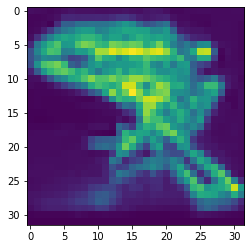

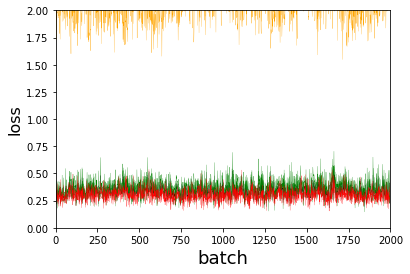

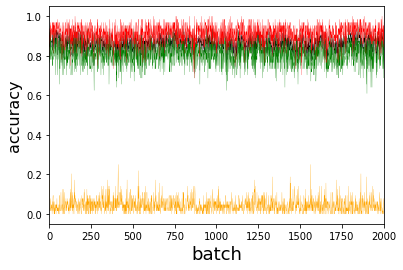

In [5]:
import os
import matplotlib.pyplot as plt


# run params
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'cifar10_frogs'
RUN_FOLDER = 'run_{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #
mode = 'load'

#(x_train, y_train) = load_safari(DATA_NAME)

x_train.shape

plt.imshow(x_train[200,:,:,0])

gan = GAN(input_dim = (32,32,3)
          #Flatten>DO>Dense(1 sigmoid) nach convs
          #padding=same
          #leaky relu alpha 0.2
          #opt = Adam(lr=0.0002, beta_1=0.5)
          #loss='binary_crossentropy'
        , discriminator_conv_filters = [64,128,128,256]
        , discriminator_conv_kernel_size = [3,3,3,3]
        , discriminator_conv_strides = [1,2,2,2]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'leaky_relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.0001 #0.0008
          
          
        , generator_initial_dense_layer_size = (4,4,256)
        , generator_upsample = [2,2,1,1]
        , generator_conv_filters = [128,128,128,3]
        , generator_conv_kernel_size = [4,4,4,4]
        , generator_conv_strides = [2,2,2,1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0001 #0.0004
        , optimiser = 'adam'
        , z_dim = 100
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

gan.discriminator.summary()

gan.generator.summary()

BATCH_SIZE = 64
EPOCHS = 200 * BATCH_SIZE
PRINT_EVERY_N_BATCHES = BATCH_SIZE * 5

gan.train(
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , using_generator = False
)

fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()

fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "model_7"
_________________________________________________________________
Layer (type)               

C:\Users\Admin\Anaconda3\envs\ml20\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Executing op __inference_keras_scratch_graph_845970 in device /job:localhost/replica:0/task:0/device:GPU:0
0 [D loss: (0.267)(R 0.349, F 0.185)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.239] [G acc: 0.031]


C:\Users\Admin\Anaconda3\envs\ml20\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: (0.182)(R 0.159, F 0.205)] [D acc: (0.961)(0.969, 0.953)] [G loss: 2.327] [G acc: 0.062]
2 [D loss: (0.305)(R 0.330, F 0.280)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.900] [G acc: 0.125]
3 [D loss: (0.196)(R 0.197, F 0.194)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.183] [G acc: 0.062]
4 [D loss: (0.242)(R 0.199, F 0.285)] [D acc: (0.922)(0.922, 0.922)] [G loss: 2.398] [G acc: 0.016]
5 [D loss: (0.294)(R 0.277, F 0.311)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.254] [G acc: 0.047]
6 [D loss: (0.281)(R 0.332, F 0.229)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.332] [G acc: 0.000]
7 [D loss: (0.219)(R 0.285, F 0.152)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.262] [G acc: 0.000]
8 [D loss: (0.220)(R 0.263, F 0.177)] [D acc: (0.945)(0.891, 1.000)] [G loss: 2.250] [G acc: 0.078]
9 [D loss: (0.251)(R 0.301, F 0.200)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.296] [G acc: 0.047]
10 [D loss: (0.244)(R 0.253, F 0.236)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.188] [G acc: 0.062]

85 [D loss: (0.275)(R 0.318, F 0.232)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.291] [G acc: 0.016]
86 [D loss: (0.246)(R 0.251, F 0.242)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.091] [G acc: 0.047]
87 [D loss: (0.360)(R 0.390, F 0.331)] [D acc: (0.820)(0.781, 0.859)] [G loss: 1.996] [G acc: 0.047]
88 [D loss: (0.287)(R 0.297, F 0.277)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.262] [G acc: 0.031]
89 [D loss: (0.259)(R 0.277, F 0.241)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.119] [G acc: 0.047]
90 [D loss: (0.226)(R 0.210, F 0.242)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.440] [G acc: 0.031]
91 [D loss: (0.326)(R 0.373, F 0.279)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.169] [G acc: 0.031]
92 [D loss: (0.277)(R 0.274, F 0.280)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.319] [G acc: 0.047]
93 [D loss: (0.240)(R 0.266, F 0.215)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.071] [G acc: 0.000]
94 [D loss: (0.268)(R 0.276, F 0.261)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.491] [G ac

166 [D loss: (0.331)(R 0.250, F 0.413)] [D acc: (0.859)(0.875, 0.844)] [G loss: 1.992] [G acc: 0.062]
167 [D loss: (0.272)(R 0.319, F 0.225)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.166] [G acc: 0.078]
168 [D loss: (0.286)(R 0.363, F 0.209)] [D acc: (0.891)(0.812, 0.969)] [G loss: 1.970] [G acc: 0.078]
169 [D loss: (0.340)(R 0.378, F 0.302)] [D acc: (0.898)(0.859, 0.938)] [G loss: 1.937] [G acc: 0.078]
170 [D loss: (0.289)(R 0.308, F 0.270)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.107] [G acc: 0.078]
171 [D loss: (0.299)(R 0.256, F 0.343)] [D acc: (0.875)(0.875, 0.875)] [G loss: 2.115] [G acc: 0.031]
172 [D loss: (0.328)(R 0.418, F 0.238)] [D acc: (0.891)(0.797, 0.984)] [G loss: 2.152] [G acc: 0.031]
173 [D loss: (0.264)(R 0.313, F 0.215)] [D acc: (0.914)(0.844, 0.984)] [G loss: 2.153] [G acc: 0.016]
174 [D loss: (0.250)(R 0.249, F 0.250)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.105] [G acc: 0.016]
175 [D loss: (0.261)(R 0.290, F 0.232)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.

248 [D loss: (0.204)(R 0.174, F 0.233)] [D acc: (0.938)(0.891, 0.984)] [G loss: 2.355] [G acc: 0.047]
249 [D loss: (0.218)(R 0.278, F 0.157)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.590] [G acc: 0.031]
250 [D loss: (0.260)(R 0.334, F 0.185)] [D acc: (0.906)(0.812, 1.000)] [G loss: 2.253] [G acc: 0.016]
251 [D loss: (0.305)(R 0.376, F 0.234)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.093] [G acc: 0.094]
252 [D loss: (0.230)(R 0.195, F 0.265)] [D acc: (0.898)(0.891, 0.906)] [G loss: 2.073] [G acc: 0.094]
253 [D loss: (0.245)(R 0.279, F 0.211)] [D acc: (0.922)(0.891, 0.953)] [G loss: 2.282] [G acc: 0.031]
254 [D loss: (0.223)(R 0.215, F 0.231)] [D acc: (0.914)(0.906, 0.922)] [G loss: 2.290] [G acc: 0.062]
255 [D loss: (0.259)(R 0.221, F 0.297)] [D acc: (0.875)(0.891, 0.859)] [G loss: 2.206] [G acc: 0.078]
256 [D loss: (0.199)(R 0.185, F 0.214)] [D acc: (0.945)(0.922, 0.969)] [G loss: 2.314] [G acc: 0.031]
257 [D loss: (0.304)(R 0.365, F 0.243)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.

330 [D loss: (0.234)(R 0.254, F 0.215)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.093] [G acc: 0.031]
331 [D loss: (0.343)(R 0.420, F 0.266)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.332] [G acc: 0.000]
332 [D loss: (0.310)(R 0.330, F 0.291)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.200] [G acc: 0.078]
333 [D loss: (0.247)(R 0.280, F 0.213)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.161] [G acc: 0.078]
334 [D loss: (0.305)(R 0.362, F 0.247)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.115] [G acc: 0.094]
335 [D loss: (0.250)(R 0.256, F 0.244)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.746] [G acc: 0.016]
336 [D loss: (0.265)(R 0.271, F 0.259)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.112] [G acc: 0.047]
337 [D loss: (0.344)(R 0.419, F 0.269)] [D acc: (0.820)(0.750, 0.891)] [G loss: 2.179] [G acc: 0.047]
338 [D loss: (0.210)(R 0.183, F 0.237)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.314] [G acc: 0.031]
339 [D loss: (0.235)(R 0.266, F 0.204)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.

413 [D loss: (0.314)(R 0.355, F 0.274)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.963] [G acc: 0.016]
414 [D loss: (0.295)(R 0.354, F 0.236)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.051] [G acc: 0.047]
415 [D loss: (0.308)(R 0.346, F 0.270)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.094] [G acc: 0.062]
416 [D loss: (0.301)(R 0.295, F 0.307)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.136] [G acc: 0.047]
417 [D loss: (0.326)(R 0.369, F 0.282)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.261] [G acc: 0.031]
418 [D loss: (0.215)(R 0.230, F 0.199)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.203] [G acc: 0.016]
419 [D loss: (0.319)(R 0.379, F 0.260)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.143] [G acc: 0.016]
420 [D loss: (0.233)(R 0.252, F 0.214)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.348] [G acc: 0.031]
421 [D loss: (0.278)(R 0.350, F 0.205)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.271] [G acc: 0.062]
422 [D loss: (0.340)(R 0.387, F 0.293)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.

496 [D loss: (0.266)(R 0.326, F 0.206)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.189] [G acc: 0.062]
497 [D loss: (0.362)(R 0.404, F 0.319)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.371] [G acc: 0.000]
498 [D loss: (0.248)(R 0.283, F 0.214)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.342] [G acc: 0.047]
499 [D loss: (0.247)(R 0.291, F 0.203)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.467] [G acc: 0.047]
500 [D loss: (0.266)(R 0.338, F 0.193)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.651] [G acc: 0.016]
501 [D loss: (0.299)(R 0.285, F 0.313)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.282] [G acc: 0.016]
502 [D loss: (0.329)(R 0.399, F 0.259)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.198] [G acc: 0.047]
503 [D loss: (0.289)(R 0.393, F 0.185)] [D acc: (0.906)(0.812, 1.000)] [G loss: 1.961] [G acc: 0.062]
504 [D loss: (0.305)(R 0.299, F 0.312)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.341] [G acc: 0.062]
505 [D loss: (0.233)(R 0.237, F 0.229)] [D acc: (0.961)(0.922, 1.000)] [G loss: 2.

579 [D loss: (0.252)(R 0.270, F 0.235)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.059] [G acc: 0.031]
580 [D loss: (0.243)(R 0.265, F 0.221)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.388] [G acc: 0.016]
581 [D loss: (0.263)(R 0.303, F 0.223)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.301] [G acc: 0.016]
582 [D loss: (0.323)(R 0.290, F 0.357)] [D acc: (0.820)(0.812, 0.828)] [G loss: 2.276] [G acc: 0.000]
583 [D loss: (0.252)(R 0.237, F 0.267)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.156] [G acc: 0.062]
584 [D loss: (0.295)(R 0.404, F 0.185)] [D acc: (0.867)(0.766, 0.969)] [G loss: 2.194] [G acc: 0.062]
585 [D loss: (0.262)(R 0.261, F 0.264)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.128] [G acc: 0.016]
586 [D loss: (0.249)(R 0.194, F 0.305)] [D acc: (0.914)(0.938, 0.891)] [G loss: 1.972] [G acc: 0.078]
587 [D loss: (0.280)(R 0.326, F 0.233)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.427] [G acc: 0.047]
588 [D loss: (0.295)(R 0.326, F 0.265)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.

661 [D loss: (0.273)(R 0.234, F 0.312)] [D acc: (0.883)(0.891, 0.875)] [G loss: 2.412] [G acc: 0.078]
662 [D loss: (0.342)(R 0.379, F 0.304)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.233] [G acc: 0.062]
663 [D loss: (0.323)(R 0.329, F 0.316)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.169] [G acc: 0.031]
664 [D loss: (0.248)(R 0.253, F 0.243)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.345] [G acc: 0.031]
665 [D loss: (0.322)(R 0.419, F 0.225)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.441] [G acc: 0.047]
666 [D loss: (0.367)(R 0.404, F 0.331)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.302] [G acc: 0.031]
667 [D loss: (0.308)(R 0.370, F 0.246)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.136] [G acc: 0.062]
668 [D loss: (0.298)(R 0.298, F 0.299)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.262] [G acc: 0.078]
669 [D loss: (0.254)(R 0.237, F 0.271)] [D acc: (0.898)(0.891, 0.906)] [G loss: 2.653] [G acc: 0.047]
670 [D loss: (0.315)(R 0.360, F 0.269)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.

743 [D loss: (0.227)(R 0.238, F 0.216)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.042] [G acc: 0.094]
744 [D loss: (0.269)(R 0.296, F 0.242)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.013] [G acc: 0.125]
745 [D loss: (0.342)(R 0.404, F 0.281)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.062] [G acc: 0.125]
746 [D loss: (0.305)(R 0.312, F 0.299)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.355] [G acc: 0.047]
747 [D loss: (0.322)(R 0.321, F 0.322)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.431] [G acc: 0.062]
748 [D loss: (0.368)(R 0.440, F 0.295)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.260] [G acc: 0.047]
749 [D loss: (0.332)(R 0.433, F 0.232)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.316] [G acc: 0.078]
750 [D loss: (0.252)(R 0.237, F 0.266)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.153] [G acc: 0.062]
751 [D loss: (0.292)(R 0.352, F 0.232)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.330] [G acc: 0.016]
752 [D loss: (0.403)(R 0.489, F 0.316)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.

825 [D loss: (0.295)(R 0.329, F 0.262)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.040] [G acc: 0.031]
826 [D loss: (0.427)(R 0.435, F 0.419)] [D acc: (0.773)(0.734, 0.812)] [G loss: 2.159] [G acc: 0.062]
827 [D loss: (0.218)(R 0.171, F 0.265)] [D acc: (0.898)(0.891, 0.906)] [G loss: 2.463] [G acc: 0.016]
828 [D loss: (0.291)(R 0.409, F 0.173)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.384] [G acc: 0.016]
829 [D loss: (0.400)(R 0.528, F 0.272)] [D acc: (0.836)(0.719, 0.953)] [G loss: 2.142] [G acc: 0.047]
830 [D loss: (0.332)(R 0.454, F 0.211)] [D acc: (0.867)(0.750, 0.984)] [G loss: 2.036] [G acc: 0.016]
831 [D loss: (0.285)(R 0.303, F 0.266)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.119] [G acc: 0.031]
832 [D loss: (0.242)(R 0.191, F 0.294)] [D acc: (0.914)(0.906, 0.922)] [G loss: 2.014] [G acc: 0.062]
833 [D loss: (0.298)(R 0.352, F 0.245)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.284] [G acc: 0.047]
834 [D loss: (0.319)(R 0.402, F 0.235)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.

906 [D loss: (0.334)(R 0.403, F 0.266)] [D acc: (0.875)(0.797, 0.953)] [G loss: 1.958] [G acc: 0.031]
907 [D loss: (0.268)(R 0.298, F 0.238)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.129] [G acc: 0.016]
908 [D loss: (0.292)(R 0.272, F 0.312)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.159] [G acc: 0.062]
909 [D loss: (0.337)(R 0.386, F 0.287)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.023] [G acc: 0.047]
910 [D loss: (0.302)(R 0.377, F 0.228)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.241] [G acc: 0.047]
911 [D loss: (0.365)(R 0.361, F 0.369)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.029] [G acc: 0.047]
912 [D loss: (0.305)(R 0.271, F 0.339)] [D acc: (0.859)(0.875, 0.844)] [G loss: 2.180] [G acc: 0.016]
913 [D loss: (0.318)(R 0.379, F 0.256)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.049] [G acc: 0.078]
914 [D loss: (0.249)(R 0.294, F 0.203)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.143] [G acc: 0.031]
915 [D loss: (0.358)(R 0.447, F 0.270)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.

988 [D loss: (0.332)(R 0.255, F 0.408)] [D acc: (0.844)(0.844, 0.844)] [G loss: 2.060] [G acc: 0.109]
989 [D loss: (0.448)(R 0.536, F 0.360)] [D acc: (0.789)(0.750, 0.828)] [G loss: 2.080] [G acc: 0.141]
990 [D loss: (0.287)(R 0.393, F 0.181)] [D acc: (0.922)(0.859, 0.984)] [G loss: 2.154] [G acc: 0.047]
991 [D loss: (0.324)(R 0.372, F 0.275)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.882] [G acc: 0.094]
992 [D loss: (0.416)(R 0.418, F 0.415)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.027] [G acc: 0.062]
993 [D loss: (0.397)(R 0.518, F 0.276)] [D acc: (0.797)(0.688, 0.906)] [G loss: 1.982] [G acc: 0.109]
994 [D loss: (0.405)(R 0.452, F 0.359)] [D acc: (0.805)(0.766, 0.844)] [G loss: 1.954] [G acc: 0.047]
995 [D loss: (0.289)(R 0.290, F 0.288)] [D acc: (0.867)(0.859, 0.875)] [G loss: 1.986] [G acc: 0.062]
996 [D loss: (0.339)(R 0.378, F 0.300)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.306] [G acc: 0.016]
997 [D loss: (0.317)(R 0.328, F 0.307)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.

1068 [D loss: (0.306)(R 0.388, F 0.225)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.202] [G acc: 0.078]
1069 [D loss: (0.256)(R 0.308, F 0.204)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.020] [G acc: 0.094]
1070 [D loss: (0.341)(R 0.361, F 0.320)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.042] [G acc: 0.078]
1071 [D loss: (0.284)(R 0.324, F 0.243)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.143] [G acc: 0.062]
1072 [D loss: (0.297)(R 0.394, F 0.200)] [D acc: (0.875)(0.766, 0.984)] [G loss: 1.759] [G acc: 0.109]
1073 [D loss: (0.226)(R 0.223, F 0.229)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.032] [G acc: 0.094]
1074 [D loss: (0.283)(R 0.331, F 0.234)] [D acc: (0.891)(0.844, 0.938)] [G loss: 1.979] [G acc: 0.047]
1075 [D loss: (0.255)(R 0.296, F 0.215)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.096] [G acc: 0.016]
1076 [D loss: (0.305)(R 0.276, F 0.335)] [D acc: (0.883)(0.859, 0.906)] [G loss: 1.935] [G acc: 0.062]
1077 [D loss: (0.238)(R 0.268, F 0.207)] [D acc: (0.930)(0.875, 0.984)] [

1150 [D loss: (0.275)(R 0.313, F 0.237)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.027] [G acc: 0.062]
1151 [D loss: (0.311)(R 0.346, F 0.275)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.077] [G acc: 0.062]
1152 [D loss: (0.320)(R 0.366, F 0.274)] [D acc: (0.859)(0.828, 0.891)] [G loss: 1.872] [G acc: 0.109]
1153 [D loss: (0.230)(R 0.196, F 0.265)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.318] [G acc: 0.031]
1154 [D loss: (0.301)(R 0.382, F 0.219)] [D acc: (0.859)(0.750, 0.969)] [G loss: 2.201] [G acc: 0.078]
1155 [D loss: (0.230)(R 0.268, F 0.192)] [D acc: (0.922)(0.859, 0.984)] [G loss: 2.207] [G acc: 0.062]
1156 [D loss: (0.332)(R 0.342, F 0.322)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.089] [G acc: 0.047]
1157 [D loss: (0.301)(R 0.301, F 0.302)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.024] [G acc: 0.047]
1158 [D loss: (0.292)(R 0.301, F 0.284)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.222] [G acc: 0.016]
1159 [D loss: (0.329)(R 0.359, F 0.299)] [D acc: (0.852)(0.828, 0.875)] [

1230 [D loss: (0.275)(R 0.236, F 0.314)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.044] [G acc: 0.109]
1231 [D loss: (0.247)(R 0.297, F 0.198)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.393] [G acc: 0.000]
1232 [D loss: (0.279)(R 0.279, F 0.279)] [D acc: (0.898)(0.875, 0.922)] [G loss: 1.914] [G acc: 0.078]
1233 [D loss: (0.275)(R 0.334, F 0.216)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.073] [G acc: 0.078]
1234 [D loss: (0.268)(R 0.259, F 0.277)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.187] [G acc: 0.125]
1235 [D loss: (0.294)(R 0.384, F 0.204)] [D acc: (0.906)(0.828, 0.984)] [G loss: 2.098] [G acc: 0.062]
1236 [D loss: (0.288)(R 0.299, F 0.276)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.162] [G acc: 0.078]
1237 [D loss: (0.345)(R 0.367, F 0.323)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.368] [G acc: 0.000]
1238 [D loss: (0.341)(R 0.420, F 0.262)] [D acc: (0.812)(0.734, 0.891)] [G loss: 2.130] [G acc: 0.062]
1239 [D loss: (0.255)(R 0.230, F 0.280)] [D acc: (0.906)(0.906, 0.906)] [

1310 [D loss: (0.263)(R 0.268, F 0.259)] [D acc: (0.891)(0.891, 0.891)] [G loss: 2.307] [G acc: 0.031]
1311 [D loss: (0.356)(R 0.429, F 0.283)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.439] [G acc: 0.062]
1312 [D loss: (0.296)(R 0.325, F 0.267)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.041] [G acc: 0.094]
1313 [D loss: (0.355)(R 0.399, F 0.311)] [D acc: (0.805)(0.781, 0.828)] [G loss: 2.174] [G acc: 0.062]
1314 [D loss: (0.287)(R 0.314, F 0.261)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.209] [G acc: 0.047]
1315 [D loss: (0.305)(R 0.380, F 0.229)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.207] [G acc: 0.047]
1316 [D loss: (0.298)(R 0.332, F 0.264)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.230] [G acc: 0.016]
1317 [D loss: (0.294)(R 0.337, F 0.250)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.390] [G acc: 0.062]
1318 [D loss: (0.282)(R 0.308, F 0.255)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.188] [G acc: 0.016]
1319 [D loss: (0.382)(R 0.473, F 0.291)] [D acc: (0.828)(0.766, 0.891)] [

1390 [D loss: (0.315)(R 0.332, F 0.299)] [D acc: (0.867)(0.844, 0.891)] [G loss: 1.975] [G acc: 0.078]
1391 [D loss: (0.331)(R 0.411, F 0.252)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.990] [G acc: 0.125]
1392 [D loss: (0.260)(R 0.232, F 0.287)] [D acc: (0.922)(0.922, 0.922)] [G loss: 1.934] [G acc: 0.062]
1393 [D loss: (0.311)(R 0.363, F 0.258)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.144] [G acc: 0.047]
1394 [D loss: (0.336)(R 0.366, F 0.306)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.257] [G acc: 0.031]
1395 [D loss: (0.280)(R 0.295, F 0.264)] [D acc: (0.906)(0.875, 0.938)] [G loss: 1.966] [G acc: 0.016]
1396 [D loss: (0.262)(R 0.250, F 0.274)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.073] [G acc: 0.062]
1397 [D loss: (0.315)(R 0.363, F 0.268)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.254] [G acc: 0.031]
1398 [D loss: (0.313)(R 0.341, F 0.285)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.169] [G acc: 0.031]
1399 [D loss: (0.338)(R 0.432, F 0.245)] [D acc: (0.820)(0.719, 0.922)] [

1470 [D loss: (0.283)(R 0.229, F 0.337)] [D acc: (0.891)(0.891, 0.891)] [G loss: 2.133] [G acc: 0.031]
1471 [D loss: (0.279)(R 0.302, F 0.256)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.234] [G acc: 0.016]
1472 [D loss: (0.282)(R 0.327, F 0.238)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.228] [G acc: 0.031]
1473 [D loss: (0.329)(R 0.414, F 0.245)] [D acc: (0.852)(0.766, 0.938)] [G loss: 1.990] [G acc: 0.047]
1474 [D loss: (0.351)(R 0.395, F 0.307)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.735] [G acc: 0.094]
1475 [D loss: (0.266)(R 0.287, F 0.245)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.150] [G acc: 0.000]
1476 [D loss: (0.291)(R 0.328, F 0.253)] [D acc: (0.883)(0.812, 0.953)] [G loss: 1.847] [G acc: 0.078]
1477 [D loss: (0.248)(R 0.248, F 0.249)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.225] [G acc: 0.031]
1478 [D loss: (0.287)(R 0.267, F 0.307)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.230] [G acc: 0.094]
1479 [D loss: (0.290)(R 0.319, F 0.261)] [D acc: (0.844)(0.812, 0.875)] [

1552 [D loss: (0.273)(R 0.352, F 0.194)] [D acc: (0.906)(0.812, 1.000)] [G loss: 2.086] [G acc: 0.141]
1553 [D loss: (0.245)(R 0.255, F 0.236)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.088] [G acc: 0.031]
1554 [D loss: (0.336)(R 0.373, F 0.298)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.974] [G acc: 0.109]
1555 [D loss: (0.268)(R 0.284, F 0.252)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.148] [G acc: 0.047]
1556 [D loss: (0.302)(R 0.293, F 0.311)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.095] [G acc: 0.094]
1557 [D loss: (0.216)(R 0.227, F 0.206)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.487] [G acc: 0.031]
1558 [D loss: (0.307)(R 0.417, F 0.198)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.097] [G acc: 0.047]
1559 [D loss: (0.301)(R 0.277, F 0.325)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.288] [G acc: 0.078]
1560 [D loss: (0.211)(R 0.208, F 0.215)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.192] [G acc: 0.062]
1561 [D loss: (0.314)(R 0.391, F 0.236)] [D acc: (0.859)(0.781, 0.938)] [

1634 [D loss: (0.235)(R 0.261, F 0.209)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.063] [G acc: 0.047]
1635 [D loss: (0.233)(R 0.271, F 0.195)] [D acc: (0.906)(0.859, 0.953)] [G loss: 1.990] [G acc: 0.047]
1636 [D loss: (0.309)(R 0.395, F 0.223)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.265] [G acc: 0.047]
1637 [D loss: (0.295)(R 0.348, F 0.242)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.137] [G acc: 0.047]
1638 [D loss: (0.287)(R 0.290, F 0.285)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.261] [G acc: 0.078]
1639 [D loss: (0.263)(R 0.216, F 0.310)] [D acc: (0.883)(0.891, 0.875)] [G loss: 2.103] [G acc: 0.109]
1640 [D loss: (0.271)(R 0.273, F 0.268)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.572] [G acc: 0.016]
1641 [D loss: (0.320)(R 0.402, F 0.238)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.188] [G acc: 0.094]
1642 [D loss: (0.223)(R 0.182, F 0.264)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.321] [G acc: 0.047]
1643 [D loss: (0.273)(R 0.290, F 0.256)] [D acc: (0.859)(0.828, 0.891)] [

1714 [D loss: (0.254)(R 0.279, F 0.230)] [D acc: (0.906)(0.875, 0.938)] [G loss: 1.981] [G acc: 0.062]
1715 [D loss: (0.411)(R 0.450, F 0.373)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.285] [G acc: 0.031]
1716 [D loss: (0.317)(R 0.430, F 0.205)] [D acc: (0.859)(0.734, 0.984)] [G loss: 2.181] [G acc: 0.031]
1717 [D loss: (0.249)(R 0.266, F 0.231)] [D acc: (0.875)(0.844, 0.906)] [G loss: 1.897] [G acc: 0.141]
1718 [D loss: (0.315)(R 0.360, F 0.270)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.216] [G acc: 0.062]
1719 [D loss: (0.294)(R 0.333, F 0.255)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.320] [G acc: 0.031]
1720 [D loss: (0.245)(R 0.213, F 0.277)] [D acc: (0.914)(0.922, 0.906)] [G loss: 2.127] [G acc: 0.047]
1721 [D loss: (0.307)(R 0.324, F 0.289)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.187] [G acc: 0.031]
1722 [D loss: (0.266)(R 0.262, F 0.270)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.294] [G acc: 0.016]
1723 [D loss: (0.303)(R 0.365, F 0.240)] [D acc: (0.922)(0.859, 0.984)] [

1795 [D loss: (0.303)(R 0.368, F 0.238)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.220] [G acc: 0.047]
1796 [D loss: (0.301)(R 0.306, F 0.296)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.444] [G acc: 0.109]
1797 [D loss: (0.319)(R 0.370, F 0.268)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.014] [G acc: 0.047]
1798 [D loss: (0.303)(R 0.282, F 0.324)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.110] [G acc: 0.078]
1799 [D loss: (0.255)(R 0.234, F 0.276)] [D acc: (0.883)(0.891, 0.875)] [G loss: 2.059] [G acc: 0.062]
1800 [D loss: (0.329)(R 0.350, F 0.307)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.183] [G acc: 0.156]
1801 [D loss: (0.291)(R 0.273, F 0.309)] [D acc: (0.875)(0.875, 0.875)] [G loss: 2.148] [G acc: 0.094]
1802 [D loss: (0.330)(R 0.304, F 0.356)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.110] [G acc: 0.141]
1803 [D loss: (0.275)(R 0.251, F 0.300)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.167] [G acc: 0.109]
1804 [D loss: (0.329)(R 0.320, F 0.339)] [D acc: (0.828)(0.797, 0.859)] [

1875 [D loss: (0.311)(R 0.430, F 0.193)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.255] [G acc: 0.125]
1876 [D loss: (0.345)(R 0.329, F 0.361)] [D acc: (0.859)(0.859, 0.859)] [G loss: 2.193] [G acc: 0.078]
1877 [D loss: (0.426)(R 0.546, F 0.306)] [D acc: (0.781)(0.688, 0.875)] [G loss: 2.281] [G acc: 0.047]
1878 [D loss: (0.309)(R 0.436, F 0.181)] [D acc: (0.867)(0.766, 0.969)] [G loss: 2.220] [G acc: 0.125]
1879 [D loss: (0.254)(R 0.292, F 0.216)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.030] [G acc: 0.047]
1880 [D loss: (0.225)(R 0.197, F 0.253)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.301] [G acc: 0.094]
1881 [D loss: (0.298)(R 0.288, F 0.308)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.066] [G acc: 0.141]
1882 [D loss: (0.436)(R 0.481, F 0.391)] [D acc: (0.758)(0.688, 0.828)] [G loss: 2.107] [G acc: 0.094]
1883 [D loss: (0.293)(R 0.258, F 0.328)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.226] [G acc: 0.094]
1884 [D loss: (0.371)(R 0.356, F 0.386)] [D acc: (0.844)(0.812, 0.875)] [

1955 [D loss: (0.327)(R 0.382, F 0.272)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.986] [G acc: 0.141]
1956 [D loss: (0.387)(R 0.314, F 0.460)] [D acc: (0.805)(0.812, 0.797)] [G loss: 2.155] [G acc: 0.047]
1957 [D loss: (0.342)(R 0.376, F 0.308)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.193] [G acc: 0.062]
1958 [D loss: (0.391)(R 0.478, F 0.303)] [D acc: (0.797)(0.750, 0.844)] [G loss: 2.335] [G acc: 0.031]
1959 [D loss: (0.335)(R 0.324, F 0.347)] [D acc: (0.812)(0.812, 0.812)] [G loss: 2.095] [G acc: 0.078]
1960 [D loss: (0.337)(R 0.471, F 0.202)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.186] [G acc: 0.016]
1961 [D loss: (0.299)(R 0.337, F 0.261)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.314] [G acc: 0.000]
1962 [D loss: (0.305)(R 0.326, F 0.285)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.072] [G acc: 0.125]
1963 [D loss: (0.421)(R 0.487, F 0.356)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.934] [G acc: 0.078]
1964 [D loss: (0.315)(R 0.194, F 0.437)] [D acc: (0.859)(0.906, 0.812)] [

2035 [D loss: (0.361)(R 0.387, F 0.335)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.147] [G acc: 0.047]
2036 [D loss: (0.317)(R 0.332, F 0.303)] [D acc: (0.883)(0.891, 0.875)] [G loss: 1.981] [G acc: 0.031]
2037 [D loss: (0.280)(R 0.297, F 0.263)] [D acc: (0.883)(0.859, 0.906)] [G loss: 1.965] [G acc: 0.078]
2038 [D loss: (0.415)(R 0.474, F 0.356)] [D acc: (0.773)(0.703, 0.844)] [G loss: 2.082] [G acc: 0.078]
2039 [D loss: (0.382)(R 0.384, F 0.379)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.131] [G acc: 0.078]
2040 [D loss: (0.348)(R 0.393, F 0.304)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.134] [G acc: 0.094]
2041 [D loss: (0.355)(R 0.373, F 0.338)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.070] [G acc: 0.062]
2042 [D loss: (0.376)(R 0.453, F 0.299)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.029] [G acc: 0.094]
2043 [D loss: (0.350)(R 0.460, F 0.240)] [D acc: (0.859)(0.766, 0.953)] [G loss: 1.983] [G acc: 0.031]
2044 [D loss: (0.347)(R 0.315, F 0.380)] [D acc: (0.836)(0.844, 0.828)] [

2117 [D loss: (0.285)(R 0.333, F 0.237)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.063] [G acc: 0.047]
2118 [D loss: (0.270)(R 0.291, F 0.248)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.291] [G acc: 0.047]
2119 [D loss: (0.343)(R 0.408, F 0.277)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.237] [G acc: 0.109]
2120 [D loss: (0.330)(R 0.382, F 0.279)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.094] [G acc: 0.094]
2121 [D loss: (0.292)(R 0.229, F 0.355)] [D acc: (0.875)(0.875, 0.875)] [G loss: 1.920] [G acc: 0.062]
2122 [D loss: (0.325)(R 0.329, F 0.320)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.155] [G acc: 0.016]
2123 [D loss: (0.404)(R 0.554, F 0.254)] [D acc: (0.812)(0.719, 0.906)] [G loss: 1.967] [G acc: 0.125]
2124 [D loss: (0.299)(R 0.290, F 0.308)] [D acc: (0.875)(0.859, 0.891)] [G loss: 1.985] [G acc: 0.047]
2125 [D loss: (0.314)(R 0.345, F 0.282)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.157] [G acc: 0.047]
2126 [D loss: (0.320)(R 0.433, F 0.207)] [D acc: (0.883)(0.797, 0.969)] [

2198 [D loss: (0.302)(R 0.317, F 0.287)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.905] [G acc: 0.047]
2199 [D loss: (0.358)(R 0.334, F 0.382)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.163] [G acc: 0.078]
2200 [D loss: (0.280)(R 0.316, F 0.244)] [D acc: (0.875)(0.812, 0.938)] [G loss: 1.935] [G acc: 0.047]
2201 [D loss: (0.339)(R 0.386, F 0.291)] [D acc: (0.859)(0.828, 0.891)] [G loss: 1.921] [G acc: 0.078]
2202 [D loss: (0.354)(R 0.414, F 0.293)] [D acc: (0.852)(0.797, 0.906)] [G loss: 1.811] [G acc: 0.031]
2203 [D loss: (0.351)(R 0.383, F 0.319)] [D acc: (0.867)(0.828, 0.906)] [G loss: 1.979] [G acc: 0.047]
2204 [D loss: (0.343)(R 0.427, F 0.259)] [D acc: (0.820)(0.719, 0.922)] [G loss: 1.919] [G acc: 0.062]
2205 [D loss: (0.385)(R 0.499, F 0.270)] [D acc: (0.805)(0.703, 0.906)] [G loss: 1.923] [G acc: 0.031]
2206 [D loss: (0.311)(R 0.227, F 0.396)] [D acc: (0.875)(0.875, 0.875)] [G loss: 1.665] [G acc: 0.094]
2207 [D loss: (0.251)(R 0.240, F 0.262)] [D acc: (0.930)(0.891, 0.969)] [

2280 [D loss: (0.289)(R 0.319, F 0.258)] [D acc: (0.883)(0.812, 0.953)] [G loss: 1.999] [G acc: 0.062]
2281 [D loss: (0.337)(R 0.410, F 0.265)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.025] [G acc: 0.031]
2282 [D loss: (0.246)(R 0.231, F 0.262)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.154] [G acc: 0.031]
2283 [D loss: (0.275)(R 0.325, F 0.224)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.093] [G acc: 0.031]
2284 [D loss: (0.261)(R 0.255, F 0.266)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.054] [G acc: 0.000]
2285 [D loss: (0.243)(R 0.246, F 0.239)] [D acc: (0.938)(0.906, 0.969)] [G loss: 2.134] [G acc: 0.016]
2286 [D loss: (0.358)(R 0.435, F 0.281)] [D acc: (0.875)(0.797, 0.953)] [G loss: 1.908] [G acc: 0.047]
2287 [D loss: (0.303)(R 0.293, F 0.313)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.182] [G acc: 0.016]
2288 [D loss: (0.219)(R 0.242, F 0.196)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.198] [G acc: 0.016]
2289 [D loss: (0.353)(R 0.423, F 0.282)] [D acc: (0.820)(0.719, 0.922)] [

2361 [D loss: (0.283)(R 0.268, F 0.297)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.268] [G acc: 0.062]
2362 [D loss: (0.345)(R 0.381, F 0.308)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.269] [G acc: 0.016]
2363 [D loss: (0.300)(R 0.344, F 0.257)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.500] [G acc: 0.016]
2364 [D loss: (0.315)(R 0.332, F 0.298)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.098] [G acc: 0.047]
2365 [D loss: (0.287)(R 0.368, F 0.207)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.136] [G acc: 0.016]
2366 [D loss: (0.288)(R 0.332, F 0.245)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.001] [G acc: 0.000]
2367 [D loss: (0.346)(R 0.377, F 0.314)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.847] [G acc: 0.078]
2368 [D loss: (0.349)(R 0.384, F 0.313)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.921] [G acc: 0.047]
2369 [D loss: (0.327)(R 0.393, F 0.260)] [D acc: (0.867)(0.812, 0.922)] [G loss: 1.912] [G acc: 0.078]
2370 [D loss: (0.222)(R 0.150, F 0.295)] [D acc: (0.945)(0.969, 0.922)] [

2442 [D loss: (0.284)(R 0.320, F 0.248)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.141] [G acc: 0.031]
2443 [D loss: (0.335)(R 0.378, F 0.292)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.038] [G acc: 0.078]
2444 [D loss: (0.314)(R 0.366, F 0.262)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.965] [G acc: 0.094]
2445 [D loss: (0.356)(R 0.304, F 0.408)] [D acc: (0.812)(0.828, 0.797)] [G loss: 2.114] [G acc: 0.062]
2446 [D loss: (0.310)(R 0.286, F 0.335)] [D acc: (0.875)(0.875, 0.875)] [G loss: 2.139] [G acc: 0.047]
2447 [D loss: (0.428)(R 0.571, F 0.285)] [D acc: (0.773)(0.672, 0.875)] [G loss: 1.783] [G acc: 0.078]
2448 [D loss: (0.291)(R 0.344, F 0.238)] [D acc: (0.906)(0.828, 0.984)] [G loss: 2.179] [G acc: 0.062]
2449 [D loss: (0.323)(R 0.338, F 0.308)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.036] [G acc: 0.109]
2450 [D loss: (0.327)(R 0.343, F 0.311)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.185] [G acc: 0.016]
2451 [D loss: (0.320)(R 0.426, F 0.214)] [D acc: (0.891)(0.797, 0.984)] [

2523 [D loss: (0.366)(R 0.372, F 0.359)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.123] [G acc: 0.094]
2524 [D loss: (0.314)(R 0.305, F 0.323)] [D acc: (0.844)(0.844, 0.844)] [G loss: 2.265] [G acc: 0.094]
2525 [D loss: (0.249)(R 0.300, F 0.198)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.346] [G acc: 0.062]
2526 [D loss: (0.261)(R 0.226, F 0.297)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.470] [G acc: 0.109]
2527 [D loss: (0.219)(R 0.261, F 0.177)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.541] [G acc: 0.094]
2528 [D loss: (0.378)(R 0.276, F 0.479)] [D acc: (0.852)(0.859, 0.844)] [G loss: 2.713] [G acc: 0.062]
2529 [D loss: (0.251)(R 0.273, F 0.230)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.610] [G acc: 0.031]
2530 [D loss: (0.383)(R 0.507, F 0.260)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.468] [G acc: 0.094]
2531 [D loss: (0.219)(R 0.246, F 0.193)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.382] [G acc: 0.062]
2532 [D loss: (0.425)(R 0.606, F 0.244)] [D acc: (0.844)(0.766, 0.922)] [

2603 [D loss: (0.312)(R 0.367, F 0.258)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.012] [G acc: 0.078]
2604 [D loss: (0.383)(R 0.409, F 0.357)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.171] [G acc: 0.109]
2605 [D loss: (0.338)(R 0.363, F 0.313)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.301] [G acc: 0.031]
2606 [D loss: (0.336)(R 0.399, F 0.274)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.015] [G acc: 0.141]
2607 [D loss: (0.322)(R 0.360, F 0.283)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.040] [G acc: 0.078]
2608 [D loss: (0.400)(R 0.461, F 0.340)] [D acc: (0.789)(0.719, 0.859)] [G loss: 1.790] [G acc: 0.141]
2609 [D loss: (0.299)(R 0.344, F 0.254)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.161] [G acc: 0.000]
2610 [D loss: (0.305)(R 0.353, F 0.256)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.484] [G acc: 0.031]
2611 [D loss: (0.323)(R 0.419, F 0.228)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.299] [G acc: 0.031]
2612 [D loss: (0.353)(R 0.456, F 0.249)] [D acc: (0.828)(0.734, 0.922)] [

2684 [D loss: (0.194)(R 0.165, F 0.223)] [D acc: (0.945)(0.922, 0.969)] [G loss: 2.453] [G acc: 0.094]
2685 [D loss: (0.223)(R 0.260, F 0.187)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.315] [G acc: 0.031]
2686 [D loss: (0.263)(R 0.305, F 0.221)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.186] [G acc: 0.062]
2687 [D loss: (0.300)(R 0.305, F 0.294)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.399] [G acc: 0.078]
2688 [D loss: (0.347)(R 0.421, F 0.274)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.257] [G acc: 0.047]
2689 [D loss: (0.327)(R 0.376, F 0.277)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.292] [G acc: 0.078]
2690 [D loss: (0.348)(R 0.336, F 0.360)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.315] [G acc: 0.062]
2691 [D loss: (0.235)(R 0.262, F 0.209)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.122] [G acc: 0.141]
2692 [D loss: (0.288)(R 0.349, F 0.227)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.253] [G acc: 0.062]
2693 [D loss: (0.364)(R 0.298, F 0.431)] [D acc: (0.844)(0.828, 0.859)] [

2765 [D loss: (0.347)(R 0.414, F 0.280)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.273] [G acc: 0.047]
2766 [D loss: (0.324)(R 0.423, F 0.225)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.162] [G acc: 0.062]
2767 [D loss: (0.309)(R 0.398, F 0.220)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.051] [G acc: 0.000]
2768 [D loss: (0.252)(R 0.285, F 0.218)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.128] [G acc: 0.047]
2769 [D loss: (0.345)(R 0.298, F 0.393)] [D acc: (0.805)(0.859, 0.750)] [G loss: 2.039] [G acc: 0.094]
2770 [D loss: (0.418)(R 0.566, F 0.270)] [D acc: (0.828)(0.719, 0.938)] [G loss: 1.981] [G acc: 0.094]
2771 [D loss: (0.491)(R 0.526, F 0.457)] [D acc: (0.766)(0.719, 0.812)] [G loss: 1.968] [G acc: 0.047]
2772 [D loss: (0.445)(R 0.589, F 0.301)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.240] [G acc: 0.000]
2773 [D loss: (0.318)(R 0.350, F 0.285)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.154] [G acc: 0.094]
2774 [D loss: (0.337)(R 0.397, F 0.276)] [D acc: (0.875)(0.828, 0.922)] [

2847 [D loss: (0.340)(R 0.466, F 0.214)] [D acc: (0.820)(0.688, 0.953)] [G loss: 2.178] [G acc: 0.031]
2848 [D loss: (0.250)(R 0.260, F 0.240)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.220] [G acc: 0.094]
2849 [D loss: (0.282)(R 0.324, F 0.240)] [D acc: (0.891)(0.828, 0.953)] [G loss: 1.965] [G acc: 0.078]
2850 [D loss: (0.280)(R 0.375, F 0.184)] [D acc: (0.906)(0.828, 0.984)] [G loss: 2.233] [G acc: 0.031]
2851 [D loss: (0.243)(R 0.206, F 0.279)] [D acc: (0.906)(0.922, 0.891)] [G loss: 2.259] [G acc: 0.031]
2852 [D loss: (0.305)(R 0.314, F 0.296)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.043] [G acc: 0.078]
2853 [D loss: (0.247)(R 0.305, F 0.189)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.118] [G acc: 0.078]
2854 [D loss: (0.376)(R 0.374, F 0.378)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.020] [G acc: 0.062]
2855 [D loss: (0.282)(R 0.333, F 0.230)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.131] [G acc: 0.094]
2856 [D loss: (0.311)(R 0.367, F 0.256)] [D acc: (0.852)(0.766, 0.938)] [

2928 [D loss: (0.259)(R 0.301, F 0.217)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.205] [G acc: 0.047]
2929 [D loss: (0.301)(R 0.373, F 0.229)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.449] [G acc: 0.031]
2930 [D loss: (0.336)(R 0.323, F 0.349)] [D acc: (0.812)(0.766, 0.859)] [G loss: 2.281] [G acc: 0.047]
2931 [D loss: (0.309)(R 0.306, F 0.312)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.251] [G acc: 0.047]
2932 [D loss: (0.193)(R 0.211, F 0.176)] [D acc: (0.938)(0.906, 0.969)] [G loss: 2.526] [G acc: 0.000]
2933 [D loss: (0.223)(R 0.254, F 0.192)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.517] [G acc: 0.031]
2934 [D loss: (0.364)(R 0.464, F 0.263)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.201] [G acc: 0.047]
2935 [D loss: (0.344)(R 0.405, F 0.284)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.158] [G acc: 0.078]
2936 [D loss: (0.302)(R 0.263, F 0.341)] [D acc: (0.891)(0.906, 0.875)] [G loss: 2.195] [G acc: 0.047]
2937 [D loss: (0.296)(R 0.323, F 0.270)] [D acc: (0.859)(0.828, 0.891)] [

3008 [D loss: (0.351)(R 0.447, F 0.255)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.136] [G acc: 0.109]
3009 [D loss: (0.401)(R 0.434, F 0.368)] [D acc: (0.812)(0.781, 0.844)] [G loss: 2.176] [G acc: 0.109]
3010 [D loss: (0.273)(R 0.336, F 0.211)] [D acc: (0.914)(0.828, 1.000)] [G loss: 2.378] [G acc: 0.047]
3011 [D loss: (0.360)(R 0.428, F 0.292)] [D acc: (0.812)(0.781, 0.844)] [G loss: 2.373] [G acc: 0.016]
3012 [D loss: (0.365)(R 0.428, F 0.303)] [D acc: (0.852)(0.781, 0.922)] [G loss: 1.948] [G acc: 0.094]
3013 [D loss: (0.326)(R 0.352, F 0.300)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.142] [G acc: 0.078]
3014 [D loss: (0.308)(R 0.322, F 0.294)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.101] [G acc: 0.047]
3015 [D loss: (0.298)(R 0.295, F 0.300)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.054] [G acc: 0.047]
3016 [D loss: (0.270)(R 0.322, F 0.219)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.287] [G acc: 0.047]
3017 [D loss: (0.341)(R 0.442, F 0.240)] [D acc: (0.875)(0.812, 0.938)] [

3088 [D loss: (0.302)(R 0.324, F 0.279)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.107] [G acc: 0.078]
3089 [D loss: (0.350)(R 0.407, F 0.293)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.111] [G acc: 0.062]
3090 [D loss: (0.443)(R 0.626, F 0.260)] [D acc: (0.797)(0.656, 0.938)] [G loss: 1.702] [G acc: 0.141]
3091 [D loss: (0.341)(R 0.326, F 0.355)] [D acc: (0.828)(0.828, 0.828)] [G loss: 1.962] [G acc: 0.203]
3092 [D loss: (0.324)(R 0.359, F 0.289)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.118] [G acc: 0.016]
3093 [D loss: (0.422)(R 0.479, F 0.365)] [D acc: (0.773)(0.719, 0.828)] [G loss: 1.906] [G acc: 0.094]
3094 [D loss: (0.300)(R 0.340, F 0.260)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.994] [G acc: 0.047]
3095 [D loss: (0.297)(R 0.336, F 0.258)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.078] [G acc: 0.109]
3096 [D loss: (0.321)(R 0.359, F 0.283)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.058] [G acc: 0.047]
3097 [D loss: (0.338)(R 0.267, F 0.410)] [D acc: (0.805)(0.812, 0.797)] [

3168 [D loss: (0.331)(R 0.426, F 0.235)] [D acc: (0.852)(0.750, 0.953)] [G loss: 2.120] [G acc: 0.094]
3169 [D loss: (0.235)(R 0.193, F 0.277)] [D acc: (0.891)(0.891, 0.891)] [G loss: 2.123] [G acc: 0.047]
3170 [D loss: (0.302)(R 0.312, F 0.293)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.111] [G acc: 0.078]
3171 [D loss: (0.292)(R 0.299, F 0.284)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.171] [G acc: 0.109]
3172 [D loss: (0.359)(R 0.420, F 0.299)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.158] [G acc: 0.078]
3173 [D loss: (0.295)(R 0.371, F 0.219)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.131] [G acc: 0.047]
3174 [D loss: (0.283)(R 0.326, F 0.240)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.204] [G acc: 0.062]
3175 [D loss: (0.226)(R 0.210, F 0.242)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.173] [G acc: 0.062]
3176 [D loss: (0.305)(R 0.360, F 0.251)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.349] [G acc: 0.062]
3177 [D loss: (0.386)(R 0.465, F 0.307)] [D acc: (0.820)(0.797, 0.844)] [

3249 [D loss: (0.329)(R 0.422, F 0.236)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.217] [G acc: 0.047]
3250 [D loss: (0.296)(R 0.312, F 0.281)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.283] [G acc: 0.078]
3251 [D loss: (0.270)(R 0.301, F 0.239)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.274] [G acc: 0.016]
3252 [D loss: (0.281)(R 0.344, F 0.218)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.116] [G acc: 0.062]
3253 [D loss: (0.371)(R 0.460, F 0.282)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.104] [G acc: 0.047]
3254 [D loss: (0.248)(R 0.231, F 0.266)] [D acc: (0.914)(0.891, 0.938)] [G loss: 1.990] [G acc: 0.094]
3255 [D loss: (0.299)(R 0.322, F 0.275)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.116] [G acc: 0.047]
3256 [D loss: (0.409)(R 0.468, F 0.350)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.987] [G acc: 0.078]
3257 [D loss: (0.271)(R 0.249, F 0.293)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.252] [G acc: 0.047]
3258 [D loss: (0.396)(R 0.406, F 0.386)] [D acc: (0.812)(0.812, 0.812)] [

3330 [D loss: (0.225)(R 0.209, F 0.241)] [D acc: (0.914)(0.922, 0.906)] [G loss: 2.036] [G acc: 0.031]
3331 [D loss: (0.203)(R 0.208, F 0.197)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.207] [G acc: 0.047]
3332 [D loss: (0.296)(R 0.349, F 0.244)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.969] [G acc: 0.078]
3333 [D loss: (0.385)(R 0.429, F 0.341)] [D acc: (0.836)(0.797, 0.875)] [G loss: 1.944] [G acc: 0.047]
3334 [D loss: (0.321)(R 0.325, F 0.318)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.139] [G acc: 0.094]
3335 [D loss: (0.327)(R 0.318, F 0.337)] [D acc: (0.844)(0.844, 0.844)] [G loss: 2.024] [G acc: 0.047]
3336 [D loss: (0.351)(R 0.432, F 0.271)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.019] [G acc: 0.047]
3337 [D loss: (0.266)(R 0.261, F 0.271)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.239] [G acc: 0.016]
3338 [D loss: (0.323)(R 0.344, F 0.302)] [D acc: (0.828)(0.750, 0.906)] [G loss: 2.341] [G acc: 0.000]
3339 [D loss: (0.347)(R 0.335, F 0.360)] [D acc: (0.828)(0.812, 0.844)] [

3409 [D loss: (0.341)(R 0.367, F 0.315)] [D acc: (0.812)(0.734, 0.891)] [G loss: 2.161] [G acc: 0.031]
3410 [D loss: (0.287)(R 0.288, F 0.287)] [D acc: (0.898)(0.859, 0.938)] [G loss: 1.942] [G acc: 0.062]
3411 [D loss: (0.321)(R 0.325, F 0.317)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.141] [G acc: 0.047]
3412 [D loss: (0.255)(R 0.252, F 0.259)] [D acc: (0.914)(0.906, 0.922)] [G loss: 2.234] [G acc: 0.016]
3413 [D loss: (0.369)(R 0.348, F 0.391)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.023] [G acc: 0.062]
3414 [D loss: (0.348)(R 0.466, F 0.229)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.998] [G acc: 0.062]
3415 [D loss: (0.369)(R 0.479, F 0.259)] [D acc: (0.859)(0.750, 0.969)] [G loss: 1.909] [G acc: 0.109]
3416 [D loss: (0.350)(R 0.329, F 0.371)] [D acc: (0.820)(0.859, 0.781)] [G loss: 1.830] [G acc: 0.094]
3417 [D loss: (0.313)(R 0.349, F 0.278)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.073] [G acc: 0.047]
3418 [D loss: (0.350)(R 0.390, F 0.310)] [D acc: (0.852)(0.812, 0.891)] [

3489 [D loss: (0.315)(R 0.407, F 0.223)] [D acc: (0.906)(0.828, 0.984)] [G loss: 2.167] [G acc: 0.047]
3490 [D loss: (0.336)(R 0.316, F 0.356)] [D acc: (0.836)(0.828, 0.844)] [G loss: 1.987] [G acc: 0.000]
3491 [D loss: (0.302)(R 0.308, F 0.296)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.134] [G acc: 0.031]
3492 [D loss: (0.266)(R 0.292, F 0.241)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.781] [G acc: 0.094]
3493 [D loss: (0.295)(R 0.293, F 0.297)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.969] [G acc: 0.047]
3494 [D loss: (0.311)(R 0.319, F 0.303)] [D acc: (0.867)(0.844, 0.891)] [G loss: 1.994] [G acc: 0.078]
3495 [D loss: (0.285)(R 0.343, F 0.227)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.957] [G acc: 0.109]
3496 [D loss: (0.341)(R 0.310, F 0.372)] [D acc: (0.820)(0.828, 0.812)] [G loss: 1.879] [G acc: 0.047]
3497 [D loss: (0.284)(R 0.265, F 0.303)] [D acc: (0.906)(0.906, 0.906)] [G loss: 1.989] [G acc: 0.031]
3498 [D loss: (0.251)(R 0.284, F 0.218)] [D acc: (0.883)(0.828, 0.938)] [

3569 [D loss: (0.268)(R 0.320, F 0.216)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.095] [G acc: 0.078]
3570 [D loss: (0.367)(R 0.456, F 0.277)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.078] [G acc: 0.016]
3571 [D loss: (0.295)(R 0.302, F 0.289)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.195] [G acc: 0.047]
3572 [D loss: (0.287)(R 0.307, F 0.267)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.229] [G acc: 0.000]
3573 [D loss: (0.327)(R 0.358, F 0.296)] [D acc: (0.812)(0.781, 0.844)] [G loss: 2.184] [G acc: 0.031]
3574 [D loss: (0.281)(R 0.390, F 0.173)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.248] [G acc: 0.016]
3575 [D loss: (0.312)(R 0.396, F 0.227)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.213] [G acc: 0.016]
3576 [D loss: (0.318)(R 0.330, F 0.306)] [D acc: (0.836)(0.844, 0.828)] [G loss: 2.190] [G acc: 0.016]
3577 [D loss: (0.266)(R 0.265, F 0.267)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.383] [G acc: 0.000]
3578 [D loss: (0.297)(R 0.379, F 0.214)] [D acc: (0.852)(0.781, 0.922)] [

3649 [D loss: (0.373)(R 0.502, F 0.244)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.236] [G acc: 0.031]
3650 [D loss: (0.337)(R 0.340, F 0.333)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.068] [G acc: 0.062]
3651 [D loss: (0.250)(R 0.264, F 0.236)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.206] [G acc: 0.047]
3652 [D loss: (0.309)(R 0.366, F 0.253)] [D acc: (0.891)(0.812, 0.969)] [G loss: 1.948] [G acc: 0.031]
3653 [D loss: (0.280)(R 0.278, F 0.282)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.065] [G acc: 0.062]
3654 [D loss: (0.266)(R 0.275, F 0.256)] [D acc: (0.883)(0.844, 0.922)] [G loss: 1.968] [G acc: 0.031]
3655 [D loss: (0.309)(R 0.322, F 0.295)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.197] [G acc: 0.047]
3656 [D loss: (0.317)(R 0.360, F 0.274)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.162] [G acc: 0.031]
3657 [D loss: (0.281)(R 0.316, F 0.246)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.023] [G acc: 0.094]
3658 [D loss: (0.311)(R 0.338, F 0.283)] [D acc: (0.828)(0.781, 0.875)] [

3730 [D loss: (0.292)(R 0.390, F 0.195)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.552] [G acc: 0.109]
3731 [D loss: (0.326)(R 0.266, F 0.386)] [D acc: (0.828)(0.859, 0.797)] [G loss: 2.659] [G acc: 0.078]
3732 [D loss: (0.391)(R 0.394, F 0.388)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.851] [G acc: 0.078]
3733 [D loss: (0.348)(R 0.412, F 0.284)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.743] [G acc: 0.031]
3734 [D loss: (0.241)(R 0.219, F 0.263)] [D acc: (0.883)(0.891, 0.875)] [G loss: 2.927] [G acc: 0.078]
3735 [D loss: (0.311)(R 0.371, F 0.250)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.815] [G acc: 0.062]
3736 [D loss: (0.331)(R 0.473, F 0.190)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.876] [G acc: 0.078]
3737 [D loss: (0.398)(R 0.454, F 0.343)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.915] [G acc: 0.016]
3738 [D loss: (0.337)(R 0.471, F 0.203)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.611] [G acc: 0.047]
3739 [D loss: (0.297)(R 0.306, F 0.288)] [D acc: (0.859)(0.859, 0.859)] [

3811 [D loss: (0.283)(R 0.357, F 0.210)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.443] [G acc: 0.047]
3812 [D loss: (0.260)(R 0.321, F 0.198)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.344] [G acc: 0.031]
3813 [D loss: (0.411)(R 0.550, F 0.272)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.203] [G acc: 0.078]
3814 [D loss: (0.366)(R 0.466, F 0.266)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.138] [G acc: 0.094]
3815 [D loss: (0.357)(R 0.449, F 0.265)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.876] [G acc: 0.109]
3816 [D loss: (0.511)(R 0.597, F 0.425)] [D acc: (0.805)(0.766, 0.844)] [G loss: 1.988] [G acc: 0.062]
3817 [D loss: (0.455)(R 0.505, F 0.406)] [D acc: (0.805)(0.766, 0.844)] [G loss: 2.235] [G acc: 0.016]
3818 [D loss: (0.316)(R 0.416, F 0.216)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.175] [G acc: 0.047]
3819 [D loss: (0.466)(R 0.614, F 0.317)] [D acc: (0.797)(0.703, 0.891)] [G loss: 1.960] [G acc: 0.062]
3820 [D loss: (0.352)(R 0.427, F 0.276)] [D acc: (0.852)(0.812, 0.891)] [

3892 [D loss: (0.294)(R 0.326, F 0.262)] [D acc: (0.875)(0.859, 0.891)] [G loss: 1.905] [G acc: 0.109]
3893 [D loss: (0.359)(R 0.409, F 0.310)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.259] [G acc: 0.031]
3894 [D loss: (0.325)(R 0.431, F 0.220)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.051] [G acc: 0.047]
3895 [D loss: (0.286)(R 0.279, F 0.292)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.243] [G acc: 0.016]
3896 [D loss: (0.382)(R 0.449, F 0.314)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.135] [G acc: 0.016]
3897 [D loss: (0.378)(R 0.432, F 0.324)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.078] [G acc: 0.031]
3898 [D loss: (0.363)(R 0.468, F 0.258)] [D acc: (0.844)(0.719, 0.969)] [G loss: 2.069] [G acc: 0.078]
3899 [D loss: (0.306)(R 0.373, F 0.239)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.209] [G acc: 0.047]
3900 [D loss: (0.369)(R 0.428, F 0.310)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.128] [G acc: 0.078]
3901 [D loss: (0.289)(R 0.330, F 0.247)] [D acc: (0.883)(0.828, 0.938)] [

3973 [D loss: (0.344)(R 0.383, F 0.304)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.056] [G acc: 0.047]
3974 [D loss: (0.317)(R 0.388, F 0.246)] [D acc: (0.852)(0.750, 0.953)] [G loss: 2.238] [G acc: 0.031]
3975 [D loss: (0.394)(R 0.484, F 0.305)] [D acc: (0.820)(0.750, 0.891)] [G loss: 1.865] [G acc: 0.094]
3976 [D loss: (0.372)(R 0.471, F 0.272)] [D acc: (0.828)(0.734, 0.922)] [G loss: 1.917] [G acc: 0.078]
3977 [D loss: (0.369)(R 0.384, F 0.354)] [D acc: (0.812)(0.812, 0.812)] [G loss: 1.957] [G acc: 0.156]
3978 [D loss: (0.279)(R 0.307, F 0.250)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.067] [G acc: 0.125]
3979 [D loss: (0.388)(R 0.368, F 0.409)] [D acc: (0.805)(0.797, 0.812)] [G loss: 2.063] [G acc: 0.078]
3980 [D loss: (0.341)(R 0.352, F 0.331)] [D acc: (0.859)(0.844, 0.875)] [G loss: 1.872] [G acc: 0.094]
3981 [D loss: (0.212)(R 0.204, F 0.221)] [D acc: (0.945)(0.891, 1.000)] [G loss: 1.823] [G acc: 0.109]
3982 [D loss: (0.313)(R 0.347, F 0.278)] [D acc: (0.883)(0.844, 0.922)] [

4054 [D loss: (0.300)(R 0.351, F 0.248)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.114] [G acc: 0.062]
4055 [D loss: (0.327)(R 0.297, F 0.357)] [D acc: (0.844)(0.859, 0.828)] [G loss: 1.955] [G acc: 0.078]
4056 [D loss: (0.379)(R 0.386, F 0.372)] [D acc: (0.820)(0.828, 0.812)] [G loss: 2.117] [G acc: 0.031]
4057 [D loss: (0.319)(R 0.328, F 0.309)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.009] [G acc: 0.094]
4058 [D loss: (0.221)(R 0.190, F 0.252)] [D acc: (0.930)(0.953, 0.906)] [G loss: 2.176] [G acc: 0.016]
4059 [D loss: (0.419)(R 0.566, F 0.272)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.007] [G acc: 0.078]
4060 [D loss: (0.379)(R 0.497, F 0.260)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.014] [G acc: 0.047]
4061 [D loss: (0.325)(R 0.335, F 0.314)] [D acc: (0.859)(0.828, 0.891)] [G loss: 1.802] [G acc: 0.172]
4062 [D loss: (0.344)(R 0.282, F 0.406)] [D acc: (0.844)(0.859, 0.828)] [G loss: 1.906] [G acc: 0.031]
4063 [D loss: (0.374)(R 0.352, F 0.395)] [D acc: (0.836)(0.828, 0.844)] [

4135 [D loss: (0.339)(R 0.345, F 0.333)] [D acc: (0.828)(0.781, 0.875)] [G loss: 1.841] [G acc: 0.000]
4136 [D loss: (0.231)(R 0.250, F 0.212)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.006] [G acc: 0.047]
4137 [D loss: (0.253)(R 0.321, F 0.185)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.081] [G acc: 0.016]
4138 [D loss: (0.278)(R 0.265, F 0.290)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.083] [G acc: 0.047]
4139 [D loss: (0.291)(R 0.299, F 0.284)] [D acc: (0.859)(0.844, 0.875)] [G loss: 1.865] [G acc: 0.047]
4140 [D loss: (0.262)(R 0.296, F 0.228)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.207] [G acc: 0.000]
4141 [D loss: (0.355)(R 0.390, F 0.320)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.073] [G acc: 0.078]
4142 [D loss: (0.376)(R 0.373, F 0.380)] [D acc: (0.805)(0.750, 0.859)] [G loss: 1.945] [G acc: 0.016]
4143 [D loss: (0.292)(R 0.374, F 0.210)] [D acc: (0.852)(0.750, 0.953)] [G loss: 2.183] [G acc: 0.016]
4144 [D loss: (0.254)(R 0.316, F 0.191)] [D acc: (0.914)(0.859, 0.969)] [

4215 [D loss: (0.367)(R 0.424, F 0.309)] [D acc: (0.812)(0.797, 0.828)] [G loss: 2.290] [G acc: 0.031]
4216 [D loss: (0.298)(R 0.312, F 0.285)] [D acc: (0.891)(0.859, 0.922)] [G loss: 1.868] [G acc: 0.062]
4217 [D loss: (0.323)(R 0.447, F 0.198)] [D acc: (0.867)(0.734, 1.000)] [G loss: 2.059] [G acc: 0.109]
4218 [D loss: (0.523)(R 0.656, F 0.391)] [D acc: (0.750)(0.656, 0.844)] [G loss: 1.718] [G acc: 0.141]
4219 [D loss: (0.368)(R 0.375, F 0.360)] [D acc: (0.836)(0.797, 0.875)] [G loss: 1.928] [G acc: 0.078]
4220 [D loss: (0.405)(R 0.494, F 0.316)] [D acc: (0.805)(0.719, 0.891)] [G loss: 1.990] [G acc: 0.062]
4221 [D loss: (0.359)(R 0.340, F 0.377)] [D acc: (0.820)(0.812, 0.828)] [G loss: 1.880] [G acc: 0.062]
4222 [D loss: (0.322)(R 0.362, F 0.282)] [D acc: (0.852)(0.797, 0.906)] [G loss: 1.779] [G acc: 0.047]
4223 [D loss: (0.272)(R 0.225, F 0.319)] [D acc: (0.898)(0.906, 0.891)] [G loss: 1.695] [G acc: 0.094]
4224 [D loss: (0.249)(R 0.238, F 0.259)] [D acc: (0.906)(0.891, 0.922)] [

4296 [D loss: (0.315)(R 0.371, F 0.259)] [D acc: (0.898)(0.828, 0.969)] [G loss: 1.855] [G acc: 0.031]
4297 [D loss: (0.283)(R 0.238, F 0.328)] [D acc: (0.891)(0.859, 0.922)] [G loss: 1.767] [G acc: 0.047]
4298 [D loss: (0.302)(R 0.387, F 0.217)] [D acc: (0.867)(0.781, 0.953)] [G loss: 1.933] [G acc: 0.047]
4299 [D loss: (0.343)(R 0.383, F 0.304)] [D acc: (0.867)(0.844, 0.891)] [G loss: 1.756] [G acc: 0.094]
4300 [D loss: (0.317)(R 0.282, F 0.352)] [D acc: (0.875)(0.859, 0.891)] [G loss: 1.905] [G acc: 0.047]
4301 [D loss: (0.317)(R 0.340, F 0.293)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.120] [G acc: 0.062]
4302 [D loss: (0.340)(R 0.345, F 0.334)] [D acc: (0.828)(0.812, 0.844)] [G loss: 1.912] [G acc: 0.078]
4303 [D loss: (0.385)(R 0.409, F 0.361)] [D acc: (0.789)(0.766, 0.812)] [G loss: 1.847] [G acc: 0.109]
4304 [D loss: (0.308)(R 0.293, F 0.323)] [D acc: (0.852)(0.844, 0.859)] [G loss: 1.828] [G acc: 0.094]
4305 [D loss: (0.371)(R 0.452, F 0.290)] [D acc: (0.859)(0.781, 0.938)] [

4377 [D loss: (0.349)(R 0.345, F 0.352)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.010] [G acc: 0.141]
4378 [D loss: (0.348)(R 0.324, F 0.371)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.075] [G acc: 0.016]
4379 [D loss: (0.392)(R 0.505, F 0.279)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.082] [G acc: 0.047]
4380 [D loss: (0.281)(R 0.291, F 0.271)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.183] [G acc: 0.000]
4381 [D loss: (0.330)(R 0.377, F 0.283)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.124] [G acc: 0.047]
4382 [D loss: (0.373)(R 0.401, F 0.344)] [D acc: (0.812)(0.766, 0.859)] [G loss: 2.230] [G acc: 0.062]
4383 [D loss: (0.318)(R 0.285, F 0.350)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.073] [G acc: 0.047]
4384 [D loss: (0.345)(R 0.456, F 0.234)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.013] [G acc: 0.031]
4385 [D loss: (0.334)(R 0.415, F 0.254)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.353] [G acc: 0.031]
4386 [D loss: (0.345)(R 0.402, F 0.287)] [D acc: (0.852)(0.797, 0.906)] [

4458 [D loss: (0.354)(R 0.377, F 0.330)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.171] [G acc: 0.062]
4459 [D loss: (0.336)(R 0.407, F 0.265)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.358] [G acc: 0.031]
4460 [D loss: (0.306)(R 0.315, F 0.298)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.090] [G acc: 0.062]
4461 [D loss: (0.275)(R 0.301, F 0.250)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.231] [G acc: 0.094]
4462 [D loss: (0.319)(R 0.369, F 0.270)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.347] [G acc: 0.016]
4463 [D loss: (0.303)(R 0.326, F 0.280)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.081] [G acc: 0.094]
4464 [D loss: (0.283)(R 0.301, F 0.265)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.172] [G acc: 0.078]
4465 [D loss: (0.280)(R 0.304, F 0.257)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.278] [G acc: 0.062]
4466 [D loss: (0.344)(R 0.419, F 0.269)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.180] [G acc: 0.062]
4467 [D loss: (0.359)(R 0.383, F 0.335)] [D acc: (0.836)(0.797, 0.875)] [

4538 [D loss: (0.331)(R 0.343, F 0.320)] [D acc: (0.852)(0.844, 0.859)] [G loss: 1.851] [G acc: 0.094]
4539 [D loss: (0.316)(R 0.407, F 0.225)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.027] [G acc: 0.031]
4540 [D loss: (0.351)(R 0.428, F 0.274)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.914] [G acc: 0.047]
4541 [D loss: (0.350)(R 0.346, F 0.353)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.859] [G acc: 0.094]
4542 [D loss: (0.323)(R 0.414, F 0.232)] [D acc: (0.836)(0.703, 0.969)] [G loss: 2.031] [G acc: 0.016]
4543 [D loss: (0.276)(R 0.218, F 0.334)] [D acc: (0.875)(0.891, 0.859)] [G loss: 2.085] [G acc: 0.031]
4544 [D loss: (0.282)(R 0.269, F 0.295)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.010] [G acc: 0.016]
4545 [D loss: (0.308)(R 0.367, F 0.249)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.211] [G acc: 0.031]
4546 [D loss: (0.331)(R 0.355, F 0.307)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.056] [G acc: 0.062]
4547 [D loss: (0.311)(R 0.298, F 0.324)] [D acc: (0.906)(0.875, 0.938)] [

4619 [D loss: (0.357)(R 0.436, F 0.278)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.137] [G acc: 0.062]
4620 [D loss: (0.374)(R 0.409, F 0.340)] [D acc: (0.828)(0.797, 0.859)] [G loss: 1.933] [G acc: 0.094]
4621 [D loss: (0.371)(R 0.355, F 0.387)] [D acc: (0.820)(0.812, 0.828)] [G loss: 1.935] [G acc: 0.109]
4622 [D loss: (0.479)(R 0.594, F 0.364)] [D acc: (0.773)(0.656, 0.891)] [G loss: 2.212] [G acc: 0.047]
4623 [D loss: (0.293)(R 0.277, F 0.309)] [D acc: (0.875)(0.875, 0.875)] [G loss: 1.963] [G acc: 0.062]
4624 [D loss: (0.433)(R 0.532, F 0.335)] [D acc: (0.805)(0.750, 0.859)] [G loss: 2.033] [G acc: 0.078]
4625 [D loss: (0.286)(R 0.400, F 0.173)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.296] [G acc: 0.047]
4626 [D loss: (0.373)(R 0.373, F 0.373)] [D acc: (0.836)(0.828, 0.844)] [G loss: 1.993] [G acc: 0.141]
4627 [D loss: (0.287)(R 0.313, F 0.261)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.032] [G acc: 0.078]
4628 [D loss: (0.333)(R 0.349, F 0.318)] [D acc: (0.852)(0.797, 0.906)] [

4700 [D loss: (0.303)(R 0.384, F 0.222)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.084] [G acc: 0.047]
4701 [D loss: (0.318)(R 0.325, F 0.311)] [D acc: (0.906)(0.906, 0.906)] [G loss: 1.998] [G acc: 0.000]
4702 [D loss: (0.386)(R 0.387, F 0.386)] [D acc: (0.836)(0.844, 0.828)] [G loss: 2.108] [G acc: 0.062]
4703 [D loss: (0.289)(R 0.327, F 0.251)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.277] [G acc: 0.016]
4704 [D loss: (0.323)(R 0.398, F 0.249)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.088] [G acc: 0.047]
4705 [D loss: (0.296)(R 0.399, F 0.193)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.081] [G acc: 0.016]
4706 [D loss: (0.360)(R 0.430, F 0.289)] [D acc: (0.852)(0.781, 0.922)] [G loss: 1.995] [G acc: 0.062]
4707 [D loss: (0.358)(R 0.354, F 0.362)] [D acc: (0.844)(0.844, 0.844)] [G loss: 2.148] [G acc: 0.031]
4708 [D loss: (0.275)(R 0.302, F 0.248)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.017] [G acc: 0.031]
4709 [D loss: (0.333)(R 0.322, F 0.344)] [D acc: (0.820)(0.828, 0.812)] [

4781 [D loss: (0.347)(R 0.456, F 0.239)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.187] [G acc: 0.062]
4782 [D loss: (0.307)(R 0.291, F 0.324)] [D acc: (0.891)(0.891, 0.891)] [G loss: 2.260] [G acc: 0.047]
4783 [D loss: (0.311)(R 0.364, F 0.259)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.058] [G acc: 0.031]
4784 [D loss: (0.361)(R 0.431, F 0.291)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.191] [G acc: 0.094]
4785 [D loss: (0.438)(R 0.430, F 0.447)] [D acc: (0.789)(0.734, 0.844)] [G loss: 1.890] [G acc: 0.109]
4786 [D loss: (0.358)(R 0.360, F 0.357)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.394] [G acc: 0.031]
4787 [D loss: (0.407)(R 0.534, F 0.281)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.325] [G acc: 0.031]
4788 [D loss: (0.330)(R 0.418, F 0.242)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.422] [G acc: 0.047]
4789 [D loss: (0.362)(R 0.405, F 0.319)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.198] [G acc: 0.078]
4790 [D loss: (0.309)(R 0.335, F 0.283)] [D acc: (0.875)(0.828, 0.922)] [

4861 [D loss: (0.326)(R 0.326, F 0.325)] [D acc: (0.820)(0.812, 0.828)] [G loss: 1.955] [G acc: 0.062]
4862 [D loss: (0.317)(R 0.311, F 0.323)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.030] [G acc: 0.047]
4863 [D loss: (0.397)(R 0.448, F 0.345)] [D acc: (0.812)(0.750, 0.875)] [G loss: 1.864] [G acc: 0.094]
4864 [D loss: (0.338)(R 0.322, F 0.354)] [D acc: (0.820)(0.781, 0.859)] [G loss: 1.884] [G acc: 0.062]
4865 [D loss: (0.342)(R 0.385, F 0.299)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.077] [G acc: 0.031]
4866 [D loss: (0.296)(R 0.383, F 0.209)] [D acc: (0.875)(0.781, 0.969)] [G loss: 1.896] [G acc: 0.047]
4867 [D loss: (0.371)(R 0.374, F 0.369)] [D acc: (0.805)(0.781, 0.828)] [G loss: 1.843] [G acc: 0.094]
4868 [D loss: (0.319)(R 0.370, F 0.269)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.042] [G acc: 0.031]
4869 [D loss: (0.297)(R 0.324, F 0.269)] [D acc: (0.898)(0.875, 0.922)] [G loss: 1.827] [G acc: 0.078]
4870 [D loss: (0.287)(R 0.276, F 0.298)] [D acc: (0.883)(0.875, 0.891)] [

4942 [D loss: (0.287)(R 0.357, F 0.217)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.164] [G acc: 0.062]
4943 [D loss: (0.375)(R 0.349, F 0.401)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.931] [G acc: 0.047]
4944 [D loss: (0.294)(R 0.310, F 0.278)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.010] [G acc: 0.078]
4945 [D loss: (0.271)(R 0.260, F 0.282)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.031] [G acc: 0.078]
4946 [D loss: (0.303)(R 0.372, F 0.235)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.299] [G acc: 0.031]
4947 [D loss: (0.255)(R 0.261, F 0.248)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.132] [G acc: 0.078]
4948 [D loss: (0.257)(R 0.279, F 0.236)] [D acc: (0.906)(0.859, 0.953)] [G loss: 1.918] [G acc: 0.109]
4949 [D loss: (0.332)(R 0.397, F 0.267)] [D acc: (0.836)(0.797, 0.875)] [G loss: 1.882] [G acc: 0.062]
4950 [D loss: (0.344)(R 0.334, F 0.354)] [D acc: (0.836)(0.844, 0.828)] [G loss: 2.042] [G acc: 0.016]
4951 [D loss: (0.241)(R 0.254, F 0.228)] [D acc: (0.914)(0.859, 0.969)] [

5023 [D loss: (0.464)(R 0.546, F 0.381)] [D acc: (0.789)(0.734, 0.844)] [G loss: 1.939] [G acc: 0.109]
5024 [D loss: (0.383)(R 0.462, F 0.305)] [D acc: (0.836)(0.781, 0.891)] [G loss: 1.946] [G acc: 0.094]
5025 [D loss: (0.344)(R 0.395, F 0.294)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.713] [G acc: 0.172]
5026 [D loss: (0.420)(R 0.448, F 0.392)] [D acc: (0.805)(0.766, 0.844)] [G loss: 1.703] [G acc: 0.156]
5027 [D loss: (0.394)(R 0.354, F 0.434)] [D acc: (0.805)(0.781, 0.828)] [G loss: 1.981] [G acc: 0.031]
5028 [D loss: (0.366)(R 0.393, F 0.339)] [D acc: (0.812)(0.766, 0.859)] [G loss: 2.139] [G acc: 0.047]
5029 [D loss: (0.426)(R 0.507, F 0.344)] [D acc: (0.773)(0.688, 0.859)] [G loss: 2.139] [G acc: 0.062]
5030 [D loss: (0.368)(R 0.494, F 0.243)] [D acc: (0.836)(0.688, 0.984)] [G loss: 1.869] [G acc: 0.094]
5031 [D loss: (0.313)(R 0.304, F 0.322)] [D acc: (0.852)(0.828, 0.875)] [G loss: 1.914] [G acc: 0.125]
5032 [D loss: (0.299)(R 0.300, F 0.299)] [D acc: (0.844)(0.812, 0.875)] [

5104 [D loss: (0.345)(R 0.422, F 0.267)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.201] [G acc: 0.016]
5105 [D loss: (0.321)(R 0.366, F 0.277)] [D acc: (0.859)(0.844, 0.875)] [G loss: 1.772] [G acc: 0.031]
5106 [D loss: (0.324)(R 0.374, F 0.275)] [D acc: (0.859)(0.797, 0.922)] [G loss: 1.830] [G acc: 0.078]
5107 [D loss: (0.402)(R 0.445, F 0.359)] [D acc: (0.812)(0.781, 0.844)] [G loss: 2.122] [G acc: 0.062]
5108 [D loss: (0.346)(R 0.360, F 0.332)] [D acc: (0.836)(0.797, 0.875)] [G loss: 1.797] [G acc: 0.094]
5109 [D loss: (0.312)(R 0.382, F 0.241)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.158] [G acc: 0.031]
5110 [D loss: (0.361)(R 0.350, F 0.372)] [D acc: (0.820)(0.812, 0.828)] [G loss: 1.810] [G acc: 0.094]
5111 [D loss: (0.402)(R 0.467, F 0.337)] [D acc: (0.836)(0.750, 0.922)] [G loss: 1.812] [G acc: 0.031]
5112 [D loss: (0.397)(R 0.399, F 0.395)] [D acc: (0.812)(0.766, 0.859)] [G loss: 1.828] [G acc: 0.078]
5113 [D loss: (0.312)(R 0.322, F 0.302)] [D acc: (0.883)(0.844, 0.922)] [

5184 [D loss: (0.310)(R 0.400, F 0.219)] [D acc: (0.891)(0.781, 1.000)] [G loss: 1.882] [G acc: 0.078]
5185 [D loss: (0.282)(R 0.281, F 0.282)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.908] [G acc: 0.047]
5186 [D loss: (0.334)(R 0.276, F 0.391)] [D acc: (0.859)(0.875, 0.844)] [G loss: 2.134] [G acc: 0.000]
5187 [D loss: (0.437)(R 0.534, F 0.339)] [D acc: (0.789)(0.719, 0.859)] [G loss: 1.916] [G acc: 0.062]
5188 [D loss: (0.309)(R 0.288, F 0.329)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.131] [G acc: 0.062]
5189 [D loss: (0.299)(R 0.392, F 0.207)] [D acc: (0.867)(0.750, 0.984)] [G loss: 2.120] [G acc: 0.062]
5190 [D loss: (0.359)(R 0.322, F 0.396)] [D acc: (0.852)(0.875, 0.828)] [G loss: 2.094] [G acc: 0.109]
5191 [D loss: (0.402)(R 0.511, F 0.293)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.110] [G acc: 0.016]
5192 [D loss: (0.413)(R 0.491, F 0.334)] [D acc: (0.812)(0.719, 0.906)] [G loss: 1.832] [G acc: 0.047]
5193 [D loss: (0.324)(R 0.283, F 0.365)] [D acc: (0.844)(0.844, 0.844)] [

5265 [D loss: (0.424)(R 0.411, F 0.437)] [D acc: (0.781)(0.750, 0.812)] [G loss: 2.067] [G acc: 0.047]
5266 [D loss: (0.469)(R 0.657, F 0.281)] [D acc: (0.766)(0.641, 0.891)] [G loss: 2.204] [G acc: 0.094]
5267 [D loss: (0.283)(R 0.346, F 0.221)] [D acc: (0.891)(0.812, 0.969)] [G loss: 1.909] [G acc: 0.141]
5268 [D loss: (0.407)(R 0.488, F 0.325)] [D acc: (0.797)(0.719, 0.875)] [G loss: 1.849] [G acc: 0.141]
5269 [D loss: (0.300)(R 0.322, F 0.278)] [D acc: (0.836)(0.781, 0.891)] [G loss: 1.714] [G acc: 0.172]
5270 [D loss: (0.399)(R 0.405, F 0.392)] [D acc: (0.836)(0.812, 0.859)] [G loss: 1.900] [G acc: 0.031]
5271 [D loss: (0.459)(R 0.415, F 0.503)] [D acc: (0.758)(0.812, 0.703)] [G loss: 1.830] [G acc: 0.125]
5272 [D loss: (0.451)(R 0.578, F 0.324)] [D acc: (0.828)(0.734, 0.922)] [G loss: 2.136] [G acc: 0.125]
5273 [D loss: (0.440)(R 0.570, F 0.311)] [D acc: (0.820)(0.703, 0.938)] [G loss: 1.876] [G acc: 0.062]
5274 [D loss: (0.419)(R 0.333, F 0.505)] [D acc: (0.852)(0.875, 0.828)] [

5346 [D loss: (0.247)(R 0.319, F 0.174)] [D acc: (0.891)(0.828, 0.953)] [G loss: 1.860] [G acc: 0.094]
5347 [D loss: (0.331)(R 0.324, F 0.339)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.088] [G acc: 0.078]
5348 [D loss: (0.482)(R 0.527, F 0.437)] [D acc: (0.797)(0.766, 0.828)] [G loss: 2.426] [G acc: 0.047]
5349 [D loss: (0.381)(R 0.491, F 0.271)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.122] [G acc: 0.078]
5350 [D loss: (0.369)(R 0.471, F 0.267)] [D acc: (0.844)(0.734, 0.953)] [G loss: 2.121] [G acc: 0.016]
5351 [D loss: (0.353)(R 0.441, F 0.264)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.078] [G acc: 0.047]
5352 [D loss: (0.367)(R 0.431, F 0.302)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.172] [G acc: 0.078]
5353 [D loss: (0.290)(R 0.253, F 0.327)] [D acc: (0.883)(0.891, 0.875)] [G loss: 2.154] [G acc: 0.094]
5354 [D loss: (0.271)(R 0.313, F 0.229)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.417] [G acc: 0.031]
5355 [D loss: (0.434)(R 0.550, F 0.318)] [D acc: (0.820)(0.719, 0.922)] [

5427 [D loss: (0.325)(R 0.288, F 0.362)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.018] [G acc: 0.094]
5428 [D loss: (0.419)(R 0.449, F 0.388)] [D acc: (0.812)(0.781, 0.844)] [G loss: 1.893] [G acc: 0.094]
5429 [D loss: (0.497)(R 0.419, F 0.574)] [D acc: (0.781)(0.766, 0.797)] [G loss: 2.038] [G acc: 0.109]
5430 [D loss: (0.397)(R 0.407, F 0.387)] [D acc: (0.797)(0.766, 0.828)] [G loss: 2.097] [G acc: 0.109]
5431 [D loss: (0.290)(R 0.305, F 0.274)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.617] [G acc: 0.031]
5432 [D loss: (0.453)(R 0.563, F 0.343)] [D acc: (0.773)(0.688, 0.859)] [G loss: 2.041] [G acc: 0.047]
5433 [D loss: (0.424)(R 0.514, F 0.333)] [D acc: (0.805)(0.719, 0.891)] [G loss: 2.145] [G acc: 0.078]
5434 [D loss: (0.369)(R 0.356, F 0.382)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.060] [G acc: 0.078]
5435 [D loss: (0.315)(R 0.369, F 0.261)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.165] [G acc: 0.062]
5436 [D loss: (0.332)(R 0.429, F 0.236)] [D acc: (0.852)(0.766, 0.938)] [

5507 [D loss: (0.353)(R 0.391, F 0.316)] [D acc: (0.781)(0.688, 0.875)] [G loss: 1.998] [G acc: 0.062]
5508 [D loss: (0.275)(R 0.284, F 0.266)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.255] [G acc: 0.078]
5509 [D loss: (0.335)(R 0.467, F 0.202)] [D acc: (0.867)(0.750, 0.984)] [G loss: 2.431] [G acc: 0.062]
5510 [D loss: (0.375)(R 0.504, F 0.245)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.122] [G acc: 0.109]
5511 [D loss: (0.541)(R 0.342, F 0.740)] [D acc: (0.805)(0.844, 0.766)] [G loss: 2.253] [G acc: 0.109]
5512 [D loss: (0.247)(R 0.304, F 0.190)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.500] [G acc: 0.016]
5513 [D loss: (0.367)(R 0.472, F 0.262)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.142] [G acc: 0.062]
5514 [D loss: (0.308)(R 0.430, F 0.185)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.187] [G acc: 0.094]
5515 [D loss: (0.270)(R 0.271, F 0.268)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.275] [G acc: 0.078]
5516 [D loss: (0.273)(R 0.202, F 0.345)] [D acc: (0.906)(0.922, 0.891)] [

5588 [D loss: (0.327)(R 0.410, F 0.245)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.154] [G acc: 0.109]
5589 [D loss: (0.320)(R 0.311, F 0.328)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.014] [G acc: 0.141]
5590 [D loss: (0.276)(R 0.310, F 0.242)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.069] [G acc: 0.109]
5591 [D loss: (0.375)(R 0.393, F 0.357)] [D acc: (0.812)(0.797, 0.828)] [G loss: 2.140] [G acc: 0.094]
5592 [D loss: (0.413)(R 0.471, F 0.356)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.206] [G acc: 0.016]
5593 [D loss: (0.395)(R 0.443, F 0.347)] [D acc: (0.781)(0.734, 0.828)] [G loss: 2.003] [G acc: 0.062]
5594 [D loss: (0.361)(R 0.371, F 0.352)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.149] [G acc: 0.031]
5595 [D loss: (0.324)(R 0.400, F 0.249)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.134] [G acc: 0.094]
5596 [D loss: (0.303)(R 0.322, F 0.285)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.096] [G acc: 0.109]
5597 [D loss: (0.449)(R 0.580, F 0.318)] [D acc: (0.812)(0.719, 0.906)] [

5669 [D loss: (0.409)(R 0.491, F 0.327)] [D acc: (0.812)(0.719, 0.906)] [G loss: 2.031] [G acc: 0.062]
5670 [D loss: (0.392)(R 0.521, F 0.263)] [D acc: (0.820)(0.719, 0.922)] [G loss: 1.929] [G acc: 0.062]
5671 [D loss: (0.376)(R 0.415, F 0.336)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.172] [G acc: 0.062]
5672 [D loss: (0.445)(R 0.556, F 0.333)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.004] [G acc: 0.031]
5673 [D loss: (0.486)(R 0.606, F 0.367)] [D acc: (0.773)(0.688, 0.859)] [G loss: 1.802] [G acc: 0.156]
5674 [D loss: (0.380)(R 0.455, F 0.305)] [D acc: (0.820)(0.766, 0.875)] [G loss: 1.950] [G acc: 0.062]
5675 [D loss: (0.380)(R 0.350, F 0.410)] [D acc: (0.789)(0.781, 0.797)] [G loss: 1.956] [G acc: 0.078]
5676 [D loss: (0.391)(R 0.467, F 0.314)] [D acc: (0.828)(0.734, 0.922)] [G loss: 2.037] [G acc: 0.062]
5677 [D loss: (0.329)(R 0.280, F 0.378)] [D acc: (0.836)(0.844, 0.828)] [G loss: 1.944] [G acc: 0.078]
5678 [D loss: (0.442)(R 0.562, F 0.322)] [D acc: (0.781)(0.672, 0.891)] [

5750 [D loss: (0.274)(R 0.215, F 0.333)] [D acc: (0.891)(0.891, 0.891)] [G loss: 2.174] [G acc: 0.109]
5751 [D loss: (0.301)(R 0.306, F 0.297)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.117] [G acc: 0.031]
5752 [D loss: (0.416)(R 0.544, F 0.289)] [D acc: (0.805)(0.719, 0.891)] [G loss: 1.810] [G acc: 0.047]
5753 [D loss: (0.364)(R 0.425, F 0.304)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.152] [G acc: 0.047]
5754 [D loss: (0.385)(R 0.487, F 0.282)] [D acc: (0.828)(0.734, 0.922)] [G loss: 1.993] [G acc: 0.016]
5755 [D loss: (0.329)(R 0.327, F 0.331)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.903] [G acc: 0.062]
5756 [D loss: (0.352)(R 0.424, F 0.279)] [D acc: (0.852)(0.766, 0.938)] [G loss: 1.939] [G acc: 0.078]
5757 [D loss: (0.433)(R 0.513, F 0.354)] [D acc: (0.789)(0.750, 0.828)] [G loss: 1.908] [G acc: 0.062]
5758 [D loss: (0.417)(R 0.427, F 0.407)] [D acc: (0.766)(0.734, 0.797)] [G loss: 2.083] [G acc: 0.062]
5759 [D loss: (0.289)(R 0.331, F 0.248)] [D acc: (0.898)(0.859, 0.938)] [

5830 [D loss: (0.396)(R 0.466, F 0.326)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.193] [G acc: 0.031]
5831 [D loss: (0.237)(R 0.293, F 0.182)] [D acc: (0.906)(0.812, 1.000)] [G loss: 2.461] [G acc: 0.000]
5832 [D loss: (0.294)(R 0.322, F 0.266)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.165] [G acc: 0.078]
5833 [D loss: (0.221)(R 0.193, F 0.248)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.249] [G acc: 0.078]
5834 [D loss: (0.253)(R 0.283, F 0.223)] [D acc: (0.930)(0.875, 0.984)] [G loss: 2.186] [G acc: 0.109]
5835 [D loss: (0.284)(R 0.312, F 0.257)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.189] [G acc: 0.109]
5836 [D loss: (0.314)(R 0.406, F 0.223)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.226] [G acc: 0.094]
5837 [D loss: (0.262)(R 0.235, F 0.288)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.185] [G acc: 0.078]
5838 [D loss: (0.349)(R 0.287, F 0.412)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.229] [G acc: 0.016]
5839 [D loss: (0.295)(R 0.335, F 0.255)] [D acc: (0.844)(0.812, 0.875)] [

5910 [D loss: (0.359)(R 0.364, F 0.354)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.110] [G acc: 0.078]
5911 [D loss: (0.400)(R 0.525, F 0.275)] [D acc: (0.820)(0.719, 0.922)] [G loss: 2.057] [G acc: 0.031]
5912 [D loss: (0.375)(R 0.439, F 0.311)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.959] [G acc: 0.078]
5913 [D loss: (0.271)(R 0.224, F 0.319)] [D acc: (0.875)(0.891, 0.859)] [G loss: 1.999] [G acc: 0.047]
5914 [D loss: (0.302)(R 0.239, F 0.365)] [D acc: (0.852)(0.875, 0.828)] [G loss: 2.080] [G acc: 0.000]
5915 [D loss: (0.321)(R 0.406, F 0.237)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.084] [G acc: 0.031]
5916 [D loss: (0.323)(R 0.367, F 0.278)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.856] [G acc: 0.094]
5917 [D loss: (0.255)(R 0.262, F 0.248)] [D acc: (0.914)(0.906, 0.922)] [G loss: 1.871] [G acc: 0.078]
5918 [D loss: (0.297)(R 0.370, F 0.224)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.797] [G acc: 0.094]
5919 [D loss: (0.348)(R 0.360, F 0.335)] [D acc: (0.820)(0.766, 0.875)] [

5990 [D loss: (0.293)(R 0.302, F 0.283)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.099] [G acc: 0.109]
5991 [D loss: (0.303)(R 0.319, F 0.287)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.138] [G acc: 0.078]
5992 [D loss: (0.366)(R 0.444, F 0.289)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.084] [G acc: 0.047]
5993 [D loss: (0.416)(R 0.440, F 0.393)] [D acc: (0.805)(0.781, 0.828)] [G loss: 1.995] [G acc: 0.078]
5994 [D loss: (0.424)(R 0.503, F 0.345)] [D acc: (0.781)(0.750, 0.812)] [G loss: 2.169] [G acc: 0.062]
5995 [D loss: (0.336)(R 0.419, F 0.253)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.075] [G acc: 0.062]
5996 [D loss: (0.285)(R 0.334, F 0.237)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.019] [G acc: 0.047]
5997 [D loss: (0.320)(R 0.387, F 0.253)] [D acc: (0.859)(0.781, 0.938)] [G loss: 1.705] [G acc: 0.094]
5998 [D loss: (0.250)(R 0.261, F 0.240)] [D acc: (0.898)(0.844, 0.953)] [G loss: 1.917] [G acc: 0.031]
5999 [D loss: (0.361)(R 0.244, F 0.478)] [D acc: (0.844)(0.891, 0.797)] [

6071 [D loss: (0.413)(R 0.481, F 0.345)] [D acc: (0.781)(0.734, 0.828)] [G loss: 2.300] [G acc: 0.016]
6072 [D loss: (0.314)(R 0.372, F 0.257)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.186] [G acc: 0.016]
6073 [D loss: (0.376)(R 0.388, F 0.363)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.040] [G acc: 0.109]
6074 [D loss: (0.278)(R 0.276, F 0.280)] [D acc: (0.836)(0.812, 0.859)] [G loss: 2.359] [G acc: 0.016]
6075 [D loss: (0.505)(R 0.690, F 0.320)] [D acc: (0.766)(0.641, 0.891)] [G loss: 2.102] [G acc: 0.109]
6076 [D loss: (0.325)(R 0.347, F 0.303)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.008] [G acc: 0.016]
6077 [D loss: (0.330)(R 0.379, F 0.281)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.044] [G acc: 0.062]
6078 [D loss: (0.280)(R 0.303, F 0.258)] [D acc: (0.875)(0.859, 0.891)] [G loss: 1.959] [G acc: 0.094]
6079 [D loss: (0.305)(R 0.315, F 0.295)] [D acc: (0.867)(0.859, 0.875)] [G loss: 1.920] [G acc: 0.062]
6080 [D loss: (0.402)(R 0.386, F 0.418)] [D acc: (0.766)(0.750, 0.781)] [

6152 [D loss: (0.274)(R 0.299, F 0.248)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.435] [G acc: 0.000]
6153 [D loss: (0.247)(R 0.239, F 0.254)] [D acc: (0.898)(0.859, 0.938)] [G loss: 1.996] [G acc: 0.062]
6154 [D loss: (0.262)(R 0.309, F 0.214)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.298] [G acc: 0.031]
6155 [D loss: (0.365)(R 0.448, F 0.283)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.068] [G acc: 0.047]
6156 [D loss: (0.252)(R 0.196, F 0.307)] [D acc: (0.883)(0.906, 0.859)] [G loss: 1.985] [G acc: 0.062]
6157 [D loss: (0.298)(R 0.340, F 0.256)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.145] [G acc: 0.062]
6158 [D loss: (0.262)(R 0.311, F 0.213)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.040] [G acc: 0.062]
6159 [D loss: (0.277)(R 0.264, F 0.290)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.126] [G acc: 0.047]
6160 [D loss: (0.214)(R 0.189, F 0.239)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.060] [G acc: 0.141]
6161 [D loss: (0.263)(R 0.327, F 0.199)] [D acc: (0.922)(0.859, 0.984)] [

6233 [D loss: (0.415)(R 0.386, F 0.444)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.143] [G acc: 0.078]
6234 [D loss: (0.388)(R 0.465, F 0.311)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.155] [G acc: 0.047]
6235 [D loss: (0.314)(R 0.321, F 0.308)] [D acc: (0.836)(0.812, 0.859)] [G loss: 2.366] [G acc: 0.094]
6236 [D loss: (0.353)(R 0.464, F 0.242)] [D acc: (0.828)(0.734, 0.922)] [G loss: 2.130] [G acc: 0.062]
6237 [D loss: (0.398)(R 0.462, F 0.333)] [D acc: (0.812)(0.766, 0.859)] [G loss: 2.469] [G acc: 0.031]
6238 [D loss: (0.403)(R 0.559, F 0.246)] [D acc: (0.828)(0.734, 0.922)] [G loss: 2.194] [G acc: 0.094]
6239 [D loss: (0.359)(R 0.305, F 0.414)] [D acc: (0.844)(0.844, 0.844)] [G loss: 2.098] [G acc: 0.078]
6240 [D loss: (0.343)(R 0.424, F 0.263)] [D acc: (0.859)(0.797, 0.922)] [G loss: 1.988] [G acc: 0.094]
6241 [D loss: (0.432)(R 0.442, F 0.421)] [D acc: (0.805)(0.797, 0.812)] [G loss: 2.122] [G acc: 0.141]
6242 [D loss: (0.273)(R 0.254, F 0.291)] [D acc: (0.852)(0.828, 0.875)] [

6314 [D loss: (0.315)(R 0.417, F 0.213)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.007] [G acc: 0.156]
6315 [D loss: (0.444)(R 0.472, F 0.416)] [D acc: (0.781)(0.719, 0.844)] [G loss: 2.073] [G acc: 0.109]
6316 [D loss: (0.343)(R 0.354, F 0.332)] [D acc: (0.859)(0.844, 0.875)] [G loss: 1.942] [G acc: 0.172]
6317 [D loss: (0.301)(R 0.306, F 0.296)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.046] [G acc: 0.094]
6318 [D loss: (0.337)(R 0.355, F 0.318)] [D acc: (0.836)(0.844, 0.828)] [G loss: 2.384] [G acc: 0.047]
6319 [D loss: (0.367)(R 0.470, F 0.265)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.080] [G acc: 0.062]
6320 [D loss: (0.359)(R 0.445, F 0.273)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.153] [G acc: 0.062]
6321 [D loss: (0.356)(R 0.297, F 0.414)] [D acc: (0.844)(0.875, 0.812)] [G loss: 2.136] [G acc: 0.062]
6322 [D loss: (0.299)(R 0.250, F 0.348)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.570] [G acc: 0.016]
6323 [D loss: (0.345)(R 0.374, F 0.316)] [D acc: (0.859)(0.844, 0.875)] [

6395 [D loss: (0.306)(R 0.317, F 0.296)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.576] [G acc: 0.047]
6396 [D loss: (0.310)(R 0.378, F 0.241)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.279] [G acc: 0.062]
6397 [D loss: (0.317)(R 0.358, F 0.275)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.330] [G acc: 0.078]
6398 [D loss: (0.364)(R 0.390, F 0.337)] [D acc: (0.805)(0.781, 0.828)] [G loss: 2.140] [G acc: 0.062]
6399 [D loss: (0.310)(R 0.299, F 0.320)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.180] [G acc: 0.078]
6400 [D loss: (0.372)(R 0.447, F 0.297)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.027] [G acc: 0.094]
6401 [D loss: (0.289)(R 0.253, F 0.324)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.444] [G acc: 0.031]
6402 [D loss: (0.343)(R 0.400, F 0.286)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.136] [G acc: 0.016]
6403 [D loss: (0.354)(R 0.435, F 0.274)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.205] [G acc: 0.047]
6404 [D loss: (0.286)(R 0.328, F 0.244)] [D acc: (0.883)(0.812, 0.953)] [

6476 [D loss: (0.360)(R 0.431, F 0.288)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.387] [G acc: 0.062]
6477 [D loss: (0.333)(R 0.429, F 0.238)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.258] [G acc: 0.047]
6478 [D loss: (0.262)(R 0.346, F 0.179)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.147] [G acc: 0.062]
6479 [D loss: (0.391)(R 0.547, F 0.234)] [D acc: (0.844)(0.734, 0.953)] [G loss: 1.890] [G acc: 0.062]
6480 [D loss: (0.293)(R 0.283, F 0.303)] [D acc: (0.859)(0.859, 0.859)] [G loss: 1.856] [G acc: 0.109]
6481 [D loss: (0.335)(R 0.257, F 0.413)] [D acc: (0.836)(0.875, 0.797)] [G loss: 2.032] [G acc: 0.031]
6482 [D loss: (0.261)(R 0.302, F 0.219)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.030] [G acc: 0.047]
6483 [D loss: (0.363)(R 0.441, F 0.285)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.105] [G acc: 0.031]
6484 [D loss: (0.391)(R 0.510, F 0.272)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.170] [G acc: 0.031]
6485 [D loss: (0.394)(R 0.509, F 0.278)] [D acc: (0.836)(0.750, 0.922)] [

6556 [D loss: (0.356)(R 0.401, F 0.312)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.204] [G acc: 0.047]
6557 [D loss: (0.321)(R 0.350, F 0.293)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.141] [G acc: 0.062]
6558 [D loss: (0.300)(R 0.304, F 0.297)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.038] [G acc: 0.062]
6559 [D loss: (0.479)(R 0.693, F 0.266)] [D acc: (0.781)(0.656, 0.906)] [G loss: 2.244] [G acc: 0.031]
6560 [D loss: (0.229)(R 0.219, F 0.238)] [D acc: (0.922)(0.922, 0.922)] [G loss: 2.114] [G acc: 0.125]
6561 [D loss: (0.269)(R 0.296, F 0.242)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.258] [G acc: 0.078]
6562 [D loss: (0.253)(R 0.288, F 0.217)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.212] [G acc: 0.062]
6563 [D loss: (0.258)(R 0.305, F 0.212)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.136] [G acc: 0.047]
6564 [D loss: (0.315)(R 0.406, F 0.224)] [D acc: (0.875)(0.797, 0.953)] [G loss: 1.999] [G acc: 0.125]
6565 [D loss: (0.453)(R 0.438, F 0.469)] [D acc: (0.766)(0.766, 0.766)] [

6637 [D loss: (0.293)(R 0.389, F 0.198)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.239] [G acc: 0.062]
6638 [D loss: (0.256)(R 0.248, F 0.264)] [D acc: (0.898)(0.891, 0.906)] [G loss: 2.427] [G acc: 0.062]
6639 [D loss: (0.269)(R 0.306, F 0.232)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.235] [G acc: 0.062]
6640 [D loss: (0.397)(R 0.475, F 0.320)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.124] [G acc: 0.109]
6641 [D loss: (0.303)(R 0.322, F 0.284)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.309] [G acc: 0.047]
6642 [D loss: (0.337)(R 0.412, F 0.262)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.155] [G acc: 0.141]
6643 [D loss: (0.349)(R 0.407, F 0.291)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.277] [G acc: 0.031]
6644 [D loss: (0.275)(R 0.289, F 0.260)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.346] [G acc: 0.047]
6645 [D loss: (0.252)(R 0.277, F 0.228)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.370] [G acc: 0.078]
6646 [D loss: (0.291)(R 0.356, F 0.225)] [D acc: (0.898)(0.844, 0.953)] [

6717 [D loss: (0.377)(R 0.385, F 0.368)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.212] [G acc: 0.078]
6718 [D loss: (0.248)(R 0.305, F 0.190)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.255] [G acc: 0.031]
6719 [D loss: (0.290)(R 0.308, F 0.271)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.035] [G acc: 0.016]
6720 [D loss: (0.374)(R 0.409, F 0.339)] [D acc: (0.812)(0.734, 0.891)] [G loss: 2.180] [G acc: 0.016]
6721 [D loss: (0.323)(R 0.349, F 0.296)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.310] [G acc: 0.016]
6722 [D loss: (0.363)(R 0.456, F 0.269)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.132] [G acc: 0.016]
6723 [D loss: (0.310)(R 0.375, F 0.244)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.173] [G acc: 0.047]
6724 [D loss: (0.335)(R 0.397, F 0.274)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.103] [G acc: 0.031]
6725 [D loss: (0.277)(R 0.288, F 0.267)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.282] [G acc: 0.000]
6726 [D loss: (0.306)(R 0.365, F 0.247)] [D acc: (0.859)(0.797, 0.922)] [

6797 [D loss: (0.278)(R 0.264, F 0.292)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.189] [G acc: 0.047]
6798 [D loss: (0.335)(R 0.412, F 0.259)] [D acc: (0.828)(0.750, 0.906)] [G loss: 2.180] [G acc: 0.062]
6799 [D loss: (0.253)(R 0.221, F 0.286)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.069] [G acc: 0.125]
6800 [D loss: (0.377)(R 0.388, F 0.365)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.032] [G acc: 0.078]
6801 [D loss: (0.355)(R 0.368, F 0.343)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.168] [G acc: 0.016]
6802 [D loss: (0.313)(R 0.419, F 0.208)] [D acc: (0.859)(0.766, 0.953)] [G loss: 1.900] [G acc: 0.047]
6803 [D loss: (0.357)(R 0.356, F 0.359)] [D acc: (0.805)(0.812, 0.797)] [G loss: 1.958] [G acc: 0.125]
6804 [D loss: (0.344)(R 0.421, F 0.268)] [D acc: (0.828)(0.734, 0.922)] [G loss: 1.860] [G acc: 0.047]
6805 [D loss: (0.391)(R 0.481, F 0.301)] [D acc: (0.828)(0.797, 0.859)] [G loss: 1.807] [G acc: 0.062]
6806 [D loss: (0.345)(R 0.353, F 0.338)] [D acc: (0.875)(0.859, 0.891)] [

6878 [D loss: (0.328)(R 0.373, F 0.283)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.857] [G acc: 0.125]
6879 [D loss: (0.357)(R 0.403, F 0.311)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.858] [G acc: 0.125]
6880 [D loss: (0.371)(R 0.357, F 0.385)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.160] [G acc: 0.078]
6881 [D loss: (0.325)(R 0.377, F 0.273)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.146] [G acc: 0.062]
6882 [D loss: (0.343)(R 0.439, F 0.248)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.234] [G acc: 0.031]
6883 [D loss: (0.407)(R 0.429, F 0.385)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.046] [G acc: 0.062]
6884 [D loss: (0.328)(R 0.404, F 0.252)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.289] [G acc: 0.016]
6885 [D loss: (0.426)(R 0.539, F 0.313)] [D acc: (0.812)(0.703, 0.922)] [G loss: 1.974] [G acc: 0.062]
6886 [D loss: (0.432)(R 0.541, F 0.322)] [D acc: (0.789)(0.719, 0.859)] [G loss: 2.346] [G acc: 0.031]
6887 [D loss: (0.344)(R 0.388, F 0.301)] [D acc: (0.836)(0.812, 0.859)] [

6959 [D loss: (0.314)(R 0.302, F 0.325)] [D acc: (0.859)(0.859, 0.859)] [G loss: 2.230] [G acc: 0.062]
6960 [D loss: (0.244)(R 0.259, F 0.230)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.167] [G acc: 0.016]
6961 [D loss: (0.249)(R 0.225, F 0.273)] [D acc: (0.922)(0.922, 0.922)] [G loss: 2.301] [G acc: 0.016]
6962 [D loss: (0.272)(R 0.335, F 0.209)] [D acc: (0.914)(0.859, 0.969)] [G loss: 2.284] [G acc: 0.000]
6963 [D loss: (0.240)(R 0.307, F 0.173)] [D acc: (0.898)(0.812, 0.984)] [G loss: 2.166] [G acc: 0.031]
6964 [D loss: (0.216)(R 0.183, F 0.249)] [D acc: (0.930)(0.922, 0.938)] [G loss: 2.418] [G acc: 0.016]
6965 [D loss: (0.289)(R 0.360, F 0.217)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.026] [G acc: 0.047]
6966 [D loss: (0.298)(R 0.288, F 0.309)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.058] [G acc: 0.031]
6967 [D loss: (0.244)(R 0.292, F 0.197)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.070] [G acc: 0.078]
6968 [D loss: (0.309)(R 0.367, F 0.251)] [D acc: (0.867)(0.812, 0.922)] [

7040 [D loss: (0.314)(R 0.308, F 0.319)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.034] [G acc: 0.062]
7041 [D loss: (0.302)(R 0.316, F 0.288)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.140] [G acc: 0.016]
7042 [D loss: (0.253)(R 0.302, F 0.204)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.201] [G acc: 0.078]
7043 [D loss: (0.407)(R 0.473, F 0.341)] [D acc: (0.797)(0.766, 0.828)] [G loss: 2.167] [G acc: 0.078]
7044 [D loss: (0.292)(R 0.256, F 0.328)] [D acc: (0.883)(0.891, 0.875)] [G loss: 2.218] [G acc: 0.031]
7045 [D loss: (0.399)(R 0.377, F 0.422)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.053] [G acc: 0.000]
7046 [D loss: (0.333)(R 0.386, F 0.280)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.150] [G acc: 0.000]
7047 [D loss: (0.362)(R 0.370, F 0.354)] [D acc: (0.828)(0.828, 0.828)] [G loss: 1.997] [G acc: 0.031]
7048 [D loss: (0.283)(R 0.296, F 0.269)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.290] [G acc: 0.016]
7049 [D loss: (0.291)(R 0.307, F 0.275)] [D acc: (0.875)(0.844, 0.906)] [

7122 [D loss: (0.286)(R 0.329, F 0.242)] [D acc: (0.898)(0.844, 0.953)] [G loss: 1.860] [G acc: 0.094]
7123 [D loss: (0.322)(R 0.345, F 0.299)] [D acc: (0.867)(0.828, 0.906)] [G loss: 1.935] [G acc: 0.016]
7124 [D loss: (0.212)(R 0.159, F 0.264)] [D acc: (0.922)(0.922, 0.922)] [G loss: 2.132] [G acc: 0.000]
7125 [D loss: (0.334)(R 0.381, F 0.286)] [D acc: (0.859)(0.844, 0.875)] [G loss: 1.985] [G acc: 0.031]
7126 [D loss: (0.282)(R 0.266, F 0.298)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.215] [G acc: 0.047]
7127 [D loss: (0.300)(R 0.384, F 0.216)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.126] [G acc: 0.047]
7128 [D loss: (0.325)(R 0.310, F 0.340)] [D acc: (0.859)(0.875, 0.844)] [G loss: 2.084] [G acc: 0.062]
7129 [D loss: (0.304)(R 0.313, F 0.296)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.012] [G acc: 0.000]
7130 [D loss: (0.218)(R 0.234, F 0.202)] [D acc: (0.922)(0.891, 0.953)] [G loss: 1.965] [G acc: 0.062]
7131 [D loss: (0.346)(R 0.414, F 0.279)] [D acc: (0.836)(0.766, 0.906)] [

7203 [D loss: (0.331)(R 0.397, F 0.265)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.176] [G acc: 0.016]
7204 [D loss: (0.273)(R 0.308, F 0.239)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.027] [G acc: 0.141]
7205 [D loss: (0.380)(R 0.444, F 0.316)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.176] [G acc: 0.094]
7206 [D loss: (0.351)(R 0.408, F 0.294)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.276] [G acc: 0.047]
7207 [D loss: (0.384)(R 0.421, F 0.346)] [D acc: (0.820)(0.812, 0.828)] [G loss: 2.256] [G acc: 0.047]
7208 [D loss: (0.278)(R 0.341, F 0.214)] [D acc: (0.922)(0.844, 1.000)] [G loss: 2.196] [G acc: 0.047]
7209 [D loss: (0.313)(R 0.362, F 0.265)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.973] [G acc: 0.094]
7210 [D loss: (0.312)(R 0.342, F 0.282)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.253] [G acc: 0.016]
7211 [D loss: (0.376)(R 0.464, F 0.289)] [D acc: (0.828)(0.750, 0.906)] [G loss: 1.783] [G acc: 0.078]
7212 [D loss: (0.328)(R 0.350, F 0.307)] [D acc: (0.852)(0.844, 0.859)] [

7284 [D loss: (0.291)(R 0.343, F 0.240)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.167] [G acc: 0.031]
7285 [D loss: (0.283)(R 0.282, F 0.284)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.132] [G acc: 0.062]
7286 [D loss: (0.274)(R 0.264, F 0.285)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.021] [G acc: 0.109]
7287 [D loss: (0.318)(R 0.366, F 0.270)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.198] [G acc: 0.031]
7288 [D loss: (0.332)(R 0.463, F 0.201)] [D acc: (0.867)(0.766, 0.969)] [G loss: 1.982] [G acc: 0.109]
7289 [D loss: (0.263)(R 0.262, F 0.263)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.038] [G acc: 0.094]
7290 [D loss: (0.310)(R 0.294, F 0.327)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.072] [G acc: 0.047]
7291 [D loss: (0.272)(R 0.312, F 0.233)] [D acc: (0.883)(0.812, 0.953)] [G loss: 1.931] [G acc: 0.047]
7292 [D loss: (0.367)(R 0.458, F 0.275)] [D acc: (0.844)(0.750, 0.938)] [G loss: 1.907] [G acc: 0.078]
7293 [D loss: (0.302)(R 0.320, F 0.283)] [D acc: (0.836)(0.812, 0.859)] [

7364 [D loss: (0.233)(R 0.293, F 0.172)] [D acc: (0.891)(0.797, 0.984)] [G loss: 2.199] [G acc: 0.062]
7365 [D loss: (0.256)(R 0.270, F 0.241)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.200] [G acc: 0.078]
7366 [D loss: (0.228)(R 0.192, F 0.265)] [D acc: (0.922)(0.922, 0.922)] [G loss: 2.216] [G acc: 0.047]
7367 [D loss: (0.247)(R 0.203, F 0.291)] [D acc: (0.859)(0.875, 0.844)] [G loss: 2.337] [G acc: 0.094]
7368 [D loss: (0.312)(R 0.401, F 0.223)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.064] [G acc: 0.062]
7369 [D loss: (0.235)(R 0.199, F 0.271)] [D acc: (0.898)(0.906, 0.891)] [G loss: 2.187] [G acc: 0.109]
7370 [D loss: (0.258)(R 0.312, F 0.205)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.131] [G acc: 0.078]
7371 [D loss: (0.272)(R 0.241, F 0.302)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.122] [G acc: 0.062]
7372 [D loss: (0.310)(R 0.285, F 0.336)] [D acc: (0.859)(0.859, 0.859)] [G loss: 2.211] [G acc: 0.141]
7373 [D loss: (0.237)(R 0.267, F 0.206)] [D acc: (0.891)(0.812, 0.969)] [

7445 [D loss: (0.374)(R 0.444, F 0.305)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.135] [G acc: 0.047]
7446 [D loss: (0.318)(R 0.368, F 0.268)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.050] [G acc: 0.016]
7447 [D loss: (0.295)(R 0.369, F 0.221)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.333] [G acc: 0.000]
7448 [D loss: (0.299)(R 0.387, F 0.210)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.144] [G acc: 0.031]
7449 [D loss: (0.288)(R 0.255, F 0.320)] [D acc: (0.875)(0.875, 0.875)] [G loss: 2.142] [G acc: 0.047]
7450 [D loss: (0.220)(R 0.237, F 0.202)] [D acc: (0.938)(0.891, 0.984)] [G loss: 2.291] [G acc: 0.016]
7451 [D loss: (0.317)(R 0.383, F 0.250)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.248] [G acc: 0.047]
7452 [D loss: (0.281)(R 0.295, F 0.267)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.232] [G acc: 0.047]
7453 [D loss: (0.217)(R 0.223, F 0.210)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.115] [G acc: 0.047]
7454 [D loss: (0.365)(R 0.473, F 0.258)] [D acc: (0.836)(0.766, 0.906)] [

7526 [D loss: (0.252)(R 0.236, F 0.268)] [D acc: (0.914)(0.906, 0.922)] [G loss: 2.728] [G acc: 0.062]
7527 [D loss: (0.303)(R 0.383, F 0.224)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.816] [G acc: 0.047]
7528 [D loss: (0.333)(R 0.354, F 0.313)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.543] [G acc: 0.047]
7529 [D loss: (0.318)(R 0.350, F 0.286)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.481] [G acc: 0.047]
7530 [D loss: (0.302)(R 0.405, F 0.200)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.517] [G acc: 0.031]
7531 [D loss: (0.271)(R 0.347, F 0.195)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.364] [G acc: 0.047]
7532 [D loss: (0.259)(R 0.256, F 0.262)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.204] [G acc: 0.062]
7533 [D loss: (0.491)(R 0.607, F 0.375)] [D acc: (0.812)(0.734, 0.891)] [G loss: 2.156] [G acc: 0.094]
7534 [D loss: (0.339)(R 0.332, F 0.347)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.459] [G acc: 0.047]
7535 [D loss: (0.377)(R 0.369, F 0.384)] [D acc: (0.797)(0.781, 0.812)] [

7607 [D loss: (0.359)(R 0.440, F 0.279)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.550] [G acc: 0.094]
7608 [D loss: (0.351)(R 0.387, F 0.316)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.614] [G acc: 0.078]
7609 [D loss: (0.373)(R 0.306, F 0.439)] [D acc: (0.859)(0.922, 0.797)] [G loss: 2.597] [G acc: 0.016]
7610 [D loss: (0.423)(R 0.465, F 0.380)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.933] [G acc: 0.047]
7611 [D loss: (0.335)(R 0.466, F 0.204)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.513] [G acc: 0.031]
7612 [D loss: (0.361)(R 0.435, F 0.287)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.398] [G acc: 0.109]
7613 [D loss: (0.327)(R 0.425, F 0.229)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.053] [G acc: 0.062]
7614 [D loss: (0.282)(R 0.268, F 0.296)] [D acc: (0.898)(0.891, 0.906)] [G loss: 2.245] [G acc: 0.078]
7615 [D loss: (0.410)(R 0.496, F 0.324)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.106] [G acc: 0.094]
7616 [D loss: (0.350)(R 0.470, F 0.230)] [D acc: (0.859)(0.750, 0.969)] [

7687 [D loss: (0.363)(R 0.513, F 0.214)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.434] [G acc: 0.078]
7688 [D loss: (0.384)(R 0.597, F 0.170)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.254] [G acc: 0.109]
7689 [D loss: (0.447)(R 0.514, F 0.380)] [D acc: (0.797)(0.750, 0.844)] [G loss: 2.199] [G acc: 0.141]
7690 [D loss: (0.483)(R 0.460, F 0.507)] [D acc: (0.797)(0.781, 0.812)] [G loss: 2.136] [G acc: 0.094]
7691 [D loss: (0.249)(R 0.328, F 0.170)] [D acc: (0.914)(0.844, 0.984)] [G loss: 2.361] [G acc: 0.078]
7692 [D loss: (0.361)(R 0.416, F 0.306)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.422] [G acc: 0.000]
7693 [D loss: (0.480)(R 0.522, F 0.438)] [D acc: (0.781)(0.734, 0.828)] [G loss: 2.151] [G acc: 0.078]
7694 [D loss: (0.466)(R 0.566, F 0.366)] [D acc: (0.812)(0.766, 0.859)] [G loss: 2.232] [G acc: 0.047]
7695 [D loss: (0.371)(R 0.385, F 0.358)] [D acc: (0.852)(0.859, 0.844)] [G loss: 2.283] [G acc: 0.031]
7696 [D loss: (0.402)(R 0.449, F 0.355)] [D acc: (0.773)(0.734, 0.812)] [

7768 [D loss: (0.475)(R 0.555, F 0.395)] [D acc: (0.781)(0.734, 0.828)] [G loss: 1.746] [G acc: 0.078]
7769 [D loss: (0.465)(R 0.457, F 0.473)] [D acc: (0.773)(0.766, 0.781)] [G loss: 1.919] [G acc: 0.094]
7770 [D loss: (0.301)(R 0.347, F 0.254)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.030] [G acc: 0.062]
7771 [D loss: (0.392)(R 0.470, F 0.314)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.234] [G acc: 0.031]
7772 [D loss: (0.367)(R 0.452, F 0.282)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.140] [G acc: 0.062]
7773 [D loss: (0.362)(R 0.413, F 0.311)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.190] [G acc: 0.031]
7774 [D loss: (0.348)(R 0.410, F 0.287)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.322] [G acc: 0.016]
7775 [D loss: (0.383)(R 0.506, F 0.259)] [D acc: (0.805)(0.688, 0.922)] [G loss: 2.149] [G acc: 0.016]
7776 [D loss: (0.369)(R 0.356, F 0.381)] [D acc: (0.836)(0.812, 0.859)] [G loss: 2.166] [G acc: 0.047]
7777 [D loss: (0.408)(R 0.548, F 0.267)] [D acc: (0.805)(0.703, 0.906)] [

7850 [D loss: (0.257)(R 0.274, F 0.241)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.425] [G acc: 0.047]
7851 [D loss: (0.317)(R 0.384, F 0.251)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.076] [G acc: 0.031]
7852 [D loss: (0.274)(R 0.314, F 0.233)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.131] [G acc: 0.031]
7853 [D loss: (0.294)(R 0.309, F 0.278)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.021] [G acc: 0.047]
7854 [D loss: (0.283)(R 0.296, F 0.269)] [D acc: (0.883)(0.891, 0.875)] [G loss: 2.073] [G acc: 0.047]
7855 [D loss: (0.294)(R 0.347, F 0.241)] [D acc: (0.875)(0.797, 0.953)] [G loss: 1.923] [G acc: 0.078]
7856 [D loss: (0.381)(R 0.498, F 0.265)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.050] [G acc: 0.047]
7857 [D loss: (0.330)(R 0.371, F 0.289)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.006] [G acc: 0.094]
7858 [D loss: (0.287)(R 0.314, F 0.259)] [D acc: (0.898)(0.844, 0.953)] [G loss: 1.871] [G acc: 0.094]
7859 [D loss: (0.339)(R 0.336, F 0.342)] [D acc: (0.906)(0.891, 0.922)] [

7931 [D loss: (0.352)(R 0.284, F 0.421)] [D acc: (0.805)(0.828, 0.781)] [G loss: 2.130] [G acc: 0.047]
7932 [D loss: (0.332)(R 0.371, F 0.292)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.098] [G acc: 0.047]
7933 [D loss: (0.329)(R 0.363, F 0.296)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.241] [G acc: 0.078]
7934 [D loss: (0.332)(R 0.400, F 0.263)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.017] [G acc: 0.016]
7935 [D loss: (0.264)(R 0.313, F 0.216)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.052] [G acc: 0.062]
7936 [D loss: (0.280)(R 0.274, F 0.287)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.105] [G acc: 0.016]
7937 [D loss: (0.346)(R 0.370, F 0.321)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.071] [G acc: 0.031]
7938 [D loss: (0.379)(R 0.458, F 0.300)] [D acc: (0.812)(0.750, 0.875)] [G loss: 1.992] [G acc: 0.109]
7939 [D loss: (0.290)(R 0.327, F 0.254)] [D acc: (0.891)(0.875, 0.906)] [G loss: 1.865] [G acc: 0.078]
7940 [D loss: (0.401)(R 0.465, F 0.338)] [D acc: (0.812)(0.781, 0.844)] [

8013 [D loss: (0.305)(R 0.377, F 0.233)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.215] [G acc: 0.031]
8014 [D loss: (0.318)(R 0.403, F 0.234)] [D acc: (0.828)(0.734, 0.922)] [G loss: 1.895] [G acc: 0.094]
8015 [D loss: (0.412)(R 0.456, F 0.367)] [D acc: (0.789)(0.703, 0.875)] [G loss: 2.166] [G acc: 0.031]
8016 [D loss: (0.289)(R 0.274, F 0.305)] [D acc: (0.859)(0.859, 0.859)] [G loss: 1.973] [G acc: 0.062]
8017 [D loss: (0.275)(R 0.308, F 0.243)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.090] [G acc: 0.094]
8018 [D loss: (0.327)(R 0.357, F 0.296)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.251] [G acc: 0.047]
8019 [D loss: (0.376)(R 0.501, F 0.251)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.166] [G acc: 0.000]
8020 [D loss: (0.298)(R 0.316, F 0.281)] [D acc: (0.898)(0.844, 0.953)] [G loss: 1.993] [G acc: 0.047]
8021 [D loss: (0.291)(R 0.332, F 0.250)] [D acc: (0.906)(0.875, 0.938)] [G loss: 1.975] [G acc: 0.094]
8022 [D loss: (0.279)(R 0.290, F 0.267)] [D acc: (0.891)(0.844, 0.938)] [

8095 [D loss: (0.343)(R 0.386, F 0.300)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.868] [G acc: 0.047]
8096 [D loss: (0.344)(R 0.427, F 0.261)] [D acc: (0.820)(0.750, 0.891)] [G loss: 1.840] [G acc: 0.094]
8097 [D loss: (0.274)(R 0.317, F 0.232)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.221] [G acc: 0.031]
8098 [D loss: (0.557)(R 0.715, F 0.399)] [D acc: (0.711)(0.688, 0.734)] [G loss: 1.887] [G acc: 0.125]
8099 [D loss: (0.423)(R 0.490, F 0.356)] [D acc: (0.781)(0.734, 0.828)] [G loss: 1.868] [G acc: 0.062]
8100 [D loss: (0.362)(R 0.441, F 0.284)] [D acc: (0.844)(0.750, 0.938)] [G loss: 1.988] [G acc: 0.078]
8101 [D loss: (0.281)(R 0.288, F 0.274)] [D acc: (0.859)(0.812, 0.906)] [G loss: 1.907] [G acc: 0.109]
8102 [D loss: (0.328)(R 0.298, F 0.358)] [D acc: (0.820)(0.859, 0.781)] [G loss: 1.942] [G acc: 0.031]
8103 [D loss: (0.338)(R 0.319, F 0.358)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.122] [G acc: 0.062]
8104 [D loss: (0.310)(R 0.395, F 0.224)] [D acc: (0.859)(0.781, 0.938)] [

8176 [D loss: (0.356)(R 0.451, F 0.261)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.066] [G acc: 0.078]
8177 [D loss: (0.370)(R 0.457, F 0.284)] [D acc: (0.812)(0.750, 0.875)] [G loss: 1.859] [G acc: 0.031]
8178 [D loss: (0.319)(R 0.298, F 0.339)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.096] [G acc: 0.016]
8179 [D loss: (0.319)(R 0.284, F 0.353)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.202] [G acc: 0.016]
8180 [D loss: (0.315)(R 0.390, F 0.240)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.328] [G acc: 0.016]
8181 [D loss: (0.323)(R 0.426, F 0.220)] [D acc: (0.852)(0.766, 0.938)] [G loss: 1.940] [G acc: 0.062]
8182 [D loss: (0.316)(R 0.284, F 0.347)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.089] [G acc: 0.062]
8183 [D loss: (0.229)(R 0.241, F 0.218)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.225] [G acc: 0.047]
8184 [D loss: (0.309)(R 0.391, F 0.226)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.073] [G acc: 0.047]
8185 [D loss: (0.372)(R 0.471, F 0.273)] [D acc: (0.844)(0.750, 0.938)] [

8258 [D loss: (0.390)(R 0.530, F 0.251)] [D acc: (0.812)(0.688, 0.938)] [G loss: 1.893] [G acc: 0.047]
8259 [D loss: (0.428)(R 0.512, F 0.344)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.910] [G acc: 0.094]
8260 [D loss: (0.383)(R 0.396, F 0.370)] [D acc: (0.820)(0.797, 0.844)] [G loss: 1.912] [G acc: 0.062]
8261 [D loss: (0.291)(R 0.243, F 0.339)] [D acc: (0.875)(0.891, 0.859)] [G loss: 2.116] [G acc: 0.109]
8262 [D loss: (0.302)(R 0.302, F 0.302)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.437] [G acc: 0.016]
8263 [D loss: (0.361)(R 0.443, F 0.280)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.083] [G acc: 0.062]
8264 [D loss: (0.393)(R 0.456, F 0.330)] [D acc: (0.836)(0.781, 0.891)] [G loss: 1.804] [G acc: 0.109]
8265 [D loss: (0.274)(R 0.291, F 0.258)] [D acc: (0.922)(0.891, 0.953)] [G loss: 1.999] [G acc: 0.094]
8266 [D loss: (0.266)(R 0.350, F 0.182)] [D acc: (0.898)(0.812, 0.984)] [G loss: 1.908] [G acc: 0.047]
8267 [D loss: (0.369)(R 0.413, F 0.326)] [D acc: (0.828)(0.766, 0.891)] [

8338 [D loss: (0.303)(R 0.344, F 0.261)] [D acc: (0.875)(0.812, 0.938)] [G loss: 1.855] [G acc: 0.016]
8339 [D loss: (0.280)(R 0.281, F 0.279)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.009] [G acc: 0.062]
8340 [D loss: (0.412)(R 0.439, F 0.386)] [D acc: (0.758)(0.703, 0.812)] [G loss: 1.897] [G acc: 0.078]
8341 [D loss: (0.392)(R 0.473, F 0.311)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.104] [G acc: 0.031]
8342 [D loss: (0.262)(R 0.293, F 0.231)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.163] [G acc: 0.047]
8343 [D loss: (0.334)(R 0.391, F 0.276)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.278] [G acc: 0.078]
8344 [D loss: (0.396)(R 0.367, F 0.425)] [D acc: (0.828)(0.859, 0.797)] [G loss: 1.904] [G acc: 0.172]
8345 [D loss: (0.382)(R 0.352, F 0.412)] [D acc: (0.836)(0.844, 0.828)] [G loss: 2.169] [G acc: 0.062]
8346 [D loss: (0.297)(R 0.361, F 0.233)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.097] [G acc: 0.062]
8347 [D loss: (0.301)(R 0.256, F 0.346)] [D acc: (0.875)(0.859, 0.891)] [

8419 [D loss: (0.298)(R 0.346, F 0.250)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.189] [G acc: 0.031]
8420 [D loss: (0.263)(R 0.235, F 0.291)] [D acc: (0.898)(0.875, 0.922)] [G loss: 2.369] [G acc: 0.062]
8421 [D loss: (0.368)(R 0.489, F 0.247)] [D acc: (0.828)(0.750, 0.906)] [G loss: 2.092] [G acc: 0.094]
8422 [D loss: (0.271)(R 0.333, F 0.209)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.290] [G acc: 0.078]
8423 [D loss: (0.304)(R 0.357, F 0.252)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.220] [G acc: 0.031]
8424 [D loss: (0.350)(R 0.374, F 0.325)] [D acc: (0.836)(0.844, 0.828)] [G loss: 2.155] [G acc: 0.031]
8425 [D loss: (0.368)(R 0.491, F 0.245)] [D acc: (0.820)(0.719, 0.922)] [G loss: 2.405] [G acc: 0.016]
8426 [D loss: (0.287)(R 0.326, F 0.247)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.062] [G acc: 0.031]
8427 [D loss: (0.293)(R 0.302, F 0.284)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.162] [G acc: 0.016]
8428 [D loss: (0.331)(R 0.409, F 0.253)] [D acc: (0.859)(0.797, 0.922)] [

8499 [D loss: (0.321)(R 0.320, F 0.321)] [D acc: (0.852)(0.828, 0.875)] [G loss: 1.983] [G acc: 0.062]
8500 [D loss: (0.316)(R 0.320, F 0.312)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.162] [G acc: 0.016]
8501 [D loss: (0.360)(R 0.415, F 0.305)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.181] [G acc: 0.062]
8502 [D loss: (0.255)(R 0.242, F 0.268)] [D acc: (0.898)(0.922, 0.875)] [G loss: 2.175] [G acc: 0.031]
8503 [D loss: (0.328)(R 0.384, F 0.272)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.293] [G acc: 0.031]
8504 [D loss: (0.358)(R 0.399, F 0.317)] [D acc: (0.820)(0.797, 0.844)] [G loss: 1.984] [G acc: 0.062]
8505 [D loss: (0.357)(R 0.393, F 0.321)] [D acc: (0.852)(0.828, 0.875)] [G loss: 1.915] [G acc: 0.094]
8506 [D loss: (0.337)(R 0.405, F 0.269)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.141] [G acc: 0.031]
8507 [D loss: (0.441)(R 0.572, F 0.309)] [D acc: (0.789)(0.703, 0.875)] [G loss: 2.126] [G acc: 0.031]
8508 [D loss: (0.249)(R 0.283, F 0.216)] [D acc: (0.914)(0.844, 0.984)] [

8580 [D loss: (0.366)(R 0.417, F 0.315)] [D acc: (0.828)(0.750, 0.906)] [G loss: 2.340] [G acc: 0.031]
8581 [D loss: (0.231)(R 0.285, F 0.176)] [D acc: (0.891)(0.828, 0.953)] [G loss: 1.931] [G acc: 0.094]
8582 [D loss: (0.327)(R 0.304, F 0.351)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.089] [G acc: 0.109]
8583 [D loss: (0.363)(R 0.304, F 0.421)] [D acc: (0.867)(0.875, 0.859)] [G loss: 2.685] [G acc: 0.016]
8584 [D loss: (0.346)(R 0.379, F 0.313)] [D acc: (0.805)(0.781, 0.828)] [G loss: 2.275] [G acc: 0.047]
8585 [D loss: (0.328)(R 0.401, F 0.254)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.212] [G acc: 0.078]
8586 [D loss: (0.382)(R 0.439, F 0.325)] [D acc: (0.812)(0.734, 0.891)] [G loss: 2.050] [G acc: 0.109]
8587 [D loss: (0.378)(R 0.318, F 0.437)] [D acc: (0.805)(0.797, 0.812)] [G loss: 2.179] [G acc: 0.125]
8588 [D loss: (0.382)(R 0.333, F 0.432)] [D acc: (0.844)(0.844, 0.844)] [G loss: 2.282] [G acc: 0.031]
8589 [D loss: (0.291)(R 0.335, F 0.248)] [D acc: (0.844)(0.797, 0.891)] [

8660 [D loss: (0.334)(R 0.415, F 0.253)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.341] [G acc: 0.047]
8661 [D loss: (0.384)(R 0.431, F 0.338)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.203] [G acc: 0.172]
8662 [D loss: (0.249)(R 0.201, F 0.296)] [D acc: (0.883)(0.906, 0.859)] [G loss: 2.197] [G acc: 0.062]
8663 [D loss: (0.420)(R 0.495, F 0.345)] [D acc: (0.789)(0.703, 0.875)] [G loss: 2.377] [G acc: 0.047]
8664 [D loss: (0.303)(R 0.261, F 0.344)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.789] [G acc: 0.031]
8665 [D loss: (0.277)(R 0.325, F 0.229)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.360] [G acc: 0.047]
8666 [D loss: (0.320)(R 0.412, F 0.228)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.296] [G acc: 0.031]
8667 [D loss: (0.348)(R 0.418, F 0.277)] [D acc: (0.820)(0.750, 0.891)] [G loss: 2.238] [G acc: 0.062]
8668 [D loss: (0.302)(R 0.286, F 0.317)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.110] [G acc: 0.047]
8669 [D loss: (0.283)(R 0.315, F 0.251)] [D acc: (0.867)(0.828, 0.906)] [

8740 [D loss: (0.388)(R 0.323, F 0.453)] [D acc: (0.789)(0.828, 0.750)] [G loss: 2.002] [G acc: 0.047]
8741 [D loss: (0.334)(R 0.438, F 0.230)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.037] [G acc: 0.031]
8742 [D loss: (0.353)(R 0.348, F 0.357)] [D acc: (0.836)(0.812, 0.859)] [G loss: 1.956] [G acc: 0.031]
8743 [D loss: (0.341)(R 0.435, F 0.248)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.011] [G acc: 0.047]
8744 [D loss: (0.453)(R 0.557, F 0.349)] [D acc: (0.781)(0.672, 0.891)] [G loss: 1.929] [G acc: 0.141]
8745 [D loss: (0.566)(R 0.563, F 0.568)] [D acc: (0.742)(0.766, 0.719)] [G loss: 1.882] [G acc: 0.172]
8746 [D loss: (0.540)(R 0.600, F 0.480)] [D acc: (0.719)(0.703, 0.734)] [G loss: 2.129] [G acc: 0.094]
8747 [D loss: (0.407)(R 0.490, F 0.325)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.065] [G acc: 0.047]
8748 [D loss: (0.420)(R 0.554, F 0.287)] [D acc: (0.789)(0.656, 0.922)] [G loss: 1.934] [G acc: 0.141]
8749 [D loss: (0.290)(R 0.323, F 0.256)] [D acc: (0.883)(0.828, 0.938)] [

8821 [D loss: (0.395)(R 0.385, F 0.406)] [D acc: (0.812)(0.812, 0.812)] [G loss: 2.484] [G acc: 0.062]
8822 [D loss: (0.368)(R 0.471, F 0.264)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.516] [G acc: 0.016]
8823 [D loss: (0.332)(R 0.434, F 0.229)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.609] [G acc: 0.031]
8824 [D loss: (0.324)(R 0.371, F 0.277)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.329] [G acc: 0.031]
8825 [D loss: (0.245)(R 0.248, F 0.242)] [D acc: (0.906)(0.875, 0.938)] [G loss: 2.434] [G acc: 0.078]
8826 [D loss: (0.266)(R 0.310, F 0.223)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.081] [G acc: 0.062]
8827 [D loss: (0.358)(R 0.439, F 0.277)] [D acc: (0.828)(0.734, 0.922)] [G loss: 1.951] [G acc: 0.078]
8828 [D loss: (0.270)(R 0.271, F 0.269)] [D acc: (0.859)(0.844, 0.875)] [G loss: 1.761] [G acc: 0.156]
8829 [D loss: (0.290)(R 0.356, F 0.223)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.332] [G acc: 0.000]
8830 [D loss: (0.363)(R 0.305, F 0.420)] [D acc: (0.812)(0.797, 0.828)] [

8902 [D loss: (0.323)(R 0.407, F 0.240)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.370] [G acc: 0.016]
8903 [D loss: (0.351)(R 0.394, F 0.308)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.034] [G acc: 0.031]
8904 [D loss: (0.374)(R 0.502, F 0.247)] [D acc: (0.844)(0.750, 0.938)] [G loss: 1.911] [G acc: 0.109]
8905 [D loss: (0.356)(R 0.328, F 0.384)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.007] [G acc: 0.062]
8906 [D loss: (0.394)(R 0.340, F 0.448)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.309] [G acc: 0.094]
8907 [D loss: (0.285)(R 0.309, F 0.261)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.251] [G acc: 0.031]
8908 [D loss: (0.328)(R 0.363, F 0.294)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.135] [G acc: 0.016]
8909 [D loss: (0.314)(R 0.382, F 0.246)] [D acc: (0.867)(0.781, 0.953)] [G loss: 1.903] [G acc: 0.078]
8910 [D loss: (0.458)(R 0.509, F 0.406)] [D acc: (0.805)(0.750, 0.859)] [G loss: 2.038] [G acc: 0.047]
8911 [D loss: (0.347)(R 0.432, F 0.262)] [D acc: (0.852)(0.781, 0.922)] [

8983 [D loss: (0.334)(R 0.416, F 0.251)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.086] [G acc: 0.031]
8984 [D loss: (0.341)(R 0.398, F 0.284)] [D acc: (0.828)(0.750, 0.906)] [G loss: 1.765] [G acc: 0.109]
8985 [D loss: (0.316)(R 0.410, F 0.222)] [D acc: (0.852)(0.750, 0.953)] [G loss: 1.791] [G acc: 0.125]
8986 [D loss: (0.304)(R 0.314, F 0.293)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.049] [G acc: 0.062]
8987 [D loss: (0.393)(R 0.445, F 0.340)] [D acc: (0.805)(0.750, 0.859)] [G loss: 1.757] [G acc: 0.062]
8988 [D loss: (0.309)(R 0.349, F 0.268)] [D acc: (0.883)(0.844, 0.922)] [G loss: 1.912] [G acc: 0.047]
8989 [D loss: (0.270)(R 0.293, F 0.248)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.050] [G acc: 0.016]
8990 [D loss: (0.286)(R 0.305, F 0.266)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.036] [G acc: 0.047]
8991 [D loss: (0.295)(R 0.310, F 0.280)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.036] [G acc: 0.062]
8992 [D loss: (0.277)(R 0.287, F 0.267)] [D acc: (0.875)(0.844, 0.906)] [

9064 [D loss: (0.416)(R 0.496, F 0.335)] [D acc: (0.789)(0.703, 0.875)] [G loss: 2.230] [G acc: 0.031]
9065 [D loss: (0.316)(R 0.311, F 0.321)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.260] [G acc: 0.031]
9066 [D loss: (0.272)(R 0.361, F 0.183)] [D acc: (0.852)(0.750, 0.953)] [G loss: 2.295] [G acc: 0.031]
9067 [D loss: (0.238)(R 0.284, F 0.191)] [D acc: (0.930)(0.906, 0.953)] [G loss: 2.262] [G acc: 0.016]
9068 [D loss: (0.289)(R 0.362, F 0.217)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.232] [G acc: 0.109]
9069 [D loss: (0.297)(R 0.362, F 0.233)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.160] [G acc: 0.047]
9070 [D loss: (0.250)(R 0.316, F 0.185)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.198] [G acc: 0.094]
9071 [D loss: (0.308)(R 0.323, F 0.292)] [D acc: (0.875)(0.859, 0.891)] [G loss: 2.290] [G acc: 0.062]
9072 [D loss: (0.288)(R 0.317, F 0.259)] [D acc: (0.867)(0.844, 0.891)] [G loss: 2.051] [G acc: 0.109]
9073 [D loss: (0.351)(R 0.414, F 0.288)] [D acc: (0.812)(0.750, 0.875)] [

9145 [D loss: (0.407)(R 0.541, F 0.273)] [D acc: (0.828)(0.766, 0.891)] [G loss: 1.962] [G acc: 0.109]
9146 [D loss: (0.404)(R 0.317, F 0.491)] [D acc: (0.828)(0.859, 0.797)] [G loss: 2.240] [G acc: 0.062]
9147 [D loss: (0.241)(R 0.287, F 0.196)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.365] [G acc: 0.031]
9148 [D loss: (0.378)(R 0.461, F 0.296)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.369] [G acc: 0.078]
9149 [D loss: (0.516)(R 0.762, F 0.270)] [D acc: (0.766)(0.641, 0.891)] [G loss: 2.049] [G acc: 0.109]
9150 [D loss: (0.370)(R 0.362, F 0.378)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.014] [G acc: 0.062]
9151 [D loss: (0.357)(R 0.405, F 0.310)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.062] [G acc: 0.094]
9152 [D loss: (0.374)(R 0.483, F 0.265)] [D acc: (0.820)(0.750, 0.891)] [G loss: 1.920] [G acc: 0.125]
9153 [D loss: (0.387)(R 0.511, F 0.264)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.030] [G acc: 0.094]
9154 [D loss: (0.325)(R 0.295, F 0.356)] [D acc: (0.852)(0.875, 0.828)] [

9226 [D loss: (0.357)(R 0.389, F 0.325)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.283] [G acc: 0.047]
9227 [D loss: (0.342)(R 0.373, F 0.311)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.103] [G acc: 0.094]
9228 [D loss: (0.293)(R 0.309, F 0.277)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.034] [G acc: 0.047]
9229 [D loss: (0.366)(R 0.367, F 0.365)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.934] [G acc: 0.094]
9230 [D loss: (0.431)(R 0.540, F 0.321)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.264] [G acc: 0.047]
9231 [D loss: (0.364)(R 0.407, F 0.320)] [D acc: (0.820)(0.797, 0.844)] [G loss: 1.872] [G acc: 0.109]
9232 [D loss: (0.366)(R 0.342, F 0.390)] [D acc: (0.875)(0.875, 0.875)] [G loss: 2.005] [G acc: 0.125]
9233 [D loss: (0.367)(R 0.441, F 0.294)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.095] [G acc: 0.109]
9234 [D loss: (0.307)(R 0.245, F 0.368)] [D acc: (0.883)(0.922, 0.844)] [G loss: 2.281] [G acc: 0.078]
9235 [D loss: (0.326)(R 0.397, F 0.256)] [D acc: (0.883)(0.844, 0.922)] [

9308 [D loss: (0.441)(R 0.496, F 0.387)] [D acc: (0.836)(0.812, 0.859)] [G loss: 1.921] [G acc: 0.062]
9309 [D loss: (0.428)(R 0.504, F 0.351)] [D acc: (0.797)(0.734, 0.859)] [G loss: 1.879] [G acc: 0.047]
9310 [D loss: (0.344)(R 0.385, F 0.303)] [D acc: (0.859)(0.812, 0.906)] [G loss: 1.921] [G acc: 0.141]
9311 [D loss: (0.358)(R 0.381, F 0.334)] [D acc: (0.867)(0.859, 0.875)] [G loss: 1.970] [G acc: 0.078]
9312 [D loss: (0.485)(R 0.554, F 0.415)] [D acc: (0.766)(0.734, 0.797)] [G loss: 2.069] [G acc: 0.016]
9313 [D loss: (0.416)(R 0.485, F 0.347)] [D acc: (0.766)(0.672, 0.859)] [G loss: 1.769] [G acc: 0.094]
9314 [D loss: (0.482)(R 0.467, F 0.497)] [D acc: (0.789)(0.781, 0.797)] [G loss: 1.910] [G acc: 0.109]
9315 [D loss: (0.430)(R 0.588, F 0.272)] [D acc: (0.844)(0.719, 0.969)] [G loss: 1.934] [G acc: 0.109]
9316 [D loss: (0.456)(R 0.417, F 0.496)] [D acc: (0.766)(0.734, 0.797)] [G loss: 1.791] [G acc: 0.094]
9317 [D loss: (0.455)(R 0.486, F 0.424)] [D acc: (0.789)(0.750, 0.828)] [

9389 [D loss: (0.378)(R 0.399, F 0.358)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.010] [G acc: 0.031]
9390 [D loss: (0.385)(R 0.435, F 0.334)] [D acc: (0.852)(0.812, 0.891)] [G loss: 1.921] [G acc: 0.062]
9391 [D loss: (0.384)(R 0.392, F 0.376)] [D acc: (0.836)(0.828, 0.844)] [G loss: 1.605] [G acc: 0.141]
9392 [D loss: (0.344)(R 0.358, F 0.330)] [D acc: (0.867)(0.859, 0.875)] [G loss: 1.962] [G acc: 0.078]
9393 [D loss: (0.265)(R 0.293, F 0.237)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.019] [G acc: 0.109]
9394 [D loss: (0.382)(R 0.422, F 0.343)] [D acc: (0.797)(0.734, 0.859)] [G loss: 1.945] [G acc: 0.016]
9395 [D loss: (0.372)(R 0.404, F 0.341)] [D acc: (0.828)(0.781, 0.875)] [G loss: 1.875] [G acc: 0.094]
9396 [D loss: (0.272)(R 0.282, F 0.262)] [D acc: (0.898)(0.844, 0.953)] [G loss: 1.970] [G acc: 0.141]
9397 [D loss: (0.418)(R 0.512, F 0.324)] [D acc: (0.820)(0.750, 0.891)] [G loss: 1.874] [G acc: 0.062]
9398 [D loss: (0.278)(R 0.231, F 0.326)] [D acc: (0.891)(0.891, 0.891)] [

9471 [D loss: (0.228)(R 0.197, F 0.260)] [D acc: (0.914)(0.891, 0.938)] [G loss: 2.002] [G acc: 0.047]
9472 [D loss: (0.375)(R 0.486, F 0.264)] [D acc: (0.844)(0.750, 0.938)] [G loss: 1.882] [G acc: 0.062]
9473 [D loss: (0.331)(R 0.401, F 0.262)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.133] [G acc: 0.000]
9474 [D loss: (0.313)(R 0.313, F 0.312)] [D acc: (0.852)(0.828, 0.875)] [G loss: 1.918] [G acc: 0.047]
9475 [D loss: (0.335)(R 0.385, F 0.285)] [D acc: (0.852)(0.781, 0.922)] [G loss: 2.227] [G acc: 0.000]
9476 [D loss: (0.288)(R 0.322, F 0.254)] [D acc: (0.891)(0.859, 0.922)] [G loss: 1.934] [G acc: 0.016]
9477 [D loss: (0.322)(R 0.397, F 0.247)] [D acc: (0.867)(0.766, 0.969)] [G loss: 2.091] [G acc: 0.031]
9478 [D loss: (0.339)(R 0.359, F 0.320)] [D acc: (0.867)(0.859, 0.875)] [G loss: 1.874] [G acc: 0.078]
9479 [D loss: (0.389)(R 0.444, F 0.333)] [D acc: (0.828)(0.750, 0.906)] [G loss: 1.739] [G acc: 0.172]
9480 [D loss: (0.313)(R 0.374, F 0.252)] [D acc: (0.906)(0.859, 0.953)] [

9552 [D loss: (0.229)(R 0.190, F 0.268)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.206] [G acc: 0.016]
9553 [D loss: (0.360)(R 0.448, F 0.272)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.143] [G acc: 0.078]
9554 [D loss: (0.351)(R 0.422, F 0.279)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.011] [G acc: 0.094]
9555 [D loss: (0.355)(R 0.444, F 0.266)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.974] [G acc: 0.125]
9556 [D loss: (0.258)(R 0.194, F 0.323)] [D acc: (0.867)(0.891, 0.844)] [G loss: 2.192] [G acc: 0.078]
9557 [D loss: (0.342)(R 0.445, F 0.239)] [D acc: (0.844)(0.750, 0.938)] [G loss: 1.722] [G acc: 0.094]
9558 [D loss: (0.347)(R 0.373, F 0.320)] [D acc: (0.852)(0.797, 0.906)] [G loss: 1.760] [G acc: 0.031]
9559 [D loss: (0.308)(R 0.365, F 0.251)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.096] [G acc: 0.047]
9560 [D loss: (0.338)(R 0.325, F 0.352)] [D acc: (0.836)(0.781, 0.891)] [G loss: 1.809] [G acc: 0.078]
9561 [D loss: (0.314)(R 0.351, F 0.277)] [D acc: (0.875)(0.812, 0.938)] [

9633 [D loss: (0.273)(R 0.275, F 0.272)] [D acc: (0.883)(0.859, 0.906)] [G loss: 1.977] [G acc: 0.078]
9634 [D loss: (0.347)(R 0.407, F 0.287)] [D acc: (0.852)(0.781, 0.922)] [G loss: 1.816] [G acc: 0.094]
9635 [D loss: (0.241)(R 0.238, F 0.245)] [D acc: (0.906)(0.859, 0.953)] [G loss: 1.948] [G acc: 0.094]
9636 [D loss: (0.441)(R 0.568, F 0.314)] [D acc: (0.820)(0.703, 0.938)] [G loss: 1.854] [G acc: 0.094]
9637 [D loss: (0.295)(R 0.264, F 0.325)] [D acc: (0.883)(0.875, 0.891)] [G loss: 1.910] [G acc: 0.031]
9638 [D loss: (0.435)(R 0.528, F 0.342)] [D acc: (0.766)(0.703, 0.828)] [G loss: 1.936] [G acc: 0.109]
9639 [D loss: (0.326)(R 0.365, F 0.287)] [D acc: (0.859)(0.812, 0.906)] [G loss: 1.890] [G acc: 0.016]
9640 [D loss: (0.438)(R 0.476, F 0.399)] [D acc: (0.797)(0.766, 0.828)] [G loss: 1.823] [G acc: 0.016]
9641 [D loss: (0.377)(R 0.361, F 0.393)] [D acc: (0.805)(0.828, 0.781)] [G loss: 1.872] [G acc: 0.094]
9642 [D loss: (0.333)(R 0.372, F 0.294)] [D acc: (0.891)(0.859, 0.922)] [

9715 [D loss: (0.383)(R 0.455, F 0.311)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.694] [G acc: 0.156]
9716 [D loss: (0.370)(R 0.375, F 0.366)] [D acc: (0.820)(0.812, 0.828)] [G loss: 1.930] [G acc: 0.078]
9717 [D loss: (0.412)(R 0.428, F 0.396)] [D acc: (0.828)(0.797, 0.859)] [G loss: 1.865] [G acc: 0.094]
9718 [D loss: (0.379)(R 0.326, F 0.431)] [D acc: (0.820)(0.828, 0.812)] [G loss: 1.833] [G acc: 0.109]
9719 [D loss: (0.378)(R 0.320, F 0.436)] [D acc: (0.812)(0.828, 0.797)] [G loss: 1.872] [G acc: 0.109]
9720 [D loss: (0.355)(R 0.424, F 0.286)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.075] [G acc: 0.078]
9721 [D loss: (0.351)(R 0.400, F 0.302)] [D acc: (0.820)(0.766, 0.875)] [G loss: 1.751] [G acc: 0.109]
9722 [D loss: (0.406)(R 0.488, F 0.324)] [D acc: (0.820)(0.750, 0.891)] [G loss: 1.955] [G acc: 0.094]
9723 [D loss: (0.313)(R 0.370, F 0.256)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.967] [G acc: 0.062]
9724 [D loss: (0.403)(R 0.449, F 0.358)] [D acc: (0.852)(0.766, 0.938)] [

9796 [D loss: (0.388)(R 0.398, F 0.378)] [D acc: (0.828)(0.797, 0.859)] [G loss: 1.700] [G acc: 0.109]
9797 [D loss: (0.398)(R 0.394, F 0.401)] [D acc: (0.797)(0.766, 0.828)] [G loss: 1.991] [G acc: 0.047]
9798 [D loss: (0.268)(R 0.234, F 0.302)] [D acc: (0.883)(0.906, 0.859)] [G loss: 1.946] [G acc: 0.047]
9799 [D loss: (0.351)(R 0.395, F 0.308)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.127] [G acc: 0.062]
9800 [D loss: (0.361)(R 0.397, F 0.326)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.034] [G acc: 0.016]
9801 [D loss: (0.432)(R 0.410, F 0.454)] [D acc: (0.797)(0.812, 0.781)] [G loss: 2.034] [G acc: 0.094]
9802 [D loss: (0.281)(R 0.293, F 0.269)] [D acc: (0.875)(0.844, 0.906)] [G loss: 1.961] [G acc: 0.094]
9803 [D loss: (0.366)(R 0.444, F 0.289)] [D acc: (0.828)(0.766, 0.891)] [G loss: 2.144] [G acc: 0.062]
9804 [D loss: (0.396)(R 0.523, F 0.270)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.352] [G acc: 0.062]
9805 [D loss: (0.382)(R 0.388, F 0.375)] [D acc: (0.797)(0.797, 0.797)] [

9877 [D loss: (0.388)(R 0.505, F 0.271)] [D acc: (0.828)(0.719, 0.938)] [G loss: 2.240] [G acc: 0.016]
9878 [D loss: (0.366)(R 0.414, F 0.318)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.192] [G acc: 0.078]
9879 [D loss: (0.338)(R 0.390, F 0.287)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.250] [G acc: 0.062]
9880 [D loss: (0.451)(R 0.541, F 0.361)] [D acc: (0.758)(0.734, 0.781)] [G loss: 2.154] [G acc: 0.094]
9881 [D loss: (0.383)(R 0.441, F 0.324)] [D acc: (0.828)(0.797, 0.859)] [G loss: 1.847] [G acc: 0.031]
9882 [D loss: (0.381)(R 0.460, F 0.303)] [D acc: (0.805)(0.719, 0.891)] [G loss: 2.172] [G acc: 0.016]
9883 [D loss: (0.466)(R 0.569, F 0.363)] [D acc: (0.742)(0.672, 0.812)] [G loss: 1.708] [G acc: 0.125]
9884 [D loss: (0.413)(R 0.420, F 0.406)] [D acc: (0.812)(0.812, 0.812)] [G loss: 1.814] [G acc: 0.109]
9885 [D loss: (0.366)(R 0.431, F 0.300)] [D acc: (0.805)(0.750, 0.859)] [G loss: 2.090] [G acc: 0.062]
9886 [D loss: (0.308)(R 0.366, F 0.251)] [D acc: (0.844)(0.781, 0.906)] [

9958 [D loss: (0.327)(R 0.333, F 0.321)] [D acc: (0.867)(0.844, 0.891)] [G loss: 1.926] [G acc: 0.062]
9959 [D loss: (0.289)(R 0.337, F 0.240)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.132] [G acc: 0.047]
9960 [D loss: (0.443)(R 0.552, F 0.335)] [D acc: (0.805)(0.719, 0.891)] [G loss: 1.917] [G acc: 0.094]
9961 [D loss: (0.242)(R 0.187, F 0.298)] [D acc: (0.898)(0.891, 0.906)] [G loss: 1.901] [G acc: 0.094]
9962 [D loss: (0.406)(R 0.473, F 0.339)] [D acc: (0.828)(0.781, 0.875)] [G loss: 1.783] [G acc: 0.094]
9963 [D loss: (0.431)(R 0.446, F 0.415)] [D acc: (0.781)(0.750, 0.812)] [G loss: 2.031] [G acc: 0.047]
9964 [D loss: (0.317)(R 0.338, F 0.295)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.149] [G acc: 0.047]
9965 [D loss: (0.304)(R 0.316, F 0.292)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.158] [G acc: 0.031]
9966 [D loss: (0.352)(R 0.460, F 0.245)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.181] [G acc: 0.062]
9967 [D loss: (0.310)(R 0.385, F 0.235)] [D acc: (0.914)(0.875, 0.953)] [

10040 [D loss: (0.367)(R 0.467, F 0.266)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.373] [G acc: 0.016]
10041 [D loss: (0.362)(R 0.445, F 0.280)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.006] [G acc: 0.078]
10042 [D loss: (0.276)(R 0.270, F 0.281)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.227] [G acc: 0.031]
10043 [D loss: (0.352)(R 0.358, F 0.346)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.186] [G acc: 0.078]
10044 [D loss: (0.308)(R 0.394, F 0.222)] [D acc: (0.867)(0.781, 0.953)] [G loss: 2.398] [G acc: 0.031]
10045 [D loss: (0.430)(R 0.557, F 0.304)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.147] [G acc: 0.047]
10046 [D loss: (0.391)(R 0.396, F 0.386)] [D acc: (0.805)(0.766, 0.844)] [G loss: 1.998] [G acc: 0.109]
10047 [D loss: (0.463)(R 0.498, F 0.428)] [D acc: (0.750)(0.703, 0.797)] [G loss: 1.844] [G acc: 0.125]
10048 [D loss: (0.318)(R 0.353, F 0.282)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.069] [G acc: 0.047]
10049 [D loss: (0.250)(R 0.199, F 0.301)] [D acc: (0.883)(0.891,

10120 [D loss: (0.360)(R 0.359, F 0.360)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.934] [G acc: 0.125]
10121 [D loss: (0.302)(R 0.319, F 0.285)] [D acc: (0.875)(0.875, 0.875)] [G loss: 2.244] [G acc: 0.109]
10122 [D loss: (0.354)(R 0.303, F 0.404)] [D acc: (0.852)(0.875, 0.828)] [G loss: 2.096] [G acc: 0.125]
10123 [D loss: (0.316)(R 0.291, F 0.342)] [D acc: (0.852)(0.859, 0.844)] [G loss: 2.266] [G acc: 0.109]
10124 [D loss: (0.314)(R 0.289, F 0.340)] [D acc: (0.859)(0.859, 0.859)] [G loss: 2.301] [G acc: 0.125]
10125 [D loss: (0.405)(R 0.491, F 0.319)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.153] [G acc: 0.094]
10126 [D loss: (0.333)(R 0.363, F 0.303)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.176] [G acc: 0.047]
10127 [D loss: (0.315)(R 0.380, F 0.250)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.127] [G acc: 0.109]
10128 [D loss: (0.409)(R 0.521, F 0.296)] [D acc: (0.766)(0.656, 0.875)] [G loss: 2.038] [G acc: 0.094]
10129 [D loss: (0.279)(R 0.211, F 0.347)] [D acc: (0.898)(0.922,

10199 [D loss: (0.380)(R 0.425, F 0.336)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.409] [G acc: 0.047]
10200 [D loss: (0.414)(R 0.446, F 0.382)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.217] [G acc: 0.062]
10201 [D loss: (0.399)(R 0.518, F 0.280)] [D acc: (0.797)(0.734, 0.859)] [G loss: 2.238] [G acc: 0.078]
10202 [D loss: (0.366)(R 0.444, F 0.288)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.209] [G acc: 0.109]
10203 [D loss: (0.377)(R 0.420, F 0.333)] [D acc: (0.812)(0.766, 0.859)] [G loss: 2.105] [G acc: 0.156]
10204 [D loss: (0.287)(R 0.284, F 0.290)] [D acc: (0.883)(0.859, 0.906)] [G loss: 1.847] [G acc: 0.094]
10205 [D loss: (0.287)(R 0.301, F 0.274)] [D acc: (0.891)(0.828, 0.953)] [G loss: 2.212] [G acc: 0.062]
10206 [D loss: (0.306)(R 0.385, F 0.227)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.264] [G acc: 0.078]
10207 [D loss: (0.268)(R 0.292, F 0.245)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.115] [G acc: 0.078]
10208 [D loss: (0.376)(R 0.455, F 0.298)] [D acc: (0.781)(0.719,

10280 [D loss: (0.381)(R 0.353, F 0.409)] [D acc: (0.836)(0.844, 0.828)] [G loss: 2.028] [G acc: 0.156]
10281 [D loss: (0.231)(R 0.223, F 0.239)] [D acc: (0.906)(0.891, 0.922)] [G loss: 2.208] [G acc: 0.109]
10282 [D loss: (0.270)(R 0.312, F 0.227)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.351] [G acc: 0.000]
10283 [D loss: (0.349)(R 0.483, F 0.215)] [D acc: (0.875)(0.766, 0.984)] [G loss: 2.218] [G acc: 0.094]
10284 [D loss: (0.314)(R 0.264, F 0.365)] [D acc: (0.859)(0.891, 0.828)] [G loss: 1.895] [G acc: 0.062]
10285 [D loss: (0.330)(R 0.431, F 0.229)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.151] [G acc: 0.109]
10286 [D loss: (0.274)(R 0.229, F 0.319)] [D acc: (0.883)(0.891, 0.875)] [G loss: 2.100] [G acc: 0.047]
10287 [D loss: (0.257)(R 0.274, F 0.241)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.122] [G acc: 0.141]
10288 [D loss: (0.379)(R 0.474, F 0.285)] [D acc: (0.789)(0.734, 0.844)] [G loss: 2.462] [G acc: 0.016]
10289 [D loss: (0.388)(R 0.501, F 0.275)] [D acc: (0.820)(0.766,

10361 [D loss: (0.411)(R 0.462, F 0.361)] [D acc: (0.820)(0.734, 0.906)] [G loss: 1.809] [G acc: 0.109]
10362 [D loss: (0.268)(R 0.289, F 0.246)] [D acc: (0.898)(0.859, 0.938)] [G loss: 1.940] [G acc: 0.047]
10363 [D loss: (0.352)(R 0.393, F 0.310)] [D acc: (0.875)(0.844, 0.906)] [G loss: 1.881] [G acc: 0.062]
10364 [D loss: (0.324)(R 0.300, F 0.347)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.005] [G acc: 0.062]
10365 [D loss: (0.368)(R 0.436, F 0.300)] [D acc: (0.797)(0.734, 0.859)] [G loss: 1.838] [G acc: 0.109]
10366 [D loss: (0.244)(R 0.255, F 0.233)] [D acc: (0.922)(0.906, 0.938)] [G loss: 2.023] [G acc: 0.109]
10367 [D loss: (0.365)(R 0.398, F 0.331)] [D acc: (0.789)(0.734, 0.844)] [G loss: 1.793] [G acc: 0.109]
10368 [D loss: (0.345)(R 0.325, F 0.365)] [D acc: (0.836)(0.797, 0.875)] [G loss: 1.792] [G acc: 0.109]
10369 [D loss: (0.356)(R 0.356, F 0.356)] [D acc: (0.812)(0.797, 0.828)] [G loss: 2.040] [G acc: 0.078]
10370 [D loss: (0.399)(R 0.482, F 0.315)] [D acc: (0.789)(0.734,

10441 [D loss: (0.310)(R 0.336, F 0.284)] [D acc: (0.875)(0.812, 0.938)] [G loss: 1.889] [G acc: 0.109]
10442 [D loss: (0.378)(R 0.347, F 0.408)] [D acc: (0.812)(0.812, 0.812)] [G loss: 1.982] [G acc: 0.094]
10443 [D loss: (0.311)(R 0.269, F 0.354)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.043] [G acc: 0.031]
10444 [D loss: (0.439)(R 0.497, F 0.382)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.186] [G acc: 0.031]
10445 [D loss: (0.407)(R 0.491, F 0.324)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.168] [G acc: 0.078]
10446 [D loss: (0.379)(R 0.389, F 0.368)] [D acc: (0.852)(0.844, 0.859)] [G loss: 1.917] [G acc: 0.094]
10447 [D loss: (0.290)(R 0.342, F 0.238)] [D acc: (0.867)(0.828, 0.906)] [G loss: 1.878] [G acc: 0.078]
10448 [D loss: (0.304)(R 0.363, F 0.244)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.982] [G acc: 0.031]
10449 [D loss: (0.339)(R 0.317, F 0.361)] [D acc: (0.859)(0.859, 0.859)] [G loss: 2.041] [G acc: 0.109]
10450 [D loss: (0.325)(R 0.302, F 0.347)] [D acc: (0.891)(0.891,

10522 [D loss: (0.333)(R 0.381, F 0.285)] [D acc: (0.852)(0.812, 0.891)] [G loss: 1.987] [G acc: 0.078]
10523 [D loss: (0.375)(R 0.379, F 0.370)] [D acc: (0.781)(0.766, 0.797)] [G loss: 2.018] [G acc: 0.047]
10524 [D loss: (0.317)(R 0.360, F 0.274)] [D acc: (0.844)(0.781, 0.906)] [G loss: 2.099] [G acc: 0.078]
10525 [D loss: (0.424)(R 0.482, F 0.366)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.009] [G acc: 0.047]
10526 [D loss: (0.373)(R 0.444, F 0.301)] [D acc: (0.797)(0.750, 0.844)] [G loss: 2.064] [G acc: 0.047]
10527 [D loss: (0.339)(R 0.368, F 0.309)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.079] [G acc: 0.016]
10528 [D loss: (0.355)(R 0.390, F 0.319)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.007] [G acc: 0.031]
10529 [D loss: (0.304)(R 0.361, F 0.246)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.978] [G acc: 0.062]
10530 [D loss: (0.409)(R 0.458, F 0.360)] [D acc: (0.797)(0.734, 0.859)] [G loss: 2.006] [G acc: 0.078]
10531 [D loss: (0.363)(R 0.401, F 0.325)] [D acc: (0.828)(0.750,

10603 [D loss: (0.425)(R 0.508, F 0.342)] [D acc: (0.758)(0.734, 0.781)] [G loss: 2.145] [G acc: 0.094]
10604 [D loss: (0.414)(R 0.486, F 0.342)] [D acc: (0.758)(0.688, 0.828)] [G loss: 2.087] [G acc: 0.078]
10605 [D loss: (0.365)(R 0.391, F 0.338)] [D acc: (0.828)(0.781, 0.875)] [G loss: 2.328] [G acc: 0.109]
10606 [D loss: (0.461)(R 0.540, F 0.383)] [D acc: (0.789)(0.766, 0.812)] [G loss: 2.013] [G acc: 0.094]
10607 [D loss: (0.378)(R 0.515, F 0.242)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.367] [G acc: 0.047]
10608 [D loss: (0.328)(R 0.346, F 0.311)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.188] [G acc: 0.016]
10609 [D loss: (0.323)(R 0.360, F 0.286)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.219] [G acc: 0.047]
10610 [D loss: (0.340)(R 0.359, F 0.321)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.040] [G acc: 0.094]
10611 [D loss: (0.315)(R 0.359, F 0.271)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.057] [G acc: 0.109]
10612 [D loss: (0.374)(R 0.461, F 0.286)] [D acc: (0.820)(0.766,

10684 [D loss: (0.463)(R 0.567, F 0.359)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.787] [G acc: 0.125]
10685 [D loss: (0.407)(R 0.391, F 0.424)] [D acc: (0.781)(0.766, 0.797)] [G loss: 1.842] [G acc: 0.109]
10686 [D loss: (0.382)(R 0.445, F 0.319)] [D acc: (0.805)(0.750, 0.859)] [G loss: 2.120] [G acc: 0.047]
10687 [D loss: (0.402)(R 0.471, F 0.333)] [D acc: (0.852)(0.797, 0.906)] [G loss: 1.906] [G acc: 0.062]
10688 [D loss: (0.378)(R 0.438, F 0.318)] [D acc: (0.828)(0.766, 0.891)] [G loss: 1.909] [G acc: 0.062]
10689 [D loss: (0.343)(R 0.305, F 0.381)] [D acc: (0.852)(0.844, 0.859)] [G loss: 1.819] [G acc: 0.078]
10690 [D loss: (0.392)(R 0.475, F 0.309)] [D acc: (0.820)(0.734, 0.906)] [G loss: 1.988] [G acc: 0.047]
10691 [D loss: (0.345)(R 0.385, F 0.305)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.095] [G acc: 0.047]
10692 [D loss: (0.438)(R 0.486, F 0.391)] [D acc: (0.758)(0.719, 0.797)] [G loss: 1.841] [G acc: 0.094]
10693 [D loss: (0.334)(R 0.415, F 0.254)] [D acc: (0.875)(0.781,

10765 [D loss: (0.319)(R 0.393, F 0.246)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.020] [G acc: 0.062]
10766 [D loss: (0.284)(R 0.231, F 0.336)] [D acc: (0.906)(0.906, 0.906)] [G loss: 2.168] [G acc: 0.094]
10767 [D loss: (0.326)(R 0.348, F 0.305)] [D acc: (0.828)(0.797, 0.859)] [G loss: 2.297] [G acc: 0.062]
10768 [D loss: (0.209)(R 0.215, F 0.204)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.226] [G acc: 0.125]
10769 [D loss: (0.309)(R 0.314, F 0.304)] [D acc: (0.883)(0.859, 0.906)] [G loss: 2.094] [G acc: 0.078]
10770 [D loss: (0.237)(R 0.180, F 0.295)] [D acc: (0.898)(0.906, 0.891)] [G loss: 2.085] [G acc: 0.047]
10771 [D loss: (0.248)(R 0.298, F 0.197)] [D acc: (0.922)(0.875, 0.969)] [G loss: 2.129] [G acc: 0.031]
10772 [D loss: (0.272)(R 0.322, F 0.221)] [D acc: (0.906)(0.828, 0.984)] [G loss: 1.941] [G acc: 0.094]
10773 [D loss: (0.254)(R 0.257, F 0.250)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.168] [G acc: 0.078]
10774 [D loss: (0.306)(R 0.289, F 0.324)] [D acc: (0.891)(0.875,

10846 [D loss: (0.276)(R 0.299, F 0.253)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.194] [G acc: 0.109]
10847 [D loss: (0.247)(R 0.253, F 0.240)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.385] [G acc: 0.094]
10848 [D loss: (0.332)(R 0.399, F 0.265)] [D acc: (0.875)(0.812, 0.938)] [G loss: 2.487] [G acc: 0.047]
10849 [D loss: (0.301)(R 0.341, F 0.261)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.330] [G acc: 0.062]
10850 [D loss: (0.283)(R 0.273, F 0.292)] [D acc: (0.875)(0.875, 0.875)] [G loss: 2.299] [G acc: 0.000]
10851 [D loss: (0.349)(R 0.397, F 0.302)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.101] [G acc: 0.031]
10852 [D loss: (0.317)(R 0.347, F 0.287)] [D acc: (0.844)(0.766, 0.922)] [G loss: 2.322] [G acc: 0.109]
10853 [D loss: (0.292)(R 0.262, F 0.322)] [D acc: (0.898)(0.938, 0.859)] [G loss: 2.252] [G acc: 0.062]
10854 [D loss: (0.278)(R 0.323, F 0.232)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.547] [G acc: 0.062]
10855 [D loss: (0.322)(R 0.363, F 0.281)] [D acc: (0.852)(0.781,

10927 [D loss: (0.305)(R 0.299, F 0.312)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.346] [G acc: 0.031]
10928 [D loss: (0.369)(R 0.398, F 0.341)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.116] [G acc: 0.125]
10929 [D loss: (0.286)(R 0.307, F 0.265)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.176] [G acc: 0.062]
10930 [D loss: (0.306)(R 0.307, F 0.306)] [D acc: (0.867)(0.859, 0.875)] [G loss: 2.037] [G acc: 0.031]
10931 [D loss: (0.317)(R 0.342, F 0.293)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.224] [G acc: 0.062]
10932 [D loss: (0.391)(R 0.355, F 0.427)] [D acc: (0.820)(0.828, 0.812)] [G loss: 2.224] [G acc: 0.109]
10933 [D loss: (0.361)(R 0.425, F 0.297)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.375] [G acc: 0.062]
10934 [D loss: (0.376)(R 0.509, F 0.244)] [D acc: (0.820)(0.719, 0.922)] [G loss: 2.257] [G acc: 0.094]
10935 [D loss: (0.391)(R 0.463, F 0.319)] [D acc: (0.812)(0.781, 0.844)] [G loss: 2.244] [G acc: 0.047]
10936 [D loss: (0.413)(R 0.491, F 0.334)] [D acc: (0.797)(0.750,

11008 [D loss: (0.438)(R 0.588, F 0.289)] [D acc: (0.812)(0.688, 0.938)] [G loss: 1.896] [G acc: 0.078]
11009 [D loss: (0.411)(R 0.379, F 0.443)] [D acc: (0.805)(0.797, 0.812)] [G loss: 1.900] [G acc: 0.078]
11010 [D loss: (0.359)(R 0.422, F 0.297)] [D acc: (0.828)(0.750, 0.906)] [G loss: 1.945] [G acc: 0.062]
11011 [D loss: (0.448)(R 0.415, F 0.481)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.885] [G acc: 0.031]
11012 [D loss: (0.344)(R 0.366, F 0.322)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.967] [G acc: 0.047]
11013 [D loss: (0.328)(R 0.348, F 0.308)] [D acc: (0.844)(0.781, 0.906)] [G loss: 1.875] [G acc: 0.109]
11014 [D loss: (0.446)(R 0.479, F 0.412)] [D acc: (0.820)(0.766, 0.875)] [G loss: 1.761] [G acc: 0.141]
11015 [D loss: (0.423)(R 0.473, F 0.373)] [D acc: (0.781)(0.719, 0.844)] [G loss: 2.052] [G acc: 0.047]
11016 [D loss: (0.406)(R 0.442, F 0.370)] [D acc: (0.828)(0.781, 0.875)] [G loss: 1.987] [G acc: 0.078]
11017 [D loss: (0.434)(R 0.457, F 0.411)] [D acc: (0.805)(0.781,

11089 [D loss: (0.353)(R 0.431, F 0.274)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.073] [G acc: 0.062]
11090 [D loss: (0.379)(R 0.413, F 0.345)] [D acc: (0.812)(0.781, 0.844)] [G loss: 2.213] [G acc: 0.000]
11091 [D loss: (0.352)(R 0.418, F 0.286)] [D acc: (0.820)(0.766, 0.875)] [G loss: 1.987] [G acc: 0.062]
11092 [D loss: (0.347)(R 0.402, F 0.291)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.023] [G acc: 0.094]
11093 [D loss: (0.294)(R 0.319, F 0.270)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.041] [G acc: 0.047]
11094 [D loss: (0.354)(R 0.377, F 0.332)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.116] [G acc: 0.000]
11095 [D loss: (0.321)(R 0.332, F 0.310)] [D acc: (0.844)(0.797, 0.891)] [G loss: 1.936] [G acc: 0.062]
11096 [D loss: (0.281)(R 0.311, F 0.250)] [D acc: (0.891)(0.828, 0.953)] [G loss: 1.934] [G acc: 0.031]
11097 [D loss: (0.354)(R 0.406, F 0.302)] [D acc: (0.836)(0.750, 0.922)] [G loss: 2.158] [G acc: 0.094]
11098 [D loss: (0.277)(R 0.266, F 0.289)] [D acc: (0.859)(0.844,

11170 [D loss: (0.301)(R 0.340, F 0.262)] [D acc: (0.859)(0.797, 0.922)] [G loss: 2.231] [G acc: 0.016]
11171 [D loss: (0.330)(R 0.369, F 0.291)] [D acc: (0.875)(0.844, 0.906)] [G loss: 2.056] [G acc: 0.062]
11172 [D loss: (0.482)(R 0.630, F 0.335)] [D acc: (0.750)(0.625, 0.875)] [G loss: 2.155] [G acc: 0.078]
11173 [D loss: (0.481)(R 0.665, F 0.298)] [D acc: (0.805)(0.688, 0.922)] [G loss: 2.030] [G acc: 0.031]
11174 [D loss: (0.279)(R 0.305, F 0.253)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.042] [G acc: 0.109]
11175 [D loss: (0.407)(R 0.330, F 0.483)] [D acc: (0.812)(0.812, 0.812)] [G loss: 2.059] [G acc: 0.094]
11176 [D loss: (0.336)(R 0.460, F 0.213)] [D acc: (0.875)(0.781, 0.969)] [G loss: 2.141] [G acc: 0.125]
11177 [D loss: (0.389)(R 0.374, F 0.404)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.133] [G acc: 0.094]
11178 [D loss: (0.228)(R 0.224, F 0.232)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.130] [G acc: 0.047]
11179 [D loss: (0.299)(R 0.337, F 0.262)] [D acc: (0.859)(0.797,

11251 [D loss: (0.412)(R 0.454, F 0.371)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.026] [G acc: 0.109]
11252 [D loss: (0.263)(R 0.306, F 0.219)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.111] [G acc: 0.078]
11253 [D loss: (0.347)(R 0.384, F 0.310)] [D acc: (0.844)(0.797, 0.891)] [G loss: 2.056] [G acc: 0.078]
11254 [D loss: (0.379)(R 0.525, F 0.232)] [D acc: (0.812)(0.656, 0.969)] [G loss: 1.762] [G acc: 0.109]
11255 [D loss: (0.353)(R 0.280, F 0.426)] [D acc: (0.828)(0.828, 0.828)] [G loss: 2.002] [G acc: 0.094]
11256 [D loss: (0.400)(R 0.470, F 0.331)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.096] [G acc: 0.047]
11257 [D loss: (0.371)(R 0.410, F 0.331)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.157] [G acc: 0.031]
11258 [D loss: (0.258)(R 0.265, F 0.251)] [D acc: (0.852)(0.812, 0.891)] [G loss: 2.071] [G acc: 0.047]
11259 [D loss: (0.304)(R 0.410, F 0.198)] [D acc: (0.859)(0.781, 0.938)] [G loss: 2.176] [G acc: 0.047]
11260 [D loss: (0.318)(R 0.382, F 0.255)] [D acc: (0.867)(0.812,

11331 [D loss: (0.349)(R 0.381, F 0.318)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.018] [G acc: 0.062]
11332 [D loss: (0.311)(R 0.367, F 0.256)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.229] [G acc: 0.000]
11333 [D loss: (0.336)(R 0.314, F 0.358)] [D acc: (0.859)(0.859, 0.859)] [G loss: 2.065] [G acc: 0.000]
11334 [D loss: (0.329)(R 0.380, F 0.279)] [D acc: (0.844)(0.750, 0.938)] [G loss: 2.348] [G acc: 0.016]
11335 [D loss: (0.318)(R 0.387, F 0.249)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.213] [G acc: 0.031]
11336 [D loss: (0.299)(R 0.286, F 0.313)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.098] [G acc: 0.078]
11337 [D loss: (0.252)(R 0.284, F 0.221)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.339] [G acc: 0.016]
11338 [D loss: (0.263)(R 0.321, F 0.206)] [D acc: (0.914)(0.875, 0.953)] [G loss: 2.267] [G acc: 0.016]
11339 [D loss: (0.319)(R 0.363, F 0.274)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.092] [G acc: 0.016]
11340 [D loss: (0.312)(R 0.297, F 0.328)] [D acc: (0.875)(0.875,

11411 [D loss: (0.331)(R 0.397, F 0.264)] [D acc: (0.836)(0.781, 0.891)] [G loss: 1.989] [G acc: 0.062]
11412 [D loss: (0.412)(R 0.432, F 0.391)] [D acc: (0.789)(0.734, 0.844)] [G loss: 2.119] [G acc: 0.156]
11413 [D loss: (0.456)(R 0.426, F 0.486)] [D acc: (0.773)(0.766, 0.781)] [G loss: 2.064] [G acc: 0.094]
11414 [D loss: (0.291)(R 0.333, F 0.249)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.685] [G acc: 0.000]
11415 [D loss: (0.318)(R 0.431, F 0.206)] [D acc: (0.914)(0.844, 0.984)] [G loss: 2.300] [G acc: 0.062]
11416 [D loss: (0.386)(R 0.546, F 0.226)] [D acc: (0.797)(0.688, 0.906)] [G loss: 2.091] [G acc: 0.047]
11417 [D loss: (0.413)(R 0.542, F 0.283)] [D acc: (0.797)(0.688, 0.906)] [G loss: 1.979] [G acc: 0.078]
11418 [D loss: (0.250)(R 0.250, F 0.250)] [D acc: (0.914)(0.906, 0.922)] [G loss: 2.300] [G acc: 0.078]
11419 [D loss: (0.416)(R 0.492, F 0.341)] [D acc: (0.828)(0.750, 0.906)] [G loss: 2.131] [G acc: 0.062]
11420 [D loss: (0.311)(R 0.399, F 0.222)] [D acc: (0.867)(0.812,

11491 [D loss: (0.246)(R 0.287, F 0.206)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.065] [G acc: 0.156]
11492 [D loss: (0.262)(R 0.208, F 0.316)] [D acc: (0.891)(0.891, 0.891)] [G loss: 2.064] [G acc: 0.062]
11493 [D loss: (0.297)(R 0.316, F 0.279)] [D acc: (0.844)(0.828, 0.859)] [G loss: 2.251] [G acc: 0.094]
11494 [D loss: (0.308)(R 0.278, F 0.337)] [D acc: (0.859)(0.859, 0.859)] [G loss: 2.371] [G acc: 0.062]
11495 [D loss: (0.348)(R 0.427, F 0.268)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.196] [G acc: 0.047]
11496 [D loss: (0.284)(R 0.382, F 0.187)] [D acc: (0.891)(0.812, 0.969)] [G loss: 2.279] [G acc: 0.016]
11497 [D loss: (0.336)(R 0.381, F 0.292)] [D acc: (0.836)(0.781, 0.891)] [G loss: 2.279] [G acc: 0.031]
11498 [D loss: (0.178)(R 0.176, F 0.180)] [D acc: (0.961)(0.938, 0.984)] [G loss: 2.381] [G acc: 0.000]
11499 [D loss: (0.280)(R 0.226, F 0.334)] [D acc: (0.883)(0.875, 0.891)] [G loss: 2.378] [G acc: 0.047]
11500 [D loss: (0.287)(R 0.361, F 0.214)] [D acc: (0.867)(0.797,

11570 [D loss: (0.357)(R 0.419, F 0.294)] [D acc: (0.828)(0.766, 0.891)] [G loss: 1.904] [G acc: 0.062]
11571 [D loss: (0.316)(R 0.340, F 0.292)] [D acc: (0.852)(0.781, 0.922)] [G loss: 1.837] [G acc: 0.109]
11572 [D loss: (0.363)(R 0.304, F 0.423)] [D acc: (0.820)(0.844, 0.797)] [G loss: 1.892] [G acc: 0.094]
11573 [D loss: (0.426)(R 0.436, F 0.416)] [D acc: (0.781)(0.734, 0.828)] [G loss: 1.759] [G acc: 0.109]
11574 [D loss: (0.371)(R 0.380, F 0.362)] [D acc: (0.805)(0.781, 0.828)] [G loss: 1.824] [G acc: 0.125]
11575 [D loss: (0.371)(R 0.441, F 0.300)] [D acc: (0.812)(0.750, 0.875)] [G loss: 2.024] [G acc: 0.078]
11576 [D loss: (0.376)(R 0.336, F 0.415)] [D acc: (0.844)(0.844, 0.844)] [G loss: 2.039] [G acc: 0.047]
11577 [D loss: (0.341)(R 0.444, F 0.237)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.190] [G acc: 0.078]
11578 [D loss: (0.370)(R 0.412, F 0.328)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.019] [G acc: 0.031]
11579 [D loss: (0.340)(R 0.339, F 0.341)] [D acc: (0.891)(0.875,

11651 [D loss: (0.406)(R 0.474, F 0.337)] [D acc: (0.781)(0.734, 0.828)] [G loss: 1.893] [G acc: 0.125]
11652 [D loss: (0.377)(R 0.432, F 0.321)] [D acc: (0.820)(0.766, 0.875)] [G loss: 1.876] [G acc: 0.062]
11653 [D loss: (0.382)(R 0.414, F 0.350)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.141] [G acc: 0.016]
11654 [D loss: (0.322)(R 0.298, F 0.345)] [D acc: (0.852)(0.828, 0.875)] [G loss: 2.016] [G acc: 0.031]
11655 [D loss: (0.508)(R 0.517, F 0.499)] [D acc: (0.719)(0.672, 0.766)] [G loss: 1.932] [G acc: 0.047]
11656 [D loss: (0.394)(R 0.530, F 0.258)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.858] [G acc: 0.094]
11657 [D loss: (0.384)(R 0.429, F 0.339)] [D acc: (0.812)(0.734, 0.891)] [G loss: 1.741] [G acc: 0.141]
11658 [D loss: (0.461)(R 0.562, F 0.360)] [D acc: (0.750)(0.656, 0.844)] [G loss: 1.988] [G acc: 0.078]
11659 [D loss: (0.377)(R 0.380, F 0.373)] [D acc: (0.820)(0.797, 0.844)] [G loss: 1.927] [G acc: 0.141]
11660 [D loss: (0.390)(R 0.464, F 0.317)] [D acc: (0.805)(0.750,

11732 [D loss: (0.412)(R 0.387, F 0.436)] [D acc: (0.836)(0.828, 0.844)] [G loss: 2.229] [G acc: 0.094]
11733 [D loss: (0.455)(R 0.592, F 0.317)] [D acc: (0.773)(0.688, 0.859)] [G loss: 2.327] [G acc: 0.047]
11734 [D loss: (0.391)(R 0.543, F 0.240)] [D acc: (0.844)(0.719, 0.969)] [G loss: 2.171] [G acc: 0.047]
11735 [D loss: (0.474)(R 0.619, F 0.328)] [D acc: (0.766)(0.656, 0.875)] [G loss: 2.084] [G acc: 0.062]
11736 [D loss: (0.377)(R 0.422, F 0.332)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.339] [G acc: 0.000]
11737 [D loss: (0.322)(R 0.358, F 0.287)] [D acc: (0.875)(0.844, 0.906)] [G loss: 1.703] [G acc: 0.203]
11738 [D loss: (0.301)(R 0.348, F 0.253)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.046] [G acc: 0.078]
11739 [D loss: (0.430)(R 0.499, F 0.361)] [D acc: (0.766)(0.703, 0.828)] [G loss: 1.809] [G acc: 0.141]
11740 [D loss: (0.433)(R 0.474, F 0.391)] [D acc: (0.805)(0.781, 0.828)] [G loss: 1.997] [G acc: 0.141]
11741 [D loss: (0.339)(R 0.382, F 0.296)] [D acc: (0.867)(0.828,

11813 [D loss: (0.296)(R 0.394, F 0.198)] [D acc: (0.883)(0.781, 0.984)] [G loss: 2.035] [G acc: 0.094]
11814 [D loss: (0.324)(R 0.292, F 0.356)] [D acc: (0.844)(0.844, 0.844)] [G loss: 2.004] [G acc: 0.031]
11815 [D loss: (0.356)(R 0.410, F 0.302)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.094] [G acc: 0.031]
11816 [D loss: (0.400)(R 0.410, F 0.390)] [D acc: (0.820)(0.828, 0.812)] [G loss: 1.828] [G acc: 0.078]
11817 [D loss: (0.335)(R 0.370, F 0.300)] [D acc: (0.859)(0.828, 0.891)] [G loss: 1.811] [G acc: 0.125]
11818 [D loss: (0.326)(R 0.322, F 0.329)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.171] [G acc: 0.062]
11819 [D loss: (0.298)(R 0.341, F 0.256)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.031] [G acc: 0.109]
11820 [D loss: (0.468)(R 0.449, F 0.486)] [D acc: (0.734)(0.719, 0.750)] [G loss: 2.045] [G acc: 0.094]
11821 [D loss: (0.352)(R 0.372, F 0.332)] [D acc: (0.836)(0.797, 0.875)] [G loss: 2.178] [G acc: 0.094]
11822 [D loss: (0.361)(R 0.381, F 0.340)] [D acc: (0.836)(0.797,

11893 [D loss: (0.382)(R 0.457, F 0.307)] [D acc: (0.820)(0.781, 0.859)] [G loss: 1.917] [G acc: 0.125]
11894 [D loss: (0.321)(R 0.355, F 0.287)] [D acc: (0.883)(0.859, 0.906)] [G loss: 1.970] [G acc: 0.172]
11895 [D loss: (0.368)(R 0.365, F 0.370)] [D acc: (0.859)(0.859, 0.859)] [G loss: 1.970] [G acc: 0.078]
11896 [D loss: (0.321)(R 0.409, F 0.233)] [D acc: (0.875)(0.781, 0.969)] [G loss: 1.898] [G acc: 0.094]
11897 [D loss: (0.405)(R 0.351, F 0.459)] [D acc: (0.781)(0.812, 0.750)] [G loss: 1.766] [G acc: 0.156]
11898 [D loss: (0.355)(R 0.355, F 0.356)] [D acc: (0.836)(0.812, 0.859)] [G loss: 1.848] [G acc: 0.109]
11899 [D loss: (0.352)(R 0.404, F 0.300)] [D acc: (0.844)(0.828, 0.859)] [G loss: 1.912] [G acc: 0.094]
11900 [D loss: (0.372)(R 0.347, F 0.397)] [D acc: (0.828)(0.812, 0.844)] [G loss: 1.969] [G acc: 0.094]
11901 [D loss: (0.370)(R 0.318, F 0.421)] [D acc: (0.844)(0.844, 0.844)] [G loss: 1.850] [G acc: 0.109]
11902 [D loss: (0.467)(R 0.510, F 0.423)] [D acc: (0.789)(0.688,

11973 [D loss: (0.307)(R 0.277, F 0.338)] [D acc: (0.883)(0.891, 0.875)] [G loss: 1.954] [G acc: 0.094]
11974 [D loss: (0.339)(R 0.413, F 0.264)] [D acc: (0.867)(0.812, 0.922)] [G loss: 1.968] [G acc: 0.031]
11975 [D loss: (0.574)(R 0.716, F 0.431)] [D acc: (0.727)(0.641, 0.812)] [G loss: 1.910] [G acc: 0.156]
11976 [D loss: (0.280)(R 0.279, F 0.281)] [D acc: (0.883)(0.844, 0.922)] [G loss: 1.875] [G acc: 0.094]
11977 [D loss: (0.475)(R 0.450, F 0.500)] [D acc: (0.781)(0.766, 0.797)] [G loss: 1.655] [G acc: 0.203]
11978 [D loss: (0.365)(R 0.317, F 0.414)] [D acc: (0.836)(0.844, 0.828)] [G loss: 1.805] [G acc: 0.125]
11979 [D loss: (0.233)(R 0.231, F 0.235)] [D acc: (0.938)(0.891, 0.984)] [G loss: 2.219] [G acc: 0.031]
11980 [D loss: (0.384)(R 0.441, F 0.327)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.166] [G acc: 0.047]
11981 [D loss: (0.409)(R 0.507, F 0.312)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.733] [G acc: 0.125]
11982 [D loss: (0.384)(R 0.344, F 0.423)] [D acc: (0.820)(0.859,

12053 [D loss: (0.387)(R 0.434, F 0.340)] [D acc: (0.805)(0.766, 0.844)] [G loss: 2.028] [G acc: 0.062]
12054 [D loss: (0.417)(R 0.499, F 0.334)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.101] [G acc: 0.031]
12055 [D loss: (0.500)(R 0.648, F 0.351)] [D acc: (0.766)(0.672, 0.859)] [G loss: 1.751] [G acc: 0.047]
12056 [D loss: (0.425)(R 0.513, F 0.337)] [D acc: (0.766)(0.672, 0.859)] [G loss: 1.712] [G acc: 0.125]
12057 [D loss: (0.381)(R 0.364, F 0.399)] [D acc: (0.812)(0.797, 0.828)] [G loss: 1.822] [G acc: 0.125]
12058 [D loss: (0.365)(R 0.367, F 0.364)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.894] [G acc: 0.062]
12059 [D loss: (0.398)(R 0.410, F 0.387)] [D acc: (0.812)(0.781, 0.844)] [G loss: 1.607] [G acc: 0.141]
12060 [D loss: (0.439)(R 0.519, F 0.359)] [D acc: (0.789)(0.703, 0.875)] [G loss: 1.798] [G acc: 0.094]
12061 [D loss: (0.327)(R 0.342, F 0.312)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.040] [G acc: 0.031]
12062 [D loss: (0.322)(R 0.308, F 0.336)] [D acc: (0.867)(0.875,

12134 [D loss: (0.275)(R 0.270, F 0.279)] [D acc: (0.898)(0.859, 0.938)] [G loss: 2.155] [G acc: 0.047]
12135 [D loss: (0.362)(R 0.371, F 0.354)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.103] [G acc: 0.031]
12136 [D loss: (0.371)(R 0.380, F 0.362)] [D acc: (0.828)(0.812, 0.844)] [G loss: 2.124] [G acc: 0.047]
12137 [D loss: (0.400)(R 0.512, F 0.288)] [D acc: (0.805)(0.719, 0.891)] [G loss: 2.155] [G acc: 0.031]
12138 [D loss: (0.409)(R 0.463, F 0.355)] [D acc: (0.836)(0.812, 0.859)] [G loss: 2.000] [G acc: 0.062]
12139 [D loss: (0.339)(R 0.306, F 0.372)] [D acc: (0.852)(0.812, 0.891)] [G loss: 1.952] [G acc: 0.016]
12140 [D loss: (0.286)(R 0.282, F 0.290)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.318] [G acc: 0.031]
12141 [D loss: (0.283)(R 0.336, F 0.229)] [D acc: (0.883)(0.828, 0.938)] [G loss: 2.220] [G acc: 0.031]
12142 [D loss: (0.374)(R 0.512, F 0.235)] [D acc: (0.844)(0.766, 0.922)] [G loss: 1.858] [G acc: 0.062]
12143 [D loss: (0.345)(R 0.348, F 0.342)] [D acc: (0.828)(0.797,

12215 [D loss: (0.264)(R 0.305, F 0.222)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.171] [G acc: 0.016]
12216 [D loss: (0.207)(R 0.195, F 0.220)] [D acc: (0.953)(0.922, 0.984)] [G loss: 2.202] [G acc: 0.000]
12217 [D loss: (0.254)(R 0.326, F 0.183)] [D acc: (0.898)(0.844, 0.953)] [G loss: 2.087] [G acc: 0.016]
12218 [D loss: (0.274)(R 0.335, F 0.213)] [D acc: (0.883)(0.812, 0.953)] [G loss: 2.044] [G acc: 0.062]
12219 [D loss: (0.354)(R 0.420, F 0.288)] [D acc: (0.859)(0.812, 0.906)] [G loss: 2.012] [G acc: 0.062]
12220 [D loss: (0.272)(R 0.286, F 0.258)] [D acc: (0.906)(0.875, 0.938)] [G loss: 1.903] [G acc: 0.078]
12221 [D loss: (0.289)(R 0.320, F 0.259)] [D acc: (0.875)(0.781, 0.969)] [G loss: 1.958] [G acc: 0.047]
12222 [D loss: (0.301)(R 0.333, F 0.268)] [D acc: (0.883)(0.828, 0.938)] [G loss: 1.960] [G acc: 0.031]
12223 [D loss: (0.239)(R 0.243, F 0.235)] [D acc: (0.914)(0.891, 0.938)] [G loss: 1.967] [G acc: 0.047]
12224 [D loss: (0.261)(R 0.259, F 0.263)] [D acc: (0.906)(0.891,

12296 [D loss: (0.311)(R 0.314, F 0.307)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.132] [G acc: 0.141]
12297 [D loss: (0.340)(R 0.353, F 0.328)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.259] [G acc: 0.078]
12298 [D loss: (0.348)(R 0.347, F 0.348)] [D acc: (0.836)(0.812, 0.859)] [G loss: 2.221] [G acc: 0.016]
12299 [D loss: (0.276)(R 0.330, F 0.223)] [D acc: (0.898)(0.828, 0.969)] [G loss: 2.028] [G acc: 0.047]
12300 [D loss: (0.325)(R 0.382, F 0.267)] [D acc: (0.906)(0.844, 0.969)] [G loss: 2.086] [G acc: 0.047]
12301 [D loss: (0.372)(R 0.534, F 0.210)] [D acc: (0.867)(0.781, 0.953)] [G loss: 1.946] [G acc: 0.062]
12302 [D loss: (0.271)(R 0.183, F 0.359)] [D acc: (0.883)(0.922, 0.844)] [G loss: 1.990] [G acc: 0.078]
12303 [D loss: (0.358)(R 0.428, F 0.288)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.105] [G acc: 0.016]
12304 [D loss: (0.317)(R 0.361, F 0.273)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.547] [G acc: 0.016]
12305 [D loss: (0.288)(R 0.312, F 0.265)] [D acc: (0.898)(0.875,

12377 [D loss: (0.281)(R 0.276, F 0.286)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.211] [G acc: 0.062]
12378 [D loss: (0.369)(R 0.409, F 0.329)] [D acc: (0.828)(0.750, 0.906)] [G loss: 2.340] [G acc: 0.047]
12379 [D loss: (0.395)(R 0.552, F 0.237)] [D acc: (0.836)(0.703, 0.969)] [G loss: 2.145] [G acc: 0.047]
12380 [D loss: (0.305)(R 0.314, F 0.297)] [D acc: (0.867)(0.828, 0.906)] [G loss: 1.981] [G acc: 0.062]
12381 [D loss: (0.308)(R 0.270, F 0.346)] [D acc: (0.859)(0.844, 0.875)] [G loss: 2.023] [G acc: 0.031]
12382 [D loss: (0.266)(R 0.284, F 0.248)] [D acc: (0.906)(0.859, 0.953)] [G loss: 2.079] [G acc: 0.047]
12383 [D loss: (0.321)(R 0.389, F 0.253)] [D acc: (0.859)(0.828, 0.891)] [G loss: 2.164] [G acc: 0.078]
12384 [D loss: (0.385)(R 0.447, F 0.323)] [D acc: (0.812)(0.750, 0.875)] [G loss: 2.133] [G acc: 0.047]
12385 [D loss: (0.462)(R 0.551, F 0.373)] [D acc: (0.789)(0.734, 0.844)] [G loss: 2.083] [G acc: 0.062]
12386 [D loss: (0.280)(R 0.277, F 0.283)] [D acc: (0.875)(0.828,

12456 [D loss: (0.376)(R 0.469, F 0.283)] [D acc: (0.789)(0.703, 0.875)] [G loss: 1.933] [G acc: 0.094]
12457 [D loss: (0.280)(R 0.301, F 0.260)] [D acc: (0.891)(0.891, 0.891)] [G loss: 2.156] [G acc: 0.031]
12458 [D loss: (0.361)(R 0.395, F 0.327)] [D acc: (0.820)(0.750, 0.891)] [G loss: 2.213] [G acc: 0.047]
12459 [D loss: (0.270)(R 0.313, F 0.228)] [D acc: (0.867)(0.844, 0.891)] [G loss: 1.881] [G acc: 0.047]
12460 [D loss: (0.270)(R 0.297, F 0.244)] [D acc: (0.891)(0.859, 0.922)] [G loss: 1.976] [G acc: 0.078]
12461 [D loss: (0.337)(R 0.383, F 0.291)] [D acc: (0.852)(0.766, 0.938)] [G loss: 1.816] [G acc: 0.094]
12462 [D loss: (0.456)(R 0.531, F 0.381)] [D acc: (0.781)(0.734, 0.828)] [G loss: 1.939] [G acc: 0.062]
12463 [D loss: (0.338)(R 0.396, F 0.279)] [D acc: (0.852)(0.797, 0.906)] [G loss: 2.042] [G acc: 0.047]
12464 [D loss: (0.333)(R 0.420, F 0.245)] [D acc: (0.852)(0.734, 0.969)] [G loss: 1.858] [G acc: 0.078]
12465 [D loss: (0.302)(R 0.291, F 0.312)] [D acc: (0.891)(0.859,

12537 [D loss: (0.422)(R 0.542, F 0.302)] [D acc: (0.789)(0.703, 0.875)] [G loss: 2.176] [G acc: 0.016]
12538 [D loss: (0.288)(R 0.370, F 0.206)] [D acc: (0.852)(0.766, 0.938)] [G loss: 2.083] [G acc: 0.031]
12539 [D loss: (0.215)(R 0.226, F 0.204)] [D acc: (0.930)(0.922, 0.938)] [G loss: 2.105] [G acc: 0.062]
12540 [D loss: (0.316)(R 0.313, F 0.319)] [D acc: (0.852)(0.844, 0.859)] [G loss: 2.151] [G acc: 0.047]
12541 [D loss: (0.334)(R 0.317, F 0.351)] [D acc: (0.859)(0.859, 0.859)] [G loss: 2.253] [G acc: 0.016]
12542 [D loss: (0.226)(R 0.214, F 0.238)] [D acc: (0.891)(0.875, 0.906)] [G loss: 2.234] [G acc: 0.062]
12543 [D loss: (0.272)(R 0.308, F 0.237)] [D acc: (0.891)(0.844, 0.938)] [G loss: 2.146] [G acc: 0.016]
12544 [D loss: (0.274)(R 0.210, F 0.337)] [D acc: (0.883)(0.906, 0.859)] [G loss: 2.319] [G acc: 0.062]
12545 [D loss: (0.308)(R 0.381, F 0.235)] [D acc: (0.820)(0.703, 0.938)] [G loss: 2.242] [G acc: 0.031]
12546 [D loss: (0.283)(R 0.360, F 0.205)] [D acc: (0.906)(0.844,

12618 [D loss: (0.427)(R 0.485, F 0.369)] [D acc: (0.820)(0.766, 0.875)] [G loss: 2.583] [G acc: 0.047]
12619 [D loss: (0.540)(R 0.517, F 0.564)] [D acc: (0.758)(0.719, 0.797)] [G loss: 2.455] [G acc: 0.047]
12620 [D loss: (0.365)(R 0.496, F 0.234)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.131] [G acc: 0.109]
12621 [D loss: (0.323)(R 0.314, F 0.331)] [D acc: (0.836)(0.812, 0.859)] [G loss: 2.259] [G acc: 0.062]
12622 [D loss: (0.445)(R 0.419, F 0.472)] [D acc: (0.812)(0.812, 0.812)] [G loss: 2.459] [G acc: 0.047]
12623 [D loss: (0.350)(R 0.392, F 0.308)] [D acc: (0.844)(0.812, 0.875)] [G loss: 2.667] [G acc: 0.062]
12624 [D loss: (0.341)(R 0.395, F 0.288)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.528] [G acc: 0.062]
12625 [D loss: (0.491)(R 0.596, F 0.386)] [D acc: (0.805)(0.750, 0.859)] [G loss: 2.249] [G acc: 0.141]
12626 [D loss: (0.300)(R 0.367, F 0.232)] [D acc: (0.867)(0.828, 0.906)] [G loss: 2.284] [G acc: 0.047]
12627 [D loss: (0.377)(R 0.401, F 0.352)] [D acc: (0.820)(0.797,

12698 [D loss: (0.416)(R 0.495, F 0.337)] [D acc: (0.828)(0.750, 0.906)] [G loss: 1.932] [G acc: 0.062]
12699 [D loss: (0.290)(R 0.342, F 0.239)] [D acc: (0.867)(0.812, 0.922)] [G loss: 2.220] [G acc: 0.031]
12700 [D loss: (0.400)(R 0.495, F 0.305)] [D acc: (0.836)(0.766, 0.906)] [G loss: 1.859] [G acc: 0.141]
12701 [D loss: (0.382)(R 0.339, F 0.426)] [D acc: (0.812)(0.828, 0.797)] [G loss: 2.007] [G acc: 0.109]
12702 [D loss: (0.427)(R 0.535, F 0.318)] [D acc: (0.859)(0.766, 0.953)] [G loss: 2.042] [G acc: 0.094]
12703 [D loss: (0.284)(R 0.330, F 0.239)] [D acc: (0.867)(0.797, 0.938)] [G loss: 1.965] [G acc: 0.109]
12704 [D loss: (0.466)(R 0.426, F 0.506)] [D acc: (0.805)(0.750, 0.859)] [G loss: 1.773] [G acc: 0.094]
12705 [D loss: (0.440)(R 0.441, F 0.439)] [D acc: (0.805)(0.812, 0.797)] [G loss: 1.986] [G acc: 0.109]
12706 [D loss: (0.395)(R 0.431, F 0.358)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.104] [G acc: 0.078]
12707 [D loss: (0.417)(R 0.552, F 0.282)] [D acc: (0.828)(0.750,

12779 [D loss: (0.375)(R 0.440, F 0.311)] [D acc: (0.805)(0.734, 0.875)] [G loss: 2.227] [G acc: 0.047]
12780 [D loss: (0.372)(R 0.435, F 0.308)] [D acc: (0.836)(0.766, 0.906)] [G loss: 2.242] [G acc: 0.031]
12781 [D loss: (0.312)(R 0.409, F 0.214)] [D acc: (0.875)(0.797, 0.953)] [G loss: 2.270] [G acc: 0.031]
12782 [D loss: (0.376)(R 0.420, F 0.332)] [D acc: (0.820)(0.750, 0.891)] [G loss: 2.154] [G acc: 0.094]
12783 [D loss: (0.292)(R 0.310, F 0.273)] [D acc: (0.883)(0.844, 0.922)] [G loss: 2.234] [G acc: 0.109]
12784 [D loss: (0.360)(R 0.386, F 0.334)] [D acc: (0.820)(0.797, 0.844)] [G loss: 2.168] [G acc: 0.031]
12785 [D loss: (0.339)(R 0.414, F 0.263)] [D acc: (0.836)(0.734, 0.938)] [G loss: 2.279] [G acc: 0.031]
12786 [D loss: (0.385)(R 0.493, F 0.276)] [D acc: (0.875)(0.828, 0.922)] [G loss: 2.103] [G acc: 0.062]
12787 [D loss: (0.472)(R 0.564, F 0.379)] [D acc: (0.766)(0.703, 0.828)] [G loss: 1.831] [G acc: 0.203]
12788 [D loss: (0.330)(R 0.271, F 0.390)] [D acc: (0.828)(0.812,

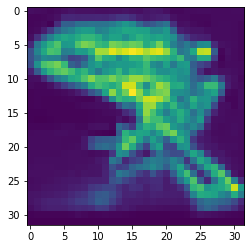

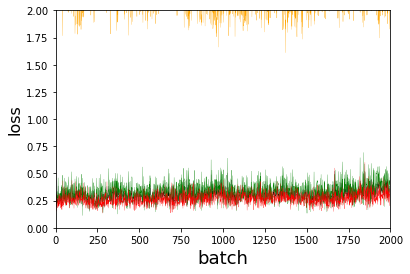

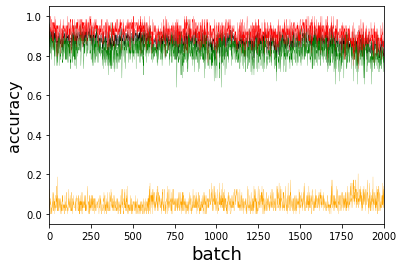

In [6]:
import os
import matplotlib.pyplot as plt


# run params
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'cifar10_frogs'
RUN_FOLDER = 'run_{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #
mode = 'load'

#(x_train, y_train) = load_safari(DATA_NAME)

x_train.shape

plt.imshow(x_train[200,:,:,0])

gan = GAN(input_dim = (32,32,3)
          #Flatten>DO>Dense(1 sigmoid) nach convs
          #padding=same
          #leaky relu alpha 0.2
          #opt = Adam(lr=0.0002, beta_1=0.5)
          #loss='binary_crossentropy'
        , discriminator_conv_filters = [64,128,128,256]
        , discriminator_conv_kernel_size = [3,3,3,3]
        , discriminator_conv_strides = [1,2,2,2]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'leaky_relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.00003 #0.0008
          
          
        , generator_initial_dense_layer_size = (4,4,256)
        , generator_upsample = [2,2,1,1]
        , generator_conv_filters = [128,128,128,3]
        , generator_conv_kernel_size = [4,4,4,4]
        , generator_conv_strides = [2,2,2,1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.00003 #0.0004
        , optimiser = 'adam'
        , z_dim = 100
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

gan.discriminator.summary()

gan.generator.summary()

BATCH_SIZE = 64
EPOCHS = 200 * BATCH_SIZE
PRINT_EVERY_N_BATCHES = BATCH_SIZE * 5

gan.train(
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , using_generator = False
)

fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()

fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()

[[ 0.17200433  0.62787501  0.54636545  0.71093315 -1.66219674 -0.74098082
  -0.54118677  0.2508811   0.22733147 -0.37674176 -0.09375732 -1.26163107
   0.90552012  0.6691173  -0.23520104  1.38231384 -0.02278924 -2.23739265
   0.80162154 -0.70523906 -0.67520399  1.39994898  0.17471835 -1.17253592
  -1.06365979 -0.69794382  0.17649725 -0.32220981 -0.10839772 -0.03085799
  -0.83624409 -0.75607604 -0.33970765 -0.29631359  0.15002294  0.20498841
   1.06083529  1.15924958  0.72851781  0.9387018   0.34991936 -1.19937418
  -0.57937748  0.5793218  -0.61827274 -1.49668753 -0.47512834  0.97218389
   1.62733406 -0.01496249 -0.88990331 -0.28656052 -0.69136126 -0.2200962
  -1.25314462 -0.41980123  0.01395503 -0.75379359 -1.22683827 -0.67740371
   0.28186845 -0.25914734  0.40160268 -1.05303818  0.15150217  0.95056297
   0.40278221 -0.46426093 -0.26510165 -0.90808439 -1.12310099 -0.01974966
  -1.869215   -0.56638451  0.43514151  0.21966254 -0.47685383  0.66117743
  -0.45402987 -0.31328202 -0.51753066 -

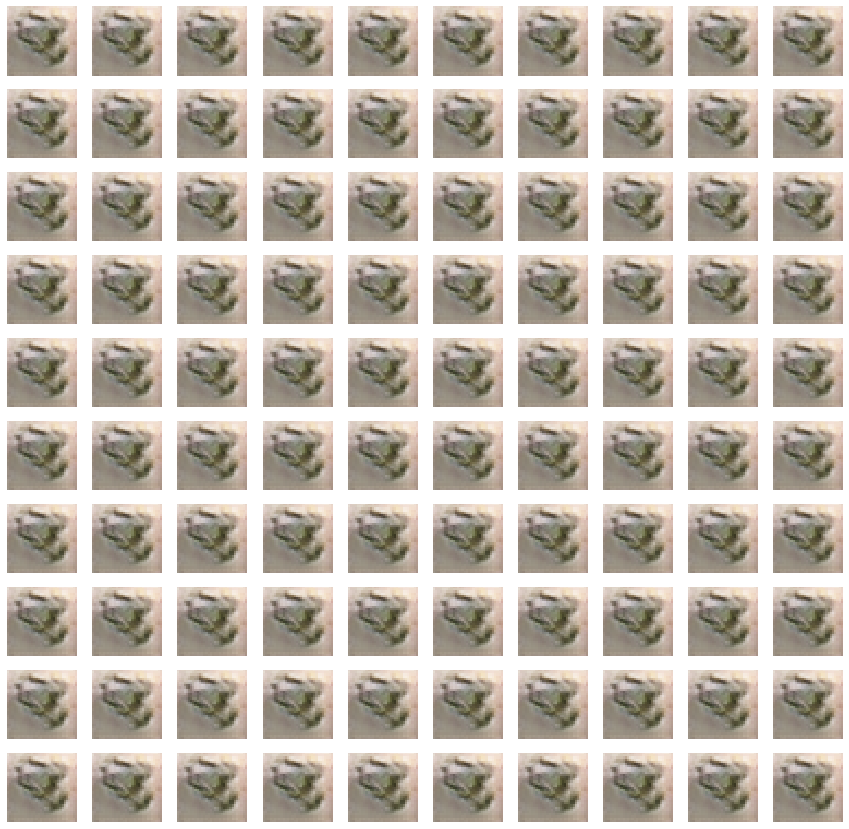

In [11]:
z_dim = 100
noise = np.random.normal(0, 1, (1, z_dim))
print(noise)

r, c = 10, 10
fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0
imgcnt = 0

for i in range(r):
    for j in range(c):
        
        imgcnt += 1

        gen_imgs = gan.generator.predict(noise)
        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)
        
        axs[i, j].imshow(np.squeeze(gen_imgs[cnt, :, :, :]))
        axs[i, j].axis('off')
        
        
        #cnt += 1
#fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
#plt.close()

In [32]:
from ipywidgets import *

z_dim = 100
initial_noise = np.random.normal(0, 1, (1, z_dim))
#print(noise)

def printimg(x):
    r, c = 1, 1
    fig, axs = plt.subplots(r, c, figsize=(3, 3))
    cnt = 0
    imgcnt = 0

    for i in range(r):
        for j in range(c):
            
            noise = []
            for val in initial_noise:
                noise.append(val*x)
            
            noise = np.array(noise)
            
            imgcnt += 1

            gen_imgs = gan.generator.predict(noise)
            gen_imgs = 0.5 * (gen_imgs + 1)
            gen_imgs = np.clip(gen_imgs, 0, 1)

            axs.imshow(np.squeeze(gen_imgs[cnt, :, :, :]))
            axs.axis('off')
    return x

interact(printimg, x=widgets.FloatSlider(min=-5, max=5, step=0.001, value=1));

interactive(children=(FloatSlider(value=1.0, description='x', max=5.0, min=-5.0, step=0.001), Output()), _dom_…

In [35]:

z_dim = 100
initial_noise = np.random.normal(0, 1, (1, z_dim))

from ipywidgets import *

z_dim = 100
initial_noise = np.random.normal(0, 1, (1, z_dim))
#print(noise)

def printimg(**args):
    r, c = 1, 1
    fig, axs = plt.subplots(r, c, figsize=(3, 3))
    cnt = 0
    imgcnt = 0

    for i in range(r):
        for j in range(c):
            
            noise = []
            for arg in args:
                noise.append(args[arg])
            
            noise = np.array(noise).T
            noise = np.reshape(noise, (100,1)).T
            
            imgcnt += 1

            gen_imgs = gan.generator.predict(noise)
            gen_imgs = 0.5 * (gen_imgs + 1)
            gen_imgs = np.clip(gen_imgs, 0, 1)

            axs.imshow(np.squeeze(gen_imgs[cnt, :, :, :]))
            axs.axis('off')
    return None

start_value=0.7

interact(printimg, 
            x1=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x2=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x3=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x4=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x5=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x6=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x7=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x8=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x9=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x10=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x11=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x12=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x13=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x14=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x15=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x16=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x17=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x18=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x19=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x20=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x21=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x22=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x23=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x24=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x25=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x26=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x27=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x28=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x29=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x30=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x31=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x32=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x33=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x34=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x35=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x36=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x37=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x38=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x39=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x40=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x41=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x42=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x43=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x44=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x45=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x46=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x47=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x48=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x49=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x50=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x51=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x52=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x53=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x54=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x55=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x56=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x57=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x58=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x59=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x60=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x61=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x62=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x63=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x64=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x65=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x66=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x67=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x68=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x69=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x70=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x71=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x72=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x73=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x74=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x75=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x76=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x77=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x78=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x79=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x80=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x81=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x82=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x83=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x84=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x85=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x86=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x87=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x88=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x89=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x90=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x91=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x92=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x93=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x94=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x95=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x96=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x97=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x98=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x99=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value),
            x100=widgets.FloatSlider(min=0, max=1, step=0.001, value=start_value))

interactive(children=(FloatSlider(value=0.7, description='x1', max=1.0, step=0.001), FloatSlider(value=0.7, de…

<function __main__.printimg(**args)>